In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# change to set working directory as required
path = 'C:/Users/Dell/Documents/4thYearProject/primary_data'
os.chdir(path)

# Hyperparameter/Network Settings

batch_size = number of samples used before updating model parameters 

n_epochs = maximum number of complete passes through the training set (with early stopping also implemented)

seq_len = length of sample slices in datasets

kernel_size = width of 1D convolutional filters

n_classes = number of classes for classification (assumed binary here)

n_channels = number of input channels/sequences per sample (4 in this case for r chest, l chest, r abdomen, l abdomen)

In [6]:
n_classes = 2
n_channels = 4
n_layers = 3

kernel_size = 9
n_filters = [8, 16, 32]

batch_size = 10
n_epochs = 5000
seq_len = 200

learning_rate = 1e-3
keep_prob = 0.2

Enter name for new run or path of previous run to reload trained modelEnter name for new run or path of previous run to reload trained model

In [4]:
runID = "checkpoints-cnn/COPD_filters58.ckpt"

# 1. Loading in data

In [40]:
def read_data(data_path, dataset_name, seq_len):
    
    label_path = os.path.join(data_path, dataset_name + '_labels.csv')
    sample_names = pd.read_csv(os.path.join(data_path, dataset_name + '_names.csv'), header=None)
    sample_names = sample_names.values
    labels = pd.read_csv(label_path, header=None)
    labels = labels.values.astype('float32')
    
    
    ch_list = ['q1', 'q2', 'q3', 'q4']
    
    X = np.zeros((len(labels), seq_len, len(ch_list)))
    
    for num, ch in enumerate(ch_list):
        chi_path = os.path.join(data_path, dataset_name + '_' + ch + '.csv')
        ch = pd.read_csv(chi_path, header=None)
        ch = ch.fillna(0)
        ch_array = ch.values
        
        # 0 pad arrays with sequences < seq_len
        if ch_array.shape[1] != seq_len:
            zero_padding = np.zeros((len(labels), seq_len-ch_array.shape[1]))
            ch_array = np.concatenate(ch_array, zero_padding, axis=1)
        
        X[:, :, num] = ch_array
    
    return X, labels, sample_names

## COPD data

22 Adults aged 35-81 (mean is 62)

Each patient sample around 9000 frames in total

In [41]:
COPD_path = '../Additional_abnormals/COPD/200/'
COPD_name = 'COPD_200'

## Matched healthy adults

22 Normal adults matched by age, gender and weight to COPD samples

Each patient sample around 9000 frames in total

In [42]:
normal_adults_path = '../Normal_adults/200/'
normal_adults_name = 'Normal_adults_200'

In [43]:
X_COPD, labels_COPD, names_COPD = read_data(COPD_path, 
                                            COPD_name, 
                                            seq_len)
X_n_adults, labels_n_adults, names_n_adults = read_data(normal_adults_path, 
                                                        normal_adults_name, 
                                                        seq_len)

In [44]:
X = np.concatenate((X_COPD, X_n_adults), axis=0)
y = np.concatenate((labels_COPD, labels_n_adults), axis=0)
sample_names = np.concatenate((names_COPD, names_n_adults), axis=0)

## Heldout COPD & normal data for testing

In [45]:
heldout_COPD_path = '../Additional_abnormals/COPD/heldout_200/'
heldout_n_path = '../Normal_adults/heldout_200/'
heldout_name = 'heldout'

In [46]:
x_heldout_COPD, labels_heldout_COPD, names_heldout_COPD = read_data(heldout_COPD_path, 
                                            heldout_name, 
                                            seq_len)
x_heldout_n, labels_heldout_n, names_heldout_n = read_data(heldout_n_path, 
                                            heldout_name, 
                                            seq_len)

x_test = np.concatenate((x_heldout_COPD, x_heldout_n), axis=0)
y_test_tmp = np.concatenate((labels_heldout_COPD, labels_heldout_n), axis=0)
sample_names_test = np.concatenate((names_heldout_COPD, names_heldout_n), axis=0)

# 2. Train-Test-Validation Split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
num_samples = X.shape[0]
indices = np.arange(num_samples)

In [49]:
X_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0, random_state=123,
                                                   shuffle=True)

In [50]:
X_tr, x_val, y_tr_tmp, y_val_tmp = train_test_split(X_train, y_train, test_size=0.2, random_state=123,
                                                   shuffle=True)

In [51]:
print('Training set size: ', X_tr.shape[0])
print('Validation set size: ', x_val.shape[0])
print('Test set size: ', x_test.shape[0])

Training set size:  1583
Validation set size:  396
Test set size:  720


# 3. One-hot encoding

In [52]:
def one_hot_encode(labels):
    num_lbls = labels.shape[0]
    
    labels_encoded = np.zeros((num_lbls, n_classes))
    lbls = np.linspace(0, n_classes-1, n_classes, dtype=int)
    
    for l in lbls:
        labels_encoded[:, l] = (labels == l).astype(np.float32).reshape(num_lbls)
    
    return labels_encoded

In [53]:
y_test = one_hot_encode(y_test_tmp)
y_tr = one_hot_encode(y_tr_tmp)
y_val = one_hot_encode(y_val_tmp)

# 4. Construct CNN graph

In [7]:
graph = tf.Graph()

with graph.as_default():
    tf.random.set_random_seed(1234)
    
    # Set placeholders for inputs and labels in graph
    inputs_ = tf.placeholder(tf.float32, shape=[None, seq_len, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, shape=[None, n_classes], name = 'labels')
    
    # keep probability used for dropout
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    
    # learning rate used in Adam optimisation
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [8]:
def conv1d(x, W, b, strides=1):
    x = tf.nn.conv1d(x, W, strides, padding='SAME')
    x = tf.nn.bias_add(x, b)
    
    return tf.nn.relu(x)

In [9]:
# Set up graph structure
# Each layer has 1D convolution followed by max pooling

with graph.as_default():
    tf.random.set_random_seed(1234)
    
    weights = {
        'wc1': tf.get_variable("wc1", [kernel_size, 4, 8]),
        'wc2': tf.get_variable("wc2", [kernel_size, 8, 16]),
        'wc3': tf.get_variable("wc3", [kernel_size, 16, 32])}
    biases = {
        'bc1': tf.get_variable("bc1", [8]), 
        'bc2': tf.get_variable("bc2", [16]),
        'bc3': tf.get_variable("bc3", [32])}
    
    conv1 = conv1d(inputs_, weights['wc1'], biases['bc1'])
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    conv2 = conv1d(max_pool_1, weights['wc2'], biases['bc2'])
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    conv3 = conv1d(max_pool_2, weights['wc3'], biases['bc3'])
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')

Flatten output and pass to classifier

In [10]:
with graph.as_default():
    tf.random.set_random_seed(1234)
    num_units = int(seq_len*np.exp2(-n_layers))*n_filters[2]
    flat = tf.reshape(max_pool_3, (-1, num_units))
    #dense = tf.layers.dense(flat, units=num_units, activation=tf.nn.relu)
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions for each class
    logits = tf.layers.dense(flat, n_classes) 

    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Define batch generator

Returns generator object - iterator (like a list) but can iterate over it only once (more memory efficient)

In [58]:
def get_batches(X, y, batch_size):
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# 5. Train network

### (if reloading a trained model, skip to 6 without running cells in section 5)

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [25]:
%%time
validation_acc = []
validation_loss = []
train_acc = []
train_loss = []
epochs_since_decrease = 0
epoch_losses = []


with graph.as_default():
    tf.random.set_random_seed(1234)
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as sess:
    tf.random.set_random_seed(1234)
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    # Loop over epochs
    for e in range(n_epochs):
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Get loss & accuracy for this iteration
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, n_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                val_bs = min(batch_size, x_val.shape[0])
                for x_v, y_v in get_batches(x_val, y_val, val_bs):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, n_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
        
        # Compute validation loss for each epoch
        val_loss_e = []
        for x_v, y_v in get_batches(x_val, y_val, batch_size):
            # Feed
            feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
            # Loss
            loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
            val_loss_e.append(loss_v)
        
        # stop if validation loss doesn't decrease for 100 epochs 
        epoch_loss = np.mean(val_loss_e)
        if e==0:
            pass
        else:
            if epoch_loss > np.mean(epoch_losses):
                epochs_since_decrease += 1
            else:
                epochs_since_decrease = 0
            if epochs_since_decrease >= 100:
                print('Stopping at epoch %d' % e)
                break
                
        epoch_losses.append(epoch_loss)
    
    saver.save(sess, runID)
    
print()

Epoch: 0/5000 Iteration: 5 Train loss: 0.838045 Train acc: 0.500000
Epoch: 0/5000 Iteration: 10 Train loss: 0.678579 Train acc: 0.500000
Epoch: 0/5000 Iteration: 10 Validation loss: 0.742864 Validation acc: 0.476923
Epoch: 0/5000 Iteration: 15 Train loss: 0.650422 Train acc: 0.800000
Epoch: 0/5000 Iteration: 20 Train loss: 0.710667 Train acc: 0.500000
Epoch: 0/5000 Iteration: 20 Validation loss: 0.708060 Validation acc: 0.476923
Epoch: 0/5000 Iteration: 25 Train loss: 0.755157 Train acc: 0.500000
Epoch: 0/5000 Iteration: 30 Train loss: 0.694152 Train acc: 0.600000
Epoch: 0/5000 Iteration: 30 Validation loss: 0.692436 Validation acc: 0.517949
Epoch: 0/5000 Iteration: 35 Train loss: 0.655515 Train acc: 0.600000
Epoch: 0/5000 Iteration: 40 Train loss: 0.694622 Train acc: 0.600000
Epoch: 0/5000 Iteration: 40 Validation loss: 0.696815 Validation acc: 0.523077
Epoch: 0/5000 Iteration: 45 Train loss: 0.858572 Train acc: 0.300000
Epoch: 0/5000 Iteration: 50 Train loss: 0.530909 Train acc: 0.80

Epoch: 2/5000 Iteration: 390 Validation loss: 0.693711 Validation acc: 0.476923
Epoch: 2/5000 Iteration: 395 Train loss: 0.681630 Train acc: 0.700000
Epoch: 2/5000 Iteration: 400 Train loss: 0.710351 Train acc: 0.200000
Epoch: 2/5000 Iteration: 400 Validation loss: 0.693286 Validation acc: 0.523077
Epoch: 2/5000 Iteration: 405 Train loss: 0.710134 Train acc: 0.300000
Epoch: 2/5000 Iteration: 410 Train loss: 0.708869 Train acc: 0.300000
Epoch: 2/5000 Iteration: 410 Validation loss: 0.692966 Validation acc: 0.502564
Epoch: 2/5000 Iteration: 415 Train loss: 0.657068 Train acc: 0.800000
Epoch: 2/5000 Iteration: 420 Train loss: 0.708750 Train acc: 0.400000
Epoch: 2/5000 Iteration: 420 Validation loss: 0.693288 Validation acc: 0.515385
Epoch: 2/5000 Iteration: 425 Train loss: 0.705677 Train acc: 0.300000
Epoch: 2/5000 Iteration: 430 Train loss: 0.694540 Train acc: 0.500000
Epoch: 2/5000 Iteration: 430 Validation loss: 0.693654 Validation acc: 0.500000
Epoch: 2/5000 Iteration: 435 Train loss:

Epoch: 4/5000 Iteration: 770 Validation loss: 0.693084 Validation acc: 0.492308
Epoch: 4/5000 Iteration: 775 Train loss: 0.690932 Train acc: 0.600000
Epoch: 4/5000 Iteration: 780 Train loss: 0.685159 Train acc: 0.600000
Epoch: 4/5000 Iteration: 780 Validation loss: 0.693052 Validation acc: 0.500000
Epoch: 4/5000 Iteration: 785 Train loss: 0.696037 Train acc: 0.600000
Epoch: 4/5000 Iteration: 790 Train loss: 0.693402 Train acc: 0.400000
Epoch: 4/5000 Iteration: 790 Validation loss: 0.692776 Validation acc: 0.538462
Epoch: 5/5000 Iteration: 795 Train loss: 0.698077 Train acc: 0.200000
Epoch: 5/5000 Iteration: 800 Train loss: 0.699267 Train acc: 0.300000
Epoch: 5/5000 Iteration: 800 Validation loss: 0.692949 Validation acc: 0.538462
Epoch: 5/5000 Iteration: 805 Train loss: 0.692934 Train acc: 0.600000
Epoch: 5/5000 Iteration: 810 Train loss: 0.694373 Train acc: 0.400000
Epoch: 5/5000 Iteration: 810 Validation loss: 0.693304 Validation acc: 0.474359
Epoch: 5/5000 Iteration: 815 Train loss:

Epoch: 7/5000 Iteration: 1160 Validation loss: 0.693024 Validation acc: 0.507692
Epoch: 7/5000 Iteration: 1165 Train loss: 0.690036 Train acc: 0.600000
Epoch: 7/5000 Iteration: 1170 Train loss: 0.700846 Train acc: 0.400000
Epoch: 7/5000 Iteration: 1170 Validation loss: 0.693441 Validation acc: 0.476923
Epoch: 7/5000 Iteration: 1175 Train loss: 0.692130 Train acc: 0.500000
Epoch: 7/5000 Iteration: 1180 Train loss: 0.700458 Train acc: 0.200000
Epoch: 7/5000 Iteration: 1180 Validation loss: 0.693676 Validation acc: 0.476923
Epoch: 7/5000 Iteration: 1185 Train loss: 0.700084 Train acc: 0.300000
Epoch: 7/5000 Iteration: 1190 Train loss: 0.694400 Train acc: 0.500000
Epoch: 7/5000 Iteration: 1190 Validation loss: 0.693604 Validation acc: 0.476923
Epoch: 7/5000 Iteration: 1195 Train loss: 0.689676 Train acc: 0.600000
Epoch: 7/5000 Iteration: 1200 Train loss: 0.689293 Train acc: 0.700000
Epoch: 7/5000 Iteration: 1200 Validation loss: 0.693611 Validation acc: 0.476923
Epoch: 7/5000 Iteration: 12

Epoch: 12/5000 Iteration: 1900 Train loss: 0.709586 Train acc: 0.500000
Epoch: 12/5000 Iteration: 1900 Validation loss: 0.692691 Validation acc: 0.502564
Epoch: 12/5000 Iteration: 1905 Train loss: 0.695954 Train acc: 0.500000
Epoch: 12/5000 Iteration: 1910 Train loss: 0.690349 Train acc: 0.500000
Epoch: 12/5000 Iteration: 1910 Validation loss: 0.693292 Validation acc: 0.487179
Epoch: 12/5000 Iteration: 1915 Train loss: 0.662881 Train acc: 0.900000
Epoch: 12/5000 Iteration: 1920 Train loss: 0.696412 Train acc: 0.500000
Epoch: 12/5000 Iteration: 1920 Validation loss: 0.692795 Validation acc: 0.512821
Epoch: 12/5000 Iteration: 1925 Train loss: 0.706283 Train acc: 0.500000
Epoch: 12/5000 Iteration: 1930 Train loss: 0.686893 Train acc: 0.600000
Epoch: 12/5000 Iteration: 1930 Validation loss: 0.691460 Validation acc: 0.538462
Epoch: 12/5000 Iteration: 1935 Train loss: 0.653465 Train acc: 0.800000
Epoch: 12/5000 Iteration: 1940 Train loss: 0.668589 Train acc: 0.600000
Epoch: 12/5000 Iteration

Epoch: 14/5000 Iteration: 2270 Validation loss: 0.685727 Validation acc: 0.558974
Epoch: 14/5000 Iteration: 2275 Train loss: 0.693507 Train acc: 0.600000
Epoch: 14/5000 Iteration: 2280 Train loss: 0.645743 Train acc: 0.700000
Epoch: 14/5000 Iteration: 2280 Validation loss: 0.677985 Validation acc: 0.638462
Epoch: 14/5000 Iteration: 2285 Train loss: 0.712575 Train acc: 0.300000
Epoch: 14/5000 Iteration: 2290 Train loss: 0.678962 Train acc: 0.800000
Epoch: 14/5000 Iteration: 2290 Validation loss: 0.671453 Validation acc: 0.623077
Epoch: 14/5000 Iteration: 2295 Train loss: 0.661272 Train acc: 0.600000
Epoch: 14/5000 Iteration: 2300 Train loss: 0.679899 Train acc: 0.500000
Epoch: 14/5000 Iteration: 2300 Validation loss: 0.672521 Validation acc: 0.530769
Epoch: 14/5000 Iteration: 2305 Train loss: 0.658588 Train acc: 0.500000
Epoch: 14/5000 Iteration: 2310 Train loss: 0.619717 Train acc: 1.000000
Epoch: 14/5000 Iteration: 2310 Validation loss: 0.679840 Validation acc: 0.600000
Epoch: 14/5000

Epoch: 16/5000 Iteration: 2650 Validation loss: 0.643500 Validation acc: 0.651282
Epoch: 16/5000 Iteration: 2655 Train loss: 0.566023 Train acc: 0.800000
Epoch: 16/5000 Iteration: 2660 Train loss: 0.711550 Train acc: 0.500000
Epoch: 16/5000 Iteration: 2660 Validation loss: 0.641638 Validation acc: 0.643590
Epoch: 16/5000 Iteration: 2665 Train loss: 0.745542 Train acc: 0.400000
Epoch: 16/5000 Iteration: 2670 Train loss: 0.609165 Train acc: 0.700000
Epoch: 16/5000 Iteration: 2670 Validation loss: 0.653543 Validation acc: 0.651282
Epoch: 16/5000 Iteration: 2675 Train loss: 0.529566 Train acc: 0.900000
Epoch: 16/5000 Iteration: 2680 Train loss: 0.732783 Train acc: 0.500000
Epoch: 16/5000 Iteration: 2680 Validation loss: 0.648243 Validation acc: 0.646154
Epoch: 16/5000 Iteration: 2685 Train loss: 0.787726 Train acc: 0.300000
Epoch: 17/5000 Iteration: 2690 Train loss: 0.736585 Train acc: 0.600000
Epoch: 17/5000 Iteration: 2690 Validation loss: 0.640615 Validation acc: 0.653846
Epoch: 17/5000

Epoch: 19/5000 Iteration: 3020 Validation loss: 0.646465 Validation acc: 0.641026
Epoch: 19/5000 Iteration: 3025 Train loss: 0.519922 Train acc: 0.900000
Epoch: 19/5000 Iteration: 3030 Train loss: 0.690557 Train acc: 0.400000
Epoch: 19/5000 Iteration: 3030 Validation loss: 0.616135 Validation acc: 0.664102
Epoch: 19/5000 Iteration: 3035 Train loss: 0.566851 Train acc: 0.700000
Epoch: 19/5000 Iteration: 3040 Train loss: 0.667704 Train acc: 0.500000
Epoch: 19/5000 Iteration: 3040 Validation loss: 0.628897 Validation acc: 0.653846
Epoch: 19/5000 Iteration: 3045 Train loss: 1.058486 Train acc: 0.300000
Epoch: 19/5000 Iteration: 3050 Train loss: 0.564191 Train acc: 0.800000
Epoch: 19/5000 Iteration: 3050 Validation loss: 0.613275 Validation acc: 0.689744
Epoch: 19/5000 Iteration: 3055 Train loss: 0.463886 Train acc: 0.800000
Epoch: 19/5000 Iteration: 3060 Train loss: 0.623102 Train acc: 0.600000
Epoch: 19/5000 Iteration: 3060 Validation loss: 0.662808 Validation acc: 0.630769
Epoch: 19/5000

Epoch: 21/5000 Iteration: 3400 Validation loss: 0.605911 Validation acc: 0.679487
Epoch: 21/5000 Iteration: 3405 Train loss: 0.845755 Train acc: 0.500000
Epoch: 21/5000 Iteration: 3410 Train loss: 0.542799 Train acc: 0.600000
Epoch: 21/5000 Iteration: 3410 Validation loss: 0.614480 Validation acc: 0.687180
Epoch: 21/5000 Iteration: 3415 Train loss: 0.556425 Train acc: 0.800000
Epoch: 21/5000 Iteration: 3420 Train loss: 0.492009 Train acc: 0.900000
Epoch: 21/5000 Iteration: 3420 Validation loss: 0.624625 Validation acc: 0.666667
Epoch: 21/5000 Iteration: 3425 Train loss: 0.943538 Train acc: 0.500000
Epoch: 21/5000 Iteration: 3430 Train loss: 0.622340 Train acc: 0.600000
Epoch: 21/5000 Iteration: 3430 Validation loss: 0.610771 Validation acc: 0.687180
Epoch: 21/5000 Iteration: 3435 Train loss: 0.647409 Train acc: 0.700000
Epoch: 21/5000 Iteration: 3440 Train loss: 0.604154 Train acc: 0.700000
Epoch: 21/5000 Iteration: 3440 Validation loss: 0.605163 Validation acc: 0.687180
Epoch: 21/5000

Epoch: 23/5000 Iteration: 3780 Validation loss: 0.631495 Validation acc: 0.694872
Epoch: 23/5000 Iteration: 3785 Train loss: 0.864788 Train acc: 0.600000
Epoch: 23/5000 Iteration: 3790 Train loss: 0.425925 Train acc: 0.900000
Epoch: 23/5000 Iteration: 3790 Validation loss: 0.600257 Validation acc: 0.684615
Epoch: 24/5000 Iteration: 3795 Train loss: 0.664792 Train acc: 0.700000
Epoch: 24/5000 Iteration: 3800 Train loss: 0.519903 Train acc: 0.700000
Epoch: 24/5000 Iteration: 3800 Validation loss: 0.602169 Validation acc: 0.689744
Epoch: 24/5000 Iteration: 3805 Train loss: 0.653964 Train acc: 0.600000
Epoch: 24/5000 Iteration: 3810 Train loss: 0.549314 Train acc: 0.600000
Epoch: 24/5000 Iteration: 3810 Validation loss: 0.635967 Validation acc: 0.682051
Epoch: 24/5000 Iteration: 3815 Train loss: 0.455883 Train acc: 0.900000
Epoch: 24/5000 Iteration: 3820 Train loss: 0.627326 Train acc: 0.600000
Epoch: 24/5000 Iteration: 3820 Validation loss: 0.618225 Validation acc: 0.687180
Epoch: 24/5000

Epoch: 26/5000 Iteration: 4150 Validation loss: 0.608902 Validation acc: 0.666667
Epoch: 26/5000 Iteration: 4155 Train loss: 0.549767 Train acc: 0.800000
Epoch: 26/5000 Iteration: 4160 Train loss: 0.521958 Train acc: 0.700000
Epoch: 26/5000 Iteration: 4160 Validation loss: 0.606870 Validation acc: 0.694872
Epoch: 26/5000 Iteration: 4165 Train loss: 0.502717 Train acc: 0.800000
Epoch: 26/5000 Iteration: 4170 Train loss: 0.419147 Train acc: 0.900000
Epoch: 26/5000 Iteration: 4170 Validation loss: 0.645651 Validation acc: 0.684615
Epoch: 26/5000 Iteration: 4175 Train loss: 0.624706 Train acc: 0.700000
Epoch: 26/5000 Iteration: 4180 Train loss: 0.431825 Train acc: 0.800000
Epoch: 26/5000 Iteration: 4180 Validation loss: 0.625307 Validation acc: 0.707692
Epoch: 26/5000 Iteration: 4185 Train loss: 0.469155 Train acc: 0.800000
Epoch: 26/5000 Iteration: 4190 Train loss: 0.356887 Train acc: 0.900000
Epoch: 26/5000 Iteration: 4190 Validation loss: 0.602567 Validation acc: 0.682051
Epoch: 26/5000

Epoch: 28/5000 Iteration: 4530 Validation loss: 0.609617 Validation acc: 0.697436
Epoch: 28/5000 Iteration: 4535 Train loss: 0.586225 Train acc: 0.600000
Epoch: 28/5000 Iteration: 4540 Train loss: 0.594558 Train acc: 0.700000
Epoch: 28/5000 Iteration: 4540 Validation loss: 0.607405 Validation acc: 0.687179
Epoch: 28/5000 Iteration: 4545 Train loss: 0.391594 Train acc: 0.800000
Epoch: 28/5000 Iteration: 4550 Train loss: 0.391429 Train acc: 0.900000
Epoch: 28/5000 Iteration: 4550 Validation loss: 0.606816 Validation acc: 0.694872
Epoch: 28/5000 Iteration: 4555 Train loss: 0.381705 Train acc: 0.900000
Epoch: 28/5000 Iteration: 4560 Train loss: 0.636104 Train acc: 0.700000
Epoch: 28/5000 Iteration: 4560 Validation loss: 0.603433 Validation acc: 0.694872
Epoch: 28/5000 Iteration: 4565 Train loss: 0.400100 Train acc: 0.900000
Epoch: 28/5000 Iteration: 4570 Train loss: 0.469140 Train acc: 0.600000
Epoch: 28/5000 Iteration: 4570 Validation loss: 0.610922 Validation acc: 0.700000
Epoch: 28/5000

Epoch: 31/5000 Iteration: 4905 Train loss: 0.576845 Train acc: 0.700000
Epoch: 31/5000 Iteration: 4910 Train loss: 0.235742 Train acc: 1.000000
Epoch: 31/5000 Iteration: 4910 Validation loss: 0.601897 Validation acc: 0.697436
Epoch: 31/5000 Iteration: 4915 Train loss: 0.445334 Train acc: 0.800000
Epoch: 31/5000 Iteration: 4920 Train loss: 0.476938 Train acc: 0.800000
Epoch: 31/5000 Iteration: 4920 Validation loss: 0.693178 Validation acc: 0.648718
Epoch: 31/5000 Iteration: 4925 Train loss: 0.797059 Train acc: 0.500000
Epoch: 31/5000 Iteration: 4930 Train loss: 0.329267 Train acc: 0.900000
Epoch: 31/5000 Iteration: 4930 Validation loss: 0.604766 Validation acc: 0.705128
Epoch: 31/5000 Iteration: 4935 Train loss: 0.515046 Train acc: 0.700000
Epoch: 31/5000 Iteration: 4940 Train loss: 0.591991 Train acc: 0.600000
Epoch: 31/5000 Iteration: 4940 Validation loss: 0.609184 Validation acc: 0.661538
Epoch: 31/5000 Iteration: 4945 Train loss: 0.593911 Train acc: 0.700000
Epoch: 31/5000 Iteration

Epoch: 33/5000 Iteration: 5280 Validation loss: 0.629515 Validation acc: 0.694872
Epoch: 33/5000 Iteration: 5285 Train loss: 0.379958 Train acc: 1.000000
Epoch: 33/5000 Iteration: 5290 Train loss: 0.671060 Train acc: 0.700000
Epoch: 33/5000 Iteration: 5290 Validation loss: 0.644486 Validation acc: 0.692308
Epoch: 33/5000 Iteration: 5295 Train loss: 0.457318 Train acc: 0.700000
Epoch: 33/5000 Iteration: 5300 Train loss: 0.740214 Train acc: 0.600000
Epoch: 33/5000 Iteration: 5300 Validation loss: 0.611577 Validation acc: 0.682051
Epoch: 33/5000 Iteration: 5305 Train loss: 0.493237 Train acc: 0.700000
Epoch: 33/5000 Iteration: 5310 Train loss: 0.458141 Train acc: 0.800000
Epoch: 33/5000 Iteration: 5310 Validation loss: 0.611291 Validation acc: 0.694872
Epoch: 33/5000 Iteration: 5315 Train loss: 0.599524 Train acc: 0.800000
Epoch: 33/5000 Iteration: 5320 Train loss: 0.400074 Train acc: 0.900000
Epoch: 33/5000 Iteration: 5320 Validation loss: 0.619125 Validation acc: 0.694872
Epoch: 33/5000

Epoch: 35/5000 Iteration: 5660 Validation loss: 0.601547 Validation acc: 0.712820
Epoch: 35/5000 Iteration: 5665 Train loss: 0.700599 Train acc: 0.700000
Epoch: 35/5000 Iteration: 5670 Train loss: 0.362894 Train acc: 0.900000
Epoch: 35/5000 Iteration: 5670 Validation loss: 0.597998 Validation acc: 0.710256
Epoch: 35/5000 Iteration: 5675 Train loss: 0.384190 Train acc: 0.900000
Epoch: 35/5000 Iteration: 5680 Train loss: 0.443935 Train acc: 0.800000
Epoch: 35/5000 Iteration: 5680 Validation loss: 0.639813 Validation acc: 0.700000
Epoch: 35/5000 Iteration: 5685 Train loss: 0.604815 Train acc: 0.700000
Epoch: 36/5000 Iteration: 5690 Train loss: 0.650357 Train acc: 0.500000
Epoch: 36/5000 Iteration: 5690 Validation loss: 0.598914 Validation acc: 0.669231
Epoch: 36/5000 Iteration: 5695 Train loss: 0.698364 Train acc: 0.600000
Epoch: 36/5000 Iteration: 5700 Train loss: 0.305701 Train acc: 1.000000
Epoch: 36/5000 Iteration: 5700 Validation loss: 0.598964 Validation acc: 0.723077
Epoch: 36/5000

Epoch: 38/5000 Iteration: 6040 Train loss: 0.688849 Train acc: 0.800000
Epoch: 38/5000 Iteration: 6040 Validation loss: 0.600786 Validation acc: 0.702564
Epoch: 38/5000 Iteration: 6045 Train loss: 0.503717 Train acc: 0.600000
Epoch: 38/5000 Iteration: 6050 Train loss: 0.464123 Train acc: 0.800000
Epoch: 38/5000 Iteration: 6050 Validation loss: 0.605784 Validation acc: 0.728205
Epoch: 38/5000 Iteration: 6055 Train loss: 0.373996 Train acc: 0.900000
Epoch: 38/5000 Iteration: 6060 Train loss: 0.219280 Train acc: 0.900000
Epoch: 38/5000 Iteration: 6060 Validation loss: 0.652257 Validation acc: 0.702564
Epoch: 38/5000 Iteration: 6065 Train loss: 0.625218 Train acc: 0.800000
Epoch: 38/5000 Iteration: 6070 Train loss: 0.370583 Train acc: 0.900000
Epoch: 38/5000 Iteration: 6070 Validation loss: 0.601989 Validation acc: 0.720513
Epoch: 38/5000 Iteration: 6075 Train loss: 0.436789 Train acc: 0.800000
Epoch: 38/5000 Iteration: 6080 Train loss: 0.482404 Train acc: 0.700000
Epoch: 38/5000 Iteration

Epoch: 40/5000 Iteration: 6410 Validation loss: 0.596091 Validation acc: 0.715385
Epoch: 40/5000 Iteration: 6415 Train loss: 0.686533 Train acc: 0.900000
Epoch: 40/5000 Iteration: 6420 Train loss: 0.463388 Train acc: 0.800000
Epoch: 40/5000 Iteration: 6420 Validation loss: 0.597429 Validation acc: 0.720513
Epoch: 40/5000 Iteration: 6425 Train loss: 0.359853 Train acc: 0.800000
Epoch: 40/5000 Iteration: 6430 Train loss: 0.581525 Train acc: 0.900000
Epoch: 40/5000 Iteration: 6430 Validation loss: 0.589369 Validation acc: 0.702564
Epoch: 40/5000 Iteration: 6435 Train loss: 0.460694 Train acc: 0.600000
Epoch: 40/5000 Iteration: 6440 Train loss: 0.306610 Train acc: 0.900000
Epoch: 40/5000 Iteration: 6440 Validation loss: 0.582454 Validation acc: 0.705128
Epoch: 40/5000 Iteration: 6445 Train loss: 0.425612 Train acc: 0.900000
Epoch: 40/5000 Iteration: 6450 Train loss: 0.274687 Train acc: 1.000000
Epoch: 40/5000 Iteration: 6450 Validation loss: 0.588000 Validation acc: 0.710256
Epoch: 40/5000

Epoch: 42/5000 Iteration: 6785 Train loss: 0.345545 Train acc: 0.900000
Epoch: 42/5000 Iteration: 6790 Train loss: 0.642355 Train acc: 0.700000
Epoch: 42/5000 Iteration: 6790 Validation loss: 0.582559 Validation acc: 0.712820
Epoch: 43/5000 Iteration: 6795 Train loss: 0.530998 Train acc: 0.800000
Epoch: 43/5000 Iteration: 6800 Train loss: 0.785376 Train acc: 0.500000
Epoch: 43/5000 Iteration: 6800 Validation loss: 0.575684 Validation acc: 0.707692
Epoch: 43/5000 Iteration: 6805 Train loss: 0.373960 Train acc: 1.000000
Epoch: 43/5000 Iteration: 6810 Train loss: 0.504036 Train acc: 0.700000
Epoch: 43/5000 Iteration: 6810 Validation loss: 0.622401 Validation acc: 0.707692
Epoch: 43/5000 Iteration: 6815 Train loss: 0.285130 Train acc: 1.000000
Epoch: 43/5000 Iteration: 6820 Train loss: 0.494916 Train acc: 0.600000
Epoch: 43/5000 Iteration: 6820 Validation loss: 0.656247 Validation acc: 0.697436
Epoch: 43/5000 Iteration: 6825 Train loss: 0.543659 Train acc: 0.600000
Epoch: 43/5000 Iteration

Epoch: 45/5000 Iteration: 7160 Validation loss: 0.608948 Validation acc: 0.712821
Epoch: 45/5000 Iteration: 7165 Train loss: 0.593403 Train acc: 0.700000
Epoch: 45/5000 Iteration: 7170 Train loss: 0.630081 Train acc: 0.800000
Epoch: 45/5000 Iteration: 7170 Validation loss: 0.621680 Validation acc: 0.697436
Epoch: 45/5000 Iteration: 7175 Train loss: 0.446354 Train acc: 0.900000
Epoch: 45/5000 Iteration: 7180 Train loss: 0.217340 Train acc: 1.000000
Epoch: 45/5000 Iteration: 7180 Validation loss: 0.591784 Validation acc: 0.715385
Epoch: 45/5000 Iteration: 7185 Train loss: 0.533801 Train acc: 0.800000
Epoch: 45/5000 Iteration: 7190 Train loss: 0.437195 Train acc: 0.600000
Epoch: 45/5000 Iteration: 7190 Validation loss: 0.623110 Validation acc: 0.715385
Epoch: 45/5000 Iteration: 7195 Train loss: 0.564527 Train acc: 0.700000
Epoch: 45/5000 Iteration: 7200 Train loss: 0.495125 Train acc: 0.800000
Epoch: 45/5000 Iteration: 7200 Validation loss: 0.587522 Validation acc: 0.733333
Epoch: 45/5000

Epoch: 47/5000 Iteration: 7540 Train loss: 0.584778 Train acc: 0.600000
Epoch: 47/5000 Iteration: 7540 Validation loss: 0.597540 Validation acc: 0.720513
Epoch: 47/5000 Iteration: 7545 Train loss: 0.844985 Train acc: 0.500000
Epoch: 47/5000 Iteration: 7550 Train loss: 0.775775 Train acc: 0.700000
Epoch: 47/5000 Iteration: 7550 Validation loss: 0.576403 Validation acc: 0.730769
Epoch: 47/5000 Iteration: 7555 Train loss: 0.398033 Train acc: 0.800000
Epoch: 47/5000 Iteration: 7560 Train loss: 0.334400 Train acc: 0.900000
Epoch: 47/5000 Iteration: 7560 Validation loss: 0.581744 Validation acc: 0.741026
Epoch: 47/5000 Iteration: 7565 Train loss: 0.534881 Train acc: 0.700000
Epoch: 47/5000 Iteration: 7570 Train loss: 0.427395 Train acc: 0.700000
Epoch: 47/5000 Iteration: 7570 Validation loss: 0.602421 Validation acc: 0.720513
Epoch: 47/5000 Iteration: 7575 Train loss: 0.455540 Train acc: 0.700000
Epoch: 47/5000 Iteration: 7580 Train loss: 0.540227 Train acc: 0.600000
Epoch: 47/5000 Iteration

Epoch: 50/5000 Iteration: 7905 Train loss: 0.259410 Train acc: 0.900000
Epoch: 50/5000 Iteration: 7910 Train loss: 0.513670 Train acc: 0.800000
Epoch: 50/5000 Iteration: 7910 Validation loss: 0.569013 Validation acc: 0.717949
Epoch: 50/5000 Iteration: 7915 Train loss: 0.425157 Train acc: 0.800000
Epoch: 50/5000 Iteration: 7920 Train loss: 0.493281 Train acc: 0.700000
Epoch: 50/5000 Iteration: 7920 Validation loss: 0.638590 Validation acc: 0.702564
Epoch: 50/5000 Iteration: 7925 Train loss: 0.689519 Train acc: 0.600000
Epoch: 50/5000 Iteration: 7930 Train loss: 0.449558 Train acc: 0.900000
Epoch: 50/5000 Iteration: 7930 Validation loss: 0.624923 Validation acc: 0.707692
Epoch: 50/5000 Iteration: 7935 Train loss: 0.512680 Train acc: 0.800000
Epoch: 50/5000 Iteration: 7940 Train loss: 0.626873 Train acc: 0.700000
Epoch: 50/5000 Iteration: 7940 Validation loss: 0.589067 Validation acc: 0.725641
Epoch: 50/5000 Iteration: 7945 Train loss: 0.766049 Train acc: 0.600000
Epoch: 50/5000 Iteration

Epoch: 52/5000 Iteration: 8280 Validation loss: 0.676420 Validation acc: 0.689744
Epoch: 52/5000 Iteration: 8285 Train loss: 0.352227 Train acc: 0.900000
Epoch: 52/5000 Iteration: 8290 Train loss: 0.422524 Train acc: 0.900000
Epoch: 52/5000 Iteration: 8290 Validation loss: 0.630256 Validation acc: 0.710256
Epoch: 52/5000 Iteration: 8295 Train loss: 0.575046 Train acc: 0.600000
Epoch: 52/5000 Iteration: 8300 Train loss: 0.447318 Train acc: 0.800000
Epoch: 52/5000 Iteration: 8300 Validation loss: 0.584884 Validation acc: 0.741026
Epoch: 52/5000 Iteration: 8305 Train loss: 0.986163 Train acc: 0.700000
Epoch: 52/5000 Iteration: 8310 Train loss: 0.645607 Train acc: 0.700000
Epoch: 52/5000 Iteration: 8310 Validation loss: 0.585819 Validation acc: 0.725641
Epoch: 52/5000 Iteration: 8315 Train loss: 1.145407 Train acc: 0.500000
Epoch: 52/5000 Iteration: 8320 Train loss: 0.333832 Train acc: 0.800000
Epoch: 52/5000 Iteration: 8320 Validation loss: 0.576465 Validation acc: 0.723077
Epoch: 52/5000

Epoch: 54/5000 Iteration: 8650 Validation loss: 0.583107 Validation acc: 0.738462
Epoch: 54/5000 Iteration: 8655 Train loss: 0.573829 Train acc: 0.700000
Epoch: 54/5000 Iteration: 8660 Train loss: 0.354525 Train acc: 0.900000
Epoch: 54/5000 Iteration: 8660 Validation loss: 0.568332 Validation acc: 0.738461
Epoch: 54/5000 Iteration: 8665 Train loss: 0.616691 Train acc: 0.700000
Epoch: 54/5000 Iteration: 8670 Train loss: 0.546253 Train acc: 0.700000
Epoch: 54/5000 Iteration: 8670 Validation loss: 0.571275 Validation acc: 0.748718
Epoch: 54/5000 Iteration: 8675 Train loss: 0.250853 Train acc: 1.000000
Epoch: 54/5000 Iteration: 8680 Train loss: 0.600257 Train acc: 0.600000
Epoch: 54/5000 Iteration: 8680 Validation loss: 0.605063 Validation acc: 0.725641
Epoch: 54/5000 Iteration: 8685 Train loss: 0.523103 Train acc: 0.800000
Epoch: 54/5000 Iteration: 8690 Train loss: 0.590202 Train acc: 0.700000
Epoch: 54/5000 Iteration: 8690 Validation loss: 0.581568 Validation acc: 0.702564
Epoch: 55/5000

Epoch: 57/5000 Iteration: 9030 Train loss: 0.354803 Train acc: 0.900000
Epoch: 57/5000 Iteration: 9030 Validation loss: 0.633062 Validation acc: 0.715385
Epoch: 57/5000 Iteration: 9035 Train loss: 0.431202 Train acc: 0.800000
Epoch: 57/5000 Iteration: 9040 Train loss: 0.399721 Train acc: 0.900000
Epoch: 57/5000 Iteration: 9040 Validation loss: 0.567670 Validation acc: 0.743590
Epoch: 57/5000 Iteration: 9045 Train loss: 0.262781 Train acc: 0.900000
Epoch: 57/5000 Iteration: 9050 Train loss: 0.375380 Train acc: 0.900000
Epoch: 57/5000 Iteration: 9050 Validation loss: 0.570250 Validation acc: 0.717949
Epoch: 57/5000 Iteration: 9055 Train loss: 0.551314 Train acc: 0.700000
Epoch: 57/5000 Iteration: 9060 Train loss: 0.378205 Train acc: 0.900000
Epoch: 57/5000 Iteration: 9060 Validation loss: 0.596330 Validation acc: 0.728205
Epoch: 57/5000 Iteration: 9065 Train loss: 0.508155 Train acc: 0.800000
Epoch: 57/5000 Iteration: 9070 Train loss: 0.902769 Train acc: 0.500000
Epoch: 57/5000 Iteration

Epoch: 59/5000 Iteration: 9400 Validation loss: 0.567103 Validation acc: 0.746154
Epoch: 59/5000 Iteration: 9405 Train loss: 0.501924 Train acc: 0.600000
Epoch: 59/5000 Iteration: 9410 Train loss: 0.981691 Train acc: 0.600000
Epoch: 59/5000 Iteration: 9410 Validation loss: 0.569642 Validation acc: 0.746154
Epoch: 59/5000 Iteration: 9415 Train loss: 0.485580 Train acc: 0.600000
Epoch: 59/5000 Iteration: 9420 Train loss: 0.392274 Train acc: 0.800000
Epoch: 59/5000 Iteration: 9420 Validation loss: 0.570152 Validation acc: 0.735897
Epoch: 59/5000 Iteration: 9425 Train loss: 0.211882 Train acc: 0.900000
Epoch: 59/5000 Iteration: 9430 Train loss: 0.466851 Train acc: 0.700000
Epoch: 59/5000 Iteration: 9430 Validation loss: 0.574131 Validation acc: 0.730769
Epoch: 59/5000 Iteration: 9435 Train loss: 0.383998 Train acc: 0.800000
Epoch: 59/5000 Iteration: 9440 Train loss: 0.284220 Train acc: 0.900000
Epoch: 59/5000 Iteration: 9440 Validation loss: 0.557342 Validation acc: 0.743590
Epoch: 59/5000

Epoch: 61/5000 Iteration: 9780 Validation loss: 0.571330 Validation acc: 0.746154
Epoch: 61/5000 Iteration: 9785 Train loss: 0.634607 Train acc: 0.500000
Epoch: 61/5000 Iteration: 9790 Train loss: 0.589895 Train acc: 0.800000
Epoch: 61/5000 Iteration: 9790 Validation loss: 0.573284 Validation acc: 0.743590
Epoch: 61/5000 Iteration: 9795 Train loss: 0.761907 Train acc: 0.700000
Epoch: 62/5000 Iteration: 9800 Train loss: 0.872611 Train acc: 0.600000
Epoch: 62/5000 Iteration: 9800 Validation loss: 0.549699 Validation acc: 0.748718
Epoch: 62/5000 Iteration: 9805 Train loss: 0.364765 Train acc: 1.000000
Epoch: 62/5000 Iteration: 9810 Train loss: 0.424737 Train acc: 0.900000
Epoch: 62/5000 Iteration: 9810 Validation loss: 0.551440 Validation acc: 0.723077
Epoch: 62/5000 Iteration: 9815 Train loss: 0.243960 Train acc: 1.000000
Epoch: 62/5000 Iteration: 9820 Train loss: 0.270726 Train acc: 0.900000
Epoch: 62/5000 Iteration: 9820 Validation loss: 0.585477 Validation acc: 0.720513
Epoch: 62/5000

Epoch: 64/5000 Iteration: 10155 Train loss: 0.502023 Train acc: 0.700000
Epoch: 64/5000 Iteration: 10160 Train loss: 0.407864 Train acc: 1.000000
Epoch: 64/5000 Iteration: 10160 Validation loss: 0.568092 Validation acc: 0.751282
Epoch: 64/5000 Iteration: 10165 Train loss: 0.561225 Train acc: 0.600000
Epoch: 64/5000 Iteration: 10170 Train loss: 0.330421 Train acc: 0.900000
Epoch: 64/5000 Iteration: 10170 Validation loss: 0.650769 Validation acc: 0.710256
Epoch: 64/5000 Iteration: 10175 Train loss: 0.323822 Train acc: 0.800000
Epoch: 64/5000 Iteration: 10180 Train loss: 0.552737 Train acc: 0.800000
Epoch: 64/5000 Iteration: 10180 Validation loss: 0.652699 Validation acc: 0.707692
Epoch: 64/5000 Iteration: 10185 Train loss: 0.427974 Train acc: 0.900000
Epoch: 64/5000 Iteration: 10190 Train loss: 0.385243 Train acc: 0.800000
Epoch: 64/5000 Iteration: 10190 Validation loss: 0.597870 Validation acc: 0.730769
Epoch: 64/5000 Iteration: 10195 Train loss: 0.401387 Train acc: 0.900000
Epoch: 64/5

Epoch: 66/5000 Iteration: 10520 Validation loss: 0.573564 Validation acc: 0.751282
Epoch: 66/5000 Iteration: 10525 Train loss: 0.249605 Train acc: 0.800000
Epoch: 66/5000 Iteration: 10530 Train loss: 0.386298 Train acc: 0.700000
Epoch: 66/5000 Iteration: 10530 Validation loss: 0.561666 Validation acc: 0.753846
Epoch: 66/5000 Iteration: 10535 Train loss: 0.961843 Train acc: 0.800000
Epoch: 66/5000 Iteration: 10540 Train loss: 0.591519 Train acc: 0.600000
Epoch: 66/5000 Iteration: 10540 Validation loss: 0.567328 Validation acc: 0.741026
Epoch: 66/5000 Iteration: 10545 Train loss: 0.515129 Train acc: 0.800000
Epoch: 66/5000 Iteration: 10550 Train loss: 0.451868 Train acc: 0.800000
Epoch: 66/5000 Iteration: 10550 Validation loss: 0.571820 Validation acc: 0.743590
Epoch: 66/5000 Iteration: 10555 Train loss: 0.402598 Train acc: 0.800000
Epoch: 66/5000 Iteration: 10560 Train loss: 1.021003 Train acc: 0.600000
Epoch: 66/5000 Iteration: 10560 Validation loss: 0.559642 Validation acc: 0.748718
E

Epoch: 68/5000 Iteration: 10890 Validation loss: 0.581162 Validation acc: 0.728205
Epoch: 68/5000 Iteration: 10895 Train loss: 0.341938 Train acc: 0.800000
Epoch: 68/5000 Iteration: 10900 Train loss: 0.427924 Train acc: 0.800000
Epoch: 68/5000 Iteration: 10900 Validation loss: 0.552985 Validation acc: 0.730769
Epoch: 69/5000 Iteration: 10905 Train loss: 0.509049 Train acc: 0.700000
Epoch: 69/5000 Iteration: 10910 Train loss: 0.480143 Train acc: 0.800000
Epoch: 69/5000 Iteration: 10910 Validation loss: 0.548143 Validation acc: 0.738462
Epoch: 69/5000 Iteration: 10915 Train loss: 0.517525 Train acc: 0.600000
Epoch: 69/5000 Iteration: 10920 Train loss: 0.488897 Train acc: 0.700000
Epoch: 69/5000 Iteration: 10920 Validation loss: 0.575192 Validation acc: 0.720513
Epoch: 69/5000 Iteration: 10925 Train loss: 0.492286 Train acc: 0.800000
Epoch: 69/5000 Iteration: 10930 Train loss: 0.331118 Train acc: 0.900000
Epoch: 69/5000 Iteration: 10930 Validation loss: 0.584356 Validation acc: 0.723077
E

Epoch: 71/5000 Iteration: 11260 Train loss: 0.485997 Train acc: 0.700000
Epoch: 71/5000 Iteration: 11260 Validation loss: 0.566532 Validation acc: 0.748718
Epoch: 71/5000 Iteration: 11265 Train loss: 0.537687 Train acc: 0.800000
Epoch: 71/5000 Iteration: 11270 Train loss: 0.371549 Train acc: 0.800000
Epoch: 71/5000 Iteration: 11270 Validation loss: 0.584634 Validation acc: 0.741026
Epoch: 71/5000 Iteration: 11275 Train loss: 0.462841 Train acc: 0.800000
Epoch: 71/5000 Iteration: 11280 Train loss: 0.396129 Train acc: 0.900000
Epoch: 71/5000 Iteration: 11280 Validation loss: 0.642354 Validation acc: 0.710256
Epoch: 71/5000 Iteration: 11285 Train loss: 0.489065 Train acc: 0.800000
Epoch: 71/5000 Iteration: 11290 Train loss: 0.324595 Train acc: 0.900000
Epoch: 71/5000 Iteration: 11290 Validation loss: 0.626083 Validation acc: 0.717949
Epoch: 71/5000 Iteration: 11295 Train loss: 0.258306 Train acc: 0.900000
Epoch: 71/5000 Iteration: 11300 Train loss: 0.341561 Train acc: 0.900000
Epoch: 71/5

Epoch: 73/5000 Iteration: 11620 Validation loss: 0.537772 Validation acc: 0.761539
Epoch: 73/5000 Iteration: 11625 Train loss: 0.516095 Train acc: 0.700000
Epoch: 73/5000 Iteration: 11630 Train loss: 0.283458 Train acc: 1.000000
Epoch: 73/5000 Iteration: 11630 Validation loss: 0.545796 Validation acc: 0.766667
Epoch: 73/5000 Iteration: 11635 Train loss: 0.835060 Train acc: 0.800000
Epoch: 73/5000 Iteration: 11640 Train loss: 0.430489 Train acc: 0.800000
Epoch: 73/5000 Iteration: 11640 Validation loss: 0.547747 Validation acc: 0.766667
Epoch: 73/5000 Iteration: 11645 Train loss: 0.742629 Train acc: 0.700000
Epoch: 73/5000 Iteration: 11650 Train loss: 0.552172 Train acc: 0.600000
Epoch: 73/5000 Iteration: 11650 Validation loss: 0.560973 Validation acc: 0.746154
Epoch: 73/5000 Iteration: 11655 Train loss: 0.170953 Train acc: 1.000000
Epoch: 73/5000 Iteration: 11660 Train loss: 0.138143 Train acc: 1.000000
Epoch: 73/5000 Iteration: 11660 Validation loss: 0.537440 Validation acc: 0.743590
E

Epoch: 75/5000 Iteration: 11990 Validation loss: 0.556063 Validation acc: 0.743590
Epoch: 75/5000 Iteration: 11995 Train loss: 0.512884 Train acc: 0.700000
Epoch: 75/5000 Iteration: 12000 Train loss: 0.448202 Train acc: 0.700000
Epoch: 75/5000 Iteration: 12000 Validation loss: 0.580141 Validation acc: 0.730769
Epoch: 75/5000 Iteration: 12005 Train loss: 0.483199 Train acc: 0.700000
Epoch: 76/5000 Iteration: 12010 Train loss: 0.626847 Train acc: 0.800000
Epoch: 76/5000 Iteration: 12010 Validation loss: 0.556158 Validation acc: 0.741026
Epoch: 76/5000 Iteration: 12015 Train loss: 0.431516 Train acc: 0.700000
Epoch: 76/5000 Iteration: 12020 Train loss: 0.172428 Train acc: 1.000000
Epoch: 76/5000 Iteration: 12020 Validation loss: 0.534236 Validation acc: 0.738462
Epoch: 76/5000 Iteration: 12025 Train loss: 0.448028 Train acc: 0.800000
Epoch: 76/5000 Iteration: 12030 Train loss: 0.384814 Train acc: 1.000000
Epoch: 76/5000 Iteration: 12030 Validation loss: 0.586374 Validation acc: 0.717949
E

Epoch: 78/5000 Iteration: 12360 Validation loss: 0.547633 Validation acc: 0.743590
Epoch: 78/5000 Iteration: 12365 Train loss: 0.555887 Train acc: 0.700000
Epoch: 78/5000 Iteration: 12370 Train loss: 0.422893 Train acc: 0.800000
Epoch: 78/5000 Iteration: 12370 Validation loss: 0.539969 Validation acc: 0.753846
Epoch: 78/5000 Iteration: 12375 Train loss: 0.333448 Train acc: 0.800000
Epoch: 78/5000 Iteration: 12380 Train loss: 0.233060 Train acc: 1.000000
Epoch: 78/5000 Iteration: 12380 Validation loss: 0.619792 Validation acc: 0.723077
Epoch: 78/5000 Iteration: 12385 Train loss: 0.497811 Train acc: 0.800000
Epoch: 78/5000 Iteration: 12390 Train loss: 0.294842 Train acc: 0.900000
Epoch: 78/5000 Iteration: 12390 Validation loss: 0.609839 Validation acc: 0.720513
Epoch: 78/5000 Iteration: 12395 Train loss: 0.363826 Train acc: 0.800000
Epoch: 78/5000 Iteration: 12400 Train loss: 0.178880 Train acc: 1.000000
Epoch: 78/5000 Iteration: 12400 Validation loss: 0.593255 Validation acc: 0.735897
E

Epoch: 80/5000 Iteration: 12720 Validation loss: 0.582639 Validation acc: 0.753846
Epoch: 80/5000 Iteration: 12725 Train loss: 0.888861 Train acc: 0.700000
Epoch: 80/5000 Iteration: 12730 Train loss: 0.380173 Train acc: 0.700000
Epoch: 80/5000 Iteration: 12730 Validation loss: 0.574439 Validation acc: 0.771795
Epoch: 80/5000 Iteration: 12735 Train loss: 0.515830 Train acc: 0.800000
Epoch: 80/5000 Iteration: 12740 Train loss: 0.413731 Train acc: 0.700000
Epoch: 80/5000 Iteration: 12740 Validation loss: 0.550166 Validation acc: 0.758974
Epoch: 80/5000 Iteration: 12745 Train loss: 0.431599 Train acc: 0.800000
Epoch: 80/5000 Iteration: 12750 Train loss: 0.305459 Train acc: 1.000000
Epoch: 80/5000 Iteration: 12750 Validation loss: 0.546133 Validation acc: 0.764103
Epoch: 80/5000 Iteration: 12755 Train loss: 0.476211 Train acc: 0.800000
Epoch: 80/5000 Iteration: 12760 Train loss: 0.335459 Train acc: 1.000000
Epoch: 80/5000 Iteration: 12760 Validation loss: 0.551120 Validation acc: 0.764103
E

Epoch: 82/5000 Iteration: 13090 Validation loss: 0.530551 Validation acc: 0.761538
Epoch: 82/5000 Iteration: 13095 Train loss: 0.578531 Train acc: 0.700000
Epoch: 82/5000 Iteration: 13100 Train loss: 0.482366 Train acc: 0.700000
Epoch: 82/5000 Iteration: 13100 Validation loss: 0.568619 Validation acc: 0.764103
Epoch: 82/5000 Iteration: 13105 Train loss: 0.778137 Train acc: 0.600000
Epoch: 82/5000 Iteration: 13110 Train loss: 0.816560 Train acc: 0.400000
Epoch: 82/5000 Iteration: 13110 Validation loss: 0.558226 Validation acc: 0.741026
Epoch: 83/5000 Iteration: 13115 Train loss: 0.480368 Train acc: 0.900000
Epoch: 83/5000 Iteration: 13120 Train loss: 0.390724 Train acc: 0.900000
Epoch: 83/5000 Iteration: 13120 Validation loss: 0.559333 Validation acc: 0.728205
Epoch: 83/5000 Iteration: 13125 Train loss: 0.326511 Train acc: 1.000000
Epoch: 83/5000 Iteration: 13130 Train loss: 0.530984 Train acc: 0.800000
Epoch: 83/5000 Iteration: 13130 Validation loss: 0.567771 Validation acc: 0.751282
E

Epoch: 85/5000 Iteration: 13450 Validation loss: 0.576750 Validation acc: 0.743590
Epoch: 85/5000 Iteration: 13455 Train loss: 0.893547 Train acc: 0.700000
Epoch: 85/5000 Iteration: 13460 Train loss: 0.399497 Train acc: 0.800000
Epoch: 85/5000 Iteration: 13460 Validation loss: 0.557030 Validation acc: 0.751282
Epoch: 85/5000 Iteration: 13465 Train loss: 0.323319 Train acc: 1.000000
Epoch: 85/5000 Iteration: 13470 Train loss: 0.626420 Train acc: 0.600000
Epoch: 85/5000 Iteration: 13470 Validation loss: 0.547979 Validation acc: 0.743590
Epoch: 85/5000 Iteration: 13475 Train loss: 0.644543 Train acc: 0.600000
Epoch: 85/5000 Iteration: 13480 Train loss: 0.468731 Train acc: 0.700000
Epoch: 85/5000 Iteration: 13480 Validation loss: 0.568043 Validation acc: 0.758974
Epoch: 85/5000 Iteration: 13485 Train loss: 0.579431 Train acc: 0.800000
Epoch: 85/5000 Iteration: 13490 Train loss: 0.643923 Train acc: 0.800000
Epoch: 85/5000 Iteration: 13490 Validation loss: 0.650813 Validation acc: 0.710256
E

Epoch: 87/5000 Iteration: 13810 Validation loss: 0.641992 Validation acc: 0.735897
Epoch: 87/5000 Iteration: 13815 Train loss: 0.226766 Train acc: 1.000000
Epoch: 87/5000 Iteration: 13820 Train loss: 0.212098 Train acc: 1.000000
Epoch: 87/5000 Iteration: 13820 Validation loss: 0.627412 Validation acc: 0.741026
Epoch: 87/5000 Iteration: 13825 Train loss: 0.606232 Train acc: 0.500000
Epoch: 87/5000 Iteration: 13830 Train loss: 0.346764 Train acc: 0.800000
Epoch: 87/5000 Iteration: 13830 Validation loss: 0.604765 Validation acc: 0.746154
Epoch: 87/5000 Iteration: 13835 Train loss: 0.621165 Train acc: 0.700000
Epoch: 87/5000 Iteration: 13840 Train loss: 0.319308 Train acc: 0.800000
Epoch: 87/5000 Iteration: 13840 Validation loss: 0.593257 Validation acc: 0.743590
Epoch: 87/5000 Iteration: 13845 Train loss: 1.142987 Train acc: 0.500000
Epoch: 87/5000 Iteration: 13850 Train loss: 0.347177 Train acc: 0.800000
Epoch: 87/5000 Iteration: 13850 Validation loss: 0.569115 Validation acc: 0.738461
E

Epoch: 89/5000 Iteration: 14170 Validation loss: 0.552022 Validation acc: 0.758974
Epoch: 89/5000 Iteration: 14175 Train loss: 0.264454 Train acc: 0.800000
Epoch: 89/5000 Iteration: 14180 Train loss: 0.308799 Train acc: 0.900000
Epoch: 89/5000 Iteration: 14180 Validation loss: 0.555563 Validation acc: 0.761539
Epoch: 89/5000 Iteration: 14185 Train loss: 0.317459 Train acc: 0.800000
Epoch: 89/5000 Iteration: 14190 Train loss: 0.268507 Train acc: 1.000000
Epoch: 89/5000 Iteration: 14190 Validation loss: 0.547689 Validation acc: 0.761538
Epoch: 89/5000 Iteration: 14195 Train loss: 0.505134 Train acc: 0.800000
Epoch: 89/5000 Iteration: 14200 Train loss: 0.313235 Train acc: 0.800000
Epoch: 89/5000 Iteration: 14200 Validation loss: 0.539768 Validation acc: 0.758974
Epoch: 89/5000 Iteration: 14205 Train loss: 0.194385 Train acc: 1.000000
Epoch: 89/5000 Iteration: 14210 Train loss: 0.399405 Train acc: 0.800000
Epoch: 89/5000 Iteration: 14210 Validation loss: 0.538960 Validation acc: 0.761539
E

Epoch: 91/5000 Iteration: 14530 Validation loss: 0.548101 Validation acc: 0.756410
Epoch: 91/5000 Iteration: 14535 Train loss: 0.655286 Train acc: 0.700000
Epoch: 92/5000 Iteration: 14540 Train loss: 1.193316 Train acc: 0.400000
Epoch: 92/5000 Iteration: 14540 Validation loss: 0.536754 Validation acc: 0.748718
Epoch: 92/5000 Iteration: 14545 Train loss: 0.281187 Train acc: 0.900000
Epoch: 92/5000 Iteration: 14550 Train loss: 0.271358 Train acc: 0.900000
Epoch: 92/5000 Iteration: 14550 Validation loss: 0.537643 Validation acc: 0.758974
Epoch: 92/5000 Iteration: 14555 Train loss: 0.395167 Train acc: 0.800000
Epoch: 92/5000 Iteration: 14560 Train loss: 0.292685 Train acc: 0.900000
Epoch: 92/5000 Iteration: 14560 Validation loss: 0.562230 Validation acc: 0.751282
Epoch: 92/5000 Iteration: 14565 Train loss: 0.367876 Train acc: 0.700000
Epoch: 92/5000 Iteration: 14570 Train loss: 0.235708 Train acc: 1.000000
Epoch: 92/5000 Iteration: 14570 Validation loss: 0.557594 Validation acc: 0.764103
E

Epoch: 94/5000 Iteration: 14900 Validation loss: 0.548291 Validation acc: 0.761538
Epoch: 94/5000 Iteration: 14905 Train loss: 0.439395 Train acc: 0.700000
Epoch: 94/5000 Iteration: 14910 Train loss: 0.256185 Train acc: 0.900000
Epoch: 94/5000 Iteration: 14910 Validation loss: 0.608455 Validation acc: 0.753846
Epoch: 94/5000 Iteration: 14915 Train loss: 0.227393 Train acc: 0.900000
Epoch: 94/5000 Iteration: 14920 Train loss: 0.585006 Train acc: 0.800000
Epoch: 94/5000 Iteration: 14920 Validation loss: 0.617557 Validation acc: 0.756410
Epoch: 94/5000 Iteration: 14925 Train loss: 0.314310 Train acc: 0.800000
Epoch: 94/5000 Iteration: 14930 Train loss: 0.372225 Train acc: 0.700000
Epoch: 94/5000 Iteration: 14930 Validation loss: 0.636804 Validation acc: 0.758974
Epoch: 94/5000 Iteration: 14935 Train loss: 0.480840 Train acc: 0.700000
Epoch: 94/5000 Iteration: 14940 Train loss: 0.490341 Train acc: 0.800000
Epoch: 94/5000 Iteration: 14940 Validation loss: 0.604252 Validation acc: 0.764103
E

Epoch: 96/5000 Iteration: 15270 Validation loss: 0.550656 Validation acc: 0.761538
Epoch: 96/5000 Iteration: 15275 Train loss: 0.713149 Train acc: 0.800000
Epoch: 96/5000 Iteration: 15280 Train loss: 0.595290 Train acc: 0.600000
Epoch: 96/5000 Iteration: 15280 Validation loss: 0.565534 Validation acc: 0.766667
Epoch: 96/5000 Iteration: 15285 Train loss: 0.432184 Train acc: 0.800000
Epoch: 96/5000 Iteration: 15290 Train loss: 0.587939 Train acc: 0.700000
Epoch: 96/5000 Iteration: 15290 Validation loss: 0.573421 Validation acc: 0.764103
Epoch: 96/5000 Iteration: 15295 Train loss: 0.386884 Train acc: 0.800000
Epoch: 96/5000 Iteration: 15300 Train loss: 0.829917 Train acc: 0.600000
Epoch: 96/5000 Iteration: 15300 Validation loss: 0.571349 Validation acc: 0.764103
Epoch: 96/5000 Iteration: 15305 Train loss: 0.601672 Train acc: 0.800000
Epoch: 96/5000 Iteration: 15310 Train loss: 0.600037 Train acc: 0.700000
Epoch: 96/5000 Iteration: 15310 Validation loss: 0.549580 Validation acc: 0.758974
E

Epoch: 98/5000 Iteration: 15630 Validation loss: 0.554496 Validation acc: 0.758974
Epoch: 98/5000 Iteration: 15635 Train loss: 0.427128 Train acc: 0.800000
Epoch: 98/5000 Iteration: 15640 Train loss: 0.386536 Train acc: 0.800000
Epoch: 98/5000 Iteration: 15640 Validation loss: 0.553581 Validation acc: 0.758974
Epoch: 99/5000 Iteration: 15645 Train loss: 0.373213 Train acc: 0.800000
Epoch: 99/5000 Iteration: 15650 Train loss: 0.550400 Train acc: 0.700000
Epoch: 99/5000 Iteration: 15650 Validation loss: 0.524037 Validation acc: 0.758974
Epoch: 99/5000 Iteration: 15655 Train loss: 0.389042 Train acc: 0.700000
Epoch: 99/5000 Iteration: 15660 Train loss: 0.372895 Train acc: 0.800000
Epoch: 99/5000 Iteration: 15660 Validation loss: 0.542118 Validation acc: 0.758974
Epoch: 99/5000 Iteration: 15665 Train loss: 0.156620 Train acc: 1.000000
Epoch: 99/5000 Iteration: 15670 Train loss: 0.448142 Train acc: 0.700000
Epoch: 99/5000 Iteration: 15670 Validation loss: 0.572197 Validation acc: 0.758974
E

Epoch: 101/5000 Iteration: 16000 Validation loss: 0.536645 Validation acc: 0.774359
Epoch: 101/5000 Iteration: 16005 Train loss: 0.375643 Train acc: 0.800000
Epoch: 101/5000 Iteration: 16010 Train loss: 0.237276 Train acc: 0.900000
Epoch: 101/5000 Iteration: 16010 Validation loss: 0.551145 Validation acc: 0.769231
Epoch: 101/5000 Iteration: 16015 Train loss: 0.250584 Train acc: 1.000000
Epoch: 101/5000 Iteration: 16020 Train loss: 0.502782 Train acc: 0.800000
Epoch: 101/5000 Iteration: 16020 Validation loss: 0.606935 Validation acc: 0.738461
Epoch: 101/5000 Iteration: 16025 Train loss: 0.308617 Train acc: 0.900000
Epoch: 101/5000 Iteration: 16030 Train loss: 0.229597 Train acc: 1.000000
Epoch: 101/5000 Iteration: 16030 Validation loss: 0.561965 Validation acc: 0.758974
Epoch: 101/5000 Iteration: 16035 Train loss: 0.354545 Train acc: 0.900000
Epoch: 101/5000 Iteration: 16040 Train loss: 0.314023 Train acc: 1.000000
Epoch: 101/5000 Iteration: 16040 Validation loss: 0.558769 Validation ac

Epoch: 103/5000 Iteration: 16360 Validation loss: 0.582189 Validation acc: 0.761539
Epoch: 103/5000 Iteration: 16365 Train loss: 0.457877 Train acc: 0.800000
Epoch: 103/5000 Iteration: 16370 Train loss: 0.562802 Train acc: 0.600000
Epoch: 103/5000 Iteration: 16370 Validation loss: 0.591505 Validation acc: 0.766667
Epoch: 103/5000 Iteration: 16375 Train loss: 0.646279 Train acc: 0.800000
Epoch: 103/5000 Iteration: 16380 Train loss: 0.324858 Train acc: 0.700000
Epoch: 103/5000 Iteration: 16380 Validation loss: 0.570807 Validation acc: 0.766667
Epoch: 103/5000 Iteration: 16385 Train loss: 0.290713 Train acc: 0.900000
Epoch: 103/5000 Iteration: 16390 Train loss: 0.460694 Train acc: 0.800000
Epoch: 103/5000 Iteration: 16390 Validation loss: 0.555454 Validation acc: 0.776923
Epoch: 103/5000 Iteration: 16395 Train loss: 0.230524 Train acc: 0.900000
Epoch: 103/5000 Iteration: 16400 Train loss: 0.125529 Train acc: 1.000000
Epoch: 103/5000 Iteration: 16400 Validation loss: 0.533328 Validation ac

Epoch: 105/5000 Iteration: 16720 Validation loss: 0.543093 Validation acc: 0.761538
Epoch: 105/5000 Iteration: 16725 Train loss: 0.509738 Train acc: 0.600000
Epoch: 105/5000 Iteration: 16730 Train loss: 0.193761 Train acc: 1.000000
Epoch: 105/5000 Iteration: 16730 Validation loss: 0.542354 Validation acc: 0.764103
Epoch: 105/5000 Iteration: 16735 Train loss: 0.196739 Train acc: 1.000000
Epoch: 105/5000 Iteration: 16740 Train loss: 0.335693 Train acc: 0.900000
Epoch: 105/5000 Iteration: 16740 Validation loss: 0.552072 Validation acc: 0.758974
Epoch: 105/5000 Iteration: 16745 Train loss: 0.438880 Train acc: 0.700000
Epoch: 106/5000 Iteration: 16750 Train loss: 0.394351 Train acc: 0.800000
Epoch: 106/5000 Iteration: 16750 Validation loss: 0.532678 Validation acc: 0.761538
Epoch: 106/5000 Iteration: 16755 Train loss: 0.529460 Train acc: 0.700000
Epoch: 106/5000 Iteration: 16760 Train loss: 0.249317 Train acc: 1.000000
Epoch: 106/5000 Iteration: 16760 Validation loss: 0.533589 Validation ac

Epoch: 108/5000 Iteration: 17080 Validation loss: 0.529931 Validation acc: 0.748718
Epoch: 108/5000 Iteration: 17085 Train loss: 0.279838 Train acc: 0.900000
Epoch: 108/5000 Iteration: 17090 Train loss: 0.364039 Train acc: 0.800000
Epoch: 108/5000 Iteration: 17090 Validation loss: 0.560240 Validation acc: 0.751282
Epoch: 108/5000 Iteration: 17095 Train loss: 0.398680 Train acc: 0.900000
Epoch: 108/5000 Iteration: 17100 Train loss: 0.491939 Train acc: 0.800000
Epoch: 108/5000 Iteration: 17100 Validation loss: 0.545531 Validation acc: 0.758974
Epoch: 108/5000 Iteration: 17105 Train loss: 0.825804 Train acc: 0.600000
Epoch: 108/5000 Iteration: 17110 Train loss: 0.341774 Train acc: 0.900000
Epoch: 108/5000 Iteration: 17110 Validation loss: 0.549466 Validation acc: 0.758974
Epoch: 108/5000 Iteration: 17115 Train loss: 0.524768 Train acc: 0.900000
Epoch: 108/5000 Iteration: 17120 Train loss: 0.147451 Train acc: 1.000000
Epoch: 108/5000 Iteration: 17120 Validation loss: 0.595264 Validation ac

Epoch: 110/5000 Iteration: 17450 Validation loss: 0.662972 Validation acc: 0.717949
Epoch: 110/5000 Iteration: 17455 Train loss: 0.601232 Train acc: 0.800000
Epoch: 110/5000 Iteration: 17460 Train loss: 0.191637 Train acc: 1.000000
Epoch: 110/5000 Iteration: 17460 Validation loss: 0.621627 Validation acc: 0.753846
Epoch: 110/5000 Iteration: 17465 Train loss: 0.604426 Train acc: 0.700000
Epoch: 110/5000 Iteration: 17470 Train loss: 0.396819 Train acc: 0.700000
Epoch: 110/5000 Iteration: 17470 Validation loss: 0.595519 Validation acc: 0.761538
Epoch: 110/5000 Iteration: 17475 Train loss: 0.527873 Train acc: 0.800000
Epoch: 110/5000 Iteration: 17480 Train loss: 0.364162 Train acc: 0.800000
Epoch: 110/5000 Iteration: 17480 Validation loss: 0.575327 Validation acc: 0.779487
Epoch: 110/5000 Iteration: 17485 Train loss: 0.272464 Train acc: 0.800000
Epoch: 110/5000 Iteration: 17490 Train loss: 0.430546 Train acc: 0.800000
Epoch: 110/5000 Iteration: 17490 Validation loss: 0.572899 Validation ac

Epoch: 112/5000 Iteration: 17810 Validation loss: 0.534487 Validation acc: 0.771795
Epoch: 112/5000 Iteration: 17815 Train loss: 0.860374 Train acc: 0.400000
Epoch: 112/5000 Iteration: 17820 Train loss: 0.850992 Train acc: 0.600000
Epoch: 112/5000 Iteration: 17820 Validation loss: 0.539658 Validation acc: 0.769231
Epoch: 112/5000 Iteration: 17825 Train loss: 0.378362 Train acc: 0.900000
Epoch: 112/5000 Iteration: 17830 Train loss: 0.512803 Train acc: 0.700000
Epoch: 112/5000 Iteration: 17830 Validation loss: 0.531581 Validation acc: 0.774359
Epoch: 112/5000 Iteration: 17835 Train loss: 0.502927 Train acc: 0.600000
Epoch: 112/5000 Iteration: 17840 Train loss: 0.365052 Train acc: 0.800000
Epoch: 112/5000 Iteration: 17840 Validation loss: 0.517348 Validation acc: 0.771795
Epoch: 112/5000 Iteration: 17845 Train loss: 0.320249 Train acc: 0.900000
Epoch: 112/5000 Iteration: 17850 Train loss: 0.801052 Train acc: 0.600000
Epoch: 112/5000 Iteration: 17850 Validation loss: 0.512517 Validation ac

Epoch: 114/5000 Iteration: 18170 Validation loss: 0.507910 Validation acc: 0.758974
Epoch: 115/5000 Iteration: 18175 Train loss: 0.213913 Train acc: 0.900000
Epoch: 115/5000 Iteration: 18180 Train loss: 0.410220 Train acc: 0.700000
Epoch: 115/5000 Iteration: 18180 Validation loss: 0.514010 Validation acc: 0.756410
Epoch: 115/5000 Iteration: 18185 Train loss: 0.517946 Train acc: 0.800000
Epoch: 115/5000 Iteration: 18190 Train loss: 0.588227 Train acc: 0.600000
Epoch: 115/5000 Iteration: 18190 Validation loss: 0.562799 Validation acc: 0.743590
Epoch: 115/5000 Iteration: 18195 Train loss: 0.660993 Train acc: 0.700000
Epoch: 115/5000 Iteration: 18200 Train loss: 0.204930 Train acc: 0.900000
Epoch: 115/5000 Iteration: 18200 Validation loss: 0.546156 Validation acc: 0.758974
Epoch: 115/5000 Iteration: 18205 Train loss: 0.317839 Train acc: 0.900000
Epoch: 115/5000 Iteration: 18210 Train loss: 0.565018 Train acc: 0.700000
Epoch: 115/5000 Iteration: 18210 Validation loss: 0.541654 Validation ac

Epoch: 117/5000 Iteration: 18530 Validation loss: 0.564208 Validation acc: 0.761538
Epoch: 117/5000 Iteration: 18535 Train loss: 0.350336 Train acc: 0.800000
Epoch: 117/5000 Iteration: 18540 Train loss: 0.534914 Train acc: 0.700000
Epoch: 117/5000 Iteration: 18540 Validation loss: 0.558406 Validation acc: 0.764103
Epoch: 117/5000 Iteration: 18545 Train loss: 0.735853 Train acc: 0.700000
Epoch: 117/5000 Iteration: 18550 Train loss: 0.838823 Train acc: 0.600000
Epoch: 117/5000 Iteration: 18550 Validation loss: 0.666907 Validation acc: 0.733333
Epoch: 117/5000 Iteration: 18555 Train loss: 0.240157 Train acc: 0.900000
Epoch: 117/5000 Iteration: 18560 Train loss: 0.293169 Train acc: 0.900000
Epoch: 117/5000 Iteration: 18560 Validation loss: 0.652877 Validation acc: 0.733333
Epoch: 117/5000 Iteration: 18565 Train loss: 0.465075 Train acc: 0.800000
Epoch: 117/5000 Iteration: 18570 Train loss: 0.415571 Train acc: 0.600000
Epoch: 117/5000 Iteration: 18570 Validation loss: 0.568249 Validation ac

Epoch: 119/5000 Iteration: 18890 Validation loss: 0.618918 Validation acc: 0.771795
Epoch: 119/5000 Iteration: 18895 Train loss: 0.382677 Train acc: 0.700000
Epoch: 119/5000 Iteration: 18900 Train loss: 0.169455 Train acc: 1.000000
Epoch: 119/5000 Iteration: 18900 Validation loss: 0.608770 Validation acc: 0.766667
Epoch: 119/5000 Iteration: 18905 Train loss: 0.283022 Train acc: 0.900000
Epoch: 119/5000 Iteration: 18910 Train loss: 0.340173 Train acc: 0.900000
Epoch: 119/5000 Iteration: 18910 Validation loss: 0.580989 Validation acc: 0.771795
Epoch: 119/5000 Iteration: 18915 Train loss: 0.256496 Train acc: 0.900000
Epoch: 119/5000 Iteration: 18920 Train loss: 0.401111 Train acc: 0.800000
Epoch: 119/5000 Iteration: 18920 Validation loss: 0.586836 Validation acc: 0.771795
Epoch: 119/5000 Iteration: 18925 Train loss: 0.287501 Train acc: 0.900000
Epoch: 119/5000 Iteration: 18930 Train loss: 0.191613 Train acc: 1.000000
Epoch: 119/5000 Iteration: 18930 Validation loss: 0.572816 Validation ac

Epoch: 121/5000 Iteration: 19250 Validation loss: 0.588368 Validation acc: 0.743590
Epoch: 121/5000 Iteration: 19255 Train loss: 0.366267 Train acc: 0.800000
Epoch: 121/5000 Iteration: 19260 Train loss: 0.418208 Train acc: 0.900000
Epoch: 121/5000 Iteration: 19260 Validation loss: 0.574859 Validation acc: 0.751282
Epoch: 121/5000 Iteration: 19265 Train loss: 0.286284 Train acc: 0.900000
Epoch: 121/5000 Iteration: 19270 Train loss: 0.807225 Train acc: 0.600000
Epoch: 121/5000 Iteration: 19270 Validation loss: 0.552140 Validation acc: 0.771795
Epoch: 121/5000 Iteration: 19275 Train loss: 0.731940 Train acc: 0.600000
Epoch: 122/5000 Iteration: 19280 Train loss: 0.604280 Train acc: 0.700000
Epoch: 122/5000 Iteration: 19280 Validation loss: 0.525575 Validation acc: 0.771795
Epoch: 122/5000 Iteration: 19285 Train loss: 0.328108 Train acc: 0.800000
Epoch: 122/5000 Iteration: 19290 Train loss: 0.305493 Train acc: 0.900000
Epoch: 122/5000 Iteration: 19290 Validation loss: 0.528751 Validation ac

Epoch: 124/5000 Iteration: 19605 Train loss: 0.393379 Train acc: 0.900000
Epoch: 124/5000 Iteration: 19610 Train loss: 0.367448 Train acc: 0.800000
Epoch: 124/5000 Iteration: 19610 Validation loss: 0.543680 Validation acc: 0.761538
Epoch: 124/5000 Iteration: 19615 Train loss: 0.239614 Train acc: 0.900000
Epoch: 124/5000 Iteration: 19620 Train loss: 0.340852 Train acc: 0.800000
Epoch: 124/5000 Iteration: 19620 Validation loss: 0.569470 Validation acc: 0.761539
Epoch: 124/5000 Iteration: 19625 Train loss: 0.336864 Train acc: 0.800000
Epoch: 124/5000 Iteration: 19630 Train loss: 0.422857 Train acc: 0.800000
Epoch: 124/5000 Iteration: 19630 Validation loss: 0.560037 Validation acc: 0.756410
Epoch: 124/5000 Iteration: 19635 Train loss: 0.417243 Train acc: 0.800000
Epoch: 124/5000 Iteration: 19640 Train loss: 0.311778 Train acc: 0.900000
Epoch: 124/5000 Iteration: 19640 Validation loss: 0.555315 Validation acc: 0.784615
Epoch: 124/5000 Iteration: 19645 Train loss: 0.419236 Train acc: 0.80000

Epoch: 126/5000 Iteration: 19960 Validation loss: 0.536046 Validation acc: 0.779487
Epoch: 126/5000 Iteration: 19965 Train loss: 0.178115 Train acc: 1.000000
Epoch: 126/5000 Iteration: 19970 Train loss: 0.306455 Train acc: 1.000000
Epoch: 126/5000 Iteration: 19970 Validation loss: 0.601022 Validation acc: 0.741026
Epoch: 126/5000 Iteration: 19975 Train loss: 0.646484 Train acc: 0.700000
Epoch: 126/5000 Iteration: 19980 Train loss: 0.216778 Train acc: 1.000000
Epoch: 126/5000 Iteration: 19980 Validation loss: 0.623189 Validation acc: 0.743590
Epoch: 126/5000 Iteration: 19985 Train loss: 0.491800 Train acc: 0.900000
Epoch: 126/5000 Iteration: 19990 Train loss: 0.286828 Train acc: 1.000000
Epoch: 126/5000 Iteration: 19990 Validation loss: 0.636535 Validation acc: 0.751282
Epoch: 126/5000 Iteration: 19995 Train loss: 0.576887 Train acc: 0.600000
Epoch: 126/5000 Iteration: 20000 Train loss: 0.411918 Train acc: 0.900000
Epoch: 126/5000 Iteration: 20000 Validation loss: 0.613214 Validation ac

Epoch: 128/5000 Iteration: 20320 Validation loss: 0.617410 Validation acc: 0.789744
Epoch: 128/5000 Iteration: 20325 Train loss: 0.749300 Train acc: 0.700000
Epoch: 128/5000 Iteration: 20330 Train loss: 0.298973 Train acc: 0.800000
Epoch: 128/5000 Iteration: 20330 Validation loss: 0.633913 Validation acc: 0.771795
Epoch: 128/5000 Iteration: 20335 Train loss: 0.385750 Train acc: 0.800000
Epoch: 128/5000 Iteration: 20340 Train loss: 0.703661 Train acc: 0.800000
Epoch: 128/5000 Iteration: 20340 Validation loss: 0.596531 Validation acc: 0.774359
Epoch: 128/5000 Iteration: 20345 Train loss: 0.128460 Train acc: 1.000000
Epoch: 128/5000 Iteration: 20350 Train loss: 0.110816 Train acc: 1.000000
Epoch: 128/5000 Iteration: 20350 Validation loss: 0.538118 Validation acc: 0.782051
Epoch: 128/5000 Iteration: 20355 Train loss: 0.164562 Train acc: 1.000000
Epoch: 128/5000 Iteration: 20360 Train loss: 0.514386 Train acc: 0.800000
Epoch: 128/5000 Iteration: 20360 Validation loss: 0.526066 Validation ac

Epoch: 130/5000 Iteration: 20680 Validation loss: 0.545497 Validation acc: 0.771795
Epoch: 130/5000 Iteration: 20685 Train loss: 0.424229 Train acc: 0.800000
Epoch: 130/5000 Iteration: 20690 Train loss: 0.356770 Train acc: 0.800000
Epoch: 130/5000 Iteration: 20690 Validation loss: 0.562061 Validation acc: 0.753846
Epoch: 130/5000 Iteration: 20695 Train loss: 0.584827 Train acc: 0.600000
Epoch: 131/5000 Iteration: 20700 Train loss: 0.655383 Train acc: 0.700000
Epoch: 131/5000 Iteration: 20700 Validation loss: 0.538354 Validation acc: 0.753846
Epoch: 131/5000 Iteration: 20705 Train loss: 0.523787 Train acc: 0.800000
Epoch: 131/5000 Iteration: 20710 Train loss: 0.228282 Train acc: 0.900000
Epoch: 131/5000 Iteration: 20710 Validation loss: 0.539848 Validation acc: 0.764103
Epoch: 131/5000 Iteration: 20715 Train loss: 0.310563 Train acc: 0.900000
Epoch: 131/5000 Iteration: 20720 Train loss: 0.505461 Train acc: 0.700000
Epoch: 131/5000 Iteration: 20720 Validation loss: 0.606071 Validation ac

Epoch: 133/5000 Iteration: 21050 Validation loss: 0.588791 Validation acc: 0.776923
Epoch: 133/5000 Iteration: 21055 Train loss: 0.351585 Train acc: 0.900000
Epoch: 133/5000 Iteration: 21060 Train loss: 0.408544 Train acc: 0.800000
Epoch: 133/5000 Iteration: 21060 Validation loss: 0.596073 Validation acc: 0.789744
Epoch: 133/5000 Iteration: 21065 Train loss: 0.106996 Train acc: 1.000000
Epoch: 133/5000 Iteration: 21070 Train loss: 0.131911 Train acc: 1.000000
Epoch: 133/5000 Iteration: 21070 Validation loss: 0.618054 Validation acc: 0.769231
Epoch: 133/5000 Iteration: 21075 Train loss: 0.666958 Train acc: 0.600000
Epoch: 133/5000 Iteration: 21080 Train loss: 0.323959 Train acc: 0.900000
Epoch: 133/5000 Iteration: 21080 Validation loss: 0.649694 Validation acc: 0.746154
Epoch: 133/5000 Iteration: 21085 Train loss: 0.340873 Train acc: 0.800000
Epoch: 133/5000 Iteration: 21090 Train loss: 0.138050 Train acc: 0.900000
Epoch: 133/5000 Iteration: 21090 Validation loss: 0.635937 Validation ac

Epoch: 135/5000 Iteration: 21420 Validation loss: 0.647083 Validation acc: 0.771795
Epoch: 135/5000 Iteration: 21425 Train loss: 0.410861 Train acc: 0.800000
Epoch: 135/5000 Iteration: 21430 Train loss: 0.324651 Train acc: 0.800000
Epoch: 135/5000 Iteration: 21430 Validation loss: 0.679411 Validation acc: 0.771795
Epoch: 135/5000 Iteration: 21435 Train loss: 0.280055 Train acc: 0.900000
Epoch: 135/5000 Iteration: 21440 Train loss: 0.346114 Train acc: 0.900000
Epoch: 135/5000 Iteration: 21440 Validation loss: 0.549780 Validation acc: 0.776923
Epoch: 135/5000 Iteration: 21445 Train loss: 0.337143 Train acc: 0.900000
Epoch: 135/5000 Iteration: 21450 Train loss: 0.244167 Train acc: 0.900000
Epoch: 135/5000 Iteration: 21450 Validation loss: 0.523540 Validation acc: 0.797436
Epoch: 135/5000 Iteration: 21455 Train loss: 0.302112 Train acc: 0.900000
Epoch: 135/5000 Iteration: 21460 Train loss: 0.117101 Train acc: 1.000000
Epoch: 135/5000 Iteration: 21460 Validation loss: 0.531154 Validation ac

Epoch: 137/5000 Iteration: 21780 Validation loss: 0.534743 Validation acc: 0.771795
Epoch: 137/5000 Iteration: 21785 Train loss: 0.560203 Train acc: 0.600000
Epoch: 137/5000 Iteration: 21790 Train loss: 0.436301 Train acc: 0.800000
Epoch: 137/5000 Iteration: 21790 Validation loss: 0.537827 Validation acc: 0.771795
Epoch: 137/5000 Iteration: 21795 Train loss: 0.496457 Train acc: 0.600000
Epoch: 137/5000 Iteration: 21800 Train loss: 0.596514 Train acc: 0.600000
Epoch: 137/5000 Iteration: 21800 Validation loss: 0.531764 Validation acc: 0.771795
Epoch: 138/5000 Iteration: 21805 Train loss: 0.727747 Train acc: 0.900000
Epoch: 138/5000 Iteration: 21810 Train loss: 0.410631 Train acc: 0.800000
Epoch: 138/5000 Iteration: 21810 Validation loss: 0.547449 Validation acc: 0.764103
Epoch: 138/5000 Iteration: 21815 Train loss: 0.384060 Train acc: 0.900000
Epoch: 138/5000 Iteration: 21820 Train loss: 0.479791 Train acc: 0.800000
Epoch: 138/5000 Iteration: 21820 Validation loss: 0.573597 Validation ac

Epoch: 140/5000 Iteration: 22135 Train loss: 0.428299 Train acc: 0.800000
Epoch: 140/5000 Iteration: 22140 Train loss: 0.324514 Train acc: 0.800000
Epoch: 140/5000 Iteration: 22140 Validation loss: 0.539582 Validation acc: 0.769231
Epoch: 140/5000 Iteration: 22145 Train loss: 0.821192 Train acc: 0.700000
Epoch: 140/5000 Iteration: 22150 Train loss: 0.142501 Train acc: 1.000000
Epoch: 140/5000 Iteration: 22150 Validation loss: 0.552137 Validation acc: 0.766667
Epoch: 140/5000 Iteration: 22155 Train loss: 0.280209 Train acc: 0.900000
Epoch: 140/5000 Iteration: 22160 Train loss: 0.335060 Train acc: 0.800000
Epoch: 140/5000 Iteration: 22160 Validation loss: 0.577894 Validation acc: 0.764103
Epoch: 140/5000 Iteration: 22165 Train loss: 1.017545 Train acc: 0.600000
Epoch: 140/5000 Iteration: 22170 Train loss: 0.349386 Train acc: 0.900000
Epoch: 140/5000 Iteration: 22170 Validation loss: 0.578004 Validation acc: 0.766667
Epoch: 140/5000 Iteration: 22175 Train loss: 0.433528 Train acc: 0.80000

Epoch: 142/5000 Iteration: 22490 Validation loss: 0.582208 Validation acc: 0.782051
Epoch: 142/5000 Iteration: 22495 Train loss: 0.610456 Train acc: 0.700000
Epoch: 142/5000 Iteration: 22500 Train loss: 0.788996 Train acc: 0.600000
Epoch: 142/5000 Iteration: 22500 Validation loss: 0.666025 Validation acc: 0.761539
Epoch: 142/5000 Iteration: 22505 Train loss: 0.157379 Train acc: 1.000000
Epoch: 142/5000 Iteration: 22510 Train loss: 0.157392 Train acc: 1.000000
Epoch: 142/5000 Iteration: 22510 Validation loss: 0.686269 Validation acc: 0.751282
Epoch: 142/5000 Iteration: 22515 Train loss: 0.424916 Train acc: 0.700000
Epoch: 142/5000 Iteration: 22520 Train loss: 0.309761 Train acc: 0.900000
Epoch: 142/5000 Iteration: 22520 Validation loss: 0.630295 Validation acc: 0.758974
Epoch: 142/5000 Iteration: 22525 Train loss: 0.974870 Train acc: 0.600000
Epoch: 142/5000 Iteration: 22530 Train loss: 0.374840 Train acc: 0.800000
Epoch: 142/5000 Iteration: 22530 Validation loss: 0.580442 Validation ac

Epoch: 144/5000 Iteration: 22850 Validation loss: 0.613199 Validation acc: 0.784615
Epoch: 144/5000 Iteration: 22855 Train loss: 0.263424 Train acc: 0.900000
Epoch: 144/5000 Iteration: 22860 Train loss: 0.610263 Train acc: 0.500000
Epoch: 144/5000 Iteration: 22860 Validation loss: 0.596836 Validation acc: 0.764103
Epoch: 144/5000 Iteration: 22865 Train loss: 0.236114 Train acc: 0.900000
Epoch: 144/5000 Iteration: 22870 Train loss: 0.193098 Train acc: 0.900000
Epoch: 144/5000 Iteration: 22870 Validation loss: 0.576434 Validation acc: 0.776923
Epoch: 144/5000 Iteration: 22875 Train loss: 0.218413 Train acc: 0.900000
Epoch: 144/5000 Iteration: 22880 Train loss: 0.261566 Train acc: 0.900000
Epoch: 144/5000 Iteration: 22880 Validation loss: 0.559854 Validation acc: 0.776923
Epoch: 144/5000 Iteration: 22885 Train loss: 0.411681 Train acc: 0.800000
Epoch: 144/5000 Iteration: 22890 Train loss: 0.411838 Train acc: 0.800000
Epoch: 144/5000 Iteration: 22890 Validation loss: 0.551249 Validation ac

Epoch: 146/5000 Iteration: 23210 Validation loss: 0.543359 Validation acc: 0.758974
Epoch: 146/5000 Iteration: 23215 Train loss: 0.445486 Train acc: 0.700000
Epoch: 146/5000 Iteration: 23220 Train loss: 0.652327 Train acc: 0.500000
Epoch: 146/5000 Iteration: 23220 Validation loss: 0.536968 Validation acc: 0.764103
Epoch: 146/5000 Iteration: 23225 Train loss: 0.621763 Train acc: 0.800000
Epoch: 147/5000 Iteration: 23230 Train loss: 0.940705 Train acc: 0.600000
Epoch: 147/5000 Iteration: 23230 Validation loss: 0.528144 Validation acc: 0.741026
Epoch: 147/5000 Iteration: 23235 Train loss: 0.320816 Train acc: 1.000000
Epoch: 147/5000 Iteration: 23240 Train loss: 0.369115 Train acc: 0.900000
Epoch: 147/5000 Iteration: 23240 Validation loss: 0.585993 Validation acc: 0.756410
Epoch: 147/5000 Iteration: 23245 Train loss: 0.208737 Train acc: 1.000000
Epoch: 147/5000 Iteration: 23250 Train loss: 0.199347 Train acc: 1.000000
Epoch: 147/5000 Iteration: 23250 Validation loss: 0.631966 Validation ac

Epoch: 149/5000 Iteration: 23580 Validation loss: 0.539801 Validation acc: 0.787180
Epoch: 149/5000 Iteration: 23585 Train loss: 0.507671 Train acc: 0.800000
Epoch: 149/5000 Iteration: 23590 Train loss: 0.294310 Train acc: 0.900000
Epoch: 149/5000 Iteration: 23590 Validation loss: 0.594049 Validation acc: 0.776923
Epoch: 149/5000 Iteration: 23595 Train loss: 0.370960 Train acc: 0.800000
Epoch: 149/5000 Iteration: 23600 Train loss: 0.245327 Train acc: 0.900000
Epoch: 149/5000 Iteration: 23600 Validation loss: 0.638465 Validation acc: 0.756410
Epoch: 149/5000 Iteration: 23605 Train loss: 0.295621 Train acc: 0.800000
Epoch: 149/5000 Iteration: 23610 Train loss: 0.474754 Train acc: 0.900000
Epoch: 149/5000 Iteration: 23610 Validation loss: 0.603716 Validation acc: 0.746154
Epoch: 149/5000 Iteration: 23615 Train loss: 0.180162 Train acc: 1.000000
Epoch: 149/5000 Iteration: 23620 Train loss: 0.275090 Train acc: 0.800000
Epoch: 149/5000 Iteration: 23620 Validation loss: 0.595684 Validation ac

Epoch: 151/5000 Iteration: 23940 Validation loss: 0.663870 Validation acc: 0.764103
Epoch: 151/5000 Iteration: 23945 Train loss: 0.493751 Train acc: 0.600000
Epoch: 151/5000 Iteration: 23950 Train loss: 0.158153 Train acc: 1.000000
Epoch: 151/5000 Iteration: 23950 Validation loss: 0.633356 Validation acc: 0.771795
Epoch: 151/5000 Iteration: 23955 Train loss: 0.223927 Train acc: 0.900000
Epoch: 151/5000 Iteration: 23960 Train loss: 0.391673 Train acc: 0.800000
Epoch: 151/5000 Iteration: 23960 Validation loss: 0.600660 Validation acc: 0.787180
Epoch: 151/5000 Iteration: 23965 Train loss: 0.592637 Train acc: 0.700000
Epoch: 151/5000 Iteration: 23970 Train loss: 0.678079 Train acc: 0.700000
Epoch: 151/5000 Iteration: 23970 Validation loss: 0.587428 Validation acc: 0.779487
Epoch: 151/5000 Iteration: 23975 Train loss: 0.305796 Train acc: 0.800000
Epoch: 151/5000 Iteration: 23980 Train loss: 0.303145 Train acc: 0.700000
Epoch: 151/5000 Iteration: 23980 Validation loss: 0.562526 Validation ac

Epoch: 153/5000 Iteration: 24300 Validation loss: 0.592198 Validation acc: 0.766667
Epoch: 153/5000 Iteration: 24305 Train loss: 0.201031 Train acc: 0.900000
Epoch: 153/5000 Iteration: 24310 Train loss: 0.312925 Train acc: 0.800000
Epoch: 153/5000 Iteration: 24310 Validation loss: 0.598095 Validation acc: 0.764103
Epoch: 153/5000 Iteration: 24315 Train loss: 0.465919 Train acc: 0.800000
Epoch: 153/5000 Iteration: 24320 Train loss: 0.540656 Train acc: 0.600000
Epoch: 153/5000 Iteration: 24320 Validation loss: 0.590251 Validation acc: 0.771795
Epoch: 153/5000 Iteration: 24325 Train loss: 0.432330 Train acc: 0.700000
Epoch: 153/5000 Iteration: 24330 Train loss: 0.716009 Train acc: 0.700000
Epoch: 153/5000 Iteration: 24330 Validation loss: 0.585796 Validation acc: 0.774359
Epoch: 154/5000 Iteration: 24335 Train loss: 0.316265 Train acc: 0.900000
Epoch: 154/5000 Iteration: 24340 Train loss: 0.442221 Train acc: 0.800000
Epoch: 154/5000 Iteration: 24340 Validation loss: 0.539072 Validation ac

Epoch: 156/5000 Iteration: 24660 Validation loss: 0.525862 Validation acc: 0.758974
Epoch: 156/5000 Iteration: 24665 Train loss: 0.232284 Train acc: 0.900000
Epoch: 156/5000 Iteration: 24670 Train loss: 0.294279 Train acc: 0.900000
Epoch: 156/5000 Iteration: 24670 Validation loss: 0.574227 Validation acc: 0.756410
Epoch: 156/5000 Iteration: 24675 Train loss: 0.591949 Train acc: 0.600000
Epoch: 156/5000 Iteration: 24680 Train loss: 0.249366 Train acc: 1.000000
Epoch: 156/5000 Iteration: 24680 Validation loss: 0.564930 Validation acc: 0.764103
Epoch: 156/5000 Iteration: 24685 Train loss: 0.309821 Train acc: 0.900000
Epoch: 156/5000 Iteration: 24690 Train loss: 0.278369 Train acc: 0.800000
Epoch: 156/5000 Iteration: 24690 Validation loss: 0.557347 Validation acc: 0.782051
Epoch: 156/5000 Iteration: 24695 Train loss: 0.369451 Train acc: 0.900000
Epoch: 156/5000 Iteration: 24700 Train loss: 0.231417 Train acc: 1.000000
Epoch: 156/5000 Iteration: 24700 Validation loss: 0.572514 Validation ac

Epoch: 158/5000 Iteration: 25030 Validation loss: 0.594555 Validation acc: 0.735897
Epoch: 158/5000 Iteration: 25035 Train loss: 0.229489 Train acc: 1.000000
Epoch: 158/5000 Iteration: 25040 Train loss: 0.192828 Train acc: 1.000000
Epoch: 158/5000 Iteration: 25040 Validation loss: 0.592606 Validation acc: 0.756410
Epoch: 158/5000 Iteration: 25045 Train loss: 0.413251 Train acc: 0.900000
Epoch: 158/5000 Iteration: 25050 Train loss: 0.408918 Train acc: 0.700000
Epoch: 158/5000 Iteration: 25050 Validation loss: 0.571152 Validation acc: 0.779487
Epoch: 158/5000 Iteration: 25055 Train loss: 0.329331 Train acc: 0.900000
Epoch: 158/5000 Iteration: 25060 Train loss: 0.216636 Train acc: 1.000000
Epoch: 158/5000 Iteration: 25060 Validation loss: 0.562441 Validation acc: 0.782051
Epoch: 158/5000 Iteration: 25065 Train loss: 0.422136 Train acc: 0.900000
Epoch: 158/5000 Iteration: 25070 Train loss: 0.438369 Train acc: 0.700000
Epoch: 158/5000 Iteration: 25070 Validation loss: 0.551840 Validation ac

Epoch: 160/5000 Iteration: 25390 Validation loss: 0.595866 Validation acc: 0.776923
Epoch: 160/5000 Iteration: 25395 Train loss: 0.292794 Train acc: 0.800000
Epoch: 160/5000 Iteration: 25400 Train loss: 0.221015 Train acc: 1.000000
Epoch: 160/5000 Iteration: 25400 Validation loss: 0.581303 Validation acc: 0.782051
Epoch: 160/5000 Iteration: 25405 Train loss: 0.202446 Train acc: 1.000000
Epoch: 160/5000 Iteration: 25410 Train loss: 0.330901 Train acc: 0.900000
Epoch: 160/5000 Iteration: 25410 Validation loss: 0.585729 Validation acc: 0.771795
Epoch: 160/5000 Iteration: 25415 Train loss: 0.319251 Train acc: 0.900000
Epoch: 160/5000 Iteration: 25420 Train loss: 0.191431 Train acc: 0.900000
Epoch: 160/5000 Iteration: 25420 Validation loss: 0.553187 Validation acc: 0.782051
Epoch: 160/5000 Iteration: 25425 Train loss: 0.289403 Train acc: 0.900000
Epoch: 160/5000 Iteration: 25430 Train loss: 0.300088 Train acc: 0.900000
Epoch: 160/5000 Iteration: 25430 Validation loss: 0.561961 Validation ac

Epoch: 162/5000 Iteration: 25750 Validation loss: 0.565699 Validation acc: 0.789744
Epoch: 163/5000 Iteration: 25755 Train loss: 0.846424 Train acc: 0.900000
Epoch: 163/5000 Iteration: 25760 Train loss: 0.404602 Train acc: 0.900000
Epoch: 163/5000 Iteration: 25760 Validation loss: 0.552995 Validation acc: 0.769231
Epoch: 163/5000 Iteration: 25765 Train loss: 0.348452 Train acc: 1.000000
Epoch: 163/5000 Iteration: 25770 Train loss: 0.300936 Train acc: 0.900000
Epoch: 163/5000 Iteration: 25770 Validation loss: 0.574470 Validation acc: 0.771795
Epoch: 163/5000 Iteration: 25775 Train loss: 0.336271 Train acc: 0.900000
Epoch: 163/5000 Iteration: 25780 Train loss: 0.368248 Train acc: 0.800000
Epoch: 163/5000 Iteration: 25780 Validation loss: 0.586347 Validation acc: 0.779487
Epoch: 163/5000 Iteration: 25785 Train loss: 0.298322 Train acc: 0.900000
Epoch: 163/5000 Iteration: 25790 Train loss: 0.447096 Train acc: 0.700000
Epoch: 163/5000 Iteration: 25790 Validation loss: 0.576771 Validation ac

Epoch: 165/5000 Iteration: 26120 Validation loss: 0.599095 Validation acc: 0.756410
Epoch: 165/5000 Iteration: 26125 Train loss: 0.436748 Train acc: 0.700000
Epoch: 165/5000 Iteration: 26130 Train loss: 0.690892 Train acc: 0.800000
Epoch: 165/5000 Iteration: 26130 Validation loss: 0.617136 Validation acc: 0.753846
Epoch: 165/5000 Iteration: 26135 Train loss: 0.286607 Train acc: 0.900000
Epoch: 165/5000 Iteration: 26140 Train loss: 0.094772 Train acc: 1.000000
Epoch: 165/5000 Iteration: 26140 Validation loss: 0.609295 Validation acc: 0.753846
Epoch: 165/5000 Iteration: 26145 Train loss: 0.504204 Train acc: 0.700000
Epoch: 165/5000 Iteration: 26150 Train loss: 0.361120 Train acc: 0.900000
Epoch: 165/5000 Iteration: 26150 Validation loss: 0.624519 Validation acc: 0.756410
Epoch: 165/5000 Iteration: 26155 Train loss: 0.301449 Train acc: 0.900000
Epoch: 165/5000 Iteration: 26160 Train loss: 0.252075 Train acc: 0.800000
Epoch: 165/5000 Iteration: 26160 Validation loss: 0.592182 Validation ac

Epoch: 167/5000 Iteration: 26480 Validation loss: 0.603415 Validation acc: 0.782051
Epoch: 167/5000 Iteration: 26485 Train loss: 1.041589 Train acc: 0.600000
Epoch: 167/5000 Iteration: 26490 Train loss: 0.361888 Train acc: 0.900000
Epoch: 167/5000 Iteration: 26490 Validation loss: 0.564205 Validation acc: 0.794872
Epoch: 167/5000 Iteration: 26495 Train loss: 0.251240 Train acc: 0.900000
Epoch: 167/5000 Iteration: 26500 Train loss: 0.277438 Train acc: 0.900000
Epoch: 167/5000 Iteration: 26500 Validation loss: 0.561530 Validation acc: 0.782051
Epoch: 167/5000 Iteration: 26505 Train loss: 0.688044 Train acc: 0.500000
Epoch: 167/5000 Iteration: 26510 Train loss: 0.688311 Train acc: 0.500000
Epoch: 167/5000 Iteration: 26510 Validation loss: 0.565877 Validation acc: 0.792308
Epoch: 167/5000 Iteration: 26515 Train loss: 0.201264 Train acc: 1.000000
Epoch: 167/5000 Iteration: 26520 Train loss: 0.366307 Train acc: 0.900000
Epoch: 167/5000 Iteration: 26520 Validation loss: 0.555559 Validation ac

Epoch: 169/5000 Iteration: 26840 Validation loss: 0.517622 Validation acc: 0.782051
Epoch: 169/5000 Iteration: 26845 Train loss: 0.287038 Train acc: 0.900000
Epoch: 169/5000 Iteration: 26850 Train loss: 0.221225 Train acc: 1.000000
Epoch: 169/5000 Iteration: 26850 Validation loss: 0.551756 Validation acc: 0.782051
Epoch: 169/5000 Iteration: 26855 Train loss: 0.243157 Train acc: 0.900000
Epoch: 169/5000 Iteration: 26860 Train loss: 0.415772 Train acc: 0.800000
Epoch: 169/5000 Iteration: 26860 Validation loss: 0.534171 Validation acc: 0.789744
Epoch: 170/5000 Iteration: 26865 Train loss: 0.172617 Train acc: 0.900000
Epoch: 170/5000 Iteration: 26870 Train loss: 0.495646 Train acc: 0.900000
Epoch: 170/5000 Iteration: 26870 Validation loss: 0.519902 Validation acc: 0.789744
Epoch: 170/5000 Iteration: 26875 Train loss: 0.466147 Train acc: 0.800000
Epoch: 170/5000 Iteration: 26880 Train loss: 0.306677 Train acc: 0.800000
Epoch: 170/5000 Iteration: 26880 Validation loss: 0.554904 Validation ac

Epoch: 172/5000 Iteration: 27210 Validation loss: 0.534149 Validation acc: 0.766667
Epoch: 172/5000 Iteration: 27215 Train loss: 0.092493 Train acc: 1.000000
Epoch: 172/5000 Iteration: 27220 Train loss: 0.257825 Train acc: 0.800000
Epoch: 172/5000 Iteration: 27220 Validation loss: 0.566108 Validation acc: 0.751282
Epoch: 172/5000 Iteration: 27225 Train loss: 0.740796 Train acc: 0.600000
Epoch: 172/5000 Iteration: 27230 Train loss: 0.432894 Train acc: 0.600000
Epoch: 172/5000 Iteration: 27230 Validation loss: 0.555977 Validation acc: 0.782051
Epoch: 172/5000 Iteration: 27235 Train loss: 0.847724 Train acc: 0.700000
Epoch: 172/5000 Iteration: 27240 Train loss: 0.640306 Train acc: 0.900000
Epoch: 172/5000 Iteration: 27240 Validation loss: 0.671327 Validation acc: 0.769231
Epoch: 172/5000 Iteration: 27245 Train loss: 0.155853 Train acc: 1.000000
Epoch: 172/5000 Iteration: 27250 Train loss: 0.149758 Train acc: 1.000000
Epoch: 172/5000 Iteration: 27250 Validation loss: 0.699201 Validation ac

Epoch: 174/5000 Iteration: 27570 Validation loss: 0.652466 Validation acc: 0.769231
Epoch: 174/5000 Iteration: 27575 Train loss: 0.320586 Train acc: 0.900000
Epoch: 174/5000 Iteration: 27580 Train loss: 0.374471 Train acc: 0.700000
Epoch: 174/5000 Iteration: 27580 Validation loss: 0.667723 Validation acc: 0.771795
Epoch: 174/5000 Iteration: 27585 Train loss: 0.473675 Train acc: 0.800000
Epoch: 174/5000 Iteration: 27590 Train loss: 0.247994 Train acc: 0.900000
Epoch: 174/5000 Iteration: 27590 Validation loss: 0.652376 Validation acc: 0.784615
Epoch: 174/5000 Iteration: 27595 Train loss: 0.195518 Train acc: 1.000000
Epoch: 174/5000 Iteration: 27600 Train loss: 0.406091 Train acc: 0.800000
Epoch: 174/5000 Iteration: 27600 Validation loss: 0.584826 Validation acc: 0.769231
Epoch: 174/5000 Iteration: 27605 Train loss: 0.258257 Train acc: 0.800000
Epoch: 174/5000 Iteration: 27610 Train loss: 0.225702 Train acc: 0.900000
Epoch: 174/5000 Iteration: 27610 Validation loss: 0.552012 Validation ac

Epoch: 176/5000 Iteration: 27930 Validation loss: 0.534589 Validation acc: 0.761539
Epoch: 176/5000 Iteration: 27935 Train loss: 0.313207 Train acc: 0.900000
Epoch: 176/5000 Iteration: 27940 Train loss: 0.320037 Train acc: 0.900000
Epoch: 176/5000 Iteration: 27940 Validation loss: 0.529579 Validation acc: 0.753846
Epoch: 176/5000 Iteration: 27945 Train loss: 0.436494 Train acc: 0.800000
Epoch: 176/5000 Iteration: 27950 Train loss: 0.472298 Train acc: 0.800000
Epoch: 176/5000 Iteration: 27950 Validation loss: 0.504796 Validation acc: 0.782051
Epoch: 176/5000 Iteration: 27955 Train loss: 0.292635 Train acc: 0.800000
Epoch: 176/5000 Iteration: 27960 Train loss: 0.819646 Train acc: 0.600000
Epoch: 176/5000 Iteration: 27960 Validation loss: 0.506694 Validation acc: 0.776923
Epoch: 176/5000 Iteration: 27965 Train loss: 0.238082 Train acc: 0.900000
Epoch: 177/5000 Iteration: 27970 Train loss: 0.673277 Train acc: 0.600000
Epoch: 177/5000 Iteration: 27970 Validation loss: 0.520547 Validation ac

Epoch: 179/5000 Iteration: 28290 Validation loss: 0.516982 Validation acc: 0.771795
Epoch: 179/5000 Iteration: 28295 Train loss: 0.289842 Train acc: 0.800000
Epoch: 179/5000 Iteration: 28300 Train loss: 0.424015 Train acc: 0.700000
Epoch: 179/5000 Iteration: 28300 Validation loss: 0.528100 Validation acc: 0.766667
Epoch: 179/5000 Iteration: 28305 Train loss: 0.185757 Train acc: 0.900000
Epoch: 179/5000 Iteration: 28310 Train loss: 0.366607 Train acc: 0.800000
Epoch: 179/5000 Iteration: 28310 Validation loss: 0.527977 Validation acc: 0.776923
Epoch: 179/5000 Iteration: 28315 Train loss: 0.307876 Train acc: 0.800000
Epoch: 179/5000 Iteration: 28320 Train loss: 0.196169 Train acc: 0.900000
Epoch: 179/5000 Iteration: 28320 Validation loss: 0.511345 Validation acc: 0.784615
Epoch: 179/5000 Iteration: 28325 Train loss: 0.215106 Train acc: 1.000000
Epoch: 179/5000 Iteration: 28330 Train loss: 0.326513 Train acc: 0.900000
Epoch: 179/5000 Iteration: 28330 Validation loss: 0.558753 Validation ac

Epoch: 181/5000 Iteration: 28660 Validation loss: 0.586100 Validation acc: 0.776923
Epoch: 181/5000 Iteration: 28665 Train loss: 0.345758 Train acc: 0.900000
Epoch: 181/5000 Iteration: 28670 Train loss: 0.191686 Train acc: 0.900000
Epoch: 181/5000 Iteration: 28670 Validation loss: 0.524556 Validation acc: 0.771795
Epoch: 181/5000 Iteration: 28675 Train loss: 0.630668 Train acc: 0.700000
Epoch: 181/5000 Iteration: 28680 Train loss: 0.309878 Train acc: 0.800000
Epoch: 181/5000 Iteration: 28680 Validation loss: 0.520610 Validation acc: 0.782051
Epoch: 181/5000 Iteration: 28685 Train loss: 0.649067 Train acc: 0.600000
Epoch: 181/5000 Iteration: 28690 Train loss: 0.371749 Train acc: 0.800000
Epoch: 181/5000 Iteration: 28690 Validation loss: 0.537688 Validation acc: 0.789744
Epoch: 181/5000 Iteration: 28695 Train loss: 0.183810 Train acc: 1.000000
Epoch: 181/5000 Iteration: 28700 Train loss: 0.141887 Train acc: 1.000000
Epoch: 181/5000 Iteration: 28700 Validation loss: 0.569427 Validation ac

Epoch: 183/5000 Iteration: 29020 Train loss: 0.313921 Train acc: 0.700000
Epoch: 183/5000 Iteration: 29020 Validation loss: 0.604587 Validation acc: 0.784615
Epoch: 183/5000 Iteration: 29025 Train loss: 0.242112 Train acc: 1.000000
Epoch: 183/5000 Iteration: 29030 Train loss: 0.275730 Train acc: 0.900000
Epoch: 183/5000 Iteration: 29030 Validation loss: 0.557341 Validation acc: 0.789744
Epoch: 183/5000 Iteration: 29035 Train loss: 0.111839 Train acc: 1.000000
Epoch: 183/5000 Iteration: 29040 Train loss: 0.254688 Train acc: 0.900000
Epoch: 183/5000 Iteration: 29040 Validation loss: 0.533563 Validation acc: 0.794872
Epoch: 183/5000 Iteration: 29045 Train loss: 0.113148 Train acc: 1.000000
Epoch: 183/5000 Iteration: 29050 Train loss: 0.285636 Train acc: 0.800000
Epoch: 183/5000 Iteration: 29050 Validation loss: 0.530775 Validation acc: 0.784615
Epoch: 183/5000 Iteration: 29055 Train loss: 0.262198 Train acc: 0.800000
Epoch: 183/5000 Iteration: 29060 Train loss: 0.344462 Train acc: 0.80000

Epoch: 185/5000 Iteration: 29370 Validation loss: 0.507977 Validation acc: 0.776923
Epoch: 185/5000 Iteration: 29375 Train loss: 0.287759 Train acc: 0.900000
Epoch: 185/5000 Iteration: 29380 Train loss: 0.249280 Train acc: 0.900000
Epoch: 185/5000 Iteration: 29380 Validation loss: 0.516711 Validation acc: 0.787180
Epoch: 185/5000 Iteration: 29385 Train loss: 0.679707 Train acc: 0.500000
Epoch: 186/5000 Iteration: 29390 Train loss: 0.320827 Train acc: 0.900000
Epoch: 186/5000 Iteration: 29390 Validation loss: 0.499705 Validation acc: 0.776923
Epoch: 186/5000 Iteration: 29395 Train loss: 0.397161 Train acc: 0.700000
Epoch: 186/5000 Iteration: 29400 Train loss: 0.183872 Train acc: 1.000000
Epoch: 186/5000 Iteration: 29400 Validation loss: 0.524277 Validation acc: 0.792308
Epoch: 186/5000 Iteration: 29405 Train loss: 0.258582 Train acc: 0.900000
Epoch: 186/5000 Iteration: 29410 Train loss: 0.328736 Train acc: 0.900000
Epoch: 186/5000 Iteration: 29410 Validation loss: 0.558161 Validation ac

Epoch: 188/5000 Iteration: 29730 Validation loss: 0.609177 Validation acc: 0.756410
Epoch: 188/5000 Iteration: 29735 Train loss: 0.552867 Train acc: 0.700000
Epoch: 188/5000 Iteration: 29740 Train loss: 0.941843 Train acc: 0.900000
Epoch: 188/5000 Iteration: 29740 Validation loss: 0.564609 Validation acc: 0.771795
Epoch: 188/5000 Iteration: 29745 Train loss: 0.364774 Train acc: 0.700000
Epoch: 188/5000 Iteration: 29750 Train loss: 0.319156 Train acc: 0.800000
Epoch: 188/5000 Iteration: 29750 Validation loss: 0.566060 Validation acc: 0.774359
Epoch: 188/5000 Iteration: 29755 Train loss: 0.214865 Train acc: 0.900000
Epoch: 188/5000 Iteration: 29760 Train loss: 0.057335 Train acc: 1.000000
Epoch: 188/5000 Iteration: 29760 Validation loss: 0.602858 Validation acc: 0.774359
Epoch: 188/5000 Iteration: 29765 Train loss: 0.572705 Train acc: 0.800000
Epoch: 188/5000 Iteration: 29770 Train loss: 0.173386 Train acc: 1.000000
Epoch: 188/5000 Iteration: 29770 Validation loss: 0.619567 Validation ac

Epoch: 190/5000 Iteration: 30090 Validation loss: 0.614825 Validation acc: 0.764103
Epoch: 190/5000 Iteration: 30095 Train loss: 0.303219 Train acc: 0.900000
Epoch: 190/5000 Iteration: 30100 Train loss: 0.252486 Train acc: 0.800000
Epoch: 190/5000 Iteration: 30100 Validation loss: 0.677009 Validation acc: 0.769231
Epoch: 190/5000 Iteration: 30105 Train loss: 0.490779 Train acc: 0.800000
Epoch: 190/5000 Iteration: 30110 Train loss: 0.307451 Train acc: 0.700000
Epoch: 190/5000 Iteration: 30110 Validation loss: 0.657440 Validation acc: 0.779487
Epoch: 190/5000 Iteration: 30115 Train loss: 0.379697 Train acc: 0.900000
Epoch: 190/5000 Iteration: 30120 Train loss: 0.380927 Train acc: 0.800000
Epoch: 190/5000 Iteration: 30120 Validation loss: 0.688312 Validation acc: 0.766667
Epoch: 190/5000 Iteration: 30125 Train loss: 0.322728 Train acc: 0.800000
Epoch: 190/5000 Iteration: 30130 Train loss: 0.518365 Train acc: 0.700000
Epoch: 190/5000 Iteration: 30130 Validation loss: 0.605871 Validation ac

Epoch: 192/5000 Iteration: 30450 Validation loss: 0.549605 Validation acc: 0.782051
Epoch: 192/5000 Iteration: 30455 Train loss: 0.749307 Train acc: 0.500000
Epoch: 192/5000 Iteration: 30460 Train loss: 0.754066 Train acc: 0.600000
Epoch: 192/5000 Iteration: 30460 Validation loss: 0.565746 Validation acc: 0.776923
Epoch: 192/5000 Iteration: 30465 Train loss: 0.193338 Train acc: 0.900000
Epoch: 192/5000 Iteration: 30470 Train loss: 0.647568 Train acc: 0.800000
Epoch: 192/5000 Iteration: 30470 Validation loss: 0.561541 Validation acc: 0.771795
Epoch: 192/5000 Iteration: 30475 Train loss: 0.576563 Train acc: 0.700000
Epoch: 192/5000 Iteration: 30480 Train loss: 0.367471 Train acc: 0.800000
Epoch: 192/5000 Iteration: 30480 Validation loss: 0.529999 Validation acc: 0.776923
Epoch: 192/5000 Iteration: 30485 Train loss: 0.334786 Train acc: 0.700000
Epoch: 192/5000 Iteration: 30490 Train loss: 0.955267 Train acc: 0.400000
Epoch: 192/5000 Iteration: 30490 Validation loss: 0.526497 Validation ac

Epoch: 194/5000 Iteration: 30810 Validation loss: 0.553781 Validation acc: 0.776923
Epoch: 195/5000 Iteration: 30815 Train loss: 0.124996 Train acc: 1.000000
Epoch: 195/5000 Iteration: 30820 Train loss: 0.378909 Train acc: 0.800000
Epoch: 195/5000 Iteration: 30820 Validation loss: 0.528256 Validation acc: 0.794872
Epoch: 195/5000 Iteration: 30825 Train loss: 0.270794 Train acc: 0.900000
Epoch: 195/5000 Iteration: 30830 Train loss: 0.484159 Train acc: 0.700000
Epoch: 195/5000 Iteration: 30830 Validation loss: 0.547809 Validation acc: 0.792308
Epoch: 195/5000 Iteration: 30835 Train loss: 1.115339 Train acc: 0.600000
Epoch: 195/5000 Iteration: 30840 Train loss: 0.115094 Train acc: 1.000000
Epoch: 195/5000 Iteration: 30840 Validation loss: 0.589699 Validation acc: 0.774359
Epoch: 195/5000 Iteration: 30845 Train loss: 0.293321 Train acc: 0.800000
Epoch: 195/5000 Iteration: 30850 Train loss: 0.283717 Train acc: 0.800000
Epoch: 195/5000 Iteration: 30850 Validation loss: 0.586154 Validation ac

Epoch: 197/5000 Iteration: 31180 Validation loss: 0.593627 Validation acc: 0.789744
Epoch: 197/5000 Iteration: 31185 Train loss: 0.475700 Train acc: 0.800000
Epoch: 197/5000 Iteration: 31190 Train loss: 0.692176 Train acc: 0.700000
Epoch: 197/5000 Iteration: 31190 Validation loss: 0.663497 Validation acc: 0.758974
Epoch: 197/5000 Iteration: 31195 Train loss: 0.189000 Train acc: 0.900000
Epoch: 197/5000 Iteration: 31200 Train loss: 0.217815 Train acc: 1.000000
Epoch: 197/5000 Iteration: 31200 Validation loss: 0.679233 Validation acc: 0.753846
Epoch: 197/5000 Iteration: 31205 Train loss: 0.519689 Train acc: 0.700000
Epoch: 197/5000 Iteration: 31210 Train loss: 0.257596 Train acc: 0.900000
Epoch: 197/5000 Iteration: 31210 Validation loss: 0.615390 Validation acc: 0.784615
Epoch: 197/5000 Iteration: 31215 Train loss: 0.875849 Train acc: 0.700000
Epoch: 197/5000 Iteration: 31220 Train loss: 0.152608 Train acc: 1.000000
Epoch: 197/5000 Iteration: 31220 Validation loss: 0.606261 Validation ac

Epoch: 199/5000 Iteration: 31540 Validation loss: 0.579086 Validation acc: 0.789744
Epoch: 199/5000 Iteration: 31545 Train loss: 0.143107 Train acc: 1.000000
Epoch: 199/5000 Iteration: 31550 Train loss: 0.512784 Train acc: 0.700000
Epoch: 199/5000 Iteration: 31550 Validation loss: 0.562002 Validation acc: 0.792308
Epoch: 199/5000 Iteration: 31555 Train loss: 0.199265 Train acc: 0.900000
Epoch: 199/5000 Iteration: 31560 Train loss: 0.254015 Train acc: 0.800000
Epoch: 199/5000 Iteration: 31560 Validation loss: 0.617964 Validation acc: 0.782051
Epoch: 199/5000 Iteration: 31565 Train loss: 0.297893 Train acc: 0.900000
Epoch: 199/5000 Iteration: 31570 Train loss: 0.153151 Train acc: 1.000000
Epoch: 199/5000 Iteration: 31570 Validation loss: 0.625985 Validation acc: 0.769231
Epoch: 199/5000 Iteration: 31575 Train loss: 0.496591 Train acc: 0.700000
Epoch: 199/5000 Iteration: 31580 Train loss: 0.298849 Train acc: 0.800000
Epoch: 199/5000 Iteration: 31580 Validation loss: 0.583454 Validation ac

Epoch: 201/5000 Iteration: 31900 Validation loss: 0.565210 Validation acc: 0.771795
Epoch: 201/5000 Iteration: 31905 Train loss: 0.311760 Train acc: 0.900000
Epoch: 201/5000 Iteration: 31910 Train loss: 0.874683 Train acc: 0.500000
Epoch: 201/5000 Iteration: 31910 Validation loss: 0.561460 Validation acc: 0.779487
Epoch: 201/5000 Iteration: 31915 Train loss: 0.397561 Train acc: 0.900000
Epoch: 202/5000 Iteration: 31920 Train loss: 0.455041 Train acc: 0.800000
Epoch: 202/5000 Iteration: 31920 Validation loss: 0.527753 Validation acc: 0.784615
Epoch: 202/5000 Iteration: 31925 Train loss: 0.281823 Train acc: 1.000000
Epoch: 202/5000 Iteration: 31930 Train loss: 0.264490 Train acc: 1.000000
Epoch: 202/5000 Iteration: 31930 Validation loss: 0.525226 Validation acc: 0.784615
Epoch: 202/5000 Iteration: 31935 Train loss: 0.133818 Train acc: 1.000000
Epoch: 202/5000 Iteration: 31940 Train loss: 0.145704 Train acc: 1.000000
Epoch: 202/5000 Iteration: 31940 Validation loss: 0.543822 Validation ac

Epoch: 204/5000 Iteration: 32270 Validation loss: 0.597637 Validation acc: 0.784615
Epoch: 204/5000 Iteration: 32275 Train loss: 0.275932 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32280 Train loss: 0.378344 Train acc: 0.800000
Epoch: 204/5000 Iteration: 32280 Validation loss: 0.586893 Validation acc: 0.784615
Epoch: 204/5000 Iteration: 32285 Train loss: 0.370017 Train acc: 0.800000
Epoch: 204/5000 Iteration: 32290 Train loss: 0.146210 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32290 Validation loss: 0.604235 Validation acc: 0.794872
Epoch: 204/5000 Iteration: 32295 Train loss: 0.302269 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32300 Train loss: 0.457243 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32300 Validation loss: 0.617433 Validation acc: 0.779487
Epoch: 204/5000 Iteration: 32305 Train loss: 0.196462 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32310 Train loss: 0.269400 Train acc: 0.900000
Epoch: 204/5000 Iteration: 32310 Validation loss: 0.650810 Validation ac

Epoch: 206/5000 Iteration: 32630 Validation loss: 0.608761 Validation acc: 0.769231
Epoch: 206/5000 Iteration: 32635 Train loss: 0.484214 Train acc: 0.600000
Epoch: 206/5000 Iteration: 32640 Train loss: 0.175918 Train acc: 0.900000
Epoch: 206/5000 Iteration: 32640 Validation loss: 0.596101 Validation acc: 0.797436
Epoch: 206/5000 Iteration: 32645 Train loss: 0.413292 Train acc: 0.900000
Epoch: 206/5000 Iteration: 32650 Train loss: 0.302176 Train acc: 0.800000
Epoch: 206/5000 Iteration: 32650 Validation loss: 0.573385 Validation acc: 0.787180
Epoch: 206/5000 Iteration: 32655 Train loss: 0.325607 Train acc: 0.800000
Epoch: 206/5000 Iteration: 32660 Train loss: 0.293697 Train acc: 0.800000
Epoch: 206/5000 Iteration: 32660 Validation loss: 0.578522 Validation acc: 0.784615
Epoch: 206/5000 Iteration: 32665 Train loss: 0.438334 Train acc: 0.700000
Epoch: 206/5000 Iteration: 32670 Train loss: 0.481220 Train acc: 0.800000
Epoch: 206/5000 Iteration: 32670 Validation loss: 0.569383 Validation ac

Epoch: 208/5000 Iteration: 32990 Validation loss: 0.728603 Validation acc: 0.769231
Epoch: 208/5000 Iteration: 32995 Train loss: 0.235608 Train acc: 1.000000
Epoch: 208/5000 Iteration: 33000 Train loss: 0.342995 Train acc: 0.800000
Epoch: 208/5000 Iteration: 33000 Validation loss: 0.680609 Validation acc: 0.782051
Epoch: 208/5000 Iteration: 33005 Train loss: 0.248623 Train acc: 0.900000
Epoch: 208/5000 Iteration: 33010 Train loss: 0.232978 Train acc: 0.900000
Epoch: 208/5000 Iteration: 33010 Validation loss: 0.572181 Validation acc: 0.782051
Epoch: 208/5000 Iteration: 33015 Train loss: 0.537907 Train acc: 0.700000
Epoch: 208/5000 Iteration: 33020 Train loss: 0.438764 Train acc: 0.800000
Epoch: 208/5000 Iteration: 33020 Validation loss: 0.530864 Validation acc: 0.784615
Epoch: 209/5000 Iteration: 33025 Train loss: 0.301959 Train acc: 0.800000
Epoch: 209/5000 Iteration: 33030 Train loss: 0.568495 Train acc: 0.700000
Epoch: 209/5000 Iteration: 33030 Validation loss: 0.507001 Validation ac

Epoch: 211/5000 Iteration: 33345 Train loss: 0.375912 Train acc: 0.800000
Epoch: 211/5000 Iteration: 33350 Train loss: 0.112374 Train acc: 1.000000
Epoch: 211/5000 Iteration: 33350 Validation loss: 0.563641 Validation acc: 0.784615
Epoch: 211/5000 Iteration: 33355 Train loss: 0.191657 Train acc: 0.900000
Epoch: 211/5000 Iteration: 33360 Train loss: 0.324325 Train acc: 0.800000
Epoch: 211/5000 Iteration: 33360 Validation loss: 0.585734 Validation acc: 0.771795
Epoch: 211/5000 Iteration: 33365 Train loss: 0.473873 Train acc: 0.700000
Epoch: 211/5000 Iteration: 33370 Train loss: 0.283103 Train acc: 0.900000
Epoch: 211/5000 Iteration: 33370 Validation loss: 0.554033 Validation acc: 0.774359
Epoch: 211/5000 Iteration: 33375 Train loss: 0.490489 Train acc: 0.800000
Epoch: 211/5000 Iteration: 33380 Train loss: 0.284360 Train acc: 0.900000
Epoch: 211/5000 Iteration: 33380 Validation loss: 0.571076 Validation acc: 0.779487
Epoch: 211/5000 Iteration: 33385 Train loss: 0.434456 Train acc: 0.80000

Epoch: 213/5000 Iteration: 33700 Validation loss: 0.602592 Validation acc: 0.784615
Epoch: 213/5000 Iteration: 33705 Train loss: 0.317401 Train acc: 0.900000
Epoch: 213/5000 Iteration: 33710 Train loss: 0.086241 Train acc: 1.000000
Epoch: 213/5000 Iteration: 33710 Validation loss: 0.618858 Validation acc: 0.789744
Epoch: 213/5000 Iteration: 33715 Train loss: 0.487135 Train acc: 0.900000
Epoch: 213/5000 Iteration: 33720 Train loss: 0.423257 Train acc: 0.800000
Epoch: 213/5000 Iteration: 33720 Validation loss: 0.654468 Validation acc: 0.771795
Epoch: 213/5000 Iteration: 33725 Train loss: 0.350142 Train acc: 0.800000
Epoch: 213/5000 Iteration: 33730 Train loss: 0.105955 Train acc: 0.900000
Epoch: 213/5000 Iteration: 33730 Validation loss: 0.688445 Validation acc: 0.771795
Epoch: 213/5000 Iteration: 33735 Train loss: 0.286127 Train acc: 0.900000
Epoch: 213/5000 Iteration: 33740 Train loss: 0.390766 Train acc: 0.700000
Epoch: 213/5000 Iteration: 33740 Validation loss: 0.659934 Validation ac

Epoch: 215/5000 Iteration: 34060 Validation loss: 0.615118 Validation acc: 0.776923
Epoch: 215/5000 Iteration: 34065 Train loss: 0.914076 Train acc: 0.800000
Epoch: 215/5000 Iteration: 34070 Train loss: 0.331353 Train acc: 0.900000
Epoch: 215/5000 Iteration: 34070 Validation loss: 0.585067 Validation acc: 0.810256
Epoch: 215/5000 Iteration: 34075 Train loss: 0.223188 Train acc: 0.900000
Epoch: 215/5000 Iteration: 34080 Train loss: 0.302934 Train acc: 0.800000
Epoch: 215/5000 Iteration: 34080 Validation loss: 0.582810 Validation acc: 0.810256
Epoch: 215/5000 Iteration: 34085 Train loss: 0.421812 Train acc: 0.700000
Epoch: 215/5000 Iteration: 34090 Train loss: 0.249660 Train acc: 0.800000
Epoch: 215/5000 Iteration: 34090 Validation loss: 0.570383 Validation acc: 0.794872
Epoch: 215/5000 Iteration: 34095 Train loss: 0.233763 Train acc: 1.000000
Epoch: 215/5000 Iteration: 34100 Train loss: 0.198199 Train acc: 0.900000
Epoch: 215/5000 Iteration: 34100 Validation loss: 0.568173 Validation ac

Epoch: 217/5000 Iteration: 34420 Validation loss: 0.570261 Validation acc: 0.776923
Epoch: 217/5000 Iteration: 34425 Train loss: 0.446288 Train acc: 0.600000
Epoch: 217/5000 Iteration: 34430 Train loss: 0.287215 Train acc: 0.800000
Epoch: 217/5000 Iteration: 34430 Validation loss: 0.577853 Validation acc: 0.789744
Epoch: 217/5000 Iteration: 34435 Train loss: 0.428724 Train acc: 0.700000
Epoch: 217/5000 Iteration: 34440 Train loss: 0.567070 Train acc: 0.600000
Epoch: 217/5000 Iteration: 34440 Validation loss: 0.605153 Validation acc: 0.771795
Epoch: 218/5000 Iteration: 34445 Train loss: 0.551898 Train acc: 0.900000
Epoch: 218/5000 Iteration: 34450 Train loss: 0.289837 Train acc: 0.900000
Epoch: 218/5000 Iteration: 34450 Validation loss: 0.561823 Validation acc: 0.797436
Epoch: 218/5000 Iteration: 34455 Train loss: 0.281540 Train acc: 0.900000
Epoch: 218/5000 Iteration: 34460 Train loss: 0.226939 Train acc: 0.900000
Epoch: 218/5000 Iteration: 34460 Validation loss: 0.576289 Validation ac

Epoch: 220/5000 Iteration: 34775 Train loss: 0.381133 Train acc: 0.800000
Epoch: 220/5000 Iteration: 34780 Train loss: 0.325122 Train acc: 0.800000
Epoch: 220/5000 Iteration: 34780 Validation loss: 0.569741 Validation acc: 0.756410
Epoch: 220/5000 Iteration: 34785 Train loss: 0.947592 Train acc: 0.700000
Epoch: 220/5000 Iteration: 34790 Train loss: 0.233745 Train acc: 0.800000
Epoch: 220/5000 Iteration: 34790 Validation loss: 0.577123 Validation acc: 0.776923
Epoch: 220/5000 Iteration: 34795 Train loss: 0.269976 Train acc: 0.800000
Epoch: 220/5000 Iteration: 34800 Train loss: 0.290167 Train acc: 0.800000
Epoch: 220/5000 Iteration: 34800 Validation loss: 0.608951 Validation acc: 0.784615
Epoch: 220/5000 Iteration: 34805 Train loss: 0.502514 Train acc: 0.700000
Epoch: 220/5000 Iteration: 34810 Train loss: 0.274610 Train acc: 0.900000
Epoch: 220/5000 Iteration: 34810 Validation loss: 0.622128 Validation acc: 0.797436
Epoch: 220/5000 Iteration: 34815 Train loss: 0.504025 Train acc: 0.70000

Epoch: 222/5000 Iteration: 35130 Validation loss: 0.554045 Validation acc: 0.787179
Epoch: 222/5000 Iteration: 35135 Train loss: 0.325374 Train acc: 0.800000
Epoch: 222/5000 Iteration: 35140 Train loss: 0.901792 Train acc: 0.900000
Epoch: 222/5000 Iteration: 35140 Validation loss: 0.592903 Validation acc: 0.766667
Epoch: 222/5000 Iteration: 35145 Train loss: 0.079261 Train acc: 1.000000
Epoch: 222/5000 Iteration: 35150 Train loss: 0.070597 Train acc: 1.000000
Epoch: 222/5000 Iteration: 35150 Validation loss: 0.645683 Validation acc: 0.761539
Epoch: 222/5000 Iteration: 35155 Train loss: 0.368057 Train acc: 0.800000
Epoch: 222/5000 Iteration: 35160 Train loss: 0.289543 Train acc: 0.800000
Epoch: 222/5000 Iteration: 35160 Validation loss: 0.608132 Validation acc: 0.771795
Epoch: 222/5000 Iteration: 35165 Train loss: 0.809827 Train acc: 0.700000
Epoch: 222/5000 Iteration: 35170 Train loss: 0.229291 Train acc: 0.900000
Epoch: 222/5000 Iteration: 35170 Validation loss: 0.569556 Validation ac

Epoch: 224/5000 Iteration: 35490 Validation loss: 0.610749 Validation acc: 0.794872
Epoch: 224/5000 Iteration: 35495 Train loss: 0.129561 Train acc: 1.000000
Epoch: 224/5000 Iteration: 35500 Train loss: 0.364903 Train acc: 0.900000
Epoch: 224/5000 Iteration: 35500 Validation loss: 0.612330 Validation acc: 0.800000
Epoch: 224/5000 Iteration: 35505 Train loss: 0.290804 Train acc: 0.800000
Epoch: 224/5000 Iteration: 35510 Train loss: 0.308980 Train acc: 0.900000
Epoch: 224/5000 Iteration: 35510 Validation loss: 0.632879 Validation acc: 0.784615
Epoch: 224/5000 Iteration: 35515 Train loss: 0.162122 Train acc: 0.900000
Epoch: 224/5000 Iteration: 35520 Train loss: 0.260472 Train acc: 0.900000
Epoch: 224/5000 Iteration: 35520 Validation loss: 0.628323 Validation acc: 0.774359
Epoch: 224/5000 Iteration: 35525 Train loss: 0.388713 Train acc: 0.700000
Epoch: 224/5000 Iteration: 35530 Train loss: 0.326858 Train acc: 0.900000
Epoch: 224/5000 Iteration: 35530 Validation loss: 0.587537 Validation ac

Epoch: 226/5000 Iteration: 35850 Validation loss: 0.599128 Validation acc: 0.797436
Epoch: 226/5000 Iteration: 35855 Train loss: 0.334787 Train acc: 0.800000
Epoch: 226/5000 Iteration: 35860 Train loss: 1.278370 Train acc: 0.200000
Epoch: 226/5000 Iteration: 35860 Validation loss: 0.576832 Validation acc: 0.771795
Epoch: 226/5000 Iteration: 35865 Train loss: 0.348321 Train acc: 0.900000
Epoch: 227/5000 Iteration: 35870 Train loss: 0.755101 Train acc: 0.800000
Epoch: 227/5000 Iteration: 35870 Validation loss: 0.507347 Validation acc: 0.787179
Epoch: 227/5000 Iteration: 35875 Train loss: 0.289178 Train acc: 0.800000
Epoch: 227/5000 Iteration: 35880 Train loss: 0.280893 Train acc: 1.000000
Epoch: 227/5000 Iteration: 35880 Validation loss: 0.500534 Validation acc: 0.776923
Epoch: 227/5000 Iteration: 35885 Train loss: 0.254753 Train acc: 0.900000
Epoch: 227/5000 Iteration: 35890 Train loss: 0.293139 Train acc: 0.900000
Epoch: 227/5000 Iteration: 35890 Validation loss: 0.531751 Validation ac

Epoch: 229/5000 Iteration: 36220 Validation loss: 0.529007 Validation acc: 0.787179
Epoch: 229/5000 Iteration: 36225 Train loss: 0.330038 Train acc: 0.900000
Epoch: 229/5000 Iteration: 36230 Train loss: 0.318656 Train acc: 0.900000
Epoch: 229/5000 Iteration: 36230 Validation loss: 0.577507 Validation acc: 0.797436
Epoch: 229/5000 Iteration: 36235 Train loss: 0.341942 Train acc: 0.700000
Epoch: 229/5000 Iteration: 36240 Train loss: 0.222997 Train acc: 0.900000
Epoch: 229/5000 Iteration: 36240 Validation loss: 0.617454 Validation acc: 0.805128
Epoch: 229/5000 Iteration: 36245 Train loss: 0.199595 Train acc: 0.900000
Epoch: 229/5000 Iteration: 36250 Train loss: 0.482310 Train acc: 0.800000
Epoch: 229/5000 Iteration: 36250 Validation loss: 0.630764 Validation acc: 0.769231
Epoch: 229/5000 Iteration: 36255 Train loss: 0.222336 Train acc: 0.900000
Epoch: 229/5000 Iteration: 36260 Train loss: 0.191627 Train acc: 1.000000
Epoch: 229/5000 Iteration: 36260 Validation loss: 0.642805 Validation ac

Epoch: 231/5000 Iteration: 36580 Validation loss: 0.722810 Validation acc: 0.756410
Epoch: 231/5000 Iteration: 36585 Train loss: 0.298128 Train acc: 0.900000
Epoch: 231/5000 Iteration: 36590 Train loss: 0.494046 Train acc: 0.700000
Epoch: 231/5000 Iteration: 36590 Validation loss: 0.627756 Validation acc: 0.797436
Epoch: 231/5000 Iteration: 36595 Train loss: 0.318449 Train acc: 0.800000
Epoch: 231/5000 Iteration: 36600 Train loss: 0.105206 Train acc: 1.000000
Epoch: 231/5000 Iteration: 36600 Validation loss: 0.556677 Validation acc: 0.800000
Epoch: 231/5000 Iteration: 36605 Train loss: 0.674180 Train acc: 0.800000
Epoch: 231/5000 Iteration: 36610 Train loss: 0.425271 Train acc: 0.700000
Epoch: 231/5000 Iteration: 36610 Validation loss: 0.542265 Validation acc: 0.794872
Epoch: 231/5000 Iteration: 36615 Train loss: 0.258410 Train acc: 0.900000
Epoch: 231/5000 Iteration: 36620 Train loss: 0.364513 Train acc: 0.700000
Epoch: 231/5000 Iteration: 36620 Validation loss: 0.606597 Validation ac

Epoch: 233/5000 Iteration: 36940 Validation loss: 0.539774 Validation acc: 0.787179
Epoch: 233/5000 Iteration: 36945 Train loss: 0.228971 Train acc: 0.900000
Epoch: 233/5000 Iteration: 36950 Train loss: 0.213649 Train acc: 1.000000
Epoch: 233/5000 Iteration: 36950 Validation loss: 0.541224 Validation acc: 0.784615
Epoch: 233/5000 Iteration: 36955 Train loss: 0.256338 Train acc: 0.900000
Epoch: 233/5000 Iteration: 36960 Train loss: 0.656307 Train acc: 0.600000
Epoch: 233/5000 Iteration: 36960 Validation loss: 0.534526 Validation acc: 0.784615
Epoch: 233/5000 Iteration: 36965 Train loss: 0.448420 Train acc: 0.700000
Epoch: 233/5000 Iteration: 36970 Train loss: 0.196419 Train acc: 0.900000
Epoch: 233/5000 Iteration: 36970 Validation loss: 0.538592 Validation acc: 0.789744
Epoch: 234/5000 Iteration: 36975 Train loss: 0.334918 Train acc: 0.700000
Epoch: 234/5000 Iteration: 36980 Train loss: 0.247708 Train acc: 0.900000
Epoch: 234/5000 Iteration: 36980 Validation loss: 0.512872 Validation ac

Epoch: 236/5000 Iteration: 37295 Train loss: 0.349954 Train acc: 0.700000
Epoch: 236/5000 Iteration: 37300 Train loss: 0.096290 Train acc: 1.000000
Epoch: 236/5000 Iteration: 37300 Validation loss: 0.526657 Validation acc: 0.810256
Epoch: 236/5000 Iteration: 37305 Train loss: 0.470297 Train acc: 0.800000
Epoch: 236/5000 Iteration: 37310 Train loss: 0.227527 Train acc: 0.800000
Epoch: 236/5000 Iteration: 37310 Validation loss: 0.562729 Validation acc: 0.774359
Epoch: 236/5000 Iteration: 37315 Train loss: 0.242703 Train acc: 0.900000
Epoch: 236/5000 Iteration: 37320 Train loss: 0.186558 Train acc: 0.900000
Epoch: 236/5000 Iteration: 37320 Validation loss: 0.550151 Validation acc: 0.784615
Epoch: 236/5000 Iteration: 37325 Train loss: 0.290314 Train acc: 0.800000
Epoch: 236/5000 Iteration: 37330 Train loss: 0.210310 Train acc: 0.900000
Epoch: 236/5000 Iteration: 37330 Validation loss: 0.578206 Validation acc: 0.797436
Epoch: 236/5000 Iteration: 37335 Train loss: 0.229989 Train acc: 0.90000

Epoch: 238/5000 Iteration: 37650 Validation loss: 0.561618 Validation acc: 0.800000
Epoch: 238/5000 Iteration: 37655 Train loss: 0.400188 Train acc: 0.900000
Epoch: 238/5000 Iteration: 37660 Train loss: 0.105642 Train acc: 1.000000
Epoch: 238/5000 Iteration: 37660 Validation loss: 0.567293 Validation acc: 0.792308
Epoch: 238/5000 Iteration: 37665 Train loss: 0.397297 Train acc: 0.800000
Epoch: 238/5000 Iteration: 37670 Train loss: 0.355733 Train acc: 0.800000
Epoch: 238/5000 Iteration: 37670 Validation loss: 0.624585 Validation acc: 0.766667
Epoch: 238/5000 Iteration: 37675 Train loss: 0.305689 Train acc: 0.900000
Epoch: 238/5000 Iteration: 37680 Train loss: 0.263767 Train acc: 0.900000
Epoch: 238/5000 Iteration: 37680 Validation loss: 0.640878 Validation acc: 0.769231
Epoch: 238/5000 Iteration: 37685 Train loss: 0.260219 Train acc: 0.900000
Epoch: 238/5000 Iteration: 37690 Train loss: 0.411424 Train acc: 0.800000
Epoch: 238/5000 Iteration: 37690 Validation loss: 0.620680 Validation ac

Epoch: 240/5000 Iteration: 38020 Validation loss: 0.629662 Validation acc: 0.800000
Epoch: 240/5000 Iteration: 38025 Train loss: 0.383117 Train acc: 0.700000
Epoch: 240/5000 Iteration: 38030 Train loss: 0.237463 Train acc: 0.900000
Epoch: 240/5000 Iteration: 38030 Validation loss: 0.596062 Validation acc: 0.800000
Epoch: 240/5000 Iteration: 38035 Train loss: 0.444824 Train acc: 0.900000
Epoch: 240/5000 Iteration: 38040 Train loss: 0.204521 Train acc: 0.900000
Epoch: 240/5000 Iteration: 38040 Validation loss: 0.607768 Validation acc: 0.794872
Epoch: 240/5000 Iteration: 38045 Train loss: 0.155525 Train acc: 1.000000
Epoch: 240/5000 Iteration: 38050 Train loss: 0.412927 Train acc: 0.900000
Epoch: 240/5000 Iteration: 38050 Validation loss: 0.612501 Validation acc: 0.779487
Epoch: 240/5000 Iteration: 38055 Train loss: 0.158672 Train acc: 1.000000
Epoch: 240/5000 Iteration: 38060 Train loss: 0.192085 Train acc: 0.900000
Epoch: 240/5000 Iteration: 38060 Validation loss: 0.570598 Validation ac

Epoch: 242/5000 Iteration: 38380 Validation loss: 0.568618 Validation acc: 0.779487
Epoch: 242/5000 Iteration: 38385 Train loss: 0.442899 Train acc: 0.700000
Epoch: 242/5000 Iteration: 38390 Train loss: 0.890420 Train acc: 0.700000
Epoch: 242/5000 Iteration: 38390 Validation loss: 0.563418 Validation acc: 0.794872
Epoch: 243/5000 Iteration: 38395 Train loss: 0.586861 Train acc: 0.800000
Epoch: 243/5000 Iteration: 38400 Train loss: 0.446343 Train acc: 0.800000
Epoch: 243/5000 Iteration: 38400 Validation loss: 0.536195 Validation acc: 0.776923
Epoch: 243/5000 Iteration: 38405 Train loss: 0.259640 Train acc: 0.800000
Epoch: 243/5000 Iteration: 38410 Train loss: 0.389961 Train acc: 0.900000
Epoch: 243/5000 Iteration: 38410 Validation loss: 0.558183 Validation acc: 0.774359
Epoch: 243/5000 Iteration: 38415 Train loss: 0.155329 Train acc: 1.000000
Epoch: 243/5000 Iteration: 38420 Train loss: 0.547715 Train acc: 0.700000
Epoch: 243/5000 Iteration: 38420 Validation loss: 0.599399 Validation ac

Epoch: 245/5000 Iteration: 38740 Validation loss: 0.536404 Validation acc: 0.779487
Epoch: 245/5000 Iteration: 38745 Train loss: 0.163760 Train acc: 0.900000
Epoch: 245/5000 Iteration: 38750 Train loss: 0.568839 Train acc: 0.800000
Epoch: 245/5000 Iteration: 38750 Validation loss: 0.538484 Validation acc: 0.789744
Epoch: 245/5000 Iteration: 38755 Train loss: 0.291087 Train acc: 0.800000
Epoch: 245/5000 Iteration: 38760 Train loss: 0.331864 Train acc: 0.900000
Epoch: 245/5000 Iteration: 38760 Validation loss: 0.528396 Validation acc: 0.802564
Epoch: 245/5000 Iteration: 38765 Train loss: 0.546166 Train acc: 0.700000
Epoch: 245/5000 Iteration: 38770 Train loss: 0.193843 Train acc: 1.000000
Epoch: 245/5000 Iteration: 38770 Validation loss: 0.555186 Validation acc: 0.766667
Epoch: 245/5000 Iteration: 38775 Train loss: 0.147600 Train acc: 1.000000
Epoch: 245/5000 Iteration: 38780 Train loss: 0.102115 Train acc: 1.000000
Epoch: 245/5000 Iteration: 38780 Validation loss: 0.609372 Validation ac

Epoch: 247/5000 Iteration: 39100 Validation loss: 0.619118 Validation acc: 0.776923
Epoch: 247/5000 Iteration: 39105 Train loss: 0.433036 Train acc: 0.700000
Epoch: 247/5000 Iteration: 39110 Train loss: 0.226683 Train acc: 0.900000
Epoch: 247/5000 Iteration: 39110 Validation loss: 0.608828 Validation acc: 0.794872
Epoch: 247/5000 Iteration: 39115 Train loss: 0.371949 Train acc: 0.800000
Epoch: 247/5000 Iteration: 39120 Train loss: 0.222647 Train acc: 0.900000
Epoch: 247/5000 Iteration: 39120 Validation loss: 0.599144 Validation acc: 0.792308
Epoch: 247/5000 Iteration: 39125 Train loss: 0.722823 Train acc: 0.700000
Epoch: 247/5000 Iteration: 39130 Train loss: 0.174647 Train acc: 1.000000
Epoch: 247/5000 Iteration: 39130 Validation loss: 0.585618 Validation acc: 0.794872
Epoch: 247/5000 Iteration: 39135 Train loss: 0.498558 Train acc: 0.600000
Epoch: 247/5000 Iteration: 39140 Train loss: 0.304094 Train acc: 0.700000
Epoch: 247/5000 Iteration: 39140 Validation loss: 0.580856 Validation ac

Epoch: 249/5000 Iteration: 39460 Validation loss: 0.569846 Validation acc: 0.792308
Epoch: 249/5000 Iteration: 39465 Train loss: 0.318461 Train acc: 0.900000
Epoch: 249/5000 Iteration: 39470 Train loss: 0.292107 Train acc: 0.900000
Epoch: 249/5000 Iteration: 39470 Validation loss: 0.550000 Validation acc: 0.787180
Epoch: 249/5000 Iteration: 39475 Train loss: 0.435473 Train acc: 0.800000
Epoch: 249/5000 Iteration: 39480 Train loss: 0.230974 Train acc: 0.900000
Epoch: 249/5000 Iteration: 39480 Validation loss: 0.562380 Validation acc: 0.787179
Epoch: 249/5000 Iteration: 39485 Train loss: 0.151799 Train acc: 1.000000
Epoch: 249/5000 Iteration: 39490 Train loss: 0.438341 Train acc: 0.700000
Epoch: 249/5000 Iteration: 39490 Validation loss: 0.585449 Validation acc: 0.776923
Epoch: 249/5000 Iteration: 39495 Train loss: 0.285325 Train acc: 0.900000
Epoch: 249/5000 Iteration: 39500 Train loss: 0.390507 Train acc: 0.700000
Epoch: 249/5000 Iteration: 39500 Validation loss: 0.598480 Validation ac

Epoch: 252/5000 Iteration: 39820 Train loss: 0.642342 Train acc: 0.800000
Epoch: 252/5000 Iteration: 39820 Validation loss: 0.540441 Validation acc: 0.776923
Epoch: 252/5000 Iteration: 39825 Train loss: 0.339543 Train acc: 0.800000
Epoch: 252/5000 Iteration: 39830 Train loss: 0.419271 Train acc: 0.900000
Epoch: 252/5000 Iteration: 39830 Validation loss: 0.534058 Validation acc: 0.784615
Epoch: 252/5000 Iteration: 39835 Train loss: 0.250331 Train acc: 1.000000
Epoch: 252/5000 Iteration: 39840 Train loss: 0.474096 Train acc: 0.800000
Epoch: 252/5000 Iteration: 39840 Validation loss: 0.552897 Validation acc: 0.784615
Epoch: 252/5000 Iteration: 39845 Train loss: 0.419445 Train acc: 0.700000
Epoch: 252/5000 Iteration: 39850 Train loss: 0.366747 Train acc: 0.900000
Epoch: 252/5000 Iteration: 39850 Validation loss: 0.552540 Validation acc: 0.784615
Epoch: 252/5000 Iteration: 39855 Train loss: 0.519294 Train acc: 0.800000
Epoch: 252/5000 Iteration: 39860 Train loss: 0.099308 Train acc: 1.00000

Epoch: 254/5000 Iteration: 40170 Validation loss: 0.591994 Validation acc: 0.789744
Epoch: 254/5000 Iteration: 40175 Train loss: 0.190428 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40180 Train loss: 0.179141 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40180 Validation loss: 0.624980 Validation acc: 0.797436
Epoch: 254/5000 Iteration: 40185 Train loss: 0.156000 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40190 Train loss: 0.164443 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40190 Validation loss: 0.666701 Validation acc: 0.782051
Epoch: 254/5000 Iteration: 40195 Train loss: 0.315574 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40200 Train loss: 0.609167 Train acc: 0.700000
Epoch: 254/5000 Iteration: 40200 Validation loss: 0.668774 Validation acc: 0.779487
Epoch: 254/5000 Iteration: 40205 Train loss: 0.308182 Train acc: 0.900000
Epoch: 254/5000 Iteration: 40210 Train loss: 0.666288 Train acc: 0.800000
Epoch: 254/5000 Iteration: 40210 Validation loss: 0.688191 Validation ac

Epoch: 256/5000 Iteration: 40530 Validation loss: 0.655986 Validation acc: 0.776923
Epoch: 256/5000 Iteration: 40535 Train loss: 0.368663 Train acc: 0.600000
Epoch: 256/5000 Iteration: 40540 Train loss: 0.243181 Train acc: 0.900000
Epoch: 256/5000 Iteration: 40540 Validation loss: 0.644005 Validation acc: 0.797436
Epoch: 256/5000 Iteration: 40545 Train loss: 0.362221 Train acc: 0.900000
Epoch: 256/5000 Iteration: 40550 Train loss: 0.125566 Train acc: 1.000000
Epoch: 256/5000 Iteration: 40550 Validation loss: 0.627073 Validation acc: 0.787179
Epoch: 256/5000 Iteration: 40555 Train loss: 0.588276 Train acc: 0.800000
Epoch: 256/5000 Iteration: 40560 Train loss: 1.000746 Train acc: 0.700000
Epoch: 256/5000 Iteration: 40560 Validation loss: 0.632165 Validation acc: 0.779487
Epoch: 256/5000 Iteration: 40565 Train loss: 0.136132 Train acc: 0.900000
Epoch: 256/5000 Iteration: 40570 Train loss: 0.416485 Train acc: 0.900000
Epoch: 256/5000 Iteration: 40570 Validation loss: 0.590107 Validation ac

Epoch: 258/5000 Iteration: 40890 Validation loss: 0.553319 Validation acc: 0.789744
Epoch: 258/5000 Iteration: 40895 Train loss: 0.143945 Train acc: 1.000000
Epoch: 258/5000 Iteration: 40900 Train loss: 0.378329 Train acc: 0.800000
Epoch: 258/5000 Iteration: 40900 Validation loss: 0.542086 Validation acc: 0.779487
Epoch: 258/5000 Iteration: 40905 Train loss: 0.169082 Train acc: 0.900000
Epoch: 258/5000 Iteration: 40910 Train loss: 0.394514 Train acc: 0.900000
Epoch: 258/5000 Iteration: 40910 Validation loss: 0.544412 Validation acc: 0.779487
Epoch: 258/5000 Iteration: 40915 Train loss: 0.534971 Train acc: 0.800000
Epoch: 258/5000 Iteration: 40920 Train loss: 0.260556 Train acc: 0.900000
Epoch: 258/5000 Iteration: 40920 Validation loss: 0.533454 Validation acc: 0.784615
Epoch: 259/5000 Iteration: 40925 Train loss: 0.259472 Train acc: 0.900000
Epoch: 259/5000 Iteration: 40930 Train loss: 0.355816 Train acc: 0.800000
Epoch: 259/5000 Iteration: 40930 Validation loss: 0.510460 Validation ac

Epoch: 261/5000 Iteration: 41250 Validation loss: 0.590260 Validation acc: 0.805128
Epoch: 261/5000 Iteration: 41255 Train loss: 0.169108 Train acc: 1.000000
Epoch: 261/5000 Iteration: 41260 Train loss: 0.258423 Train acc: 0.900000
Epoch: 261/5000 Iteration: 41260 Validation loss: 0.635382 Validation acc: 0.787180
Epoch: 261/5000 Iteration: 41265 Train loss: 0.370495 Train acc: 0.600000
Epoch: 261/5000 Iteration: 41270 Train loss: 0.157319 Train acc: 1.000000
Epoch: 261/5000 Iteration: 41270 Validation loss: 0.599043 Validation acc: 0.792308
Epoch: 261/5000 Iteration: 41275 Train loss: 0.381915 Train acc: 0.800000
Epoch: 261/5000 Iteration: 41280 Train loss: 0.311982 Train acc: 0.900000
Epoch: 261/5000 Iteration: 41280 Validation loss: 0.578216 Validation acc: 0.802564
Epoch: 261/5000 Iteration: 41285 Train loss: 0.679929 Train acc: 0.800000
Epoch: 261/5000 Iteration: 41290 Train loss: 0.186140 Train acc: 1.000000
Epoch: 261/5000 Iteration: 41290 Validation loss: 0.573753 Validation ac

Epoch: 263/5000 Iteration: 41610 Validation loss: 0.644632 Validation acc: 0.800000
Epoch: 263/5000 Iteration: 41615 Train loss: 0.497971 Train acc: 0.700000
Epoch: 263/5000 Iteration: 41620 Train loss: 0.151592 Train acc: 1.000000
Epoch: 263/5000 Iteration: 41620 Validation loss: 0.640727 Validation acc: 0.797436
Epoch: 263/5000 Iteration: 41625 Train loss: 0.405997 Train acc: 0.800000
Epoch: 263/5000 Iteration: 41630 Train loss: 0.206176 Train acc: 0.900000
Epoch: 263/5000 Iteration: 41630 Validation loss: 0.644857 Validation acc: 0.782051
Epoch: 263/5000 Iteration: 41635 Train loss: 0.152592 Train acc: 1.000000
Epoch: 263/5000 Iteration: 41640 Train loss: 0.298414 Train acc: 0.900000
Epoch: 263/5000 Iteration: 41640 Validation loss: 0.650982 Validation acc: 0.787179
Epoch: 263/5000 Iteration: 41645 Train loss: 0.344330 Train acc: 0.800000
Epoch: 263/5000 Iteration: 41650 Train loss: 0.304776 Train acc: 0.700000
Epoch: 263/5000 Iteration: 41650 Validation loss: 0.654520 Validation ac

Epoch: 265/5000 Iteration: 41970 Validation loss: 0.657002 Validation acc: 0.794872
Epoch: 265/5000 Iteration: 41975 Train loss: 0.240850 Train acc: 0.900000
Epoch: 265/5000 Iteration: 41980 Train loss: 0.222887 Train acc: 0.800000
Epoch: 265/5000 Iteration: 41980 Validation loss: 0.670467 Validation acc: 0.789744
Epoch: 265/5000 Iteration: 41985 Train loss: 0.347274 Train acc: 0.800000
Epoch: 265/5000 Iteration: 41990 Train loss: 0.128272 Train acc: 1.000000
Epoch: 265/5000 Iteration: 41990 Validation loss: 0.682009 Validation acc: 0.782051
Epoch: 265/5000 Iteration: 41995 Train loss: 0.179814 Train acc: 1.000000
Epoch: 265/5000 Iteration: 42000 Train loss: 0.419145 Train acc: 0.800000
Epoch: 265/5000 Iteration: 42000 Validation loss: 0.670526 Validation acc: 0.782051
Epoch: 265/5000 Iteration: 42005 Train loss: 0.217272 Train acc: 0.900000
Epoch: 265/5000 Iteration: 42010 Train loss: 0.153707 Train acc: 1.000000
Epoch: 265/5000 Iteration: 42010 Validation loss: 0.599271 Validation ac

Epoch: 267/5000 Iteration: 42340 Validation loss: 0.533683 Validation acc: 0.792308
Epoch: 268/5000 Iteration: 42345 Train loss: 0.340509 Train acc: 0.900000
Epoch: 268/5000 Iteration: 42350 Train loss: 0.317032 Train acc: 0.800000
Epoch: 268/5000 Iteration: 42350 Validation loss: 0.557266 Validation acc: 0.776923
Epoch: 268/5000 Iteration: 42355 Train loss: 0.204475 Train acc: 1.000000
Epoch: 268/5000 Iteration: 42360 Train loss: 0.219366 Train acc: 0.900000
Epoch: 268/5000 Iteration: 42360 Validation loss: 0.632916 Validation acc: 0.743590
Epoch: 268/5000 Iteration: 42365 Train loss: 0.170486 Train acc: 1.000000
Epoch: 268/5000 Iteration: 42370 Train loss: 0.290751 Train acc: 0.800000
Epoch: 268/5000 Iteration: 42370 Validation loss: 0.664816 Validation acc: 0.746154
Epoch: 268/5000 Iteration: 42375 Train loss: 0.452065 Train acc: 0.800000
Epoch: 268/5000 Iteration: 42380 Train loss: 0.208356 Train acc: 0.900000
Epoch: 268/5000 Iteration: 42380 Validation loss: 0.655441 Validation ac

Epoch: 270/5000 Iteration: 42700 Validation loss: 0.608334 Validation acc: 0.802564
Epoch: 270/5000 Iteration: 42705 Train loss: 0.760321 Train acc: 0.600000
Epoch: 270/5000 Iteration: 42710 Train loss: 0.406064 Train acc: 0.800000
Epoch: 270/5000 Iteration: 42710 Validation loss: 0.618334 Validation acc: 0.794872
Epoch: 270/5000 Iteration: 42715 Train loss: 0.824597 Train acc: 0.700000
Epoch: 270/5000 Iteration: 42720 Train loss: 0.207952 Train acc: 0.900000
Epoch: 270/5000 Iteration: 42720 Validation loss: 0.674206 Validation acc: 0.779487
Epoch: 270/5000 Iteration: 42725 Train loss: 0.190368 Train acc: 0.900000
Epoch: 270/5000 Iteration: 42730 Train loss: 0.084706 Train acc: 1.000000
Epoch: 270/5000 Iteration: 42730 Validation loss: 0.727055 Validation acc: 0.779487
Epoch: 270/5000 Iteration: 42735 Train loss: 0.324113 Train acc: 0.800000
Epoch: 270/5000 Iteration: 42740 Train loss: 0.251666 Train acc: 0.800000
Epoch: 270/5000 Iteration: 42740 Validation loss: 0.732895 Validation ac

Epoch: 272/5000 Iteration: 43060 Train loss: 0.428009 Train acc: 0.800000
Epoch: 272/5000 Iteration: 43060 Validation loss: 0.706172 Validation acc: 0.774359
Epoch: 272/5000 Iteration: 43065 Train loss: 0.559044 Train acc: 0.600000
Epoch: 272/5000 Iteration: 43070 Train loss: 0.156136 Train acc: 1.000000
Epoch: 272/5000 Iteration: 43070 Validation loss: 0.691353 Validation acc: 0.802564
Epoch: 272/5000 Iteration: 43075 Train loss: 0.378650 Train acc: 0.800000
Epoch: 272/5000 Iteration: 43080 Train loss: 0.141658 Train acc: 1.000000
Epoch: 272/5000 Iteration: 43080 Validation loss: 0.675717 Validation acc: 0.787180
Epoch: 272/5000 Iteration: 43085 Train loss: 0.402984 Train acc: 0.800000
Epoch: 272/5000 Iteration: 43090 Train loss: 0.544000 Train acc: 0.700000
Epoch: 272/5000 Iteration: 43090 Validation loss: 0.607403 Validation acc: 0.774359
Epoch: 272/5000 Iteration: 43095 Train loss: 0.659555 Train acc: 0.700000
Epoch: 272/5000 Iteration: 43100 Train loss: 0.707331 Train acc: 0.60000

Epoch: 274/5000 Iteration: 43410 Validation loss: 0.631782 Validation acc: 0.789744
Epoch: 274/5000 Iteration: 43415 Train loss: 0.201670 Train acc: 0.900000
Epoch: 274/5000 Iteration: 43420 Train loss: 0.134141 Train acc: 1.000000
Epoch: 274/5000 Iteration: 43420 Validation loss: 0.615304 Validation acc: 0.787180
Epoch: 274/5000 Iteration: 43425 Train loss: 0.433514 Train acc: 0.600000
Epoch: 274/5000 Iteration: 43430 Train loss: 0.190514 Train acc: 1.000000
Epoch: 274/5000 Iteration: 43430 Validation loss: 0.616743 Validation acc: 0.776923
Epoch: 274/5000 Iteration: 43435 Train loss: 0.083968 Train acc: 1.000000
Epoch: 274/5000 Iteration: 43440 Train loss: 0.414179 Train acc: 0.800000
Epoch: 274/5000 Iteration: 43440 Validation loss: 0.637724 Validation acc: 0.787179
Epoch: 274/5000 Iteration: 43445 Train loss: 0.084075 Train acc: 1.000000
Epoch: 274/5000 Iteration: 43450 Train loss: 0.288134 Train acc: 0.800000
Epoch: 274/5000 Iteration: 43450 Validation loss: 0.619756 Validation ac

Epoch: 277/5000 Iteration: 43770 Train loss: 0.393848 Train acc: 0.800000
Epoch: 277/5000 Iteration: 43770 Validation loss: 0.604369 Validation acc: 0.774359
Epoch: 277/5000 Iteration: 43775 Train loss: 0.174219 Train acc: 1.000000
Epoch: 277/5000 Iteration: 43780 Train loss: 0.480050 Train acc: 0.800000
Epoch: 277/5000 Iteration: 43780 Validation loss: 0.610083 Validation acc: 0.766667
Epoch: 277/5000 Iteration: 43785 Train loss: 0.254453 Train acc: 0.900000
Epoch: 277/5000 Iteration: 43790 Train loss: 0.319227 Train acc: 0.900000
Epoch: 277/5000 Iteration: 43790 Validation loss: 0.629023 Validation acc: 0.753846
Epoch: 277/5000 Iteration: 43795 Train loss: 0.212677 Train acc: 0.900000
Epoch: 277/5000 Iteration: 43800 Train loss: 0.241918 Train acc: 0.900000
Epoch: 277/5000 Iteration: 43800 Validation loss: 0.580724 Validation acc: 0.774359
Epoch: 277/5000 Iteration: 43805 Train loss: 0.291953 Train acc: 0.900000
Epoch: 277/5000 Iteration: 43810 Train loss: 0.175756 Train acc: 0.90000

Epoch: 279/5000 Iteration: 44120 Validation loss: 0.592127 Validation acc: 0.807692
Epoch: 279/5000 Iteration: 44125 Train loss: 0.327415 Train acc: 0.900000
Epoch: 279/5000 Iteration: 44130 Train loss: 0.183959 Train acc: 1.000000
Epoch: 279/5000 Iteration: 44130 Validation loss: 0.619157 Validation acc: 0.797436
Epoch: 279/5000 Iteration: 44135 Train loss: 0.229860 Train acc: 1.000000
Epoch: 279/5000 Iteration: 44140 Train loss: 0.191602 Train acc: 0.900000
Epoch: 279/5000 Iteration: 44140 Validation loss: 0.658994 Validation acc: 0.776923
Epoch: 279/5000 Iteration: 44145 Train loss: 0.167389 Train acc: 1.000000
Epoch: 279/5000 Iteration: 44150 Train loss: 0.377247 Train acc: 0.900000
Epoch: 279/5000 Iteration: 44150 Validation loss: 0.713071 Validation acc: 0.779487
Epoch: 279/5000 Iteration: 44155 Train loss: 0.286615 Train acc: 0.800000
Epoch: 279/5000 Iteration: 44160 Train loss: 0.302359 Train acc: 0.800000
Epoch: 279/5000 Iteration: 44160 Validation loss: 0.760708 Validation ac

Epoch: 281/5000 Iteration: 44480 Validation loss: 0.639667 Validation acc: 0.771795
Epoch: 281/5000 Iteration: 44485 Train loss: 0.482376 Train acc: 0.600000
Epoch: 281/5000 Iteration: 44490 Train loss: 0.162908 Train acc: 1.000000
Epoch: 281/5000 Iteration: 44490 Validation loss: 0.639289 Validation acc: 0.805128
Epoch: 281/5000 Iteration: 44495 Train loss: 0.144605 Train acc: 1.000000
Epoch: 281/5000 Iteration: 44500 Train loss: 0.195879 Train acc: 1.000000
Epoch: 281/5000 Iteration: 44500 Validation loss: 0.610180 Validation acc: 0.802564
Epoch: 281/5000 Iteration: 44505 Train loss: 0.789117 Train acc: 0.700000
Epoch: 281/5000 Iteration: 44510 Train loss: 0.572590 Train acc: 0.700000
Epoch: 281/5000 Iteration: 44510 Validation loss: 0.593658 Validation acc: 0.792308
Epoch: 281/5000 Iteration: 44515 Train loss: 0.189967 Train acc: 0.900000
Epoch: 281/5000 Iteration: 44520 Train loss: 0.273138 Train acc: 0.900000
Epoch: 281/5000 Iteration: 44520 Validation loss: 0.601382 Validation ac

Epoch: 283/5000 Iteration: 44850 Train loss: 0.592056 Train acc: 0.700000
Epoch: 283/5000 Iteration: 44850 Validation loss: 0.560974 Validation acc: 0.802564
Epoch: 283/5000 Iteration: 44855 Train loss: 0.202989 Train acc: 0.900000
Epoch: 283/5000 Iteration: 44860 Train loss: 0.282953 Train acc: 0.800000
Epoch: 283/5000 Iteration: 44860 Validation loss: 0.566558 Validation acc: 0.797436
Epoch: 283/5000 Iteration: 44865 Train loss: 0.450083 Train acc: 0.800000
Epoch: 283/5000 Iteration: 44870 Train loss: 0.306096 Train acc: 0.900000
Epoch: 283/5000 Iteration: 44870 Validation loss: 0.556140 Validation acc: 0.784615
Epoch: 284/5000 Iteration: 44875 Train loss: 0.413409 Train acc: 0.900000
Epoch: 284/5000 Iteration: 44880 Train loss: 0.409369 Train acc: 0.800000
Epoch: 284/5000 Iteration: 44880 Validation loss: 0.526585 Validation acc: 0.792308
Epoch: 284/5000 Iteration: 44885 Train loss: 0.223076 Train acc: 1.000000
Epoch: 284/5000 Iteration: 44890 Train loss: 0.371842 Train acc: 0.70000

Epoch: 286/5000 Iteration: 45200 Validation loss: 0.560123 Validation acc: 0.784615
Epoch: 286/5000 Iteration: 45205 Train loss: 0.110628 Train acc: 1.000000
Epoch: 286/5000 Iteration: 45210 Train loss: 0.085790 Train acc: 1.000000
Epoch: 286/5000 Iteration: 45210 Validation loss: 0.589238 Validation acc: 0.751282
Epoch: 286/5000 Iteration: 45215 Train loss: 0.295129 Train acc: 0.900000
Epoch: 286/5000 Iteration: 45220 Train loss: 0.196034 Train acc: 1.000000
Epoch: 286/5000 Iteration: 45220 Validation loss: 0.614706 Validation acc: 0.764103
Epoch: 286/5000 Iteration: 45225 Train loss: 0.252880 Train acc: 0.900000
Epoch: 286/5000 Iteration: 45230 Train loss: 0.105182 Train acc: 1.000000
Epoch: 286/5000 Iteration: 45230 Validation loss: 0.608029 Validation acc: 0.802564
Epoch: 286/5000 Iteration: 45235 Train loss: 0.267158 Train acc: 0.900000
Epoch: 286/5000 Iteration: 45240 Train loss: 0.231865 Train acc: 0.900000
Epoch: 286/5000 Iteration: 45240 Validation loss: 0.651375 Validation ac

Epoch: 288/5000 Iteration: 45570 Validation loss: 0.668357 Validation acc: 0.774359
Epoch: 288/5000 Iteration: 45575 Train loss: 0.386894 Train acc: 0.800000
Epoch: 288/5000 Iteration: 45580 Train loss: 0.036155 Train acc: 1.000000
Epoch: 288/5000 Iteration: 45580 Validation loss: 0.712868 Validation acc: 0.764103
Epoch: 288/5000 Iteration: 45585 Train loss: 0.410860 Train acc: 0.800000
Epoch: 288/5000 Iteration: 45590 Train loss: 0.313655 Train acc: 0.900000
Epoch: 288/5000 Iteration: 45590 Validation loss: 0.700930 Validation acc: 0.769231
Epoch: 288/5000 Iteration: 45595 Train loss: 0.342267 Train acc: 0.800000
Epoch: 288/5000 Iteration: 45600 Train loss: 0.194346 Train acc: 0.900000
Epoch: 288/5000 Iteration: 45600 Validation loss: 0.678035 Validation acc: 0.779487
Epoch: 288/5000 Iteration: 45605 Train loss: 0.156169 Train acc: 0.900000
Epoch: 288/5000 Iteration: 45610 Train loss: 0.293461 Train acc: 0.800000
Epoch: 288/5000 Iteration: 45610 Validation loss: 0.676016 Validation ac

Epoch: 290/5000 Iteration: 45930 Validation loss: 0.636335 Validation acc: 0.820513
Epoch: 290/5000 Iteration: 45935 Train loss: 0.308163 Train acc: 0.900000
Epoch: 290/5000 Iteration: 45940 Train loss: 0.283835 Train acc: 0.800000
Epoch: 290/5000 Iteration: 45940 Validation loss: 0.676502 Validation acc: 0.794872
Epoch: 290/5000 Iteration: 45945 Train loss: 0.395971 Train acc: 0.800000
Epoch: 290/5000 Iteration: 45950 Train loss: 0.208998 Train acc: 0.900000
Epoch: 290/5000 Iteration: 45950 Validation loss: 0.664295 Validation acc: 0.797436
Epoch: 290/5000 Iteration: 45955 Train loss: 0.209828 Train acc: 1.000000
Epoch: 290/5000 Iteration: 45960 Train loss: 0.110777 Train acc: 1.000000
Epoch: 290/5000 Iteration: 45960 Validation loss: 0.627619 Validation acc: 0.789744
Epoch: 290/5000 Iteration: 45965 Train loss: 0.076831 Train acc: 1.000000
Epoch: 290/5000 Iteration: 45970 Train loss: 0.274220 Train acc: 0.900000
Epoch: 290/5000 Iteration: 45970 Validation loss: 0.606101 Validation ac

Epoch: 293/5000 Iteration: 46295 Train loss: 0.499877 Train acc: 0.900000
Epoch: 293/5000 Iteration: 46300 Train loss: 0.487326 Train acc: 0.900000
Epoch: 293/5000 Iteration: 46300 Validation loss: 0.552395 Validation acc: 0.800000
Epoch: 293/5000 Iteration: 46305 Train loss: 0.318703 Train acc: 0.900000
Epoch: 293/5000 Iteration: 46310 Train loss: 0.377515 Train acc: 0.900000
Epoch: 293/5000 Iteration: 46310 Validation loss: 0.600651 Validation acc: 0.771795
Epoch: 293/5000 Iteration: 46315 Train loss: 0.134690 Train acc: 1.000000
Epoch: 293/5000 Iteration: 46320 Train loss: 0.276082 Train acc: 0.900000
Epoch: 293/5000 Iteration: 46320 Validation loss: 0.622188 Validation acc: 0.774359
Epoch: 293/5000 Iteration: 46325 Train loss: 0.632338 Train acc: 0.800000
Epoch: 293/5000 Iteration: 46330 Train loss: 0.559838 Train acc: 0.700000
Epoch: 293/5000 Iteration: 46330 Validation loss: 0.614766 Validation acc: 0.787179
Epoch: 293/5000 Iteration: 46335 Train loss: 0.385047 Train acc: 0.80000

Epoch: 295/5000 Iteration: 46650 Validation loss: 0.571373 Validation acc: 0.792308
Epoch: 295/5000 Iteration: 46655 Train loss: 0.401434 Train acc: 0.600000
Epoch: 295/5000 Iteration: 46660 Train loss: 0.233725 Train acc: 0.900000
Epoch: 295/5000 Iteration: 46660 Validation loss: 0.585326 Validation acc: 0.797436
Epoch: 295/5000 Iteration: 46665 Train loss: 0.406356 Train acc: 0.700000
Epoch: 295/5000 Iteration: 46670 Train loss: 0.262633 Train acc: 0.800000
Epoch: 295/5000 Iteration: 46670 Validation loss: 0.621084 Validation acc: 0.779487
Epoch: 295/5000 Iteration: 46675 Train loss: 0.273278 Train acc: 0.900000
Epoch: 295/5000 Iteration: 46680 Train loss: 0.063614 Train acc: 1.000000
Epoch: 295/5000 Iteration: 46680 Validation loss: 0.607903 Validation acc: 0.782051
Epoch: 295/5000 Iteration: 46685 Train loss: 0.420998 Train acc: 0.800000
Epoch: 295/5000 Iteration: 46690 Train loss: 0.198096 Train acc: 0.900000
Epoch: 295/5000 Iteration: 46690 Validation loss: 0.604561 Validation ac

Epoch: 297/5000 Iteration: 47005 Train loss: 0.549845 Train acc: 0.800000
Epoch: 297/5000 Iteration: 47010 Train loss: 0.289617 Train acc: 0.900000
Epoch: 297/5000 Iteration: 47010 Validation loss: 0.656671 Validation acc: 0.769231
Epoch: 297/5000 Iteration: 47015 Train loss: 0.433048 Train acc: 0.800000
Epoch: 297/5000 Iteration: 47020 Train loss: 0.160571 Train acc: 1.000000
Epoch: 297/5000 Iteration: 47020 Validation loss: 0.637207 Validation acc: 0.774359
Epoch: 297/5000 Iteration: 47025 Train loss: 0.559026 Train acc: 0.800000
Epoch: 297/5000 Iteration: 47030 Train loss: 0.399062 Train acc: 0.800000
Epoch: 297/5000 Iteration: 47030 Validation loss: 0.606397 Validation acc: 0.779487
Epoch: 297/5000 Iteration: 47035 Train loss: 0.568693 Train acc: 0.600000
Epoch: 297/5000 Iteration: 47040 Train loss: 0.211999 Train acc: 0.900000
Epoch: 297/5000 Iteration: 47040 Validation loss: 0.598198 Validation acc: 0.782051
Epoch: 297/5000 Iteration: 47045 Train loss: 0.916633 Train acc: 0.50000

Epoch: 299/5000 Iteration: 47370 Validation loss: 0.591231 Validation acc: 0.787180
Epoch: 299/5000 Iteration: 47375 Train loss: 0.366896 Train acc: 0.700000
Epoch: 299/5000 Iteration: 47380 Train loss: 0.138269 Train acc: 1.000000
Epoch: 299/5000 Iteration: 47380 Validation loss: 0.586140 Validation acc: 0.787180
Epoch: 299/5000 Iteration: 47385 Train loss: 0.209804 Train acc: 0.900000
Epoch: 299/5000 Iteration: 47390 Train loss: 0.165074 Train acc: 0.900000
Epoch: 299/5000 Iteration: 47390 Validation loss: 0.599376 Validation acc: 0.794872
Epoch: 299/5000 Iteration: 47395 Train loss: 0.216368 Train acc: 1.000000
Epoch: 299/5000 Iteration: 47400 Train loss: 0.519198 Train acc: 0.800000
Epoch: 299/5000 Iteration: 47400 Validation loss: 0.567592 Validation acc: 0.794872
Epoch: 300/5000 Iteration: 47405 Train loss: 0.369175 Train acc: 0.900000
Epoch: 300/5000 Iteration: 47410 Train loss: 0.398587 Train acc: 0.800000
Epoch: 300/5000 Iteration: 47410 Validation loss: 0.572035 Validation ac

Epoch: 302/5000 Iteration: 47725 Train loss: 0.219150 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47730 Train loss: 0.275280 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47730 Validation loss: 0.544136 Validation acc: 0.789744
Epoch: 302/5000 Iteration: 47735 Train loss: 0.187690 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47740 Train loss: 0.147286 Train acc: 1.000000
Epoch: 302/5000 Iteration: 47740 Validation loss: 0.592087 Validation acc: 0.789744
Epoch: 302/5000 Iteration: 47745 Train loss: 0.258020 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47750 Train loss: 0.236754 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47750 Validation loss: 0.579885 Validation acc: 0.794872
Epoch: 302/5000 Iteration: 47755 Train loss: 0.116023 Train acc: 1.000000
Epoch: 302/5000 Iteration: 47760 Train loss: 0.221013 Train acc: 0.900000
Epoch: 302/5000 Iteration: 47760 Validation loss: 0.585465 Validation acc: 0.800000
Epoch: 302/5000 Iteration: 47765 Train loss: 0.285207 Train acc: 0.90000

Epoch: 304/5000 Iteration: 48080 Validation loss: 0.568503 Validation acc: 0.787180
Epoch: 304/5000 Iteration: 48085 Train loss: 0.447773 Train acc: 0.700000
Epoch: 304/5000 Iteration: 48090 Train loss: 0.247176 Train acc: 0.900000
Epoch: 304/5000 Iteration: 48090 Validation loss: 0.629243 Validation acc: 0.771795
Epoch: 304/5000 Iteration: 48095 Train loss: 0.106735 Train acc: 1.000000
Epoch: 304/5000 Iteration: 48100 Train loss: 0.172400 Train acc: 0.900000
Epoch: 304/5000 Iteration: 48100 Validation loss: 0.687770 Validation acc: 0.776923
Epoch: 304/5000 Iteration: 48105 Train loss: 0.189586 Train acc: 0.900000
Epoch: 304/5000 Iteration: 48110 Train loss: 0.179618 Train acc: 0.900000
Epoch: 304/5000 Iteration: 48110 Validation loss: 0.705375 Validation acc: 0.784615
Epoch: 304/5000 Iteration: 48115 Train loss: 0.283385 Train acc: 0.800000
Epoch: 304/5000 Iteration: 48120 Train loss: 0.412100 Train acc: 0.700000
Epoch: 304/5000 Iteration: 48120 Validation loss: 0.679201 Validation ac

Epoch: 306/5000 Iteration: 48440 Validation loss: 0.681918 Validation acc: 0.784615
Epoch: 306/5000 Iteration: 48445 Train loss: 0.147635 Train acc: 1.000000
Epoch: 306/5000 Iteration: 48450 Train loss: 0.090349 Train acc: 1.000000
Epoch: 306/5000 Iteration: 48450 Validation loss: 0.679273 Validation acc: 0.792308
Epoch: 306/5000 Iteration: 48455 Train loss: 0.452773 Train acc: 0.700000
Epoch: 306/5000 Iteration: 48460 Train loss: 0.754092 Train acc: 0.700000
Epoch: 306/5000 Iteration: 48460 Validation loss: 0.686784 Validation acc: 0.792308
Epoch: 306/5000 Iteration: 48465 Train loss: 0.119530 Train acc: 1.000000
Epoch: 306/5000 Iteration: 48470 Train loss: 0.541586 Train acc: 0.800000
Epoch: 306/5000 Iteration: 48470 Validation loss: 0.680609 Validation acc: 0.789744
Epoch: 306/5000 Iteration: 48475 Train loss: 0.295153 Train acc: 1.000000
Epoch: 306/5000 Iteration: 48480 Train loss: 0.800101 Train acc: 0.800000
Epoch: 306/5000 Iteration: 48480 Validation loss: 0.646727 Validation ac

Epoch: 308/5000 Iteration: 48810 Validation loss: 0.614754 Validation acc: 0.792308
Epoch: 308/5000 Iteration: 48815 Train loss: 0.402804 Train acc: 0.800000
Epoch: 308/5000 Iteration: 48820 Train loss: 0.438729 Train acc: 0.800000
Epoch: 308/5000 Iteration: 48820 Validation loss: 0.570449 Validation acc: 0.800000
Epoch: 309/5000 Iteration: 48825 Train loss: 0.230088 Train acc: 0.800000
Epoch: 309/5000 Iteration: 48830 Train loss: 0.414401 Train acc: 0.700000
Epoch: 309/5000 Iteration: 48830 Validation loss: 0.566676 Validation acc: 0.779487
Epoch: 309/5000 Iteration: 48835 Train loss: 0.461139 Train acc: 0.700000
Epoch: 309/5000 Iteration: 48840 Train loss: 0.239936 Train acc: 0.900000
Epoch: 309/5000 Iteration: 48840 Validation loss: 0.583843 Validation acc: 0.789744
Epoch: 309/5000 Iteration: 48845 Train loss: 0.189883 Train acc: 0.900000
Epoch: 309/5000 Iteration: 48850 Train loss: 0.268506 Train acc: 0.800000
Epoch: 309/5000 Iteration: 48850 Validation loss: 0.637666 Validation ac

Epoch: 311/5000 Iteration: 49175 Train loss: 0.285339 Train acc: 0.800000
Epoch: 311/5000 Iteration: 49180 Train loss: 0.280566 Train acc: 0.800000
Epoch: 311/5000 Iteration: 49180 Validation loss: 0.629593 Validation acc: 0.784615
Epoch: 311/5000 Iteration: 49185 Train loss: 0.463297 Train acc: 0.800000
Epoch: 311/5000 Iteration: 49190 Train loss: 0.275137 Train acc: 0.900000
Epoch: 311/5000 Iteration: 49190 Validation loss: 0.640146 Validation acc: 0.789744
Epoch: 311/5000 Iteration: 49195 Train loss: 0.203120 Train acc: 1.000000
Epoch: 311/5000 Iteration: 49200 Train loss: 0.217440 Train acc: 1.000000
Epoch: 311/5000 Iteration: 49200 Validation loss: 0.663794 Validation acc: 0.776923
Epoch: 311/5000 Iteration: 49205 Train loss: 0.225221 Train acc: 0.900000
Epoch: 311/5000 Iteration: 49210 Train loss: 0.106229 Train acc: 1.000000
Epoch: 311/5000 Iteration: 49210 Validation loss: 0.640372 Validation acc: 0.789744
Epoch: 311/5000 Iteration: 49215 Train loss: 0.247889 Train acc: 0.80000

Epoch: 313/5000 Iteration: 49540 Validation loss: 0.664401 Validation acc: 0.771795
Epoch: 313/5000 Iteration: 49545 Train loss: 0.290781 Train acc: 0.800000
Epoch: 313/5000 Iteration: 49550 Train loss: 0.225338 Train acc: 1.000000
Epoch: 313/5000 Iteration: 49550 Validation loss: 0.665744 Validation acc: 0.787179
Epoch: 313/5000 Iteration: 49555 Train loss: 0.506262 Train acc: 0.800000
Epoch: 313/5000 Iteration: 49560 Train loss: 0.383520 Train acc: 0.800000
Epoch: 313/5000 Iteration: 49560 Validation loss: 0.643108 Validation acc: 0.792308
Epoch: 313/5000 Iteration: 49565 Train loss: 0.353740 Train acc: 0.900000
Epoch: 313/5000 Iteration: 49570 Train loss: 0.273415 Train acc: 0.900000
Epoch: 313/5000 Iteration: 49570 Validation loss: 0.633670 Validation acc: 0.787179
Epoch: 313/5000 Iteration: 49575 Train loss: 0.103517 Train acc: 1.000000
Epoch: 313/5000 Iteration: 49580 Train loss: 0.147214 Train acc: 0.900000
Epoch: 313/5000 Iteration: 49580 Validation loss: 0.648437 Validation ac

Epoch: 315/5000 Iteration: 49900 Validation loss: 0.597950 Validation acc: 0.779487
Epoch: 315/5000 Iteration: 49905 Train loss: 0.095758 Train acc: 1.000000
Epoch: 315/5000 Iteration: 49910 Train loss: 0.122677 Train acc: 1.000000
Epoch: 315/5000 Iteration: 49910 Validation loss: 0.596810 Validation acc: 0.774359
Epoch: 315/5000 Iteration: 49915 Train loss: 0.311898 Train acc: 0.900000
Epoch: 315/5000 Iteration: 49920 Train loss: 0.284293 Train acc: 0.900000
Epoch: 315/5000 Iteration: 49920 Validation loss: 0.611580 Validation acc: 0.784615
Epoch: 315/5000 Iteration: 49925 Train loss: 0.255297 Train acc: 0.900000
Epoch: 316/5000 Iteration: 49930 Train loss: 0.446254 Train acc: 0.800000
Epoch: 316/5000 Iteration: 49930 Validation loss: 0.575633 Validation acc: 0.789744
Epoch: 316/5000 Iteration: 49935 Train loss: 0.340961 Train acc: 0.800000
Epoch: 316/5000 Iteration: 49940 Train loss: 0.145917 Train acc: 1.000000
Epoch: 316/5000 Iteration: 49940 Validation loss: 0.566961 Validation ac

Epoch: 318/5000 Iteration: 50255 Train loss: 0.284439 Train acc: 1.000000
Epoch: 318/5000 Iteration: 50260 Train loss: 0.479722 Train acc: 0.800000
Epoch: 318/5000 Iteration: 50260 Validation loss: 0.569274 Validation acc: 0.800000
Epoch: 318/5000 Iteration: 50265 Train loss: 0.143720 Train acc: 1.000000
Epoch: 318/5000 Iteration: 50270 Train loss: 0.293182 Train acc: 0.900000
Epoch: 318/5000 Iteration: 50270 Validation loss: 0.603532 Validation acc: 0.784615
Epoch: 318/5000 Iteration: 50275 Train loss: 0.437196 Train acc: 0.700000
Epoch: 318/5000 Iteration: 50280 Train loss: 0.211284 Train acc: 1.000000
Epoch: 318/5000 Iteration: 50280 Validation loss: 0.609240 Validation acc: 0.787179
Epoch: 318/5000 Iteration: 50285 Train loss: 0.573941 Train acc: 0.600000
Epoch: 318/5000 Iteration: 50290 Train loss: 0.221676 Train acc: 0.900000
Epoch: 318/5000 Iteration: 50290 Validation loss: 0.629715 Validation acc: 0.797436
Epoch: 318/5000 Iteration: 50295 Train loss: 0.361954 Train acc: 0.80000

Epoch: 320/5000 Iteration: 50610 Validation loss: 0.599958 Validation acc: 0.792308
Epoch: 320/5000 Iteration: 50615 Train loss: 0.788764 Train acc: 0.600000
Epoch: 320/5000 Iteration: 50620 Train loss: 0.183641 Train acc: 0.900000
Epoch: 320/5000 Iteration: 50620 Validation loss: 0.671138 Validation acc: 0.774359
Epoch: 320/5000 Iteration: 50625 Train loss: 0.240613 Train acc: 0.900000
Epoch: 320/5000 Iteration: 50630 Train loss: 0.072596 Train acc: 1.000000
Epoch: 320/5000 Iteration: 50630 Validation loss: 0.696833 Validation acc: 0.769231
Epoch: 320/5000 Iteration: 50635 Train loss: 0.357791 Train acc: 0.800000
Epoch: 320/5000 Iteration: 50640 Train loss: 0.409757 Train acc: 0.900000
Epoch: 320/5000 Iteration: 50640 Validation loss: 0.708465 Validation acc: 0.782051
Epoch: 320/5000 Iteration: 50645 Train loss: 0.190401 Train acc: 0.900000
Epoch: 320/5000 Iteration: 50650 Train loss: 0.236406 Train acc: 0.800000
Epoch: 320/5000 Iteration: 50650 Validation loss: 0.705378 Validation ac

Epoch: 322/5000 Iteration: 50970 Validation loss: 0.705934 Validation acc: 0.797436
Epoch: 322/5000 Iteration: 50975 Train loss: 0.604754 Train acc: 0.700000
Epoch: 322/5000 Iteration: 50980 Train loss: 0.317398 Train acc: 0.900000
Epoch: 322/5000 Iteration: 50980 Validation loss: 0.666155 Validation acc: 0.792308
Epoch: 322/5000 Iteration: 50985 Train loss: 0.392255 Train acc: 0.800000
Epoch: 322/5000 Iteration: 50990 Train loss: 0.412253 Train acc: 0.900000
Epoch: 322/5000 Iteration: 50990 Validation loss: 0.629605 Validation acc: 0.787179
Epoch: 322/5000 Iteration: 50995 Train loss: 1.033798 Train acc: 0.600000
Epoch: 322/5000 Iteration: 51000 Train loss: 0.493516 Train acc: 0.700000
Epoch: 322/5000 Iteration: 51000 Validation loss: 0.578691 Validation acc: 0.794872
Epoch: 322/5000 Iteration: 51005 Train loss: 0.253701 Train acc: 0.800000
Epoch: 322/5000 Iteration: 51010 Train loss: 0.400988 Train acc: 0.800000
Epoch: 322/5000 Iteration: 51010 Validation loss: 0.566273 Validation ac

Epoch: 324/5000 Iteration: 51340 Validation loss: 0.698573 Validation acc: 0.771795
Epoch: 324/5000 Iteration: 51345 Train loss: 0.089477 Train acc: 1.000000
Epoch: 324/5000 Iteration: 51350 Train loss: 0.488921 Train acc: 0.700000
Epoch: 324/5000 Iteration: 51350 Validation loss: 0.661821 Validation acc: 0.779487
Epoch: 325/5000 Iteration: 51355 Train loss: 0.112943 Train acc: 0.900000
Epoch: 325/5000 Iteration: 51360 Train loss: 0.384113 Train acc: 0.700000
Epoch: 325/5000 Iteration: 51360 Validation loss: 0.621465 Validation acc: 0.782051
Epoch: 325/5000 Iteration: 51365 Train loss: 0.290293 Train acc: 0.800000
Epoch: 325/5000 Iteration: 51370 Train loss: 0.341153 Train acc: 0.800000
Epoch: 325/5000 Iteration: 51370 Validation loss: 0.629679 Validation acc: 0.787179
Epoch: 325/5000 Iteration: 51375 Train loss: 0.952545 Train acc: 0.600000
Epoch: 325/5000 Iteration: 51380 Train loss: 0.090171 Train acc: 1.000000
Epoch: 325/5000 Iteration: 51380 Validation loss: 0.629535 Validation ac

Epoch: 327/5000 Iteration: 51710 Validation loss: 0.590920 Validation acc: 0.784615
Epoch: 327/5000 Iteration: 51715 Train loss: 0.332643 Train acc: 0.800000
Epoch: 327/5000 Iteration: 51720 Train loss: 0.312341 Train acc: 0.900000
Epoch: 327/5000 Iteration: 51720 Validation loss: 0.578914 Validation acc: 0.789744
Epoch: 327/5000 Iteration: 51725 Train loss: 0.680125 Train acc: 0.700000
Epoch: 327/5000 Iteration: 51730 Train loss: 0.468838 Train acc: 0.800000
Epoch: 327/5000 Iteration: 51730 Validation loss: 0.597765 Validation acc: 0.784615
Epoch: 327/5000 Iteration: 51735 Train loss: 0.089672 Train acc: 0.900000
Epoch: 327/5000 Iteration: 51740 Train loss: 0.063903 Train acc: 1.000000
Epoch: 327/5000 Iteration: 51740 Validation loss: 0.581127 Validation acc: 0.782051
Epoch: 327/5000 Iteration: 51745 Train loss: 0.801141 Train acc: 0.600000
Epoch: 327/5000 Iteration: 51750 Train loss: 0.303042 Train acc: 0.900000
Epoch: 327/5000 Iteration: 51750 Validation loss: 0.606077 Validation ac

Epoch: 329/5000 Iteration: 52070 Validation loss: 0.731022 Validation acc: 0.792308
Epoch: 329/5000 Iteration: 52075 Train loss: 0.375523 Train acc: 0.700000
Epoch: 329/5000 Iteration: 52080 Train loss: 0.223282 Train acc: 1.000000
Epoch: 329/5000 Iteration: 52080 Validation loss: 0.694550 Validation acc: 0.782051
Epoch: 329/5000 Iteration: 52085 Train loss: 0.257767 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52090 Train loss: 0.266763 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52090 Validation loss: 0.634756 Validation acc: 0.789744
Epoch: 329/5000 Iteration: 52095 Train loss: 0.153629 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52100 Train loss: 0.170177 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52100 Validation loss: 0.628555 Validation acc: 0.794872
Epoch: 329/5000 Iteration: 52105 Train loss: 0.193161 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52110 Train loss: 0.171349 Train acc: 0.900000
Epoch: 329/5000 Iteration: 52110 Validation loss: 0.630212 Validation ac

Epoch: 331/5000 Iteration: 52430 Validation loss: 0.575453 Validation acc: 0.789744
Epoch: 331/5000 Iteration: 52435 Train loss: 0.356527 Train acc: 0.900000
Epoch: 331/5000 Iteration: 52440 Train loss: 0.242282 Train acc: 0.900000
Epoch: 331/5000 Iteration: 52440 Validation loss: 0.556051 Validation acc: 0.792308
Epoch: 331/5000 Iteration: 52445 Train loss: 0.241532 Train acc: 0.900000
Epoch: 331/5000 Iteration: 52450 Train loss: 0.903966 Train acc: 0.500000
Epoch: 331/5000 Iteration: 52450 Validation loss: 0.582315 Validation acc: 0.784615
Epoch: 331/5000 Iteration: 52455 Train loss: 0.142870 Train acc: 1.000000
Epoch: 332/5000 Iteration: 52460 Train loss: 0.413888 Train acc: 0.700000
Epoch: 332/5000 Iteration: 52460 Validation loss: 0.590664 Validation acc: 0.789744
Epoch: 332/5000 Iteration: 52465 Train loss: 0.241456 Train acc: 1.000000
Epoch: 332/5000 Iteration: 52470 Train loss: 0.518210 Train acc: 0.700000
Epoch: 332/5000 Iteration: 52470 Validation loss: 0.603821 Validation ac

Epoch: 334/5000 Iteration: 52785 Train loss: 0.240521 Train acc: 0.800000
Epoch: 334/5000 Iteration: 52790 Train loss: 0.199224 Train acc: 0.900000
Epoch: 334/5000 Iteration: 52790 Validation loss: 0.568144 Validation acc: 0.792308
Epoch: 334/5000 Iteration: 52795 Train loss: 0.198188 Train acc: 1.000000
Epoch: 334/5000 Iteration: 52800 Train loss: 0.236054 Train acc: 1.000000
Epoch: 334/5000 Iteration: 52800 Validation loss: 0.593220 Validation acc: 0.797436
Epoch: 334/5000 Iteration: 52805 Train loss: 0.245093 Train acc: 0.800000
Epoch: 334/5000 Iteration: 52810 Train loss: 0.184734 Train acc: 0.900000
Epoch: 334/5000 Iteration: 52810 Validation loss: 0.635077 Validation acc: 0.782051
Epoch: 334/5000 Iteration: 52815 Train loss: 0.367172 Train acc: 0.800000
Epoch: 334/5000 Iteration: 52820 Train loss: 0.276583 Train acc: 0.900000
Epoch: 334/5000 Iteration: 52820 Validation loss: 0.698153 Validation acc: 0.784615
Epoch: 334/5000 Iteration: 52825 Train loss: 0.347932 Train acc: 0.80000

Epoch: 336/5000 Iteration: 53140 Validation loss: 0.586928 Validation acc: 0.779487
Epoch: 336/5000 Iteration: 53145 Train loss: 0.270320 Train acc: 0.900000
Epoch: 336/5000 Iteration: 53150 Train loss: 0.204624 Train acc: 0.900000
Epoch: 336/5000 Iteration: 53150 Validation loss: 0.625361 Validation acc: 0.766667
Epoch: 336/5000 Iteration: 53155 Train loss: 0.272438 Train acc: 0.800000
Epoch: 336/5000 Iteration: 53160 Train loss: 0.117425 Train acc: 1.000000
Epoch: 336/5000 Iteration: 53160 Validation loss: 0.684152 Validation acc: 0.784615
Epoch: 336/5000 Iteration: 53165 Train loss: 0.240581 Train acc: 0.800000
Epoch: 336/5000 Iteration: 53170 Train loss: 0.329913 Train acc: 0.900000
Epoch: 336/5000 Iteration: 53170 Validation loss: 0.683944 Validation acc: 0.771795
Epoch: 336/5000 Iteration: 53175 Train loss: 0.349623 Train acc: 0.700000
Epoch: 336/5000 Iteration: 53180 Train loss: 0.295408 Train acc: 0.900000
Epoch: 336/5000 Iteration: 53180 Validation loss: 0.666610 Validation ac

Epoch: 338/5000 Iteration: 53500 Validation loss: 0.725319 Validation acc: 0.776923
Epoch: 338/5000 Iteration: 53505 Train loss: 0.315751 Train acc: 0.800000
Epoch: 338/5000 Iteration: 53510 Train loss: 0.147762 Train acc: 1.000000
Epoch: 338/5000 Iteration: 53510 Validation loss: 0.830958 Validation acc: 0.766667
Epoch: 338/5000 Iteration: 53515 Train loss: 0.478705 Train acc: 0.900000
Epoch: 338/5000 Iteration: 53520 Train loss: 0.454837 Train acc: 0.700000
Epoch: 338/5000 Iteration: 53520 Validation loss: 0.665651 Validation acc: 0.787179
Epoch: 338/5000 Iteration: 53525 Train loss: 0.142253 Train acc: 1.000000
Epoch: 338/5000 Iteration: 53530 Train loss: 0.198736 Train acc: 0.800000
Epoch: 338/5000 Iteration: 53530 Validation loss: 0.637868 Validation acc: 0.782051
Epoch: 338/5000 Iteration: 53535 Train loss: 0.238678 Train acc: 0.900000
Epoch: 338/5000 Iteration: 53540 Train loss: 0.290773 Train acc: 0.900000
Epoch: 338/5000 Iteration: 53540 Validation loss: 0.602231 Validation ac

Epoch: 340/5000 Iteration: 53860 Validation loss: 0.587915 Validation acc: 0.771795
Epoch: 340/5000 Iteration: 53865 Train loss: 0.368298 Train acc: 0.800000
Epoch: 340/5000 Iteration: 53870 Train loss: 0.164529 Train acc: 0.900000
Epoch: 340/5000 Iteration: 53870 Validation loss: 0.576731 Validation acc: 0.776923
Epoch: 340/5000 Iteration: 53875 Train loss: 0.247526 Train acc: 0.800000
Epoch: 341/5000 Iteration: 53880 Train loss: 0.612632 Train acc: 0.700000
Epoch: 341/5000 Iteration: 53880 Validation loss: 0.546271 Validation acc: 0.787179
Epoch: 341/5000 Iteration: 53885 Train loss: 0.630943 Train acc: 0.700000
Epoch: 341/5000 Iteration: 53890 Train loss: 0.144071 Train acc: 1.000000
Epoch: 341/5000 Iteration: 53890 Validation loss: 0.558966 Validation acc: 0.784615
Epoch: 341/5000 Iteration: 53895 Train loss: 0.418284 Train acc: 0.800000
Epoch: 341/5000 Iteration: 53900 Train loss: 0.254269 Train acc: 0.900000
Epoch: 341/5000 Iteration: 53900 Validation loss: 0.603708 Validation ac

Epoch: 343/5000 Iteration: 54220 Validation loss: 0.596915 Validation acc: 0.779487
Epoch: 343/5000 Iteration: 54225 Train loss: 0.291183 Train acc: 0.800000
Epoch: 343/5000 Iteration: 54230 Train loss: 0.211387 Train acc: 1.000000
Epoch: 343/5000 Iteration: 54230 Validation loss: 0.607649 Validation acc: 0.789744
Epoch: 343/5000 Iteration: 54235 Train loss: 0.455420 Train acc: 0.800000
Epoch: 343/5000 Iteration: 54240 Train loss: 0.136456 Train acc: 1.000000
Epoch: 343/5000 Iteration: 54240 Validation loss: 0.707732 Validation acc: 0.805128
Epoch: 343/5000 Iteration: 54245 Train loss: 0.252453 Train acc: 0.900000
Epoch: 343/5000 Iteration: 54250 Train loss: 0.111590 Train acc: 1.000000
Epoch: 343/5000 Iteration: 54250 Validation loss: 0.721971 Validation acc: 0.794872
Epoch: 343/5000 Iteration: 54255 Train loss: 0.232207 Train acc: 0.900000
Epoch: 343/5000 Iteration: 54260 Train loss: 0.391750 Train acc: 0.800000
Epoch: 343/5000 Iteration: 54260 Validation loss: 0.692723 Validation ac

Epoch: 345/5000 Iteration: 54580 Validation loss: 0.814580 Validation acc: 0.779487
Epoch: 345/5000 Iteration: 54585 Train loss: 0.237858 Train acc: 0.900000
Epoch: 345/5000 Iteration: 54590 Train loss: 0.269800 Train acc: 0.900000
Epoch: 345/5000 Iteration: 54590 Validation loss: 0.832661 Validation acc: 0.758974
Epoch: 345/5000 Iteration: 54595 Train loss: 0.652363 Train acc: 0.700000
Epoch: 345/5000 Iteration: 54600 Train loss: 0.153921 Train acc: 1.000000
Epoch: 345/5000 Iteration: 54600 Validation loss: 0.732288 Validation acc: 0.802564
Epoch: 345/5000 Iteration: 54605 Train loss: 0.544881 Train acc: 0.900000
Epoch: 345/5000 Iteration: 54610 Train loss: 0.325910 Train acc: 0.800000
Epoch: 345/5000 Iteration: 54610 Validation loss: 0.761298 Validation acc: 0.789744
Epoch: 345/5000 Iteration: 54615 Train loss: 0.238089 Train acc: 0.800000
Epoch: 345/5000 Iteration: 54620 Train loss: 0.268086 Train acc: 0.900000
Epoch: 345/5000 Iteration: 54620 Validation loss: 0.700430 Validation ac

Epoch: 347/5000 Iteration: 54950 Validation loss: 0.708644 Validation acc: 0.787179
Epoch: 347/5000 Iteration: 54955 Train loss: 0.233707 Train acc: 0.900000
Epoch: 347/5000 Iteration: 54960 Train loss: 0.483283 Train acc: 0.800000
Epoch: 347/5000 Iteration: 54960 Validation loss: 0.709146 Validation acc: 0.782051
Epoch: 347/5000 Iteration: 54965 Train loss: 0.605317 Train acc: 0.600000
Epoch: 347/5000 Iteration: 54970 Train loss: 0.276150 Train acc: 0.900000
Epoch: 347/5000 Iteration: 54970 Validation loss: 0.718468 Validation acc: 0.800000
Epoch: 347/5000 Iteration: 54975 Train loss: 0.837942 Train acc: 0.800000
Epoch: 347/5000 Iteration: 54980 Train loss: 0.458534 Train acc: 0.800000
Epoch: 347/5000 Iteration: 54980 Validation loss: 0.671664 Validation acc: 0.789744
Epoch: 348/5000 Iteration: 54985 Train loss: 0.453310 Train acc: 0.800000
Epoch: 348/5000 Iteration: 54990 Train loss: 0.359382 Train acc: 0.800000
Epoch: 348/5000 Iteration: 54990 Validation loss: 0.606628 Validation ac

Epoch: 350/5000 Iteration: 55305 Train loss: 0.101110 Train acc: 1.000000
Epoch: 350/5000 Iteration: 55310 Train loss: 0.368430 Train acc: 0.800000
Epoch: 350/5000 Iteration: 55310 Validation loss: 0.540895 Validation acc: 0.784615
Epoch: 350/5000 Iteration: 55315 Train loss: 0.359376 Train acc: 0.700000
Epoch: 350/5000 Iteration: 55320 Train loss: 0.267681 Train acc: 0.800000
Epoch: 350/5000 Iteration: 55320 Validation loss: 0.570018 Validation acc: 0.774359
Epoch: 350/5000 Iteration: 55325 Train loss: 0.666355 Train acc: 0.700000
Epoch: 350/5000 Iteration: 55330 Train loss: 0.172406 Train acc: 0.900000
Epoch: 350/5000 Iteration: 55330 Validation loss: 0.591926 Validation acc: 0.774359
Epoch: 350/5000 Iteration: 55335 Train loss: 0.281713 Train acc: 0.800000
Epoch: 350/5000 Iteration: 55340 Train loss: 0.441856 Train acc: 0.700000
Epoch: 350/5000 Iteration: 55340 Validation loss: 0.611667 Validation acc: 0.800000
Epoch: 350/5000 Iteration: 55345 Train loss: 0.735577 Train acc: 0.60000

Epoch: 352/5000 Iteration: 55670 Validation loss: 0.616193 Validation acc: 0.782051
Epoch: 352/5000 Iteration: 55675 Train loss: 0.306452 Train acc: 0.800000
Epoch: 352/5000 Iteration: 55680 Train loss: 0.722061 Train acc: 0.600000
Epoch: 352/5000 Iteration: 55680 Validation loss: 0.637978 Validation acc: 0.764103
Epoch: 352/5000 Iteration: 55685 Train loss: 0.081845 Train acc: 1.000000
Epoch: 352/5000 Iteration: 55690 Train loss: 0.059270 Train acc: 1.000000
Epoch: 352/5000 Iteration: 55690 Validation loss: 0.680841 Validation acc: 0.766667
Epoch: 352/5000 Iteration: 55695 Train loss: 0.551755 Train acc: 0.600000
Epoch: 352/5000 Iteration: 55700 Train loss: 0.294702 Train acc: 0.800000
Epoch: 352/5000 Iteration: 55700 Validation loss: 0.693776 Validation acc: 0.782051
Epoch: 352/5000 Iteration: 55705 Train loss: 0.412787 Train acc: 0.700000
Epoch: 352/5000 Iteration: 55710 Train loss: 0.155895 Train acc: 0.900000
Epoch: 352/5000 Iteration: 55710 Validation loss: 0.677609 Validation ac

Epoch: 354/5000 Iteration: 56040 Validation loss: 0.650240 Validation acc: 0.789744
Epoch: 354/5000 Iteration: 56045 Train loss: 0.034664 Train acc: 1.000000
Epoch: 354/5000 Iteration: 56050 Train loss: 0.380656 Train acc: 0.900000
Epoch: 354/5000 Iteration: 56050 Validation loss: 0.623476 Validation acc: 0.784615
Epoch: 354/5000 Iteration: 56055 Train loss: 0.151750 Train acc: 1.000000
Epoch: 354/5000 Iteration: 56060 Train loss: 0.273220 Train acc: 0.900000
Epoch: 354/5000 Iteration: 56060 Validation loss: 0.607706 Validation acc: 0.784615
Epoch: 354/5000 Iteration: 56065 Train loss: 0.423193 Train acc: 0.600000
Epoch: 354/5000 Iteration: 56070 Train loss: 0.196659 Train acc: 1.000000
Epoch: 354/5000 Iteration: 56070 Validation loss: 0.601472 Validation acc: 0.782051
Epoch: 354/5000 Iteration: 56075 Train loss: 0.092304 Train acc: 1.000000
Epoch: 354/5000 Iteration: 56080 Train loss: 0.359936 Train acc: 0.800000
Epoch: 354/5000 Iteration: 56080 Validation loss: 0.618064 Validation ac

Epoch: 356/5000 Iteration: 56400 Validation loss: 0.655525 Validation acc: 0.774359
Epoch: 356/5000 Iteration: 56405 Train loss: 0.377390 Train acc: 0.800000
Epoch: 357/5000 Iteration: 56410 Train loss: 0.211541 Train acc: 0.900000
Epoch: 357/5000 Iteration: 56410 Validation loss: 0.592230 Validation acc: 0.776923
Epoch: 357/5000 Iteration: 56415 Train loss: 0.194750 Train acc: 0.900000
Epoch: 357/5000 Iteration: 56420 Train loss: 0.358298 Train acc: 0.900000
Epoch: 357/5000 Iteration: 56420 Validation loss: 0.552344 Validation acc: 0.782051
Epoch: 357/5000 Iteration: 56425 Train loss: 0.130638 Train acc: 1.000000
Epoch: 357/5000 Iteration: 56430 Train loss: 0.211193 Train acc: 1.000000
Epoch: 357/5000 Iteration: 56430 Validation loss: 0.551536 Validation acc: 0.782051
Epoch: 357/5000 Iteration: 56435 Train loss: 0.247938 Train acc: 0.800000
Epoch: 357/5000 Iteration: 56440 Train loss: 0.421905 Train acc: 0.800000
Epoch: 357/5000 Iteration: 56440 Validation loss: 0.564563 Validation ac

Epoch: 359/5000 Iteration: 56770 Validation loss: 0.713461 Validation acc: 0.784615
Epoch: 359/5000 Iteration: 56775 Train loss: 0.192956 Train acc: 1.000000
Epoch: 359/5000 Iteration: 56780 Train loss: 0.181385 Train acc: 0.900000
Epoch: 359/5000 Iteration: 56780 Validation loss: 0.717052 Validation acc: 0.779487
Epoch: 359/5000 Iteration: 56785 Train loss: 0.187417 Train acc: 0.900000
Epoch: 359/5000 Iteration: 56790 Train loss: 0.541738 Train acc: 0.700000
Epoch: 359/5000 Iteration: 56790 Validation loss: 0.674329 Validation acc: 0.776923
Epoch: 359/5000 Iteration: 56795 Train loss: 0.217621 Train acc: 0.900000
Epoch: 359/5000 Iteration: 56800 Train loss: 0.130033 Train acc: 1.000000
Epoch: 359/5000 Iteration: 56800 Validation loss: 0.690373 Validation acc: 0.766667
Epoch: 359/5000 Iteration: 56805 Train loss: 0.126219 Train acc: 1.000000
Epoch: 359/5000 Iteration: 56810 Train loss: 0.709111 Train acc: 0.800000
Epoch: 359/5000 Iteration: 56810 Validation loss: 0.680245 Validation ac

Epoch: 361/5000 Iteration: 57130 Validation loss: 0.689934 Validation acc: 0.779487
Epoch: 361/5000 Iteration: 57135 Train loss: 0.072434 Train acc: 1.000000
Epoch: 361/5000 Iteration: 57140 Train loss: 0.198535 Train acc: 0.900000
Epoch: 361/5000 Iteration: 57140 Validation loss: 0.632287 Validation acc: 0.792308
Epoch: 361/5000 Iteration: 57145 Train loss: 0.427908 Train acc: 0.800000
Epoch: 361/5000 Iteration: 57150 Train loss: 0.454915 Train acc: 0.700000
Epoch: 361/5000 Iteration: 57150 Validation loss: 0.622203 Validation acc: 0.789744
Epoch: 361/5000 Iteration: 57155 Train loss: 0.127369 Train acc: 0.900000
Epoch: 361/5000 Iteration: 57160 Train loss: 0.263450 Train acc: 0.800000
Epoch: 361/5000 Iteration: 57160 Validation loss: 0.625717 Validation acc: 0.789744
Epoch: 361/5000 Iteration: 57165 Train loss: 0.308084 Train acc: 0.800000
Epoch: 361/5000 Iteration: 57170 Train loss: 0.400212 Train acc: 0.900000
Epoch: 361/5000 Iteration: 57170 Validation loss: 0.629126 Validation ac

Epoch: 363/5000 Iteration: 57490 Validation loss: 0.647309 Validation acc: 0.782051
Epoch: 363/5000 Iteration: 57495 Train loss: 0.265377 Train acc: 0.900000
Epoch: 363/5000 Iteration: 57500 Train loss: 0.295251 Train acc: 0.900000
Epoch: 363/5000 Iteration: 57500 Validation loss: 0.641386 Validation acc: 0.792308
Epoch: 363/5000 Iteration: 57505 Train loss: 0.434359 Train acc: 0.700000
Epoch: 363/5000 Iteration: 57510 Train loss: 0.204932 Train acc: 1.000000
Epoch: 363/5000 Iteration: 57510 Validation loss: 0.608467 Validation acc: 0.794872
Epoch: 364/5000 Iteration: 57515 Train loss: 0.153771 Train acc: 1.000000
Epoch: 364/5000 Iteration: 57520 Train loss: 0.419004 Train acc: 0.700000
Epoch: 364/5000 Iteration: 57520 Validation loss: 0.603164 Validation acc: 0.787179
Epoch: 364/5000 Iteration: 57525 Train loss: 0.185405 Train acc: 0.900000
Epoch: 364/5000 Iteration: 57530 Train loss: 0.248181 Train acc: 0.900000
Epoch: 364/5000 Iteration: 57530 Validation loss: 0.640573 Validation ac

Epoch: 366/5000 Iteration: 57845 Train loss: 0.437308 Train acc: 0.800000
Epoch: 366/5000 Iteration: 57850 Train loss: 0.056919 Train acc: 1.000000
Epoch: 366/5000 Iteration: 57850 Validation loss: 0.639155 Validation acc: 0.800000
Epoch: 366/5000 Iteration: 57855 Train loss: 0.247717 Train acc: 0.900000
Epoch: 366/5000 Iteration: 57860 Train loss: 0.149786 Train acc: 1.000000
Epoch: 366/5000 Iteration: 57860 Validation loss: 0.739481 Validation acc: 0.794872
Epoch: 366/5000 Iteration: 57865 Train loss: 0.160302 Train acc: 0.900000
Epoch: 366/5000 Iteration: 57870 Train loss: 0.187041 Train acc: 0.900000
Epoch: 366/5000 Iteration: 57870 Validation loss: 0.693186 Validation acc: 0.797436
Epoch: 366/5000 Iteration: 57875 Train loss: 0.419228 Train acc: 0.800000
Epoch: 366/5000 Iteration: 57880 Train loss: 0.199642 Train acc: 0.900000
Epoch: 366/5000 Iteration: 57880 Validation loss: 0.668260 Validation acc: 0.800000
Epoch: 366/5000 Iteration: 57885 Train loss: 0.247033 Train acc: 1.00000

Epoch: 368/5000 Iteration: 58200 Validation loss: 0.599905 Validation acc: 0.792308
Epoch: 368/5000 Iteration: 58205 Train loss: 0.403155 Train acc: 0.700000
Epoch: 368/5000 Iteration: 58210 Train loss: 0.332558 Train acc: 0.900000
Epoch: 368/5000 Iteration: 58210 Validation loss: 0.685792 Validation acc: 0.769231
Epoch: 368/5000 Iteration: 58215 Train loss: 0.234612 Train acc: 0.800000
Epoch: 368/5000 Iteration: 58220 Train loss: 0.025181 Train acc: 1.000000
Epoch: 368/5000 Iteration: 58220 Validation loss: 0.701593 Validation acc: 0.779487
Epoch: 368/5000 Iteration: 58225 Train loss: 0.212832 Train acc: 0.900000
Epoch: 368/5000 Iteration: 58230 Train loss: 0.379709 Train acc: 0.800000
Epoch: 368/5000 Iteration: 58230 Validation loss: 0.688685 Validation acc: 0.779487
Epoch: 368/5000 Iteration: 58235 Train loss: 0.337653 Train acc: 0.900000
Epoch: 368/5000 Iteration: 58240 Train loss: 0.239719 Train acc: 0.900000
Epoch: 368/5000 Iteration: 58240 Validation loss: 0.658237 Validation ac

Epoch: 370/5000 Iteration: 58560 Validation loss: 0.697954 Validation acc: 0.789744
Epoch: 370/5000 Iteration: 58565 Train loss: 0.149309 Train acc: 1.000000
Epoch: 370/5000 Iteration: 58570 Train loss: 0.356717 Train acc: 0.800000
Epoch: 370/5000 Iteration: 58570 Validation loss: 0.667529 Validation acc: 0.789744
Epoch: 370/5000 Iteration: 58575 Train loss: 0.265370 Train acc: 0.800000
Epoch: 370/5000 Iteration: 58580 Train loss: 0.127148 Train acc: 1.000000
Epoch: 370/5000 Iteration: 58580 Validation loss: 0.674623 Validation acc: 0.792308
Epoch: 370/5000 Iteration: 58585 Train loss: 0.121101 Train acc: 1.000000
Epoch: 370/5000 Iteration: 58590 Train loss: 0.096563 Train acc: 1.000000
Epoch: 370/5000 Iteration: 58590 Validation loss: 0.663206 Validation acc: 0.800000
Epoch: 370/5000 Iteration: 58595 Train loss: 0.283210 Train acc: 0.900000
Epoch: 370/5000 Iteration: 58600 Train loss: 0.096378 Train acc: 1.000000
Epoch: 370/5000 Iteration: 58600 Validation loss: 0.664930 Validation ac

Epoch: 372/5000 Iteration: 58930 Validation loss: 0.593726 Validation acc: 0.789744
Epoch: 373/5000 Iteration: 58935 Train loss: 0.621949 Train acc: 0.900000
Epoch: 373/5000 Iteration: 58940 Train loss: 0.262285 Train acc: 0.900000
Epoch: 373/5000 Iteration: 58940 Validation loss: 0.592553 Validation acc: 0.794872
Epoch: 373/5000 Iteration: 58945 Train loss: 0.103128 Train acc: 1.000000
Epoch: 373/5000 Iteration: 58950 Train loss: 0.163700 Train acc: 0.900000
Epoch: 373/5000 Iteration: 58950 Validation loss: 0.607463 Validation acc: 0.797436
Epoch: 373/5000 Iteration: 58955 Train loss: 0.136063 Train acc: 1.000000
Epoch: 373/5000 Iteration: 58960 Train loss: 0.396320 Train acc: 0.800000
Epoch: 373/5000 Iteration: 58960 Validation loss: 0.625029 Validation acc: 0.805128
Epoch: 373/5000 Iteration: 58965 Train loss: 0.281389 Train acc: 0.900000
Epoch: 373/5000 Iteration: 58970 Train loss: 0.365160 Train acc: 0.900000
Epoch: 373/5000 Iteration: 58970 Validation loss: 0.669767 Validation ac

Epoch: 375/5000 Iteration: 59300 Validation loss: 0.616585 Validation acc: 0.789744
Epoch: 375/5000 Iteration: 59305 Train loss: 0.484968 Train acc: 0.800000
Epoch: 375/5000 Iteration: 59310 Train loss: 0.234217 Train acc: 1.000000
Epoch: 375/5000 Iteration: 59310 Validation loss: 0.649720 Validation acc: 0.794872
Epoch: 375/5000 Iteration: 59315 Train loss: 0.157176 Train acc: 1.000000
Epoch: 375/5000 Iteration: 59320 Train loss: 0.099657 Train acc: 1.000000
Epoch: 375/5000 Iteration: 59320 Validation loss: 0.692968 Validation acc: 0.794872
Epoch: 375/5000 Iteration: 59325 Train loss: 0.244447 Train acc: 0.800000
Epoch: 375/5000 Iteration: 59330 Train loss: 0.266305 Train acc: 0.800000
Epoch: 375/5000 Iteration: 59330 Validation loss: 0.765947 Validation acc: 0.779487
Epoch: 375/5000 Iteration: 59335 Train loss: 0.328080 Train acc: 1.000000
Epoch: 375/5000 Iteration: 59340 Train loss: 0.196069 Train acc: 0.900000
Epoch: 375/5000 Iteration: 59340 Validation loss: 0.818136 Validation ac

Epoch: 377/5000 Iteration: 59670 Validation loss: 0.645144 Validation acc: 0.797436
Epoch: 377/5000 Iteration: 59675 Train loss: 0.450040 Train acc: 0.800000
Epoch: 377/5000 Iteration: 59680 Train loss: 0.190789 Train acc: 0.900000
Epoch: 377/5000 Iteration: 59680 Validation loss: 0.587540 Validation acc: 0.792308
Epoch: 377/5000 Iteration: 59685 Train loss: 0.557647 Train acc: 0.700000
Epoch: 377/5000 Iteration: 59690 Train loss: 0.386081 Train acc: 0.900000
Epoch: 377/5000 Iteration: 59690 Validation loss: 0.590763 Validation acc: 0.792308
Epoch: 377/5000 Iteration: 59695 Train loss: 0.198341 Train acc: 0.900000
Epoch: 377/5000 Iteration: 59700 Train loss: 0.604928 Train acc: 0.800000
Epoch: 377/5000 Iteration: 59700 Validation loss: 0.609910 Validation acc: 0.792308
Epoch: 377/5000 Iteration: 59705 Train loss: 0.333080 Train acc: 0.800000
Epoch: 377/5000 Iteration: 59710 Train loss: 0.304531 Train acc: 0.800000
Epoch: 377/5000 Iteration: 59710 Validation loss: 0.587494 Validation ac

Epoch: 379/5000 Iteration: 60025 Train loss: 0.019767 Train acc: 1.000000
Epoch: 379/5000 Iteration: 60030 Train loss: 0.424625 Train acc: 0.800000
Epoch: 379/5000 Iteration: 60030 Validation loss: 0.627322 Validation acc: 0.789744
Epoch: 379/5000 Iteration: 60035 Train loss: 0.099069 Train acc: 1.000000
Epoch: 379/5000 Iteration: 60040 Train loss: 0.194122 Train acc: 0.900000
Epoch: 379/5000 Iteration: 60040 Validation loss: 0.579988 Validation acc: 0.782051
Epoch: 380/5000 Iteration: 60045 Train loss: 0.082398 Train acc: 1.000000
Epoch: 380/5000 Iteration: 60050 Train loss: 0.286935 Train acc: 0.900000
Epoch: 380/5000 Iteration: 60050 Validation loss: 0.597350 Validation acc: 0.782051
Epoch: 380/5000 Iteration: 60055 Train loss: 0.216553 Train acc: 0.800000
Epoch: 380/5000 Iteration: 60060 Train loss: 0.227941 Train acc: 1.000000
Epoch: 380/5000 Iteration: 60060 Validation loss: 0.627839 Validation acc: 0.787179
Epoch: 380/5000 Iteration: 60065 Train loss: 0.896586 Train acc: 0.70000

Epoch: 382/5000 Iteration: 60380 Validation loss: 0.640998 Validation acc: 0.789744
Epoch: 382/5000 Iteration: 60385 Train loss: 0.161151 Train acc: 1.000000
Epoch: 382/5000 Iteration: 60390 Train loss: 0.263033 Train acc: 0.900000
Epoch: 382/5000 Iteration: 60390 Validation loss: 0.608448 Validation acc: 0.787179
Epoch: 382/5000 Iteration: 60395 Train loss: 0.128058 Train acc: 1.000000
Epoch: 382/5000 Iteration: 60400 Train loss: 0.273762 Train acc: 0.900000
Epoch: 382/5000 Iteration: 60400 Validation loss: 0.637976 Validation acc: 0.784615
Epoch: 382/5000 Iteration: 60405 Train loss: 0.259409 Train acc: 0.900000
Epoch: 382/5000 Iteration: 60410 Train loss: 0.231471 Train acc: 0.800000
Epoch: 382/5000 Iteration: 60410 Validation loss: 0.658717 Validation acc: 0.802564
Epoch: 382/5000 Iteration: 60415 Train loss: 0.207508 Train acc: 0.900000
Epoch: 382/5000 Iteration: 60420 Train loss: 0.688678 Train acc: 0.700000
Epoch: 382/5000 Iteration: 60420 Validation loss: 0.719979 Validation ac

Epoch: 384/5000 Iteration: 60740 Train loss: 0.287837 Train acc: 0.800000
Epoch: 384/5000 Iteration: 60740 Validation loss: 0.660378 Validation acc: 0.769231
Epoch: 384/5000 Iteration: 60745 Train loss: 0.127758 Train acc: 1.000000
Epoch: 384/5000 Iteration: 60750 Train loss: 0.250393 Train acc: 0.900000
Epoch: 384/5000 Iteration: 60750 Validation loss: 0.713056 Validation acc: 0.764103
Epoch: 384/5000 Iteration: 60755 Train loss: 0.154277 Train acc: 1.000000
Epoch: 384/5000 Iteration: 60760 Train loss: 0.153909 Train acc: 0.900000
Epoch: 384/5000 Iteration: 60760 Validation loss: 0.856335 Validation acc: 0.779487
Epoch: 384/5000 Iteration: 60765 Train loss: 0.432446 Train acc: 0.900000
Epoch: 384/5000 Iteration: 60770 Train loss: 0.111864 Train acc: 1.000000
Epoch: 384/5000 Iteration: 60770 Validation loss: 0.859376 Validation acc: 0.779487
Epoch: 384/5000 Iteration: 60775 Train loss: 0.337686 Train acc: 0.900000
Epoch: 384/5000 Iteration: 60780 Train loss: 0.144460 Train acc: 1.00000

Epoch: 386/5000 Iteration: 61100 Validation loss: 0.755628 Validation acc: 0.797436
Epoch: 386/5000 Iteration: 61105 Train loss: 0.173575 Train acc: 1.000000
Epoch: 386/5000 Iteration: 61110 Train loss: 0.234609 Train acc: 0.800000
Epoch: 386/5000 Iteration: 61110 Validation loss: 0.704527 Validation acc: 0.800000
Epoch: 386/5000 Iteration: 61115 Train loss: 0.422409 Train acc: 0.800000
Epoch: 386/5000 Iteration: 61120 Train loss: 0.261798 Train acc: 0.900000
Epoch: 386/5000 Iteration: 61120 Validation loss: 0.684656 Validation acc: 0.792308
Epoch: 386/5000 Iteration: 61125 Train loss: 0.183081 Train acc: 0.900000
Epoch: 386/5000 Iteration: 61130 Train loss: 0.280876 Train acc: 0.800000
Epoch: 386/5000 Iteration: 61130 Validation loss: 0.689291 Validation acc: 0.779487
Epoch: 386/5000 Iteration: 61135 Train loss: 0.281305 Train acc: 0.800000
Epoch: 386/5000 Iteration: 61140 Train loss: 0.687518 Train acc: 0.600000
Epoch: 386/5000 Iteration: 61140 Validation loss: 0.675455 Validation ac

Epoch: 389/5000 Iteration: 61465 Train loss: 0.215268 Train acc: 0.900000
Epoch: 389/5000 Iteration: 61470 Train loss: 0.581594 Train acc: 0.800000
Epoch: 389/5000 Iteration: 61470 Validation loss: 0.552283 Validation acc: 0.794872
Epoch: 389/5000 Iteration: 61475 Train loss: 0.235849 Train acc: 0.900000
Epoch: 389/5000 Iteration: 61480 Train loss: 0.271942 Train acc: 0.800000
Epoch: 389/5000 Iteration: 61480 Validation loss: 0.565546 Validation acc: 0.787179
Epoch: 389/5000 Iteration: 61485 Train loss: 0.039771 Train acc: 1.000000
Epoch: 389/5000 Iteration: 61490 Train loss: 0.476276 Train acc: 0.700000
Epoch: 389/5000 Iteration: 61490 Validation loss: 0.573155 Validation acc: 0.779487
Epoch: 389/5000 Iteration: 61495 Train loss: 0.231349 Train acc: 0.900000
Epoch: 389/5000 Iteration: 61500 Train loss: 0.715931 Train acc: 0.800000
Epoch: 389/5000 Iteration: 61500 Validation loss: 0.586235 Validation acc: 0.802564
Epoch: 389/5000 Iteration: 61505 Train loss: 0.335118 Train acc: 0.80000

Epoch: 391/5000 Iteration: 61820 Validation loss: 0.600412 Validation acc: 0.761538
Epoch: 391/5000 Iteration: 61825 Train loss: 0.233257 Train acc: 0.800000
Epoch: 391/5000 Iteration: 61830 Train loss: 0.169701 Train acc: 0.900000
Epoch: 391/5000 Iteration: 61830 Validation loss: 0.582625 Validation acc: 0.787179
Epoch: 391/5000 Iteration: 61835 Train loss: 0.173934 Train acc: 1.000000
Epoch: 391/5000 Iteration: 61840 Train loss: 0.260557 Train acc: 1.000000
Epoch: 391/5000 Iteration: 61840 Validation loss: 0.618562 Validation acc: 0.794872
Epoch: 391/5000 Iteration: 61845 Train loss: 0.267766 Train acc: 0.900000
Epoch: 391/5000 Iteration: 61850 Train loss: 0.272077 Train acc: 0.900000
Epoch: 391/5000 Iteration: 61850 Validation loss: 0.707798 Validation acc: 0.794872
Epoch: 391/5000 Iteration: 61855 Train loss: 0.524091 Train acc: 0.800000
Epoch: 391/5000 Iteration: 61860 Train loss: 0.150873 Train acc: 0.900000
Epoch: 391/5000 Iteration: 61860 Validation loss: 0.758122 Validation ac

Epoch: 393/5000 Iteration: 62180 Validation loss: 0.697166 Validation acc: 0.792308
Epoch: 393/5000 Iteration: 62185 Train loss: 0.268016 Train acc: 0.900000
Epoch: 393/5000 Iteration: 62190 Train loss: 0.258969 Train acc: 0.900000
Epoch: 393/5000 Iteration: 62190 Validation loss: 0.690459 Validation acc: 0.810256
Epoch: 393/5000 Iteration: 62195 Train loss: 0.104638 Train acc: 1.000000
Epoch: 393/5000 Iteration: 62200 Train loss: 0.209063 Train acc: 0.900000
Epoch: 393/5000 Iteration: 62200 Validation loss: 0.687213 Validation acc: 0.800000
Epoch: 393/5000 Iteration: 62205 Train loss: 0.316424 Train acc: 0.800000
Epoch: 393/5000 Iteration: 62210 Train loss: 0.219082 Train acc: 0.900000
Epoch: 393/5000 Iteration: 62210 Validation loss: 0.672256 Validation acc: 0.789744
Epoch: 393/5000 Iteration: 62215 Train loss: 0.122925 Train acc: 1.000000
Epoch: 393/5000 Iteration: 62220 Train loss: 0.176297 Train acc: 0.900000
Epoch: 393/5000 Iteration: 62220 Validation loss: 0.634400 Validation ac

Epoch: 395/5000 Iteration: 62540 Validation loss: 0.656440 Validation acc: 0.802564
Epoch: 395/5000 Iteration: 62545 Train loss: 0.259110 Train acc: 0.900000
Epoch: 395/5000 Iteration: 62550 Train loss: 0.173034 Train acc: 0.800000
Epoch: 395/5000 Iteration: 62550 Validation loss: 0.626092 Validation acc: 0.805128
Epoch: 395/5000 Iteration: 62555 Train loss: 0.210802 Train acc: 1.000000
Epoch: 395/5000 Iteration: 62560 Train loss: 0.157362 Train acc: 1.000000
Epoch: 395/5000 Iteration: 62560 Validation loss: 0.610442 Validation acc: 0.797436
Epoch: 395/5000 Iteration: 62565 Train loss: 0.311752 Train acc: 0.800000
Epoch: 396/5000 Iteration: 62570 Train loss: 0.167540 Train acc: 1.000000
Epoch: 396/5000 Iteration: 62570 Validation loss: 0.582361 Validation acc: 0.802564
Epoch: 396/5000 Iteration: 62575 Train loss: 0.333624 Train acc: 0.800000
Epoch: 396/5000 Iteration: 62580 Train loss: 0.078622 Train acc: 1.000000
Epoch: 396/5000 Iteration: 62580 Validation loss: 0.572320 Validation ac

Epoch: 398/5000 Iteration: 62895 Train loss: 0.375860 Train acc: 0.800000
Epoch: 398/5000 Iteration: 62900 Train loss: 0.237644 Train acc: 0.900000
Epoch: 398/5000 Iteration: 62900 Validation loss: 0.541245 Validation acc: 0.805128
Epoch: 398/5000 Iteration: 62905 Train loss: 0.377005 Train acc: 0.900000
Epoch: 398/5000 Iteration: 62910 Train loss: 0.270320 Train acc: 0.900000
Epoch: 398/5000 Iteration: 62910 Validation loss: 0.578529 Validation acc: 0.789744
Epoch: 398/5000 Iteration: 62915 Train loss: 0.461421 Train acc: 0.800000
Epoch: 398/5000 Iteration: 62920 Train loss: 0.225862 Train acc: 0.900000
Epoch: 398/5000 Iteration: 62920 Validation loss: 0.573168 Validation acc: 0.807692
Epoch: 398/5000 Iteration: 62925 Train loss: 0.207146 Train acc: 0.800000
Epoch: 398/5000 Iteration: 62930 Train loss: 0.124947 Train acc: 1.000000
Epoch: 398/5000 Iteration: 62930 Validation loss: 0.596338 Validation acc: 0.800000
Epoch: 398/5000 Iteration: 62935 Train loss: 0.336788 Train acc: 0.90000

Epoch: 400/5000 Iteration: 63250 Validation loss: 0.637677 Validation acc: 0.784615
Epoch: 400/5000 Iteration: 63255 Train loss: 0.440507 Train acc: 0.700000
Epoch: 400/5000 Iteration: 63260 Train loss: 0.132690 Train acc: 1.000000
Epoch: 400/5000 Iteration: 63260 Validation loss: 0.653452 Validation acc: 0.784615
Epoch: 400/5000 Iteration: 63265 Train loss: 0.081559 Train acc: 1.000000
Epoch: 400/5000 Iteration: 63270 Train loss: 0.069788 Train acc: 1.000000
Epoch: 400/5000 Iteration: 63270 Validation loss: 0.668510 Validation acc: 0.782051
Epoch: 400/5000 Iteration: 63275 Train loss: 0.281917 Train acc: 0.800000
Epoch: 400/5000 Iteration: 63280 Train loss: 0.239924 Train acc: 0.900000
Epoch: 400/5000 Iteration: 63280 Validation loss: 0.705918 Validation acc: 0.769231
Epoch: 400/5000 Iteration: 63285 Train loss: 0.263350 Train acc: 0.900000
Epoch: 400/5000 Iteration: 63290 Train loss: 0.228573 Train acc: 0.800000
Epoch: 400/5000 Iteration: 63290 Validation loss: 0.683805 Validation ac

Epoch: 402/5000 Iteration: 63610 Validation loss: 0.854923 Validation acc: 0.779487
Epoch: 402/5000 Iteration: 63615 Train loss: 0.798356 Train acc: 0.800000
Epoch: 402/5000 Iteration: 63620 Train loss: 0.235659 Train acc: 0.900000
Epoch: 402/5000 Iteration: 63620 Validation loss: 0.784431 Validation acc: 0.789744
Epoch: 402/5000 Iteration: 63625 Train loss: 0.491229 Train acc: 0.800000
Epoch: 402/5000 Iteration: 63630 Train loss: 0.232288 Train acc: 0.900000
Epoch: 402/5000 Iteration: 63630 Validation loss: 0.773271 Validation acc: 0.774359
Epoch: 402/5000 Iteration: 63635 Train loss: 1.294336 Train acc: 0.600000
Epoch: 402/5000 Iteration: 63640 Train loss: 1.082525 Train acc: 0.500000
Epoch: 402/5000 Iteration: 63640 Validation loss: 0.680049 Validation acc: 0.779487
Epoch: 402/5000 Iteration: 63645 Train loss: 0.435167 Train acc: 0.800000
Epoch: 402/5000 Iteration: 63650 Train loss: 0.318670 Train acc: 0.900000
Epoch: 402/5000 Iteration: 63650 Validation loss: 0.671090 Validation ac

Epoch: 404/5000 Iteration: 63980 Validation loss: 0.655333 Validation acc: 0.774359
Epoch: 404/5000 Iteration: 63985 Train loss: 0.171721 Train acc: 1.000000
Epoch: 404/5000 Iteration: 63990 Train loss: 0.233199 Train acc: 0.800000
Epoch: 404/5000 Iteration: 63990 Validation loss: 0.626470 Validation acc: 0.797436
Epoch: 405/5000 Iteration: 63995 Train loss: 0.052624 Train acc: 1.000000
Epoch: 405/5000 Iteration: 64000 Train loss: 0.244791 Train acc: 0.900000
Epoch: 405/5000 Iteration: 64000 Validation loss: 0.607844 Validation acc: 0.800000
Epoch: 405/5000 Iteration: 64005 Train loss: 0.213658 Train acc: 0.900000
Epoch: 405/5000 Iteration: 64010 Train loss: 0.331847 Train acc: 0.800000
Epoch: 405/5000 Iteration: 64010 Validation loss: 0.608904 Validation acc: 0.794872
Epoch: 405/5000 Iteration: 64015 Train loss: 0.645185 Train acc: 0.800000
Epoch: 405/5000 Iteration: 64020 Train loss: 0.051278 Train acc: 1.000000
Epoch: 405/5000 Iteration: 64020 Validation loss: 0.623201 Validation ac

Epoch: 407/5000 Iteration: 64340 Validation loss: 0.635660 Validation acc: 0.797436
Epoch: 407/5000 Iteration: 64345 Train loss: 0.043061 Train acc: 1.000000
Epoch: 407/5000 Iteration: 64350 Train loss: 0.324176 Train acc: 0.900000
Epoch: 407/5000 Iteration: 64350 Validation loss: 0.648104 Validation acc: 0.802564
Epoch: 407/5000 Iteration: 64355 Train loss: 0.454476 Train acc: 0.700000
Epoch: 407/5000 Iteration: 64360 Train loss: 0.293794 Train acc: 0.900000
Epoch: 407/5000 Iteration: 64360 Validation loss: 0.647858 Validation acc: 0.802564
Epoch: 407/5000 Iteration: 64365 Train loss: 0.484840 Train acc: 0.800000
Epoch: 407/5000 Iteration: 64370 Train loss: 0.576139 Train acc: 0.700000
Epoch: 407/5000 Iteration: 64370 Validation loss: 0.675316 Validation acc: 0.771795
Epoch: 407/5000 Iteration: 64375 Train loss: 0.066497 Train acc: 1.000000
Epoch: 407/5000 Iteration: 64380 Train loss: 0.211881 Train acc: 1.000000
Epoch: 407/5000 Iteration: 64380 Validation loss: 0.708079 Validation ac

Epoch: 409/5000 Iteration: 64700 Validation loss: 0.801317 Validation acc: 0.771795
Epoch: 409/5000 Iteration: 64705 Train loss: 0.162450 Train acc: 0.900000
Epoch: 409/5000 Iteration: 64710 Train loss: 0.158000 Train acc: 0.900000
Epoch: 409/5000 Iteration: 64710 Validation loss: 0.756977 Validation acc: 0.782051
Epoch: 409/5000 Iteration: 64715 Train loss: 0.144471 Train acc: 0.900000
Epoch: 409/5000 Iteration: 64720 Train loss: 0.065368 Train acc: 1.000000
Epoch: 409/5000 Iteration: 64720 Validation loss: 0.697094 Validation acc: 0.789744
Epoch: 409/5000 Iteration: 64725 Train loss: 0.375578 Train acc: 0.900000
Epoch: 409/5000 Iteration: 64730 Train loss: 0.402607 Train acc: 0.700000
Epoch: 409/5000 Iteration: 64730 Validation loss: 0.689393 Validation acc: 0.784615
Epoch: 409/5000 Iteration: 64735 Train loss: 0.055519 Train acc: 1.000000
Epoch: 409/5000 Iteration: 64740 Train loss: 0.146387 Train acc: 1.000000
Epoch: 409/5000 Iteration: 64740 Validation loss: 0.629847 Validation ac

Epoch: 411/5000 Iteration: 65060 Validation loss: 0.646050 Validation acc: 0.789744
Epoch: 411/5000 Iteration: 65065 Train loss: 0.276586 Train acc: 0.900000
Epoch: 411/5000 Iteration: 65070 Train loss: 0.511076 Train acc: 0.800000
Epoch: 411/5000 Iteration: 65070 Validation loss: 0.682553 Validation acc: 0.787179
Epoch: 411/5000 Iteration: 65075 Train loss: 0.268789 Train acc: 0.900000
Epoch: 411/5000 Iteration: 65080 Train loss: 0.116799 Train acc: 1.000000
Epoch: 411/5000 Iteration: 65080 Validation loss: 0.661978 Validation acc: 0.794872
Epoch: 411/5000 Iteration: 65085 Train loss: 0.345245 Train acc: 0.800000
Epoch: 411/5000 Iteration: 65090 Train loss: 0.700166 Train acc: 0.700000
Epoch: 411/5000 Iteration: 65090 Validation loss: 0.654115 Validation acc: 0.800000
Epoch: 411/5000 Iteration: 65095 Train loss: 0.355922 Train acc: 0.800000
Epoch: 412/5000 Iteration: 65100 Train loss: 0.282718 Train acc: 0.800000
Epoch: 412/5000 Iteration: 65100 Validation loss: 0.619218 Validation ac

Epoch: 414/5000 Iteration: 65415 Train loss: 0.247083 Train acc: 1.000000
Epoch: 414/5000 Iteration: 65420 Train loss: 0.329441 Train acc: 0.900000
Epoch: 414/5000 Iteration: 65420 Validation loss: 0.607781 Validation acc: 0.784615
Epoch: 414/5000 Iteration: 65425 Train loss: 0.366631 Train acc: 0.800000
Epoch: 414/5000 Iteration: 65430 Train loss: 0.170829 Train acc: 0.900000
Epoch: 414/5000 Iteration: 65430 Validation loss: 0.614798 Validation acc: 0.784615
Epoch: 414/5000 Iteration: 65435 Train loss: 0.154388 Train acc: 1.000000
Epoch: 414/5000 Iteration: 65440 Train loss: 0.184849 Train acc: 0.900000
Epoch: 414/5000 Iteration: 65440 Validation loss: 0.624822 Validation acc: 0.776923
Epoch: 414/5000 Iteration: 65445 Train loss: 0.157653 Train acc: 1.000000
Epoch: 414/5000 Iteration: 65450 Train loss: 0.333859 Train acc: 0.900000
Epoch: 414/5000 Iteration: 65450 Validation loss: 0.648445 Validation acc: 0.782051
Epoch: 414/5000 Iteration: 65455 Train loss: 0.419318 Train acc: 0.90000

Epoch: 416/5000 Iteration: 65780 Validation loss: 0.640715 Validation acc: 0.776923
Epoch: 416/5000 Iteration: 65785 Train loss: 0.113326 Train acc: 1.000000
Epoch: 416/5000 Iteration: 65790 Train loss: 0.205792 Train acc: 1.000000
Epoch: 416/5000 Iteration: 65790 Validation loss: 0.664174 Validation acc: 0.771795
Epoch: 416/5000 Iteration: 65795 Train loss: 0.325334 Train acc: 0.900000
Epoch: 416/5000 Iteration: 65800 Train loss: 0.138228 Train acc: 1.000000
Epoch: 416/5000 Iteration: 65800 Validation loss: 0.709466 Validation acc: 0.782051
Epoch: 416/5000 Iteration: 65805 Train loss: 0.224153 Train acc: 0.800000
Epoch: 416/5000 Iteration: 65810 Train loss: 0.224596 Train acc: 0.900000
Epoch: 416/5000 Iteration: 65810 Validation loss: 0.791979 Validation acc: 0.787179
Epoch: 416/5000 Iteration: 65815 Train loss: 0.588000 Train acc: 0.600000
Epoch: 416/5000 Iteration: 65820 Train loss: 0.109323 Train acc: 1.000000
Epoch: 416/5000 Iteration: 65820 Validation loss: 0.837325 Validation ac

Epoch: 418/5000 Iteration: 66140 Validation loss: 0.687052 Validation acc: 0.794872
Epoch: 418/5000 Iteration: 66145 Train loss: 0.499006 Train acc: 0.900000
Epoch: 418/5000 Iteration: 66150 Train loss: 0.215201 Train acc: 0.900000
Epoch: 418/5000 Iteration: 66150 Validation loss: 0.669207 Validation acc: 0.794872
Epoch: 418/5000 Iteration: 66155 Train loss: 0.289937 Train acc: 0.800000
Epoch: 418/5000 Iteration: 66160 Train loss: 0.684101 Train acc: 0.800000
Epoch: 418/5000 Iteration: 66160 Validation loss: 0.794378 Validation acc: 0.779487
Epoch: 418/5000 Iteration: 66165 Train loss: 0.108692 Train acc: 1.000000
Epoch: 418/5000 Iteration: 66170 Train loss: 0.101731 Train acc: 1.000000
Epoch: 418/5000 Iteration: 66170 Validation loss: 0.710245 Validation acc: 0.779487
Epoch: 418/5000 Iteration: 66175 Train loss: 0.146780 Train acc: 0.900000
Epoch: 418/5000 Iteration: 66180 Train loss: 0.364846 Train acc: 0.800000
Epoch: 418/5000 Iteration: 66180 Validation loss: 0.705341 Validation ac

Epoch: 420/5000 Iteration: 66500 Train loss: 0.142063 Train acc: 1.000000
Epoch: 420/5000 Iteration: 66500 Validation loss: 0.608836 Validation acc: 0.787179
Epoch: 420/5000 Iteration: 66505 Train loss: 0.246482 Train acc: 1.000000
Epoch: 420/5000 Iteration: 66510 Train loss: 0.097772 Train acc: 1.000000
Epoch: 420/5000 Iteration: 66510 Validation loss: 0.669330 Validation acc: 0.789744
Epoch: 420/5000 Iteration: 66515 Train loss: 0.274888 Train acc: 0.900000
Epoch: 421/5000 Iteration: 66520 Train loss: 0.257823 Train acc: 0.900000
Epoch: 421/5000 Iteration: 66520 Validation loss: 0.636699 Validation acc: 0.792308
Epoch: 421/5000 Iteration: 66525 Train loss: 0.385527 Train acc: 0.700000
Epoch: 421/5000 Iteration: 66530 Train loss: 0.111964 Train acc: 1.000000
Epoch: 421/5000 Iteration: 66530 Validation loss: 0.605596 Validation acc: 0.792308
Epoch: 421/5000 Iteration: 66535 Train loss: 0.203465 Train acc: 1.000000
Epoch: 421/5000 Iteration: 66540 Train loss: 0.344272 Train acc: 0.90000

Epoch: 423/5000 Iteration: 66850 Validation loss: 0.603553 Validation acc: 0.792308
Epoch: 423/5000 Iteration: 66855 Train loss: 0.087466 Train acc: 1.000000
Epoch: 423/5000 Iteration: 66860 Train loss: 0.143115 Train acc: 0.900000
Epoch: 423/5000 Iteration: 66860 Validation loss: 0.618196 Validation acc: 0.787179
Epoch: 423/5000 Iteration: 66865 Train loss: 0.405568 Train acc: 0.700000
Epoch: 423/5000 Iteration: 66870 Train loss: 0.098871 Train acc: 1.000000
Epoch: 423/5000 Iteration: 66870 Validation loss: 0.615641 Validation acc: 0.794872
Epoch: 423/5000 Iteration: 66875 Train loss: 0.252091 Train acc: 0.900000
Epoch: 423/5000 Iteration: 66880 Train loss: 0.089728 Train acc: 1.000000
Epoch: 423/5000 Iteration: 66880 Validation loss: 0.622752 Validation acc: 0.797436
Epoch: 423/5000 Iteration: 66885 Train loss: 0.121370 Train acc: 1.000000
Epoch: 423/5000 Iteration: 66890 Train loss: 0.098671 Train acc: 1.000000
Epoch: 423/5000 Iteration: 66890 Validation loss: 0.648555 Validation ac

Epoch: 425/5000 Iteration: 67210 Validation loss: 0.613221 Validation acc: 0.805128
Epoch: 425/5000 Iteration: 67215 Train loss: 0.079141 Train acc: 1.000000
Epoch: 425/5000 Iteration: 67220 Train loss: 0.071932 Train acc: 1.000000
Epoch: 425/5000 Iteration: 67220 Validation loss: 0.621650 Validation acc: 0.800000
Epoch: 425/5000 Iteration: 67225 Train loss: 0.173896 Train acc: 1.000000
Epoch: 425/5000 Iteration: 67230 Train loss: 0.266140 Train acc: 0.800000
Epoch: 425/5000 Iteration: 67230 Validation loss: 0.681690 Validation acc: 0.787179
Epoch: 425/5000 Iteration: 67235 Train loss: 0.653989 Train acc: 0.700000
Epoch: 425/5000 Iteration: 67240 Train loss: 0.194519 Train acc: 0.900000
Epoch: 425/5000 Iteration: 67240 Validation loss: 0.700127 Validation acc: 0.794872
Epoch: 425/5000 Iteration: 67245 Train loss: 0.244555 Train acc: 0.800000
Epoch: 425/5000 Iteration: 67250 Train loss: 0.202056 Train acc: 0.900000
Epoch: 425/5000 Iteration: 67250 Validation loss: 0.730463 Validation ac

Epoch: 427/5000 Iteration: 67570 Validation loss: 0.653605 Validation acc: 0.792308
Epoch: 427/5000 Iteration: 67575 Train loss: 0.369031 Train acc: 0.700000
Epoch: 427/5000 Iteration: 67580 Train loss: 0.309292 Train acc: 0.800000
Epoch: 427/5000 Iteration: 67580 Validation loss: 0.664069 Validation acc: 0.800000
Epoch: 427/5000 Iteration: 67585 Train loss: 0.567337 Train acc: 0.500000
Epoch: 427/5000 Iteration: 67590 Train loss: 0.430410 Train acc: 0.800000
Epoch: 427/5000 Iteration: 67590 Validation loss: 0.647522 Validation acc: 0.792308
Epoch: 427/5000 Iteration: 67595 Train loss: 0.465746 Train acc: 0.800000
Epoch: 427/5000 Iteration: 67600 Train loss: 0.436322 Train acc: 0.800000
Epoch: 427/5000 Iteration: 67600 Validation loss: 0.643447 Validation acc: 0.787179
Epoch: 427/5000 Iteration: 67605 Train loss: 0.819727 Train acc: 0.500000
Epoch: 427/5000 Iteration: 67610 Train loss: 0.363923 Train acc: 0.800000
Epoch: 427/5000 Iteration: 67610 Validation loss: 0.598083 Validation ac

Epoch: 429/5000 Iteration: 67940 Validation loss: 0.627289 Validation acc: 0.797436
Epoch: 430/5000 Iteration: 67945 Train loss: 0.180281 Train acc: 1.000000
Epoch: 430/5000 Iteration: 67950 Train loss: 0.422149 Train acc: 0.700000
Epoch: 430/5000 Iteration: 67950 Validation loss: 0.557948 Validation acc: 0.802564
Epoch: 430/5000 Iteration: 67955 Train loss: 0.200372 Train acc: 0.900000
Epoch: 430/5000 Iteration: 67960 Train loss: 0.191111 Train acc: 0.900000
Epoch: 430/5000 Iteration: 67960 Validation loss: 0.563974 Validation acc: 0.779487
Epoch: 430/5000 Iteration: 67965 Train loss: 0.375713 Train acc: 0.700000
Epoch: 430/5000 Iteration: 67970 Train loss: 0.235738 Train acc: 0.900000
Epoch: 430/5000 Iteration: 67970 Validation loss: 0.577145 Validation acc: 0.774359
Epoch: 430/5000 Iteration: 67975 Train loss: 0.100562 Train acc: 0.900000
Epoch: 430/5000 Iteration: 67980 Train loss: 0.400300 Train acc: 0.800000
Epoch: 430/5000 Iteration: 67980 Validation loss: 0.585964 Validation ac

Epoch: 432/5000 Iteration: 68310 Validation loss: 0.680655 Validation acc: 0.797436
Epoch: 432/5000 Iteration: 68315 Train loss: 0.254817 Train acc: 0.900000
Epoch: 432/5000 Iteration: 68320 Train loss: 0.584155 Train acc: 0.800000
Epoch: 432/5000 Iteration: 68320 Validation loss: 0.706998 Validation acc: 0.789744
Epoch: 432/5000 Iteration: 68325 Train loss: 0.062818 Train acc: 1.000000
Epoch: 432/5000 Iteration: 68330 Train loss: 0.168057 Train acc: 1.000000
Epoch: 432/5000 Iteration: 68330 Validation loss: 0.761172 Validation acc: 0.776923
Epoch: 432/5000 Iteration: 68335 Train loss: 0.573398 Train acc: 0.700000
Epoch: 432/5000 Iteration: 68340 Train loss: 0.390457 Train acc: 0.800000
Epoch: 432/5000 Iteration: 68340 Validation loss: 0.779932 Validation acc: 0.792308
Epoch: 432/5000 Iteration: 68345 Train loss: 0.350490 Train acc: 0.800000
Epoch: 432/5000 Iteration: 68350 Train loss: 0.275243 Train acc: 0.800000
Epoch: 432/5000 Iteration: 68350 Validation loss: 0.765844 Validation ac

Epoch: 434/5000 Iteration: 68670 Validation loss: 0.614809 Validation acc: 0.802564
Epoch: 434/5000 Iteration: 68675 Train loss: 0.173751 Train acc: 0.900000
Epoch: 434/5000 Iteration: 68680 Train loss: 0.193744 Train acc: 0.900000
Epoch: 434/5000 Iteration: 68680 Validation loss: 0.630612 Validation acc: 0.794872
Epoch: 434/5000 Iteration: 68685 Train loss: 0.111304 Train acc: 0.900000
Epoch: 434/5000 Iteration: 68690 Train loss: 0.118853 Train acc: 1.000000
Epoch: 434/5000 Iteration: 68690 Validation loss: 0.638856 Validation acc: 0.802564
Epoch: 434/5000 Iteration: 68695 Train loss: 0.277566 Train acc: 0.900000
Epoch: 434/5000 Iteration: 68700 Train loss: 1.124439 Train acc: 0.700000
Epoch: 434/5000 Iteration: 68700 Validation loss: 0.623021 Validation acc: 0.800000
Epoch: 434/5000 Iteration: 68705 Train loss: 0.101583 Train acc: 1.000000
Epoch: 434/5000 Iteration: 68710 Train loss: 0.084320 Train acc: 1.000000
Epoch: 434/5000 Iteration: 68710 Validation loss: 0.620737 Validation ac

Epoch: 436/5000 Iteration: 69030 Validation loss: 0.652593 Validation acc: 0.789744
Epoch: 436/5000 Iteration: 69035 Train loss: 0.222033 Train acc: 0.800000
Epoch: 436/5000 Iteration: 69040 Train loss: 0.463905 Train acc: 0.700000
Epoch: 436/5000 Iteration: 69040 Validation loss: 0.668561 Validation acc: 0.787179
Epoch: 436/5000 Iteration: 69045 Train loss: 0.060746 Train acc: 1.000000
Epoch: 437/5000 Iteration: 69050 Train loss: 0.272797 Train acc: 0.900000
Epoch: 437/5000 Iteration: 69050 Validation loss: 0.641197 Validation acc: 0.787179
Epoch: 437/5000 Iteration: 69055 Train loss: 0.368087 Train acc: 0.800000
Epoch: 437/5000 Iteration: 69060 Train loss: 0.288734 Train acc: 0.900000
Epoch: 437/5000 Iteration: 69060 Validation loss: 0.582164 Validation acc: 0.792308
Epoch: 437/5000 Iteration: 69065 Train loss: 0.153131 Train acc: 1.000000
Epoch: 437/5000 Iteration: 69070 Train loss: 0.179153 Train acc: 1.000000
Epoch: 437/5000 Iteration: 69070 Validation loss: 0.603387 Validation ac

Epoch: 439/5000 Iteration: 69390 Validation loss: 0.634435 Validation acc: 0.789744
Epoch: 439/5000 Iteration: 69395 Train loss: 0.280204 Train acc: 0.900000
Epoch: 439/5000 Iteration: 69400 Train loss: 0.609045 Train acc: 0.700000
Epoch: 439/5000 Iteration: 69400 Validation loss: 0.602553 Validation acc: 0.792308
Epoch: 439/5000 Iteration: 69405 Train loss: 0.370387 Train acc: 0.900000
Epoch: 439/5000 Iteration: 69410 Train loss: 0.362721 Train acc: 0.800000
Epoch: 439/5000 Iteration: 69410 Validation loss: 0.608589 Validation acc: 0.779487
Epoch: 439/5000 Iteration: 69415 Train loss: 0.237119 Train acc: 1.000000
Epoch: 439/5000 Iteration: 69420 Train loss: 0.182644 Train acc: 0.800000
Epoch: 439/5000 Iteration: 69420 Validation loss: 0.629893 Validation acc: 0.789744
Epoch: 439/5000 Iteration: 69425 Train loss: 0.232837 Train acc: 0.900000
Epoch: 439/5000 Iteration: 69430 Train loss: 0.244116 Train acc: 0.800000
Epoch: 439/5000 Iteration: 69430 Validation loss: 0.644090 Validation ac

Epoch: 441/5000 Iteration: 69750 Validation loss: 0.680284 Validation acc: 0.774359
Epoch: 441/5000 Iteration: 69755 Train loss: 0.242222 Train acc: 0.900000
Epoch: 441/5000 Iteration: 69760 Train loss: 0.265689 Train acc: 0.900000
Epoch: 441/5000 Iteration: 69760 Validation loss: 0.712181 Validation acc: 0.771795
Epoch: 441/5000 Iteration: 69765 Train loss: 0.383604 Train acc: 0.800000
Epoch: 441/5000 Iteration: 69770 Train loss: 0.233757 Train acc: 0.900000
Epoch: 441/5000 Iteration: 69770 Validation loss: 0.720797 Validation acc: 0.782051
Epoch: 441/5000 Iteration: 69775 Train loss: 0.280643 Train acc: 0.900000
Epoch: 441/5000 Iteration: 69780 Train loss: 0.107724 Train acc: 1.000000
Epoch: 441/5000 Iteration: 69780 Validation loss: 0.686637 Validation acc: 0.784615
Epoch: 441/5000 Iteration: 69785 Train loss: 0.591509 Train acc: 0.700000
Epoch: 441/5000 Iteration: 69790 Train loss: 0.854433 Train acc: 0.600000
Epoch: 441/5000 Iteration: 69790 Validation loss: 0.682804 Validation ac

Epoch: 443/5000 Iteration: 70120 Validation loss: 0.642591 Validation acc: 0.800000
Epoch: 443/5000 Iteration: 70125 Train loss: 0.098221 Train acc: 1.000000
Epoch: 443/5000 Iteration: 70130 Train loss: 0.131866 Train acc: 1.000000
Epoch: 443/5000 Iteration: 70130 Validation loss: 0.637536 Validation acc: 0.794872
Epoch: 443/5000 Iteration: 70135 Train loss: 0.229764 Train acc: 0.800000
Epoch: 443/5000 Iteration: 70140 Train loss: 0.302825 Train acc: 0.800000
Epoch: 443/5000 Iteration: 70140 Validation loss: 0.627288 Validation acc: 0.797436
Epoch: 443/5000 Iteration: 70145 Train loss: 0.489232 Train acc: 0.600000
Epoch: 443/5000 Iteration: 70150 Train loss: 0.172093 Train acc: 0.900000
Epoch: 443/5000 Iteration: 70150 Validation loss: 0.599673 Validation acc: 0.787180
Epoch: 444/5000 Iteration: 70155 Train loss: 0.352887 Train acc: 0.800000
Epoch: 444/5000 Iteration: 70160 Train loss: 0.357144 Train acc: 0.700000
Epoch: 444/5000 Iteration: 70160 Validation loss: 0.572399 Validation ac

Epoch: 446/5000 Iteration: 70475 Train loss: 0.374300 Train acc: 0.900000
Epoch: 446/5000 Iteration: 70480 Train loss: 0.047730 Train acc: 1.000000
Epoch: 446/5000 Iteration: 70480 Validation loss: 0.576270 Validation acc: 0.805128
Epoch: 446/5000 Iteration: 70485 Train loss: 0.657391 Train acc: 0.800000
Epoch: 446/5000 Iteration: 70490 Train loss: 0.131417 Train acc: 1.000000
Epoch: 446/5000 Iteration: 70490 Validation loss: 0.593878 Validation acc: 0.787179
Epoch: 446/5000 Iteration: 70495 Train loss: 0.165098 Train acc: 0.900000
Epoch: 446/5000 Iteration: 70500 Train loss: 0.034823 Train acc: 1.000000
Epoch: 446/5000 Iteration: 70500 Validation loss: 0.652716 Validation acc: 0.800000
Epoch: 446/5000 Iteration: 70505 Train loss: 0.222437 Train acc: 0.900000
Epoch: 446/5000 Iteration: 70510 Train loss: 0.133901 Train acc: 0.900000
Epoch: 446/5000 Iteration: 70510 Validation loss: 0.673441 Validation acc: 0.794872
Epoch: 446/5000 Iteration: 70515 Train loss: 0.412604 Train acc: 0.70000

Epoch: 448/5000 Iteration: 70830 Validation loss: 0.659651 Validation acc: 0.797436
Epoch: 448/5000 Iteration: 70835 Train loss: 0.200846 Train acc: 0.900000
Epoch: 448/5000 Iteration: 70840 Train loss: 0.078115 Train acc: 1.000000
Epoch: 448/5000 Iteration: 70840 Validation loss: 0.650856 Validation acc: 0.794872
Epoch: 448/5000 Iteration: 70845 Train loss: 0.372170 Train acc: 0.800000
Epoch: 448/5000 Iteration: 70850 Train loss: 0.119705 Train acc: 1.000000
Epoch: 448/5000 Iteration: 70850 Validation loss: 0.686778 Validation acc: 0.779487
Epoch: 448/5000 Iteration: 70855 Train loss: 0.315287 Train acc: 0.800000
Epoch: 448/5000 Iteration: 70860 Train loss: 0.042337 Train acc: 1.000000
Epoch: 448/5000 Iteration: 70860 Validation loss: 0.780799 Validation acc: 0.751282
Epoch: 448/5000 Iteration: 70865 Train loss: 0.099999 Train acc: 1.000000
Epoch: 448/5000 Iteration: 70870 Train loss: 0.348224 Train acc: 0.900000
Epoch: 448/5000 Iteration: 70870 Validation loss: 0.732890 Validation ac

Epoch: 450/5000 Iteration: 71200 Validation loss: 0.759368 Validation acc: 0.797436
Epoch: 450/5000 Iteration: 71205 Train loss: 0.227929 Train acc: 0.900000
Epoch: 450/5000 Iteration: 71210 Train loss: 0.167247 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71210 Validation loss: 0.783742 Validation acc: 0.802564
Epoch: 450/5000 Iteration: 71215 Train loss: 0.177431 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71220 Train loss: 0.163163 Train acc: 0.900000
Epoch: 450/5000 Iteration: 71220 Validation loss: 0.818879 Validation acc: 0.789744
Epoch: 450/5000 Iteration: 71225 Train loss: 0.166530 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71230 Train loss: 0.176297 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71230 Validation loss: 0.784522 Validation acc: 0.784615
Epoch: 450/5000 Iteration: 71235 Train loss: 0.184215 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71240 Train loss: 0.118507 Train acc: 1.000000
Epoch: 450/5000 Iteration: 71240 Validation loss: 0.690137 Validation ac

Epoch: 452/5000 Iteration: 71560 Validation loss: 0.590765 Validation acc: 0.805128
Epoch: 452/5000 Iteration: 71565 Train loss: 0.225466 Train acc: 0.900000
Epoch: 452/5000 Iteration: 71570 Train loss: 0.361295 Train acc: 0.800000
Epoch: 452/5000 Iteration: 71570 Validation loss: 0.596856 Validation acc: 0.802564
Epoch: 453/5000 Iteration: 71575 Train loss: 0.433939 Train acc: 0.900000
Epoch: 453/5000 Iteration: 71580 Train loss: 0.129140 Train acc: 1.000000
Epoch: 453/5000 Iteration: 71580 Validation loss: 0.573132 Validation acc: 0.792308
Epoch: 453/5000 Iteration: 71585 Train loss: 0.115896 Train acc: 1.000000
Epoch: 453/5000 Iteration: 71590 Train loss: 0.188883 Train acc: 0.900000
Epoch: 453/5000 Iteration: 71590 Validation loss: 0.582211 Validation acc: 0.794872
Epoch: 453/5000 Iteration: 71595 Train loss: 0.160654 Train acc: 1.000000
Epoch: 453/5000 Iteration: 71600 Train loss: 0.141039 Train acc: 1.000000
Epoch: 453/5000 Iteration: 71600 Validation loss: 0.670552 Validation ac

Epoch: 455/5000 Iteration: 71930 Validation loss: 0.610401 Validation acc: 0.797436
Epoch: 455/5000 Iteration: 71935 Train loss: 0.505549 Train acc: 0.800000
Epoch: 455/5000 Iteration: 71940 Train loss: 0.283492 Train acc: 0.800000
Epoch: 455/5000 Iteration: 71940 Validation loss: 0.646929 Validation acc: 0.782051
Epoch: 455/5000 Iteration: 71945 Train loss: 0.563404 Train acc: 0.700000
Epoch: 455/5000 Iteration: 71950 Train loss: 0.552618 Train acc: 0.800000
Epoch: 455/5000 Iteration: 71950 Validation loss: 0.714465 Validation acc: 0.776923
Epoch: 455/5000 Iteration: 71955 Train loss: 0.159833 Train acc: 0.900000
Epoch: 455/5000 Iteration: 71960 Train loss: 0.116547 Train acc: 0.900000
Epoch: 455/5000 Iteration: 71960 Validation loss: 0.720856 Validation acc: 0.784615
Epoch: 455/5000 Iteration: 71965 Train loss: 0.113591 Train acc: 1.000000
Epoch: 455/5000 Iteration: 71970 Train loss: 0.147738 Train acc: 0.900000
Epoch: 455/5000 Iteration: 71970 Validation loss: 0.740798 Validation ac

Epoch: 457/5000 Iteration: 72290 Validation loss: 0.752480 Validation acc: 0.784615
Epoch: 457/5000 Iteration: 72295 Train loss: 0.757964 Train acc: 0.800000
Epoch: 457/5000 Iteration: 72300 Train loss: 0.145191 Train acc: 0.900000
Epoch: 457/5000 Iteration: 72300 Validation loss: 0.723103 Validation acc: 0.789744
Epoch: 457/5000 Iteration: 72305 Train loss: 0.462414 Train acc: 0.900000
Epoch: 457/5000 Iteration: 72310 Train loss: 0.129283 Train acc: 1.000000
Epoch: 457/5000 Iteration: 72310 Validation loss: 0.697156 Validation acc: 0.794872
Epoch: 457/5000 Iteration: 72315 Train loss: 0.250025 Train acc: 0.800000
Epoch: 457/5000 Iteration: 72320 Train loss: 0.328553 Train acc: 0.800000
Epoch: 457/5000 Iteration: 72320 Validation loss: 0.703759 Validation acc: 0.794872
Epoch: 457/5000 Iteration: 72325 Train loss: 0.843142 Train acc: 0.600000
Epoch: 457/5000 Iteration: 72330 Train loss: 0.446492 Train acc: 0.800000
Epoch: 457/5000 Iteration: 72330 Validation loss: 0.695805 Validation ac

Epoch: 459/5000 Iteration: 72650 Validation loss: 0.714900 Validation acc: 0.787180
Epoch: 459/5000 Iteration: 72655 Train loss: 0.328897 Train acc: 0.700000
Epoch: 459/5000 Iteration: 72660 Train loss: 0.257260 Train acc: 0.900000
Epoch: 459/5000 Iteration: 72660 Validation loss: 0.732178 Validation acc: 0.787180
Epoch: 459/5000 Iteration: 72665 Train loss: 0.134908 Train acc: 1.000000
Epoch: 459/5000 Iteration: 72670 Train loss: 0.330297 Train acc: 0.800000
Epoch: 459/5000 Iteration: 72670 Validation loss: 0.725363 Validation acc: 0.784615
Epoch: 459/5000 Iteration: 72675 Train loss: 0.190742 Train acc: 0.900000
Epoch: 459/5000 Iteration: 72680 Train loss: 0.128013 Train acc: 0.900000
Epoch: 459/5000 Iteration: 72680 Validation loss: 0.673717 Validation acc: 0.797436
Epoch: 460/5000 Iteration: 72685 Train loss: 0.146319 Train acc: 0.900000
Epoch: 460/5000 Iteration: 72690 Train loss: 0.489482 Train acc: 0.800000
Epoch: 460/5000 Iteration: 72690 Validation loss: 0.661865 Validation ac

Epoch: 462/5000 Iteration: 73005 Train loss: 0.404346 Train acc: 0.700000
Epoch: 462/5000 Iteration: 73010 Train loss: 0.487910 Train acc: 0.800000
Epoch: 462/5000 Iteration: 73010 Validation loss: 0.580285 Validation acc: 0.789744
Epoch: 462/5000 Iteration: 73015 Train loss: 0.203389 Train acc: 1.000000
Epoch: 462/5000 Iteration: 73020 Train loss: 0.150047 Train acc: 0.900000
Epoch: 462/5000 Iteration: 73020 Validation loss: 0.594092 Validation acc: 0.774359
Epoch: 462/5000 Iteration: 73025 Train loss: 0.440366 Train acc: 0.800000
Epoch: 462/5000 Iteration: 73030 Train loss: 0.208797 Train acc: 0.900000
Epoch: 462/5000 Iteration: 73030 Validation loss: 0.587439 Validation acc: 0.779487
Epoch: 462/5000 Iteration: 73035 Train loss: 0.066409 Train acc: 1.000000
Epoch: 462/5000 Iteration: 73040 Train loss: 0.029159 Train acc: 1.000000
Epoch: 462/5000 Iteration: 73040 Validation loss: 0.603051 Validation acc: 0.779487
Epoch: 462/5000 Iteration: 73045 Train loss: 0.256645 Train acc: 0.80000

Epoch: 464/5000 Iteration: 73360 Validation loss: 0.614724 Validation acc: 0.792308
Epoch: 464/5000 Iteration: 73365 Train loss: 0.156882 Train acc: 1.000000
Epoch: 464/5000 Iteration: 73370 Train loss: 0.303212 Train acc: 0.900000
Epoch: 464/5000 Iteration: 73370 Validation loss: 0.715929 Validation acc: 0.779487
Epoch: 464/5000 Iteration: 73375 Train loss: 0.223273 Train acc: 0.800000
Epoch: 464/5000 Iteration: 73380 Train loss: 0.307637 Train acc: 0.800000
Epoch: 464/5000 Iteration: 73380 Validation loss: 0.774496 Validation acc: 0.776923
Epoch: 464/5000 Iteration: 73385 Train loss: 0.046777 Train acc: 1.000000
Epoch: 464/5000 Iteration: 73390 Train loss: 0.181693 Train acc: 0.900000
Epoch: 464/5000 Iteration: 73390 Validation loss: 0.826089 Validation acc: 0.789744
Epoch: 464/5000 Iteration: 73395 Train loss: 0.379527 Train acc: 0.800000
Epoch: 464/5000 Iteration: 73400 Train loss: 0.734853 Train acc: 0.700000
Epoch: 464/5000 Iteration: 73400 Validation loss: 0.820606 Validation ac

Epoch: 466/5000 Iteration: 73720 Validation loss: 0.801645 Validation acc: 0.800000
Epoch: 466/5000 Iteration: 73725 Train loss: 0.101887 Train acc: 0.900000
Epoch: 466/5000 Iteration: 73730 Train loss: 0.193158 Train acc: 0.900000
Epoch: 466/5000 Iteration: 73730 Validation loss: 0.743591 Validation acc: 0.800000
Epoch: 466/5000 Iteration: 73735 Train loss: 0.442747 Train acc: 0.800000
Epoch: 466/5000 Iteration: 73740 Train loss: 1.025351 Train acc: 0.700000
Epoch: 466/5000 Iteration: 73740 Validation loss: 0.702854 Validation acc: 0.787179
Epoch: 466/5000 Iteration: 73745 Train loss: 0.073977 Train acc: 1.000000
Epoch: 466/5000 Iteration: 73750 Train loss: 0.192209 Train acc: 0.900000
Epoch: 466/5000 Iteration: 73750 Validation loss: 0.654741 Validation acc: 0.782051
Epoch: 466/5000 Iteration: 73755 Train loss: 0.118485 Train acc: 1.000000
Epoch: 466/5000 Iteration: 73760 Train loss: 0.161562 Train acc: 0.900000
Epoch: 466/5000 Iteration: 73760 Validation loss: 0.606299 Validation ac

Epoch: 468/5000 Iteration: 74080 Validation loss: 0.692308 Validation acc: 0.794872
Epoch: 468/5000 Iteration: 74085 Train loss: 0.255451 Train acc: 0.800000
Epoch: 468/5000 Iteration: 74090 Train loss: 0.367597 Train acc: 0.900000
Epoch: 468/5000 Iteration: 74090 Validation loss: 0.690620 Validation acc: 0.794872
Epoch: 468/5000 Iteration: 74095 Train loss: 0.278883 Train acc: 0.900000
Epoch: 468/5000 Iteration: 74100 Train loss: 0.152301 Train acc: 1.000000
Epoch: 468/5000 Iteration: 74100 Validation loss: 0.679724 Validation acc: 0.792308
Epoch: 469/5000 Iteration: 74105 Train loss: 0.239003 Train acc: 0.800000
Epoch: 469/5000 Iteration: 74110 Train loss: 0.417016 Train acc: 0.800000
Epoch: 469/5000 Iteration: 74110 Validation loss: 0.641672 Validation acc: 0.792308
Epoch: 469/5000 Iteration: 74115 Train loss: 0.404177 Train acc: 0.800000
Epoch: 469/5000 Iteration: 74120 Train loss: 0.237130 Train acc: 0.900000
Epoch: 469/5000 Iteration: 74120 Validation loss: 0.626166 Validation ac

Epoch: 471/5000 Iteration: 74435 Train loss: 0.630963 Train acc: 0.800000
Epoch: 471/5000 Iteration: 74440 Train loss: 0.047449 Train acc: 1.000000
Epoch: 471/5000 Iteration: 74440 Validation loss: 0.610302 Validation acc: 0.797436
Epoch: 471/5000 Iteration: 74445 Train loss: 0.472902 Train acc: 0.900000
Epoch: 471/5000 Iteration: 74450 Train loss: 0.553845 Train acc: 0.800000
Epoch: 471/5000 Iteration: 74450 Validation loss: 0.616456 Validation acc: 0.794872
Epoch: 471/5000 Iteration: 74455 Train loss: 0.173156 Train acc: 0.900000
Epoch: 471/5000 Iteration: 74460 Train loss: 0.296289 Train acc: 0.800000
Epoch: 471/5000 Iteration: 74460 Validation loss: 0.637331 Validation acc: 0.792308
Epoch: 471/5000 Iteration: 74465 Train loss: 0.260220 Train acc: 0.800000
Epoch: 471/5000 Iteration: 74470 Train loss: 0.383875 Train acc: 0.800000
Epoch: 471/5000 Iteration: 74470 Validation loss: 0.674992 Validation acc: 0.771795
Epoch: 471/5000 Iteration: 74475 Train loss: 0.244797 Train acc: 0.90000

Epoch: 473/5000 Iteration: 74790 Validation loss: 0.702900 Validation acc: 0.784615
Epoch: 473/5000 Iteration: 74795 Train loss: 0.525524 Train acc: 0.700000
Epoch: 473/5000 Iteration: 74800 Train loss: 0.416868 Train acc: 0.800000
Epoch: 473/5000 Iteration: 74800 Validation loss: 0.717573 Validation acc: 0.782051
Epoch: 473/5000 Iteration: 74805 Train loss: 0.375853 Train acc: 0.800000
Epoch: 473/5000 Iteration: 74810 Train loss: 0.114720 Train acc: 1.000000
Epoch: 473/5000 Iteration: 74810 Validation loss: 0.729009 Validation acc: 0.774359
Epoch: 473/5000 Iteration: 74815 Train loss: 0.248929 Train acc: 1.000000
Epoch: 473/5000 Iteration: 74820 Train loss: 0.297741 Train acc: 0.900000
Epoch: 473/5000 Iteration: 74820 Validation loss: 0.760043 Validation acc: 0.784615
Epoch: 473/5000 Iteration: 74825 Train loss: 0.678552 Train acc: 0.700000
Epoch: 473/5000 Iteration: 74830 Train loss: 0.350301 Train acc: 0.900000
Epoch: 473/5000 Iteration: 74830 Validation loss: 0.752961 Validation ac

Epoch: 475/5000 Iteration: 75150 Validation loss: 0.774264 Validation acc: 0.787179
Epoch: 475/5000 Iteration: 75155 Train loss: 0.316684 Train acc: 0.800000
Epoch: 475/5000 Iteration: 75160 Train loss: 0.248452 Train acc: 0.900000
Epoch: 475/5000 Iteration: 75160 Validation loss: 0.838607 Validation acc: 0.805128
Epoch: 475/5000 Iteration: 75165 Train loss: 0.351141 Train acc: 0.900000
Epoch: 475/5000 Iteration: 75170 Train loss: 0.118765 Train acc: 1.000000
Epoch: 475/5000 Iteration: 75170 Validation loss: 1.003519 Validation acc: 0.792308
Epoch: 475/5000 Iteration: 75175 Train loss: 0.556590 Train acc: 0.600000
Epoch: 475/5000 Iteration: 75180 Train loss: 0.045564 Train acc: 1.000000
Epoch: 475/5000 Iteration: 75180 Validation loss: 1.002856 Validation acc: 0.779487
Epoch: 475/5000 Iteration: 75185 Train loss: 0.162392 Train acc: 1.000000
Epoch: 475/5000 Iteration: 75190 Train loss: 0.065241 Train acc: 1.000000
Epoch: 475/5000 Iteration: 75190 Validation loss: 0.794029 Validation ac

Epoch: 477/5000 Iteration: 75510 Validation loss: 0.705392 Validation acc: 0.787179
Epoch: 477/5000 Iteration: 75515 Train loss: 0.265251 Train acc: 0.900000
Epoch: 477/5000 Iteration: 75520 Train loss: 0.584279 Train acc: 0.700000
Epoch: 477/5000 Iteration: 75520 Validation loss: 0.737074 Validation acc: 0.794872
Epoch: 478/5000 Iteration: 75525 Train loss: 0.168959 Train acc: 0.900000
Epoch: 478/5000 Iteration: 75530 Train loss: 0.496262 Train acc: 0.600000
Epoch: 478/5000 Iteration: 75530 Validation loss: 0.724776 Validation acc: 0.797436
Epoch: 478/5000 Iteration: 75535 Train loss: 0.136522 Train acc: 1.000000
Epoch: 478/5000 Iteration: 75540 Train loss: 0.292730 Train acc: 0.800000
Epoch: 478/5000 Iteration: 75540 Validation loss: 0.663155 Validation acc: 0.797436
Epoch: 478/5000 Iteration: 75545 Train loss: 0.011191 Train acc: 1.000000
Epoch: 478/5000 Iteration: 75550 Train loss: 0.178594 Train acc: 1.000000
Epoch: 478/5000 Iteration: 75550 Validation loss: 0.661543 Validation ac

Epoch: 480/5000 Iteration: 75880 Validation loss: 0.617837 Validation acc: 0.794872
Epoch: 480/5000 Iteration: 75885 Train loss: 0.441839 Train acc: 0.700000
Epoch: 480/5000 Iteration: 75890 Train loss: 0.175569 Train acc: 0.900000
Epoch: 480/5000 Iteration: 75890 Validation loss: 0.676186 Validation acc: 0.787179
Epoch: 480/5000 Iteration: 75895 Train loss: 0.323855 Train acc: 0.800000
Epoch: 480/5000 Iteration: 75900 Train loss: 0.271144 Train acc: 0.800000
Epoch: 480/5000 Iteration: 75900 Validation loss: 0.697367 Validation acc: 0.776923
Epoch: 480/5000 Iteration: 75905 Train loss: 0.178834 Train acc: 0.900000
Epoch: 480/5000 Iteration: 75910 Train loss: 0.188889 Train acc: 0.900000
Epoch: 480/5000 Iteration: 75910 Validation loss: 0.688710 Validation acc: 0.782051
Epoch: 480/5000 Iteration: 75915 Train loss: 0.439907 Train acc: 0.700000
Epoch: 480/5000 Iteration: 75920 Train loss: 0.105094 Train acc: 0.900000
Epoch: 480/5000 Iteration: 75920 Validation loss: 0.726925 Validation ac

Epoch: 482/5000 Iteration: 76240 Validation loss: 0.780123 Validation acc: 0.792308
Epoch: 482/5000 Iteration: 76245 Train loss: 0.318100 Train acc: 0.900000
Epoch: 482/5000 Iteration: 76250 Train loss: 0.280077 Train acc: 0.900000
Epoch: 482/5000 Iteration: 76250 Validation loss: 0.756101 Validation acc: 0.789744
Epoch: 482/5000 Iteration: 76255 Train loss: 0.607618 Train acc: 0.800000
Epoch: 482/5000 Iteration: 76260 Train loss: 0.198456 Train acc: 1.000000
Epoch: 482/5000 Iteration: 76260 Validation loss: 0.711313 Validation acc: 0.794872
Epoch: 482/5000 Iteration: 76265 Train loss: 0.472819 Train acc: 0.800000
Epoch: 482/5000 Iteration: 76270 Train loss: 0.379530 Train acc: 0.900000
Epoch: 482/5000 Iteration: 76270 Validation loss: 0.686861 Validation acc: 0.800000
Epoch: 482/5000 Iteration: 76275 Train loss: 0.765222 Train acc: 0.600000
Epoch: 482/5000 Iteration: 76280 Train loss: 0.409616 Train acc: 0.700000
Epoch: 482/5000 Iteration: 76280 Validation loss: 0.653072 Validation ac

Epoch: 484/5000 Iteration: 76600 Validation loss: 0.909552 Validation acc: 0.787179
Epoch: 484/5000 Iteration: 76605 Train loss: 0.244446 Train acc: 0.900000
Epoch: 484/5000 Iteration: 76610 Train loss: 0.397419 Train acc: 0.800000
Epoch: 484/5000 Iteration: 76610 Validation loss: 0.884665 Validation acc: 0.797436
Epoch: 484/5000 Iteration: 76615 Train loss: 0.083373 Train acc: 1.000000
Epoch: 484/5000 Iteration: 76620 Train loss: 0.336679 Train acc: 0.900000
Epoch: 484/5000 Iteration: 76620 Validation loss: 0.791582 Validation acc: 0.792308
Epoch: 484/5000 Iteration: 76625 Train loss: 0.286464 Train acc: 1.000000
Epoch: 484/5000 Iteration: 76630 Train loss: 0.402777 Train acc: 0.700000
Epoch: 484/5000 Iteration: 76630 Validation loss: 0.722746 Validation acc: 0.800000
Epoch: 485/5000 Iteration: 76635 Train loss: 0.222378 Train acc: 0.900000
Epoch: 485/5000 Iteration: 76640 Train loss: 0.457495 Train acc: 0.700000
Epoch: 485/5000 Iteration: 76640 Validation loss: 0.606780 Validation ac

Epoch: 487/5000 Iteration: 76955 Train loss: 0.263618 Train acc: 0.900000
Epoch: 487/5000 Iteration: 76960 Train loss: 0.287180 Train acc: 0.800000
Epoch: 487/5000 Iteration: 76960 Validation loss: 0.703896 Validation acc: 0.771795
Epoch: 487/5000 Iteration: 76965 Train loss: 0.433524 Train acc: 0.900000
Epoch: 487/5000 Iteration: 76970 Train loss: 0.100091 Train acc: 1.000000
Epoch: 487/5000 Iteration: 76970 Validation loss: 0.728597 Validation acc: 0.771795
Epoch: 487/5000 Iteration: 76975 Train loss: 0.384613 Train acc: 0.800000
Epoch: 487/5000 Iteration: 76980 Train loss: 0.320384 Train acc: 0.900000
Epoch: 487/5000 Iteration: 76980 Validation loss: 0.702139 Validation acc: 0.782051
Epoch: 487/5000 Iteration: 76985 Train loss: 0.042326 Train acc: 1.000000
Epoch: 487/5000 Iteration: 76990 Train loss: 0.362650 Train acc: 0.800000
Epoch: 487/5000 Iteration: 76990 Validation loss: 0.684719 Validation acc: 0.792308
Epoch: 487/5000 Iteration: 76995 Train loss: 0.411668 Train acc: 0.70000

Epoch: 489/5000 Iteration: 77310 Validation loss: 0.664541 Validation acc: 0.789744
Epoch: 489/5000 Iteration: 77315 Train loss: 0.300990 Train acc: 0.900000
Epoch: 489/5000 Iteration: 77320 Train loss: 0.202286 Train acc: 1.000000
Epoch: 489/5000 Iteration: 77320 Validation loss: 0.707440 Validation acc: 0.771795
Epoch: 489/5000 Iteration: 77325 Train loss: 0.181574 Train acc: 0.900000
Epoch: 489/5000 Iteration: 77330 Train loss: 0.345024 Train acc: 0.800000
Epoch: 489/5000 Iteration: 77330 Validation loss: 0.729558 Validation acc: 0.779487
Epoch: 489/5000 Iteration: 77335 Train loss: 0.146008 Train acc: 1.000000
Epoch: 489/5000 Iteration: 77340 Train loss: 0.194361 Train acc: 0.900000
Epoch: 489/5000 Iteration: 77340 Validation loss: 0.734421 Validation acc: 0.789744
Epoch: 489/5000 Iteration: 77345 Train loss: 0.116836 Train acc: 1.000000
Epoch: 489/5000 Iteration: 77350 Train loss: 0.335889 Train acc: 0.800000
Epoch: 489/5000 Iteration: 77350 Validation loss: 0.719759 Validation ac

Epoch: 491/5000 Iteration: 77670 Validation loss: 0.725223 Validation acc: 0.797436
Epoch: 491/5000 Iteration: 77675 Train loss: 0.073130 Train acc: 1.000000
Epoch: 491/5000 Iteration: 77680 Train loss: 0.081700 Train acc: 1.000000
Epoch: 491/5000 Iteration: 77680 Validation loss: 0.726221 Validation acc: 0.794872
Epoch: 491/5000 Iteration: 77685 Train loss: 0.273781 Train acc: 0.800000
Epoch: 491/5000 Iteration: 77690 Train loss: 0.322044 Train acc: 0.800000
Epoch: 491/5000 Iteration: 77690 Validation loss: 0.744785 Validation acc: 0.779487
Epoch: 491/5000 Iteration: 77695 Train loss: 0.187077 Train acc: 0.900000
Epoch: 491/5000 Iteration: 77700 Train loss: 0.335224 Train acc: 0.900000
Epoch: 491/5000 Iteration: 77700 Validation loss: 0.754584 Validation acc: 0.779487
Epoch: 491/5000 Iteration: 77705 Train loss: 0.298833 Train acc: 0.900000
Epoch: 491/5000 Iteration: 77710 Train loss: 0.750332 Train acc: 0.600000
Epoch: 491/5000 Iteration: 77710 Validation loss: 0.741802 Validation ac

Epoch: 493/5000 Iteration: 78040 Validation loss: 0.687212 Validation acc: 0.782051
Epoch: 493/5000 Iteration: 78045 Train loss: 0.309901 Train acc: 0.800000
Epoch: 493/5000 Iteration: 78050 Train loss: 0.245314 Train acc: 0.800000
Epoch: 493/5000 Iteration: 78050 Validation loss: 0.689180 Validation acc: 0.782051
Epoch: 494/5000 Iteration: 78055 Train loss: 0.131007 Train acc: 1.000000
Epoch: 494/5000 Iteration: 78060 Train loss: 0.478662 Train acc: 0.800000
Epoch: 494/5000 Iteration: 78060 Validation loss: 0.684393 Validation acc: 0.784615
Epoch: 494/5000 Iteration: 78065 Train loss: 0.213809 Train acc: 0.900000
Epoch: 494/5000 Iteration: 78070 Train loss: 0.147574 Train acc: 0.900000
Epoch: 494/5000 Iteration: 78070 Validation loss: 0.664218 Validation acc: 0.802564
Epoch: 494/5000 Iteration: 78075 Train loss: 0.029352 Train acc: 1.000000
Epoch: 494/5000 Iteration: 78080 Train loss: 0.392111 Train acc: 0.800000
Epoch: 494/5000 Iteration: 78080 Validation loss: 0.663023 Validation ac

Epoch: 496/5000 Iteration: 78410 Validation loss: 0.626382 Validation acc: 0.784615
Epoch: 496/5000 Iteration: 78415 Train loss: 0.274246 Train acc: 0.700000
Epoch: 496/5000 Iteration: 78420 Train loss: 0.107672 Train acc: 1.000000
Epoch: 496/5000 Iteration: 78420 Validation loss: 0.626149 Validation acc: 0.794872
Epoch: 496/5000 Iteration: 78425 Train loss: 0.346352 Train acc: 0.900000
Epoch: 496/5000 Iteration: 78430 Train loss: 0.273979 Train acc: 0.800000
Epoch: 496/5000 Iteration: 78430 Validation loss: 0.634305 Validation acc: 0.800000
Epoch: 496/5000 Iteration: 78435 Train loss: 0.250156 Train acc: 1.000000
Epoch: 496/5000 Iteration: 78440 Train loss: 0.072101 Train acc: 1.000000
Epoch: 496/5000 Iteration: 78440 Validation loss: 0.637985 Validation acc: 0.794872
Epoch: 496/5000 Iteration: 78445 Train loss: 0.364807 Train acc: 0.900000
Epoch: 496/5000 Iteration: 78450 Train loss: 0.254622 Train acc: 0.800000
Epoch: 496/5000 Iteration: 78450 Validation loss: 0.658380 Validation ac

Epoch: 498/5000 Iteration: 78770 Validation loss: 0.684027 Validation acc: 0.794872
Epoch: 498/5000 Iteration: 78775 Train loss: 0.373518 Train acc: 0.700000
Epoch: 498/5000 Iteration: 78780 Train loss: 0.458199 Train acc: 0.800000
Epoch: 498/5000 Iteration: 78780 Validation loss: 0.659829 Validation acc: 0.800000
Epoch: 498/5000 Iteration: 78785 Train loss: 0.270048 Train acc: 0.900000
Epoch: 498/5000 Iteration: 78790 Train loss: 0.182525 Train acc: 0.900000
Epoch: 498/5000 Iteration: 78790 Validation loss: 0.649428 Validation acc: 0.807692
Epoch: 498/5000 Iteration: 78795 Train loss: 0.253005 Train acc: 0.900000
Epoch: 498/5000 Iteration: 78800 Train loss: 0.169334 Train acc: 1.000000
Epoch: 498/5000 Iteration: 78800 Validation loss: 0.653193 Validation acc: 0.800000
Epoch: 498/5000 Iteration: 78805 Train loss: 0.265036 Train acc: 0.900000
Epoch: 498/5000 Iteration: 78810 Train loss: 0.102772 Train acc: 1.000000
Epoch: 498/5000 Iteration: 78810 Validation loss: 0.667578 Validation ac

Epoch: 500/5000 Iteration: 79130 Validation loss: 0.682940 Validation acc: 0.787179
Epoch: 500/5000 Iteration: 79135 Train loss: 0.122718 Train acc: 1.000000
Epoch: 500/5000 Iteration: 79140 Train loss: 0.118642 Train acc: 0.900000
Epoch: 500/5000 Iteration: 79140 Validation loss: 0.680449 Validation acc: 0.789744
Epoch: 500/5000 Iteration: 79145 Train loss: 0.178096 Train acc: 0.900000
Epoch: 500/5000 Iteration: 79150 Train loss: 0.163927 Train acc: 0.900000
Epoch: 500/5000 Iteration: 79150 Validation loss: 0.680699 Validation acc: 0.794872
Epoch: 500/5000 Iteration: 79155 Train loss: 0.176105 Train acc: 0.900000
Epoch: 501/5000 Iteration: 79160 Train loss: 0.477772 Train acc: 0.700000
Epoch: 501/5000 Iteration: 79160 Validation loss: 0.677045 Validation acc: 0.800000
Epoch: 501/5000 Iteration: 79165 Train loss: 0.237504 Train acc: 1.000000
Epoch: 501/5000 Iteration: 79170 Train loss: 0.145375 Train acc: 1.000000
Epoch: 501/5000 Iteration: 79170 Validation loss: 0.674783 Validation ac

Epoch: 503/5000 Iteration: 79485 Train loss: 0.191545 Train acc: 1.000000
Epoch: 503/5000 Iteration: 79490 Train loss: 0.235206 Train acc: 0.900000
Epoch: 503/5000 Iteration: 79490 Validation loss: 0.610961 Validation acc: 0.805128
Epoch: 503/5000 Iteration: 79495 Train loss: 0.090576 Train acc: 1.000000
Epoch: 503/5000 Iteration: 79500 Train loss: 0.148891 Train acc: 1.000000
Epoch: 503/5000 Iteration: 79500 Validation loss: 0.620575 Validation acc: 0.794872
Epoch: 503/5000 Iteration: 79505 Train loss: 0.305010 Train acc: 0.800000
Epoch: 503/5000 Iteration: 79510 Train loss: 0.152306 Train acc: 0.900000
Epoch: 503/5000 Iteration: 79510 Validation loss: 0.581080 Validation acc: 0.802564
Epoch: 503/5000 Iteration: 79515 Train loss: 0.308595 Train acc: 0.800000
Epoch: 503/5000 Iteration: 79520 Train loss: 0.120895 Train acc: 0.900000
Epoch: 503/5000 Iteration: 79520 Validation loss: 0.581889 Validation acc: 0.800000
Epoch: 503/5000 Iteration: 79525 Train loss: 0.170815 Train acc: 0.90000

Epoch: 505/5000 Iteration: 79840 Validation loss: 0.735293 Validation acc: 0.769231
Epoch: 505/5000 Iteration: 79845 Train loss: 0.236069 Train acc: 0.900000
Epoch: 505/5000 Iteration: 79850 Train loss: 0.251123 Train acc: 0.800000
Epoch: 505/5000 Iteration: 79850 Validation loss: 0.739844 Validation acc: 0.776923
Epoch: 505/5000 Iteration: 79855 Train loss: 0.085244 Train acc: 1.000000
Epoch: 505/5000 Iteration: 79860 Train loss: 0.114229 Train acc: 1.000000
Epoch: 505/5000 Iteration: 79860 Validation loss: 0.762507 Validation acc: 0.774359
Epoch: 505/5000 Iteration: 79865 Train loss: 0.303672 Train acc: 0.800000
Epoch: 505/5000 Iteration: 79870 Train loss: 0.274924 Train acc: 0.900000
Epoch: 505/5000 Iteration: 79870 Validation loss: 0.751330 Validation acc: 0.776923
Epoch: 505/5000 Iteration: 79875 Train loss: 0.756715 Train acc: 0.700000
Epoch: 505/5000 Iteration: 79880 Train loss: 0.086548 Train acc: 1.000000
Epoch: 505/5000 Iteration: 79880 Validation loss: 0.756814 Validation ac

Epoch: 507/5000 Iteration: 80200 Validation loss: 0.727063 Validation acc: 0.787180
Epoch: 507/5000 Iteration: 80205 Train loss: 0.811555 Train acc: 0.600000
Epoch: 507/5000 Iteration: 80210 Train loss: 0.133604 Train acc: 1.000000
Epoch: 507/5000 Iteration: 80210 Validation loss: 0.667518 Validation acc: 0.787179
Epoch: 507/5000 Iteration: 80215 Train loss: 0.282760 Train acc: 0.900000
Epoch: 507/5000 Iteration: 80220 Train loss: 0.664881 Train acc: 0.700000
Epoch: 507/5000 Iteration: 80220 Validation loss: 0.607848 Validation acc: 0.792308
Epoch: 507/5000 Iteration: 80225 Train loss: 0.238665 Train acc: 0.800000
Epoch: 507/5000 Iteration: 80230 Train loss: 0.515330 Train acc: 0.800000
Epoch: 507/5000 Iteration: 80230 Validation loss: 0.602861 Validation acc: 0.794872
Epoch: 507/5000 Iteration: 80235 Train loss: 0.224624 Train acc: 0.900000
Epoch: 507/5000 Iteration: 80240 Train loss: 0.300507 Train acc: 0.900000
Epoch: 507/5000 Iteration: 80240 Validation loss: 0.608243 Validation ac

Epoch: 509/5000 Iteration: 80560 Validation loss: 0.632666 Validation acc: 0.784615
Epoch: 509/5000 Iteration: 80565 Train loss: 0.258051 Train acc: 0.900000
Epoch: 509/5000 Iteration: 80570 Train loss: 0.213825 Train acc: 1.000000
Epoch: 509/5000 Iteration: 80570 Validation loss: 0.629227 Validation acc: 0.787180
Epoch: 509/5000 Iteration: 80575 Train loss: 0.131164 Train acc: 0.900000
Epoch: 509/5000 Iteration: 80580 Train loss: 0.206519 Train acc: 0.900000
Epoch: 509/5000 Iteration: 80580 Validation loss: 0.609574 Validation acc: 0.782051
Epoch: 510/5000 Iteration: 80585 Train loss: 0.116254 Train acc: 0.900000
Epoch: 510/5000 Iteration: 80590 Train loss: 0.436411 Train acc: 0.800000
Epoch: 510/5000 Iteration: 80590 Validation loss: 0.585007 Validation acc: 0.792308
Epoch: 510/5000 Iteration: 80595 Train loss: 1.321541 Train acc: 0.700000
Epoch: 510/5000 Iteration: 80600 Train loss: 0.180452 Train acc: 0.900000
Epoch: 510/5000 Iteration: 80600 Validation loss: 0.574286 Validation ac

Epoch: 512/5000 Iteration: 80915 Train loss: 0.150596 Train acc: 0.900000
Epoch: 512/5000 Iteration: 80920 Train loss: 0.124813 Train acc: 1.000000
Epoch: 512/5000 Iteration: 80920 Validation loss: 0.655108 Validation acc: 0.782051
Epoch: 512/5000 Iteration: 80925 Train loss: 0.256643 Train acc: 0.800000
Epoch: 512/5000 Iteration: 80930 Train loss: 0.185262 Train acc: 1.000000
Epoch: 512/5000 Iteration: 80930 Validation loss: 0.677975 Validation acc: 0.800000
Epoch: 512/5000 Iteration: 80935 Train loss: 0.035086 Train acc: 1.000000
Epoch: 512/5000 Iteration: 80940 Train loss: 0.225076 Train acc: 0.800000
Epoch: 512/5000 Iteration: 80940 Validation loss: 0.695999 Validation acc: 0.792308
Epoch: 512/5000 Iteration: 80945 Train loss: 0.375345 Train acc: 0.700000
Epoch: 512/5000 Iteration: 80950 Train loss: 0.482898 Train acc: 0.700000
Epoch: 512/5000 Iteration: 80950 Validation loss: 0.691554 Validation acc: 0.787179
Epoch: 512/5000 Iteration: 80955 Train loss: 0.202062 Train acc: 0.90000

Epoch: 514/5000 Iteration: 81270 Validation loss: 0.667054 Validation acc: 0.797436
Epoch: 514/5000 Iteration: 81275 Train loss: 0.451284 Train acc: 0.700000
Epoch: 514/5000 Iteration: 81280 Train loss: 0.388522 Train acc: 0.800000
Epoch: 514/5000 Iteration: 81280 Validation loss: 0.711450 Validation acc: 0.792308
Epoch: 514/5000 Iteration: 81285 Train loss: 0.067913 Train acc: 1.000000
Epoch: 514/5000 Iteration: 81290 Train loss: 0.170249 Train acc: 0.900000
Epoch: 514/5000 Iteration: 81290 Validation loss: 0.726957 Validation acc: 0.792308
Epoch: 514/5000 Iteration: 81295 Train loss: 0.183234 Train acc: 0.900000
Epoch: 514/5000 Iteration: 81300 Train loss: 0.249575 Train acc: 0.800000
Epoch: 514/5000 Iteration: 81300 Validation loss: 0.734184 Validation acc: 0.789744
Epoch: 514/5000 Iteration: 81305 Train loss: 0.266280 Train acc: 0.800000
Epoch: 514/5000 Iteration: 81310 Train loss: 0.207339 Train acc: 0.900000
Epoch: 514/5000 Iteration: 81310 Validation loss: 0.709491 Validation ac

Epoch: 516/5000 Iteration: 81630 Validation loss: 0.795427 Validation acc: 0.792308
Epoch: 516/5000 Iteration: 81635 Train loss: 0.292151 Train acc: 0.800000
Epoch: 516/5000 Iteration: 81640 Train loss: 0.492585 Train acc: 0.800000
Epoch: 516/5000 Iteration: 81640 Validation loss: 0.818296 Validation acc: 0.800000
Epoch: 516/5000 Iteration: 81645 Train loss: 0.257465 Train acc: 1.000000
Epoch: 516/5000 Iteration: 81650 Train loss: 0.112532 Train acc: 0.900000
Epoch: 516/5000 Iteration: 81650 Validation loss: 0.828263 Validation acc: 0.792308
Epoch: 516/5000 Iteration: 81655 Train loss: 0.233326 Train acc: 0.900000
Epoch: 516/5000 Iteration: 81660 Train loss: 0.274562 Train acc: 0.800000
Epoch: 516/5000 Iteration: 81660 Validation loss: 0.794630 Validation acc: 0.789744
Epoch: 516/5000 Iteration: 81665 Train loss: 0.303766 Train acc: 0.800000
Epoch: 516/5000 Iteration: 81670 Train loss: 0.178028 Train acc: 0.900000
Epoch: 516/5000 Iteration: 81670 Validation loss: 0.749900 Validation ac

Epoch: 518/5000 Iteration: 81990 Validation loss: 0.698501 Validation acc: 0.771795
Epoch: 518/5000 Iteration: 81995 Train loss: 0.577216 Train acc: 0.700000
Epoch: 518/5000 Iteration: 82000 Train loss: 0.199810 Train acc: 1.000000
Epoch: 518/5000 Iteration: 82000 Validation loss: 0.663973 Validation acc: 0.789744
Epoch: 519/5000 Iteration: 82005 Train loss: 0.403289 Train acc: 0.900000
Epoch: 519/5000 Iteration: 82010 Train loss: 0.364981 Train acc: 0.800000
Epoch: 519/5000 Iteration: 82010 Validation loss: 0.610375 Validation acc: 0.776923
Epoch: 519/5000 Iteration: 82015 Train loss: 0.300367 Train acc: 0.900000
Epoch: 519/5000 Iteration: 82020 Train loss: 0.216660 Train acc: 0.800000
Epoch: 519/5000 Iteration: 82020 Validation loss: 0.622324 Validation acc: 0.776923
Epoch: 519/5000 Iteration: 82025 Train loss: 0.038641 Train acc: 1.000000
Epoch: 519/5000 Iteration: 82030 Train loss: 0.161263 Train acc: 0.900000
Epoch: 519/5000 Iteration: 82030 Validation loss: 0.617853 Validation ac

Epoch: 521/5000 Iteration: 82360 Validation loss: 0.709834 Validation acc: 0.779487
Epoch: 521/5000 Iteration: 82365 Train loss: 0.079082 Train acc: 1.000000
Epoch: 521/5000 Iteration: 82370 Train loss: 0.479684 Train acc: 0.700000
Epoch: 521/5000 Iteration: 82370 Validation loss: 0.707128 Validation acc: 0.782051
Epoch: 521/5000 Iteration: 82375 Train loss: 0.214516 Train acc: 0.900000
Epoch: 521/5000 Iteration: 82380 Train loss: 0.092002 Train acc: 1.000000
Epoch: 521/5000 Iteration: 82380 Validation loss: 0.696281 Validation acc: 0.771795
Epoch: 521/5000 Iteration: 82385 Train loss: 0.383645 Train acc: 0.800000
Epoch: 521/5000 Iteration: 82390 Train loss: 0.344226 Train acc: 0.900000
Epoch: 521/5000 Iteration: 82390 Validation loss: 0.661923 Validation acc: 0.771795
Epoch: 521/5000 Iteration: 82395 Train loss: 0.112116 Train acc: 1.000000
Epoch: 521/5000 Iteration: 82400 Train loss: 0.486104 Train acc: 0.800000
Epoch: 521/5000 Iteration: 82400 Validation loss: 0.668074 Validation ac

Epoch: 523/5000 Iteration: 82720 Validation loss: 0.803580 Validation acc: 0.789744
Epoch: 523/5000 Iteration: 82725 Train loss: 0.307848 Train acc: 0.800000
Epoch: 523/5000 Iteration: 82730 Train loss: 0.278656 Train acc: 0.900000
Epoch: 523/5000 Iteration: 82730 Validation loss: 0.775271 Validation acc: 0.802564
Epoch: 523/5000 Iteration: 82735 Train loss: 0.103441 Train acc: 1.000000
Epoch: 523/5000 Iteration: 82740 Train loss: 0.109559 Train acc: 0.900000
Epoch: 523/5000 Iteration: 82740 Validation loss: 0.817591 Validation acc: 0.782051
Epoch: 523/5000 Iteration: 82745 Train loss: 0.422655 Train acc: 0.900000
Epoch: 523/5000 Iteration: 82750 Train loss: 0.129544 Train acc: 1.000000
Epoch: 523/5000 Iteration: 82750 Validation loss: 0.792003 Validation acc: 0.774359
Epoch: 523/5000 Iteration: 82755 Train loss: 0.048161 Train acc: 1.000000
Epoch: 523/5000 Iteration: 82760 Train loss: 0.136056 Train acc: 1.000000
Epoch: 523/5000 Iteration: 82760 Validation loss: 0.727018 Validation ac

Epoch: 525/5000 Iteration: 83080 Validation loss: 0.742747 Validation acc: 0.789744
Epoch: 525/5000 Iteration: 83085 Train loss: 0.163384 Train acc: 0.900000
Epoch: 525/5000 Iteration: 83090 Train loss: 0.094354 Train acc: 1.000000
Epoch: 525/5000 Iteration: 83090 Validation loss: 0.759482 Validation acc: 0.794872
Epoch: 525/5000 Iteration: 83095 Train loss: 0.283474 Train acc: 1.000000
Epoch: 525/5000 Iteration: 83100 Train loss: 0.142019 Train acc: 0.900000
Epoch: 525/5000 Iteration: 83100 Validation loss: 0.755928 Validation acc: 0.789744
Epoch: 525/5000 Iteration: 83105 Train loss: 0.271488 Train acc: 0.900000
Epoch: 526/5000 Iteration: 83110 Train loss: 0.504790 Train acc: 0.800000
Epoch: 526/5000 Iteration: 83110 Validation loss: 0.728868 Validation acc: 0.787179
Epoch: 526/5000 Iteration: 83115 Train loss: 0.531109 Train acc: 0.700000
Epoch: 526/5000 Iteration: 83120 Train loss: 0.050930 Train acc: 1.000000
Epoch: 526/5000 Iteration: 83120 Validation loss: 0.682968 Validation ac

Epoch: 528/5000 Iteration: 83435 Train loss: 0.242574 Train acc: 0.900000
Epoch: 528/5000 Iteration: 83440 Train loss: 0.183481 Train acc: 0.900000
Epoch: 528/5000 Iteration: 83440 Validation loss: 0.639110 Validation acc: 0.776923
Epoch: 528/5000 Iteration: 83445 Train loss: 0.104797 Train acc: 1.000000
Epoch: 528/5000 Iteration: 83450 Train loss: 0.274957 Train acc: 0.800000
Epoch: 528/5000 Iteration: 83450 Validation loss: 0.648438 Validation acc: 0.774359
Epoch: 528/5000 Iteration: 83455 Train loss: 0.435681 Train acc: 0.900000
Epoch: 528/5000 Iteration: 83460 Train loss: 0.172410 Train acc: 0.900000
Epoch: 528/5000 Iteration: 83460 Validation loss: 0.647099 Validation acc: 0.774359
Epoch: 528/5000 Iteration: 83465 Train loss: 0.209398 Train acc: 1.000000
Epoch: 528/5000 Iteration: 83470 Train loss: 0.163065 Train acc: 0.900000
Epoch: 528/5000 Iteration: 83470 Validation loss: 0.647564 Validation acc: 0.787179
Epoch: 528/5000 Iteration: 83475 Train loss: 0.272709 Train acc: 0.80000

Epoch: 530/5000 Iteration: 83790 Validation loss: 0.673917 Validation acc: 0.776923
Epoch: 530/5000 Iteration: 83795 Train loss: 0.635671 Train acc: 0.600000
Epoch: 530/5000 Iteration: 83800 Train loss: 0.178596 Train acc: 1.000000
Epoch: 530/5000 Iteration: 83800 Validation loss: 0.773733 Validation acc: 0.792308
Epoch: 530/5000 Iteration: 83805 Train loss: 0.084428 Train acc: 1.000000
Epoch: 530/5000 Iteration: 83810 Train loss: 0.022163 Train acc: 1.000000
Epoch: 530/5000 Iteration: 83810 Validation loss: 0.886307 Validation acc: 0.787179
Epoch: 530/5000 Iteration: 83815 Train loss: 0.388703 Train acc: 0.800000
Epoch: 530/5000 Iteration: 83820 Train loss: 0.414780 Train acc: 0.800000
Epoch: 530/5000 Iteration: 83820 Validation loss: 0.935196 Validation acc: 0.784615
Epoch: 530/5000 Iteration: 83825 Train loss: 0.249292 Train acc: 0.900000
Epoch: 530/5000 Iteration: 83830 Train loss: 0.099598 Train acc: 0.900000
Epoch: 530/5000 Iteration: 83830 Validation loss: 0.832556 Validation ac

Epoch: 532/5000 Iteration: 84150 Validation loss: 0.657765 Validation acc: 0.774359
Epoch: 532/5000 Iteration: 84155 Train loss: 0.459444 Train acc: 0.700000
Epoch: 532/5000 Iteration: 84160 Train loss: 0.244564 Train acc: 0.900000
Epoch: 532/5000 Iteration: 84160 Validation loss: 0.644273 Validation acc: 0.774359
Epoch: 532/5000 Iteration: 84165 Train loss: 0.426080 Train acc: 0.800000
Epoch: 532/5000 Iteration: 84170 Train loss: 0.095480 Train acc: 1.000000
Epoch: 532/5000 Iteration: 84170 Validation loss: 0.664781 Validation acc: 0.776923
Epoch: 532/5000 Iteration: 84175 Train loss: 0.582896 Train acc: 0.700000
Epoch: 532/5000 Iteration: 84180 Train loss: 0.567115 Train acc: 0.600000
Epoch: 532/5000 Iteration: 84180 Validation loss: 0.680066 Validation acc: 0.782051
Epoch: 532/5000 Iteration: 84185 Train loss: 0.258840 Train acc: 0.900000
Epoch: 532/5000 Iteration: 84190 Train loss: 0.477237 Train acc: 0.600000
Epoch: 532/5000 Iteration: 84190 Validation loss: 0.668799 Validation ac

Epoch: 534/5000 Iteration: 84510 Validation loss: 0.622283 Validation acc: 0.794872
Epoch: 534/5000 Iteration: 84515 Train loss: 0.387199 Train acc: 0.900000
Epoch: 534/5000 Iteration: 84520 Train loss: 0.321286 Train acc: 0.700000
Epoch: 534/5000 Iteration: 84520 Validation loss: 0.640966 Validation acc: 0.800000
Epoch: 534/5000 Iteration: 84525 Train loss: 0.246162 Train acc: 0.900000
Epoch: 534/5000 Iteration: 84530 Train loss: 0.284504 Train acc: 0.900000
Epoch: 534/5000 Iteration: 84530 Validation loss: 0.669616 Validation acc: 0.784615
Epoch: 535/5000 Iteration: 84535 Train loss: 0.054131 Train acc: 1.000000
Epoch: 535/5000 Iteration: 84540 Train loss: 0.270846 Train acc: 0.900000
Epoch: 535/5000 Iteration: 84540 Validation loss: 0.630761 Validation acc: 0.805128
Epoch: 535/5000 Iteration: 84545 Train loss: 0.450938 Train acc: 0.700000
Epoch: 535/5000 Iteration: 84550 Train loss: 0.221435 Train acc: 1.000000
Epoch: 535/5000 Iteration: 84550 Validation loss: 0.637195 Validation ac

Epoch: 537/5000 Iteration: 84865 Train loss: 0.207481 Train acc: 0.900000
Epoch: 537/5000 Iteration: 84870 Train loss: 0.068767 Train acc: 1.000000
Epoch: 537/5000 Iteration: 84870 Validation loss: 0.659055 Validation acc: 0.787179
Epoch: 537/5000 Iteration: 84875 Train loss: 0.237687 Train acc: 0.900000
Epoch: 537/5000 Iteration: 84880 Train loss: 0.495850 Train acc: 0.700000
Epoch: 537/5000 Iteration: 84880 Validation loss: 0.660215 Validation acc: 0.782051
Epoch: 537/5000 Iteration: 84885 Train loss: 0.092933 Train acc: 1.000000
Epoch: 537/5000 Iteration: 84890 Train loss: 0.093978 Train acc: 1.000000
Epoch: 537/5000 Iteration: 84890 Validation loss: 0.683836 Validation acc: 0.776923
Epoch: 537/5000 Iteration: 84895 Train loss: 0.216770 Train acc: 0.800000
Epoch: 537/5000 Iteration: 84900 Train loss: 0.161085 Train acc: 1.000000
Epoch: 537/5000 Iteration: 84900 Validation loss: 0.679974 Validation acc: 0.797436
Epoch: 537/5000 Iteration: 84905 Train loss: 0.965482 Train acc: 0.60000

Epoch: 539/5000 Iteration: 85220 Validation loss: 0.787803 Validation acc: 0.789744
Epoch: 539/5000 Iteration: 85225 Train loss: 0.313114 Train acc: 0.900000
Epoch: 539/5000 Iteration: 85230 Train loss: 0.318423 Train acc: 0.900000
Epoch: 539/5000 Iteration: 85230 Validation loss: 0.800267 Validation acc: 0.782051
Epoch: 539/5000 Iteration: 85235 Train loss: 0.239630 Train acc: 0.900000
Epoch: 539/5000 Iteration: 85240 Train loss: 0.146423 Train acc: 0.900000
Epoch: 539/5000 Iteration: 85240 Validation loss: 0.837139 Validation acc: 0.797436
Epoch: 539/5000 Iteration: 85245 Train loss: 0.197937 Train acc: 1.000000
Epoch: 539/5000 Iteration: 85250 Train loss: 0.435896 Train acc: 0.800000
Epoch: 539/5000 Iteration: 85250 Validation loss: 0.906200 Validation acc: 0.787179
Epoch: 539/5000 Iteration: 85255 Train loss: 0.150360 Train acc: 0.900000
Epoch: 539/5000 Iteration: 85260 Train loss: 0.060073 Train acc: 1.000000
Epoch: 539/5000 Iteration: 85260 Validation loss: 0.809048 Validation ac

Epoch: 541/5000 Iteration: 85580 Validation loss: 0.635418 Validation acc: 0.776923
Epoch: 541/5000 Iteration: 85585 Train loss: 0.319012 Train acc: 0.800000
Epoch: 541/5000 Iteration: 85590 Train loss: 0.871741 Train acc: 0.800000
Epoch: 541/5000 Iteration: 85590 Validation loss: 0.707388 Validation acc: 0.774359
Epoch: 541/5000 Iteration: 85595 Train loss: 0.169179 Train acc: 1.000000
Epoch: 541/5000 Iteration: 85600 Train loss: 0.359933 Train acc: 0.800000
Epoch: 541/5000 Iteration: 85600 Validation loss: 0.840732 Validation acc: 0.776923
Epoch: 541/5000 Iteration: 85605 Train loss: 0.087418 Train acc: 1.000000
Epoch: 541/5000 Iteration: 85610 Train loss: 0.368789 Train acc: 0.900000
Epoch: 541/5000 Iteration: 85610 Validation loss: 0.893409 Validation acc: 0.771795
Epoch: 541/5000 Iteration: 85615 Train loss: 0.326014 Train acc: 0.900000
Epoch: 541/5000 Iteration: 85620 Train loss: 0.358213 Train acc: 0.900000
Epoch: 541/5000 Iteration: 85620 Validation loss: 0.856035 Validation ac

Epoch: 543/5000 Iteration: 85950 Train loss: 0.267697 Train acc: 0.900000
Epoch: 543/5000 Iteration: 85950 Validation loss: 0.772019 Validation acc: 0.769231
Epoch: 544/5000 Iteration: 85955 Train loss: 0.620299 Train acc: 0.800000
Epoch: 544/5000 Iteration: 85960 Train loss: 0.628580 Train acc: 0.600000
Epoch: 544/5000 Iteration: 85960 Validation loss: 0.662057 Validation acc: 0.774359
Epoch: 544/5000 Iteration: 85965 Train loss: 0.255216 Train acc: 0.900000
Epoch: 544/5000 Iteration: 85970 Train loss: 0.187395 Train acc: 0.900000
Epoch: 544/5000 Iteration: 85970 Validation loss: 0.666643 Validation acc: 0.774359
Epoch: 544/5000 Iteration: 85975 Train loss: 0.042304 Train acc: 1.000000
Epoch: 544/5000 Iteration: 85980 Train loss: 0.400866 Train acc: 0.800000
Epoch: 544/5000 Iteration: 85980 Validation loss: 0.680917 Validation acc: 0.766667
Epoch: 544/5000 Iteration: 85985 Train loss: 0.370500 Train acc: 0.700000
Epoch: 544/5000 Iteration: 85990 Train loss: 0.192030 Train acc: 0.90000

Epoch: 546/5000 Iteration: 86300 Validation loss: 0.625570 Validation acc: 0.769231
Epoch: 546/5000 Iteration: 86305 Train loss: 0.133339 Train acc: 0.900000
Epoch: 546/5000 Iteration: 86310 Train loss: 0.226429 Train acc: 0.900000
Epoch: 546/5000 Iteration: 86310 Validation loss: 0.629342 Validation acc: 0.776923
Epoch: 546/5000 Iteration: 86315 Train loss: 0.551125 Train acc: 0.800000
Epoch: 546/5000 Iteration: 86320 Train loss: 0.130518 Train acc: 1.000000
Epoch: 546/5000 Iteration: 86320 Validation loss: 0.638398 Validation acc: 0.771795
Epoch: 546/5000 Iteration: 86325 Train loss: 0.229136 Train acc: 0.900000
Epoch: 546/5000 Iteration: 86330 Train loss: 0.123920 Train acc: 1.000000
Epoch: 546/5000 Iteration: 86330 Validation loss: 0.670313 Validation acc: 0.774359
Epoch: 546/5000 Iteration: 86335 Train loss: 0.163244 Train acc: 1.000000
Epoch: 546/5000 Iteration: 86340 Train loss: 0.125641 Train acc: 1.000000
Epoch: 546/5000 Iteration: 86340 Validation loss: 0.680258 Validation ac

Epoch: 548/5000 Iteration: 86665 Train loss: 0.182183 Train acc: 1.000000
Epoch: 548/5000 Iteration: 86670 Train loss: 0.282866 Train acc: 0.800000
Epoch: 548/5000 Iteration: 86670 Validation loss: 0.732622 Validation acc: 0.779487
Epoch: 548/5000 Iteration: 86675 Train loss: 0.336592 Train acc: 0.800000
Epoch: 548/5000 Iteration: 86680 Train loss: 0.099680 Train acc: 1.000000
Epoch: 548/5000 Iteration: 86680 Validation loss: 0.757147 Validation acc: 0.782051
Epoch: 548/5000 Iteration: 86685 Train loss: 0.066738 Train acc: 1.000000
Epoch: 548/5000 Iteration: 86690 Train loss: 0.319701 Train acc: 0.900000
Epoch: 548/5000 Iteration: 86690 Validation loss: 0.759403 Validation acc: 0.776923
Epoch: 548/5000 Iteration: 86695 Train loss: 0.268199 Train acc: 1.000000
Epoch: 548/5000 Iteration: 86700 Train loss: 0.171584 Train acc: 0.900000
Epoch: 548/5000 Iteration: 86700 Validation loss: 0.696568 Validation acc: 0.769231
Epoch: 548/5000 Iteration: 86705 Train loss: 0.094774 Train acc: 1.00000

Epoch: 550/5000 Iteration: 87030 Train loss: 0.090232 Train acc: 1.000000
Epoch: 550/5000 Iteration: 87030 Validation loss: 0.701158 Validation acc: 0.761538
Epoch: 550/5000 Iteration: 87035 Train loss: 0.134154 Train acc: 1.000000
Epoch: 550/5000 Iteration: 87040 Train loss: 0.058165 Train acc: 1.000000
Epoch: 550/5000 Iteration: 87040 Validation loss: 0.716285 Validation acc: 0.771795
Epoch: 550/5000 Iteration: 87045 Train loss: 0.311336 Train acc: 0.900000
Epoch: 550/5000 Iteration: 87050 Train loss: 0.246405 Train acc: 0.800000
Epoch: 550/5000 Iteration: 87050 Validation loss: 0.725902 Validation acc: 0.761538
Epoch: 550/5000 Iteration: 87055 Train loss: 0.148367 Train acc: 1.000000
Epoch: 551/5000 Iteration: 87060 Train loss: 0.057712 Train acc: 1.000000
Epoch: 551/5000 Iteration: 87060 Validation loss: 0.651211 Validation acc: 0.787179
Epoch: 551/5000 Iteration: 87065 Train loss: 0.265410 Train acc: 0.900000
Epoch: 551/5000 Iteration: 87070 Train loss: 0.157914 Train acc: 1.00000

Epoch: 553/5000 Iteration: 87390 Validation loss: 0.677748 Validation acc: 0.776923
Epoch: 553/5000 Iteration: 87395 Train loss: 0.088319 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87400 Train loss: 0.138177 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87400 Validation loss: 0.691818 Validation acc: 0.787179
Epoch: 553/5000 Iteration: 87405 Train loss: 0.142119 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87410 Train loss: 0.057275 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87410 Validation loss: 0.703393 Validation acc: 0.792308
Epoch: 553/5000 Iteration: 87415 Train loss: 0.077042 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87420 Train loss: 0.047943 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87420 Validation loss: 0.717012 Validation acc: 0.792308
Epoch: 553/5000 Iteration: 87425 Train loss: 0.564855 Train acc: 0.700000
Epoch: 553/5000 Iteration: 87430 Train loss: 0.116090 Train acc: 1.000000
Epoch: 553/5000 Iteration: 87430 Validation loss: 0.695082 Validation ac

Epoch: 555/5000 Iteration: 87750 Validation loss: 0.696236 Validation acc: 0.789744
Epoch: 555/5000 Iteration: 87755 Train loss: 0.066193 Train acc: 1.000000
Epoch: 555/5000 Iteration: 87760 Train loss: 0.014824 Train acc: 1.000000
Epoch: 555/5000 Iteration: 87760 Validation loss: 0.748008 Validation acc: 0.794872
Epoch: 555/5000 Iteration: 87765 Train loss: 0.176972 Train acc: 0.900000
Epoch: 555/5000 Iteration: 87770 Train loss: 0.164697 Train acc: 1.000000
Epoch: 555/5000 Iteration: 87770 Validation loss: 0.837749 Validation acc: 0.784615
Epoch: 555/5000 Iteration: 87775 Train loss: 0.645785 Train acc: 0.600000
Epoch: 555/5000 Iteration: 87780 Train loss: 0.076677 Train acc: 0.900000
Epoch: 555/5000 Iteration: 87780 Validation loss: 0.786653 Validation acc: 0.792308
Epoch: 555/5000 Iteration: 87785 Train loss: 0.469926 Train acc: 0.800000
Epoch: 555/5000 Iteration: 87790 Train loss: 0.421247 Train acc: 0.700000
Epoch: 555/5000 Iteration: 87790 Validation loss: 0.728060 Validation ac

Epoch: 557/5000 Iteration: 88110 Validation loss: 0.697118 Validation acc: 0.794872
Epoch: 557/5000 Iteration: 88115 Train loss: 0.344906 Train acc: 0.800000
Epoch: 557/5000 Iteration: 88120 Train loss: 0.180465 Train acc: 0.900000
Epoch: 557/5000 Iteration: 88120 Validation loss: 0.670063 Validation acc: 0.792308
Epoch: 557/5000 Iteration: 88125 Train loss: 0.711382 Train acc: 0.700000
Epoch: 557/5000 Iteration: 88130 Train loss: 0.588258 Train acc: 0.600000
Epoch: 557/5000 Iteration: 88130 Validation loss: 0.654037 Validation acc: 0.792308
Epoch: 557/5000 Iteration: 88135 Train loss: 0.193706 Train acc: 0.900000
Epoch: 557/5000 Iteration: 88140 Train loss: 0.410539 Train acc: 0.800000
Epoch: 557/5000 Iteration: 88140 Validation loss: 0.674315 Validation acc: 0.797436
Epoch: 557/5000 Iteration: 88145 Train loss: 0.324787 Train acc: 0.700000
Epoch: 557/5000 Iteration: 88150 Train loss: 0.343705 Train acc: 0.900000
Epoch: 557/5000 Iteration: 88150 Validation loss: 0.659260 Validation ac

Epoch: 559/5000 Iteration: 88470 Validation loss: 0.619090 Validation acc: 0.771795
Epoch: 559/5000 Iteration: 88475 Train loss: 0.164757 Train acc: 0.900000
Epoch: 559/5000 Iteration: 88480 Train loss: 0.225047 Train acc: 0.800000
Epoch: 559/5000 Iteration: 88480 Validation loss: 0.602951 Validation acc: 0.782051
Epoch: 560/5000 Iteration: 88485 Train loss: 0.126904 Train acc: 0.900000
Epoch: 560/5000 Iteration: 88490 Train loss: 0.382679 Train acc: 0.800000
Epoch: 560/5000 Iteration: 88490 Validation loss: 0.616502 Validation acc: 0.779487
Epoch: 560/5000 Iteration: 88495 Train loss: 0.268631 Train acc: 0.800000
Epoch: 560/5000 Iteration: 88500 Train loss: 0.167714 Train acc: 0.900000
Epoch: 560/5000 Iteration: 88500 Validation loss: 0.681155 Validation acc: 0.787179
Epoch: 560/5000 Iteration: 88505 Train loss: 0.682685 Train acc: 0.700000
Epoch: 560/5000 Iteration: 88510 Train loss: 0.184151 Train acc: 0.900000
Epoch: 560/5000 Iteration: 88510 Validation loss: 0.709359 Validation ac

Epoch: 562/5000 Iteration: 88840 Validation loss: 0.672898 Validation acc: 0.779487
Epoch: 562/5000 Iteration: 88845 Train loss: 0.381708 Train acc: 0.700000
Epoch: 562/5000 Iteration: 88850 Train loss: 0.192453 Train acc: 0.900000
Epoch: 562/5000 Iteration: 88850 Validation loss: 0.689522 Validation acc: 0.776923
Epoch: 562/5000 Iteration: 88855 Train loss: 0.188264 Train acc: 0.900000
Epoch: 562/5000 Iteration: 88860 Train loss: 0.702730 Train acc: 0.800000
Epoch: 562/5000 Iteration: 88860 Validation loss: 0.697783 Validation acc: 0.774359
Epoch: 562/5000 Iteration: 88865 Train loss: 0.133941 Train acc: 0.900000
Epoch: 562/5000 Iteration: 88870 Train loss: 0.397839 Train acc: 0.800000
Epoch: 562/5000 Iteration: 88870 Validation loss: 0.708868 Validation acc: 0.774359
Epoch: 562/5000 Iteration: 88875 Train loss: 0.777309 Train acc: 0.800000
Epoch: 562/5000 Iteration: 88880 Train loss: 0.287561 Train acc: 0.900000
Epoch: 562/5000 Iteration: 88880 Validation loss: 0.760054 Validation ac

Epoch: 564/5000 Iteration: 89200 Validation loss: 0.802554 Validation acc: 0.802564
Epoch: 564/5000 Iteration: 89205 Train loss: 0.496895 Train acc: 0.800000
Epoch: 564/5000 Iteration: 89210 Train loss: 0.092633 Train acc: 1.000000
Epoch: 564/5000 Iteration: 89210 Validation loss: 0.799534 Validation acc: 0.789744
Epoch: 564/5000 Iteration: 89215 Train loss: 0.110513 Train acc: 1.000000
Epoch: 564/5000 Iteration: 89220 Train loss: 0.357856 Train acc: 0.800000
Epoch: 564/5000 Iteration: 89220 Validation loss: 0.839519 Validation acc: 0.794872
Epoch: 564/5000 Iteration: 89225 Train loss: 0.086454 Train acc: 1.000000
Epoch: 564/5000 Iteration: 89230 Train loss: 0.170562 Train acc: 0.900000
Epoch: 564/5000 Iteration: 89230 Validation loss: 0.738479 Validation acc: 0.782051
Epoch: 564/5000 Iteration: 89235 Train loss: 0.082856 Train acc: 1.000000
Epoch: 564/5000 Iteration: 89240 Train loss: 0.272044 Train acc: 0.900000
Epoch: 564/5000 Iteration: 89240 Validation loss: 0.740030 Validation ac

Epoch: 566/5000 Iteration: 89560 Validation loss: 0.746335 Validation acc: 0.797436
Epoch: 566/5000 Iteration: 89565 Train loss: 0.388582 Train acc: 0.900000
Epoch: 566/5000 Iteration: 89570 Train loss: 0.140442 Train acc: 1.000000
Epoch: 566/5000 Iteration: 89570 Validation loss: 0.711801 Validation acc: 0.784615
Epoch: 566/5000 Iteration: 89575 Train loss: 0.317612 Train acc: 0.700000
Epoch: 566/5000 Iteration: 89580 Train loss: 0.674160 Train acc: 0.600000
Epoch: 566/5000 Iteration: 89580 Validation loss: 0.678598 Validation acc: 0.776923
Epoch: 566/5000 Iteration: 89585 Train loss: 0.251785 Train acc: 0.900000
Epoch: 567/5000 Iteration: 89590 Train loss: 0.175141 Train acc: 0.900000
Epoch: 567/5000 Iteration: 89590 Validation loss: 0.649806 Validation acc: 0.792308
Epoch: 567/5000 Iteration: 89595 Train loss: 0.169903 Train acc: 0.900000
Epoch: 567/5000 Iteration: 89600 Train loss: 0.180721 Train acc: 0.900000
Epoch: 567/5000 Iteration: 89600 Validation loss: 0.647651 Validation ac

Epoch: 569/5000 Iteration: 89930 Validation loss: 0.802581 Validation acc: 0.782051
Epoch: 569/5000 Iteration: 89935 Train loss: 0.403177 Train acc: 0.700000
Epoch: 569/5000 Iteration: 89940 Train loss: 0.501081 Train acc: 0.800000
Epoch: 569/5000 Iteration: 89940 Validation loss: 0.821011 Validation acc: 0.774359
Epoch: 569/5000 Iteration: 89945 Train loss: 0.143930 Train acc: 1.000000
Epoch: 569/5000 Iteration: 89950 Train loss: 0.189172 Train acc: 0.900000
Epoch: 569/5000 Iteration: 89950 Validation loss: 0.790384 Validation acc: 0.766667
Epoch: 569/5000 Iteration: 89955 Train loss: 0.299680 Train acc: 0.700000
Epoch: 569/5000 Iteration: 89960 Train loss: 0.107889 Train acc: 0.900000
Epoch: 569/5000 Iteration: 89960 Validation loss: 0.807198 Validation acc: 0.774359
Epoch: 569/5000 Iteration: 89965 Train loss: 0.531801 Train acc: 0.700000
Epoch: 569/5000 Iteration: 89970 Train loss: 0.259528 Train acc: 0.900000
Epoch: 569/5000 Iteration: 89970 Validation loss: 0.841799 Validation ac

Epoch: 571/5000 Iteration: 90300 Validation loss: 0.739672 Validation acc: 0.789744
Epoch: 571/5000 Iteration: 90305 Train loss: 0.706594 Train acc: 0.700000
Epoch: 571/5000 Iteration: 90310 Train loss: 0.251402 Train acc: 0.800000
Epoch: 571/5000 Iteration: 90310 Validation loss: 0.723790 Validation acc: 0.789744
Epoch: 571/5000 Iteration: 90315 Train loss: 0.214200 Train acc: 0.900000
Epoch: 571/5000 Iteration: 90320 Train loss: 0.246848 Train acc: 0.800000
Epoch: 571/5000 Iteration: 90320 Validation loss: 0.723392 Validation acc: 0.784615
Epoch: 571/5000 Iteration: 90325 Train loss: 0.308814 Train acc: 0.800000
Epoch: 571/5000 Iteration: 90330 Train loss: 0.991354 Train acc: 0.600000
Epoch: 571/5000 Iteration: 90330 Validation loss: 0.735066 Validation acc: 0.776923
Epoch: 571/5000 Iteration: 90335 Train loss: 0.201514 Train acc: 0.900000
Epoch: 571/5000 Iteration: 90340 Train loss: 0.268162 Train acc: 0.800000
Epoch: 571/5000 Iteration: 90340 Validation loss: 0.709386 Validation ac

Epoch: 573/5000 Iteration: 90660 Validation loss: 0.635556 Validation acc: 0.802564
Epoch: 573/5000 Iteration: 90665 Train loss: 0.055435 Train acc: 1.000000
Epoch: 573/5000 Iteration: 90670 Train loss: 0.229198 Train acc: 1.000000
Epoch: 573/5000 Iteration: 90670 Validation loss: 0.635303 Validation acc: 0.802564
Epoch: 573/5000 Iteration: 90675 Train loss: 0.298041 Train acc: 0.800000
Epoch: 573/5000 Iteration: 90680 Train loss: 0.214808 Train acc: 0.900000
Epoch: 573/5000 Iteration: 90680 Validation loss: 0.636709 Validation acc: 0.805128
Epoch: 573/5000 Iteration: 90685 Train loss: 0.344286 Train acc: 0.700000
Epoch: 573/5000 Iteration: 90690 Train loss: 0.193625 Train acc: 0.900000
Epoch: 573/5000 Iteration: 90690 Validation loss: 0.659727 Validation acc: 0.800000
Epoch: 574/5000 Iteration: 90695 Train loss: 0.179987 Train acc: 0.900000
Epoch: 574/5000 Iteration: 90700 Train loss: 0.381365 Train acc: 0.700000
Epoch: 574/5000 Iteration: 90700 Validation loss: 0.665090 Validation ac

Epoch: 576/5000 Iteration: 91015 Train loss: 0.453874 Train acc: 0.900000
Epoch: 576/5000 Iteration: 91020 Train loss: 0.107811 Train acc: 1.000000
Epoch: 576/5000 Iteration: 91020 Validation loss: 0.705109 Validation acc: 0.779487
Epoch: 576/5000 Iteration: 91025 Train loss: 0.134968 Train acc: 1.000000
Epoch: 576/5000 Iteration: 91030 Train loss: 0.136687 Train acc: 1.000000
Epoch: 576/5000 Iteration: 91030 Validation loss: 0.731817 Validation acc: 0.774359
Epoch: 576/5000 Iteration: 91035 Train loss: 0.221281 Train acc: 0.900000
Epoch: 576/5000 Iteration: 91040 Train loss: 0.343720 Train acc: 0.800000
Epoch: 576/5000 Iteration: 91040 Validation loss: 0.732807 Validation acc: 0.787179
Epoch: 576/5000 Iteration: 91045 Train loss: 0.087479 Train acc: 1.000000
Epoch: 576/5000 Iteration: 91050 Train loss: 0.019824 Train acc: 1.000000
Epoch: 576/5000 Iteration: 91050 Validation loss: 0.743369 Validation acc: 0.779487
Epoch: 576/5000 Iteration: 91055 Train loss: 0.631189 Train acc: 0.70000

Epoch: 578/5000 Iteration: 91370 Validation loss: 0.767045 Validation acc: 0.792308
Epoch: 578/5000 Iteration: 91375 Train loss: 0.356795 Train acc: 0.800000
Epoch: 578/5000 Iteration: 91380 Train loss: 0.115473 Train acc: 0.900000
Epoch: 578/5000 Iteration: 91380 Validation loss: 0.816010 Validation acc: 0.787179
Epoch: 578/5000 Iteration: 91385 Train loss: 0.448276 Train acc: 0.800000
Epoch: 578/5000 Iteration: 91390 Train loss: 0.457705 Train acc: 0.900000
Epoch: 578/5000 Iteration: 91390 Validation loss: 0.796301 Validation acc: 0.787179
Epoch: 578/5000 Iteration: 91395 Train loss: 0.246539 Train acc: 0.900000
Epoch: 578/5000 Iteration: 91400 Train loss: 0.109347 Train acc: 0.900000
Epoch: 578/5000 Iteration: 91400 Validation loss: 0.791579 Validation acc: 0.789744
Epoch: 578/5000 Iteration: 91405 Train loss: 0.190273 Train acc: 0.900000
Epoch: 578/5000 Iteration: 91410 Train loss: 0.325921 Train acc: 0.800000
Epoch: 578/5000 Iteration: 91410 Validation loss: 0.841335 Validation ac

Epoch: 580/5000 Iteration: 91730 Validation loss: 0.947438 Validation acc: 0.779487
Epoch: 580/5000 Iteration: 91735 Train loss: 0.325954 Train acc: 0.900000
Epoch: 580/5000 Iteration: 91740 Train loss: 0.148359 Train acc: 0.900000
Epoch: 580/5000 Iteration: 91740 Validation loss: 0.870238 Validation acc: 0.784615
Epoch: 580/5000 Iteration: 91745 Train loss: 0.264845 Train acc: 0.800000
Epoch: 580/5000 Iteration: 91750 Train loss: 0.342065 Train acc: 0.800000
Epoch: 580/5000 Iteration: 91750 Validation loss: 0.840199 Validation acc: 0.779487
Epoch: 580/5000 Iteration: 91755 Train loss: 0.355957 Train acc: 0.900000
Epoch: 580/5000 Iteration: 91760 Train loss: 0.110000 Train acc: 1.000000
Epoch: 580/5000 Iteration: 91760 Validation loss: 0.871921 Validation acc: 0.774359
Epoch: 580/5000 Iteration: 91765 Train loss: 0.120030 Train acc: 1.000000
Epoch: 580/5000 Iteration: 91770 Train loss: 0.438961 Train acc: 0.800000
Epoch: 580/5000 Iteration: 91770 Validation loss: 0.777728 Validation ac

Epoch: 582/5000 Iteration: 92100 Validation loss: 0.665864 Validation acc: 0.794872
Epoch: 582/5000 Iteration: 92105 Train loss: 0.170036 Train acc: 0.900000
Epoch: 582/5000 Iteration: 92110 Train loss: 0.287760 Train acc: 0.800000
Epoch: 582/5000 Iteration: 92110 Validation loss: 0.661079 Validation acc: 0.794872
Epoch: 583/5000 Iteration: 92115 Train loss: 0.644173 Train acc: 0.900000
Epoch: 583/5000 Iteration: 92120 Train loss: 0.525262 Train acc: 0.700000
Epoch: 583/5000 Iteration: 92120 Validation loss: 0.654667 Validation acc: 0.787179
Epoch: 583/5000 Iteration: 92125 Train loss: 0.177930 Train acc: 1.000000
Epoch: 583/5000 Iteration: 92130 Train loss: 0.253442 Train acc: 0.900000
Epoch: 583/5000 Iteration: 92130 Validation loss: 0.674244 Validation acc: 0.782051
Epoch: 583/5000 Iteration: 92135 Train loss: 0.197137 Train acc: 0.900000
Epoch: 583/5000 Iteration: 92140 Train loss: 0.227212 Train acc: 0.900000
Epoch: 583/5000 Iteration: 92140 Validation loss: 0.694724 Validation ac

Epoch: 585/5000 Iteration: 92455 Train loss: 0.628752 Train acc: 0.700000
Epoch: 585/5000 Iteration: 92460 Train loss: 0.134690 Train acc: 1.000000
Epoch: 585/5000 Iteration: 92460 Validation loss: 0.611693 Validation acc: 0.787180
Epoch: 585/5000 Iteration: 92465 Train loss: 0.370531 Train acc: 0.900000
Epoch: 585/5000 Iteration: 92470 Train loss: 0.458919 Train acc: 0.800000
Epoch: 585/5000 Iteration: 92470 Validation loss: 0.613478 Validation acc: 0.782051
Epoch: 585/5000 Iteration: 92475 Train loss: 0.222359 Train acc: 0.900000
Epoch: 585/5000 Iteration: 92480 Train loss: 0.390629 Train acc: 0.800000
Epoch: 585/5000 Iteration: 92480 Validation loss: 0.644918 Validation acc: 0.784615
Epoch: 585/5000 Iteration: 92485 Train loss: 0.304909 Train acc: 0.800000
Epoch: 585/5000 Iteration: 92490 Train loss: 0.282888 Train acc: 0.900000
Epoch: 585/5000 Iteration: 92490 Validation loss: 0.691855 Validation acc: 0.794872
Epoch: 585/5000 Iteration: 92495 Train loss: 0.083657 Train acc: 1.00000

Epoch: 587/5000 Iteration: 92810 Validation loss: 0.753802 Validation acc: 0.771795
Epoch: 587/5000 Iteration: 92815 Train loss: 0.060000 Train acc: 1.000000
Epoch: 587/5000 Iteration: 92820 Train loss: 0.222772 Train acc: 0.800000
Epoch: 587/5000 Iteration: 92820 Validation loss: 0.826113 Validation acc: 0.774359
Epoch: 587/5000 Iteration: 92825 Train loss: 0.387386 Train acc: 0.800000
Epoch: 587/5000 Iteration: 92830 Train loss: 0.217710 Train acc: 0.900000
Epoch: 587/5000 Iteration: 92830 Validation loss: 0.833404 Validation acc: 0.779487
Epoch: 587/5000 Iteration: 92835 Train loss: 0.214232 Train acc: 0.900000
Epoch: 587/5000 Iteration: 92840 Train loss: 0.184677 Train acc: 0.900000
Epoch: 587/5000 Iteration: 92840 Validation loss: 0.812100 Validation acc: 0.776923
Epoch: 587/5000 Iteration: 92845 Train loss: 0.212762 Train acc: 0.900000
Epoch: 587/5000 Iteration: 92850 Train loss: 0.065277 Train acc: 1.000000
Epoch: 587/5000 Iteration: 92850 Validation loss: 0.793168 Validation ac

Epoch: 589/5000 Iteration: 93180 Validation loss: 0.717035 Validation acc: 0.769231
Epoch: 589/5000 Iteration: 93185 Train loss: 0.340154 Train acc: 0.700000
Epoch: 589/5000 Iteration: 93190 Train loss: 0.102530 Train acc: 0.900000
Epoch: 589/5000 Iteration: 93190 Validation loss: 0.715025 Validation acc: 0.776923
Epoch: 589/5000 Iteration: 93195 Train loss: 0.665942 Train acc: 0.600000
Epoch: 589/5000 Iteration: 93200 Train loss: 0.107623 Train acc: 1.000000
Epoch: 589/5000 Iteration: 93200 Validation loss: 0.817675 Validation acc: 0.784615
Epoch: 589/5000 Iteration: 93205 Train loss: 0.048465 Train acc: 1.000000
Epoch: 589/5000 Iteration: 93210 Train loss: 0.296957 Train acc: 0.800000
Epoch: 589/5000 Iteration: 93210 Validation loss: 0.834120 Validation acc: 0.789744
Epoch: 589/5000 Iteration: 93215 Train loss: 0.153192 Train acc: 0.900000
Epoch: 589/5000 Iteration: 93220 Train loss: 0.218185 Train acc: 0.800000
Epoch: 589/5000 Iteration: 93220 Validation loss: 0.773404 Validation ac

Epoch: 592/5000 Iteration: 93540 Train loss: 0.105750 Train acc: 1.000000
Epoch: 592/5000 Iteration: 93540 Validation loss: 0.651165 Validation acc: 0.782051
Epoch: 592/5000 Iteration: 93545 Train loss: 0.230533 Train acc: 0.900000
Epoch: 592/5000 Iteration: 93550 Train loss: 0.199425 Train acc: 0.900000
Epoch: 592/5000 Iteration: 93550 Validation loss: 0.638919 Validation acc: 0.782051
Epoch: 592/5000 Iteration: 93555 Train loss: 0.098533 Train acc: 1.000000
Epoch: 592/5000 Iteration: 93560 Train loss: 0.137420 Train acc: 1.000000
Epoch: 592/5000 Iteration: 93560 Validation loss: 0.693253 Validation acc: 0.789744
Epoch: 592/5000 Iteration: 93565 Train loss: 0.389762 Train acc: 0.800000
Epoch: 592/5000 Iteration: 93570 Train loss: 0.151966 Train acc: 1.000000
Epoch: 592/5000 Iteration: 93570 Validation loss: 0.737323 Validation acc: 0.789744
Epoch: 592/5000 Iteration: 93575 Train loss: 0.016870 Train acc: 1.000000
Epoch: 592/5000 Iteration: 93580 Train loss: 0.122925 Train acc: 0.90000

Epoch: 594/5000 Iteration: 93890 Validation loss: 0.764109 Validation acc: 0.782051
Epoch: 594/5000 Iteration: 93895 Train loss: 0.419964 Train acc: 0.800000
Epoch: 594/5000 Iteration: 93900 Train loss: 0.203209 Train acc: 0.900000
Epoch: 594/5000 Iteration: 93900 Validation loss: 0.782077 Validation acc: 0.789744
Epoch: 594/5000 Iteration: 93905 Train loss: 0.154487 Train acc: 0.900000
Epoch: 594/5000 Iteration: 93910 Train loss: 0.235544 Train acc: 0.900000
Epoch: 594/5000 Iteration: 93910 Validation loss: 0.819719 Validation acc: 0.794872
Epoch: 594/5000 Iteration: 93915 Train loss: 0.158039 Train acc: 0.900000
Epoch: 594/5000 Iteration: 93920 Train loss: 0.468776 Train acc: 0.800000
Epoch: 594/5000 Iteration: 93920 Validation loss: 0.830284 Validation acc: 0.787179
Epoch: 594/5000 Iteration: 93925 Train loss: 0.683830 Train acc: 0.800000
Epoch: 594/5000 Iteration: 93930 Train loss: 0.192458 Train acc: 0.900000
Epoch: 594/5000 Iteration: 93930 Validation loss: 0.896968 Validation ac

Epoch: 596/5000 Iteration: 94250 Validation loss: 0.815590 Validation acc: 0.792308
Epoch: 596/5000 Iteration: 94255 Train loss: 0.312104 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94260 Train loss: 0.166951 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94260 Validation loss: 0.794240 Validation acc: 0.800000
Epoch: 596/5000 Iteration: 94265 Train loss: 0.168542 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94270 Train loss: 0.145170 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94270 Validation loss: 0.741842 Validation acc: 0.774359
Epoch: 596/5000 Iteration: 94275 Train loss: 0.471858 Train acc: 0.800000
Epoch: 596/5000 Iteration: 94280 Train loss: 0.289688 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94280 Validation loss: 0.736289 Validation acc: 0.789744
Epoch: 596/5000 Iteration: 94285 Train loss: 0.071299 Train acc: 1.000000
Epoch: 596/5000 Iteration: 94290 Train loss: 0.191080 Train acc: 0.900000
Epoch: 596/5000 Iteration: 94290 Validation loss: 0.761613 Validation ac

Epoch: 598/5000 Iteration: 94610 Validation loss: 0.722610 Validation acc: 0.776923
Epoch: 598/5000 Iteration: 94615 Train loss: 0.140099 Train acc: 0.900000
Epoch: 598/5000 Iteration: 94620 Train loss: 0.181711 Train acc: 1.000000
Epoch: 598/5000 Iteration: 94620 Validation loss: 0.713343 Validation acc: 0.782051
Epoch: 598/5000 Iteration: 94625 Train loss: 0.106242 Train acc: 1.000000
Epoch: 598/5000 Iteration: 94630 Train loss: 0.469176 Train acc: 0.700000
Epoch: 598/5000 Iteration: 94630 Validation loss: 0.748882 Validation acc: 0.779487
Epoch: 598/5000 Iteration: 94635 Train loss: 0.338121 Train acc: 0.900000
Epoch: 598/5000 Iteration: 94640 Train loss: 0.085270 Train acc: 1.000000
Epoch: 598/5000 Iteration: 94640 Validation loss: 0.756488 Validation acc: 0.794872
Epoch: 599/5000 Iteration: 94645 Train loss: 0.155165 Train acc: 0.900000
Epoch: 599/5000 Iteration: 94650 Train loss: 0.467897 Train acc: 0.600000
Epoch: 599/5000 Iteration: 94650 Validation loss: 0.698532 Validation ac

Epoch: 601/5000 Iteration: 94965 Train loss: 0.244615 Train acc: 0.900000
Epoch: 601/5000 Iteration: 94970 Train loss: 0.047239 Train acc: 1.000000
Epoch: 601/5000 Iteration: 94970 Validation loss: 0.585527 Validation acc: 0.792308
Epoch: 601/5000 Iteration: 94975 Train loss: 0.299103 Train acc: 0.900000
Epoch: 601/5000 Iteration: 94980 Train loss: 0.097472 Train acc: 1.000000
Epoch: 601/5000 Iteration: 94980 Validation loss: 0.591055 Validation acc: 0.794872
Epoch: 601/5000 Iteration: 94985 Train loss: 0.234114 Train acc: 0.900000
Epoch: 601/5000 Iteration: 94990 Train loss: 0.162471 Train acc: 0.900000
Epoch: 601/5000 Iteration: 94990 Validation loss: 0.606906 Validation acc: 0.789744
Epoch: 601/5000 Iteration: 94995 Train loss: 0.334522 Train acc: 0.800000
Epoch: 601/5000 Iteration: 95000 Train loss: 0.225269 Train acc: 0.900000
Epoch: 601/5000 Iteration: 95000 Validation loss: 0.613850 Validation acc: 0.782051
Epoch: 601/5000 Iteration: 95005 Train loss: 0.407763 Train acc: 0.80000

Epoch: 603/5000 Iteration: 95320 Validation loss: 0.720178 Validation acc: 0.787180
Epoch: 603/5000 Iteration: 95325 Train loss: 0.344979 Train acc: 0.800000
Epoch: 603/5000 Iteration: 95330 Train loss: 0.097149 Train acc: 1.000000
Epoch: 603/5000 Iteration: 95330 Validation loss: 0.753504 Validation acc: 0.774359
Epoch: 603/5000 Iteration: 95335 Train loss: 0.255677 Train acc: 0.800000
Epoch: 603/5000 Iteration: 95340 Train loss: 0.172543 Train acc: 1.000000
Epoch: 603/5000 Iteration: 95340 Validation loss: 0.769022 Validation acc: 0.776923
Epoch: 603/5000 Iteration: 95345 Train loss: 0.441445 Train acc: 0.700000
Epoch: 603/5000 Iteration: 95350 Train loss: 0.306418 Train acc: 0.900000
Epoch: 603/5000 Iteration: 95350 Validation loss: 0.797256 Validation acc: 0.782051
Epoch: 603/5000 Iteration: 95355 Train loss: 0.159319 Train acc: 1.000000
Epoch: 603/5000 Iteration: 95360 Train loss: 0.247604 Train acc: 0.900000
Epoch: 603/5000 Iteration: 95360 Validation loss: 0.771795 Validation ac

Epoch: 605/5000 Iteration: 95685 Train loss: 0.534704 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95690 Train loss: 0.260529 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95690 Validation loss: 0.675650 Validation acc: 0.784615
Epoch: 605/5000 Iteration: 95695 Train loss: 0.229012 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95700 Train loss: 0.285043 Train acc: 0.800000
Epoch: 605/5000 Iteration: 95700 Validation loss: 0.643581 Validation acc: 0.782051
Epoch: 605/5000 Iteration: 95705 Train loss: 0.177351 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95710 Train loss: 0.237770 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95710 Validation loss: 0.644146 Validation acc: 0.787179
Epoch: 605/5000 Iteration: 95715 Train loss: 0.286484 Train acc: 1.000000
Epoch: 605/5000 Iteration: 95720 Train loss: 0.119785 Train acc: 0.900000
Epoch: 605/5000 Iteration: 95720 Validation loss: 0.654076 Validation acc: 0.794872
Epoch: 605/5000 Iteration: 95725 Train loss: 0.346600 Train acc: 0.80000

Epoch: 607/5000 Iteration: 96040 Validation loss: 0.673760 Validation acc: 0.800000
Epoch: 607/5000 Iteration: 96045 Train loss: 0.253489 Train acc: 0.800000
Epoch: 607/5000 Iteration: 96050 Train loss: 0.381659 Train acc: 0.700000
Epoch: 607/5000 Iteration: 96050 Validation loss: 0.683692 Validation acc: 0.792308
Epoch: 607/5000 Iteration: 96055 Train loss: 1.103116 Train acc: 0.800000
Epoch: 607/5000 Iteration: 96060 Train loss: 0.466864 Train acc: 0.700000
Epoch: 607/5000 Iteration: 96060 Validation loss: 0.623767 Validation acc: 0.792308
Epoch: 608/5000 Iteration: 96065 Train loss: 0.250607 Train acc: 0.900000
Epoch: 608/5000 Iteration: 96070 Train loss: 0.206474 Train acc: 0.900000
Epoch: 608/5000 Iteration: 96070 Validation loss: 0.599039 Validation acc: 0.792308
Epoch: 608/5000 Iteration: 96075 Train loss: 0.082410 Train acc: 1.000000
Epoch: 608/5000 Iteration: 96080 Train loss: 0.174057 Train acc: 0.900000
Epoch: 608/5000 Iteration: 96080 Validation loss: 0.598951 Validation ac

Epoch: 610/5000 Iteration: 96395 Train loss: 0.279999 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96400 Train loss: 0.226988 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96400 Validation loss: 0.688024 Validation acc: 0.792308
Epoch: 610/5000 Iteration: 96405 Train loss: 0.930074 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96410 Train loss: 0.162839 Train acc: 1.000000
Epoch: 610/5000 Iteration: 96410 Validation loss: 0.740242 Validation acc: 0.792308
Epoch: 610/5000 Iteration: 96415 Train loss: 0.384862 Train acc: 0.800000
Epoch: 610/5000 Iteration: 96420 Train loss: 0.296284 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96420 Validation loss: 0.722096 Validation acc: 0.794872
Epoch: 610/5000 Iteration: 96425 Train loss: 0.257406 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96430 Train loss: 0.157839 Train acc: 0.900000
Epoch: 610/5000 Iteration: 96430 Validation loss: 0.747098 Validation acc: 0.800000
Epoch: 610/5000 Iteration: 96435 Train loss: 0.684168 Train acc: 0.80000

Epoch: 612/5000 Iteration: 96750 Validation loss: 0.646965 Validation acc: 0.776923
Epoch: 612/5000 Iteration: 96755 Train loss: 0.182451 Train acc: 0.900000
Epoch: 612/5000 Iteration: 96760 Train loss: 0.259393 Train acc: 0.900000
Epoch: 612/5000 Iteration: 96760 Validation loss: 0.701887 Validation acc: 0.784615
Epoch: 612/5000 Iteration: 96765 Train loss: 0.105107 Train acc: 1.000000
Epoch: 612/5000 Iteration: 96770 Train loss: 0.135817 Train acc: 1.000000
Epoch: 612/5000 Iteration: 96770 Validation loss: 0.766480 Validation acc: 0.787179
Epoch: 612/5000 Iteration: 96775 Train loss: 0.519702 Train acc: 0.700000
Epoch: 612/5000 Iteration: 96780 Train loss: 0.304745 Train acc: 0.800000
Epoch: 612/5000 Iteration: 96780 Validation loss: 0.790999 Validation acc: 0.789744
Epoch: 612/5000 Iteration: 96785 Train loss: 0.129418 Train acc: 0.900000
Epoch: 612/5000 Iteration: 96790 Train loss: 0.038713 Train acc: 1.000000
Epoch: 612/5000 Iteration: 96790 Validation loss: 0.790607 Validation ac

Epoch: 614/5000 Iteration: 97110 Validation loss: 0.699940 Validation acc: 0.774359
Epoch: 614/5000 Iteration: 97115 Train loss: 0.166678 Train acc: 1.000000
Epoch: 614/5000 Iteration: 97120 Train loss: 0.251399 Train acc: 0.800000
Epoch: 614/5000 Iteration: 97120 Validation loss: 0.686249 Validation acc: 0.782051
Epoch: 614/5000 Iteration: 97125 Train loss: 0.126648 Train acc: 1.000000
Epoch: 614/5000 Iteration: 97130 Train loss: 0.251992 Train acc: 0.800000
Epoch: 614/5000 Iteration: 97130 Validation loss: 0.715695 Validation acc: 0.794872
Epoch: 614/5000 Iteration: 97135 Train loss: 0.198890 Train acc: 1.000000
Epoch: 614/5000 Iteration: 97140 Train loss: 0.273458 Train acc: 0.800000
Epoch: 614/5000 Iteration: 97140 Validation loss: 0.719934 Validation acc: 0.800000
Epoch: 614/5000 Iteration: 97145 Train loss: 0.489531 Train acc: 0.700000
Epoch: 614/5000 Iteration: 97150 Train loss: 0.327494 Train acc: 0.800000
Epoch: 614/5000 Iteration: 97150 Validation loss: 0.756128 Validation ac

Epoch: 616/5000 Iteration: 97470 Validation loss: 0.830424 Validation acc: 0.794872
Epoch: 616/5000 Iteration: 97475 Train loss: 0.283701 Train acc: 0.900000
Epoch: 616/5000 Iteration: 97480 Train loss: 0.457780 Train acc: 0.800000
Epoch: 616/5000 Iteration: 97480 Validation loss: 0.856453 Validation acc: 0.797436
Epoch: 616/5000 Iteration: 97485 Train loss: 0.566075 Train acc: 0.800000
Epoch: 617/5000 Iteration: 97490 Train loss: 0.138449 Train acc: 1.000000
Epoch: 617/5000 Iteration: 97490 Validation loss: 0.734620 Validation acc: 0.787179
Epoch: 617/5000 Iteration: 97495 Train loss: 0.240374 Train acc: 0.800000
Epoch: 617/5000 Iteration: 97500 Train loss: 0.329591 Train acc: 0.900000
Epoch: 617/5000 Iteration: 97500 Validation loss: 0.662664 Validation acc: 0.800000
Epoch: 617/5000 Iteration: 97505 Train loss: 0.149853 Train acc: 1.000000
Epoch: 617/5000 Iteration: 97510 Train loss: 0.959417 Train acc: 0.900000
Epoch: 617/5000 Iteration: 97510 Validation loss: 0.681965 Validation ac

Epoch: 619/5000 Iteration: 97840 Validation loss: 0.704175 Validation acc: 0.761538
Epoch: 619/5000 Iteration: 97845 Train loss: 0.730035 Train acc: 0.800000
Epoch: 619/5000 Iteration: 97850 Train loss: 0.090432 Train acc: 0.900000
Epoch: 619/5000 Iteration: 97850 Validation loss: 0.751117 Validation acc: 0.771795
Epoch: 619/5000 Iteration: 97855 Train loss: 0.301360 Train acc: 0.800000
Epoch: 619/5000 Iteration: 97860 Train loss: 0.108186 Train acc: 1.000000
Epoch: 619/5000 Iteration: 97860 Validation loss: 0.793211 Validation acc: 0.776923
Epoch: 619/5000 Iteration: 97865 Train loss: 0.230221 Train acc: 0.900000
Epoch: 619/5000 Iteration: 97870 Train loss: 0.190969 Train acc: 0.800000
Epoch: 619/5000 Iteration: 97870 Validation loss: 0.815667 Validation acc: 0.779487
Epoch: 619/5000 Iteration: 97875 Train loss: 0.264450 Train acc: 0.900000
Epoch: 619/5000 Iteration: 97880 Train loss: 0.039793 Train acc: 1.000000
Epoch: 619/5000 Iteration: 97880 Validation loss: 0.821670 Validation ac

Epoch: 621/5000 Iteration: 98210 Validation loss: 0.828221 Validation acc: 0.792308
Epoch: 621/5000 Iteration: 98215 Train loss: 0.204779 Train acc: 0.900000
Epoch: 621/5000 Iteration: 98220 Train loss: 0.233077 Train acc: 0.800000
Epoch: 621/5000 Iteration: 98220 Validation loss: 0.872272 Validation acc: 0.792308
Epoch: 621/5000 Iteration: 98225 Train loss: 0.663609 Train acc: 0.700000
Epoch: 621/5000 Iteration: 98230 Train loss: 1.165522 Train acc: 0.600000
Epoch: 621/5000 Iteration: 98230 Validation loss: 0.796735 Validation acc: 0.794872
Epoch: 621/5000 Iteration: 98235 Train loss: 0.234164 Train acc: 0.800000
Epoch: 621/5000 Iteration: 98240 Train loss: 0.269784 Train acc: 0.900000
Epoch: 621/5000 Iteration: 98240 Validation loss: 0.683918 Validation acc: 0.794872
Epoch: 621/5000 Iteration: 98245 Train loss: 0.218445 Train acc: 0.900000
Epoch: 621/5000 Iteration: 98250 Train loss: 0.457882 Train acc: 0.700000
Epoch: 621/5000 Iteration: 98250 Validation loss: 0.649000 Validation ac

Epoch: 623/5000 Iteration: 98570 Validation loss: 0.863253 Validation acc: 0.792308
Epoch: 623/5000 Iteration: 98575 Train loss: 0.279625 Train acc: 0.800000
Epoch: 623/5000 Iteration: 98580 Train loss: 0.341377 Train acc: 0.800000
Epoch: 623/5000 Iteration: 98580 Validation loss: 0.874465 Validation acc: 0.787180
Epoch: 623/5000 Iteration: 98585 Train loss: 0.510575 Train acc: 0.800000
Epoch: 623/5000 Iteration: 98590 Train loss: 0.351608 Train acc: 0.900000
Epoch: 623/5000 Iteration: 98590 Validation loss: 0.857668 Validation acc: 0.779487
Epoch: 624/5000 Iteration: 98595 Train loss: 0.287756 Train acc: 0.900000
Epoch: 624/5000 Iteration: 98600 Train loss: 0.236346 Train acc: 0.900000
Epoch: 624/5000 Iteration: 98600 Validation loss: 0.684486 Validation acc: 0.784615
Epoch: 624/5000 Iteration: 98605 Train loss: 0.436029 Train acc: 0.600000
Epoch: 624/5000 Iteration: 98610 Train loss: 0.253018 Train acc: 0.900000
Epoch: 624/5000 Iteration: 98610 Validation loss: 0.648817 Validation ac

Epoch: 626/5000 Iteration: 98930 Validation loss: 0.715771 Validation acc: 0.769231
Epoch: 626/5000 Iteration: 98935 Train loss: 0.260999 Train acc: 0.900000
Epoch: 626/5000 Iteration: 98940 Train loss: 0.111578 Train acc: 1.000000
Epoch: 626/5000 Iteration: 98940 Validation loss: 0.742120 Validation acc: 0.784615
Epoch: 626/5000 Iteration: 98945 Train loss: 0.188379 Train acc: 0.800000
Epoch: 626/5000 Iteration: 98950 Train loss: 0.131394 Train acc: 0.900000
Epoch: 626/5000 Iteration: 98950 Validation loss: 0.776430 Validation acc: 0.782051
Epoch: 626/5000 Iteration: 98955 Train loss: 0.155994 Train acc: 0.900000
Epoch: 626/5000 Iteration: 98960 Train loss: 0.330651 Train acc: 0.800000
Epoch: 626/5000 Iteration: 98960 Validation loss: 0.789037 Validation acc: 0.792308
Epoch: 626/5000 Iteration: 98965 Train loss: 0.229223 Train acc: 0.900000
Epoch: 626/5000 Iteration: 98970 Train loss: 0.209213 Train acc: 0.900000
Epoch: 626/5000 Iteration: 98970 Validation loss: 0.794308 Validation ac

Epoch: 628/5000 Iteration: 99290 Validation loss: 0.685878 Validation acc: 0.776923
Epoch: 628/5000 Iteration: 99295 Train loss: 0.219418 Train acc: 0.900000
Epoch: 628/5000 Iteration: 99300 Train loss: 0.550701 Train acc: 0.800000
Epoch: 628/5000 Iteration: 99300 Validation loss: 0.657568 Validation acc: 0.784615
Epoch: 628/5000 Iteration: 99305 Train loss: 0.264118 Train acc: 0.800000
Epoch: 628/5000 Iteration: 99310 Train loss: 0.095299 Train acc: 1.000000
Epoch: 628/5000 Iteration: 99310 Validation loss: 0.664236 Validation acc: 0.784615
Epoch: 628/5000 Iteration: 99315 Train loss: 0.263179 Train acc: 0.900000
Epoch: 628/5000 Iteration: 99320 Train loss: 0.211892 Train acc: 0.800000
Epoch: 628/5000 Iteration: 99320 Validation loss: 0.672321 Validation acc: 0.784615
Epoch: 628/5000 Iteration: 99325 Train loss: 0.332607 Train acc: 0.800000
Epoch: 628/5000 Iteration: 99330 Train loss: 0.214273 Train acc: 0.900000
Epoch: 628/5000 Iteration: 99330 Validation loss: 0.675542 Validation ac

Epoch: 630/5000 Iteration: 99650 Validation loss: 0.758449 Validation acc: 0.794872
Epoch: 630/5000 Iteration: 99655 Train loss: 0.219078 Train acc: 1.000000
Epoch: 630/5000 Iteration: 99660 Train loss: 0.152937 Train acc: 0.900000
Epoch: 630/5000 Iteration: 99660 Validation loss: 0.791834 Validation acc: 0.782051
Epoch: 630/5000 Iteration: 99665 Train loss: 0.193629 Train acc: 0.900000
Epoch: 630/5000 Iteration: 99670 Train loss: 0.108038 Train acc: 0.900000
Epoch: 630/5000 Iteration: 99670 Validation loss: 0.812914 Validation acc: 0.784615
Epoch: 630/5000 Iteration: 99675 Train loss: 0.158602 Train acc: 1.000000
Epoch: 630/5000 Iteration: 99680 Train loss: 0.183080 Train acc: 0.900000
Epoch: 630/5000 Iteration: 99680 Validation loss: 0.737840 Validation acc: 0.792308
Epoch: 630/5000 Iteration: 99685 Train loss: 0.106417 Train acc: 1.000000
Epoch: 630/5000 Iteration: 99690 Train loss: 0.163674 Train acc: 0.900000
Epoch: 630/5000 Iteration: 99690 Validation loss: 0.701114 Validation ac

Epoch: 632/5000 Iteration: 100010 Validation loss: 0.884467 Validation acc: 0.810256
Epoch: 633/5000 Iteration: 100015 Train loss: 0.554798 Train acc: 0.900000
Epoch: 633/5000 Iteration: 100020 Train loss: 0.287965 Train acc: 0.800000
Epoch: 633/5000 Iteration: 100020 Validation loss: 0.800009 Validation acc: 0.794872
Epoch: 633/5000 Iteration: 100025 Train loss: 0.260846 Train acc: 0.800000
Epoch: 633/5000 Iteration: 100030 Train loss: 0.238532 Train acc: 0.800000
Epoch: 633/5000 Iteration: 100030 Validation loss: 0.765849 Validation acc: 0.800000
Epoch: 633/5000 Iteration: 100035 Train loss: 0.087027 Train acc: 1.000000
Epoch: 633/5000 Iteration: 100040 Train loss: 0.071187 Train acc: 1.000000
Epoch: 633/5000 Iteration: 100040 Validation loss: 0.766103 Validation acc: 0.782051
Epoch: 633/5000 Iteration: 100045 Train loss: 0.399263 Train acc: 0.700000
Epoch: 633/5000 Iteration: 100050 Train loss: 0.106167 Train acc: 1.000000
Epoch: 633/5000 Iteration: 100050 Validation loss: 0.758887 

Epoch: 635/5000 Iteration: 100360 Validation loss: 0.890405 Validation acc: 0.794872
Epoch: 635/5000 Iteration: 100365 Train loss: 0.182327 Train acc: 0.800000
Epoch: 635/5000 Iteration: 100370 Train loss: 0.285991 Train acc: 0.800000
Epoch: 635/5000 Iteration: 100370 Validation loss: 0.852183 Validation acc: 0.789744
Epoch: 635/5000 Iteration: 100375 Train loss: 0.363373 Train acc: 0.900000
Epoch: 635/5000 Iteration: 100380 Train loss: 0.480929 Train acc: 0.700000
Epoch: 635/5000 Iteration: 100380 Validation loss: 0.836225 Validation acc: 0.774359
Epoch: 635/5000 Iteration: 100385 Train loss: 0.498059 Train acc: 0.700000
Epoch: 635/5000 Iteration: 100390 Train loss: 0.180584 Train acc: 0.900000
Epoch: 635/5000 Iteration: 100390 Validation loss: 0.838849 Validation acc: 0.787179
Epoch: 635/5000 Iteration: 100395 Train loss: 0.102240 Train acc: 1.000000
Epoch: 635/5000 Iteration: 100400 Train loss: 0.093849 Train acc: 1.000000
Epoch: 635/5000 Iteration: 100400 Validation loss: 0.864031 

Epoch: 637/5000 Iteration: 100720 Validation loss: 0.914080 Validation acc: 0.776923
Epoch: 637/5000 Iteration: 100725 Train loss: 0.295597 Train acc: 0.800000
Epoch: 637/5000 Iteration: 100730 Train loss: 0.325675 Train acc: 0.800000
Epoch: 637/5000 Iteration: 100730 Validation loss: 0.887584 Validation acc: 0.792308
Epoch: 637/5000 Iteration: 100735 Train loss: 0.082479 Train acc: 1.000000
Epoch: 637/5000 Iteration: 100740 Train loss: 0.195161 Train acc: 1.000000
Epoch: 637/5000 Iteration: 100740 Validation loss: 0.816395 Validation acc: 0.797436
Epoch: 637/5000 Iteration: 100745 Train loss: 0.310839 Train acc: 0.900000
Epoch: 637/5000 Iteration: 100750 Train loss: 0.191025 Train acc: 0.900000
Epoch: 637/5000 Iteration: 100750 Validation loss: 0.724908 Validation acc: 0.797436
Epoch: 637/5000 Iteration: 100755 Train loss: 0.236344 Train acc: 0.900000
Epoch: 637/5000 Iteration: 100760 Train loss: 0.237410 Train acc: 0.900000
Epoch: 637/5000 Iteration: 100760 Validation loss: 0.745735 

Epoch: 639/5000 Iteration: 101080 Validation loss: 0.914969 Validation acc: 0.784615
Epoch: 639/5000 Iteration: 101085 Train loss: 0.117797 Train acc: 1.000000
Epoch: 639/5000 Iteration: 101090 Train loss: 0.069795 Train acc: 1.000000
Epoch: 639/5000 Iteration: 101090 Validation loss: 0.899126 Validation acc: 0.800000
Epoch: 639/5000 Iteration: 101095 Train loss: 0.372016 Train acc: 0.800000
Epoch: 639/5000 Iteration: 101100 Train loss: 0.130437 Train acc: 0.900000
Epoch: 639/5000 Iteration: 101100 Validation loss: 0.891134 Validation acc: 0.794872
Epoch: 639/5000 Iteration: 101105 Train loss: 0.056046 Train acc: 1.000000
Epoch: 639/5000 Iteration: 101110 Train loss: 0.044231 Train acc: 1.000000
Epoch: 639/5000 Iteration: 101110 Validation loss: 0.885917 Validation acc: 0.794872
Epoch: 639/5000 Iteration: 101115 Train loss: 0.051729 Train acc: 1.000000
Epoch: 639/5000 Iteration: 101120 Train loss: 0.124519 Train acc: 0.900000
Epoch: 639/5000 Iteration: 101120 Validation loss: 0.830121 

Epoch: 642/5000 Iteration: 101440 Train loss: 0.321848 Train acc: 0.900000
Epoch: 642/5000 Iteration: 101440 Validation loss: 0.667104 Validation acc: 0.802564
Epoch: 642/5000 Iteration: 101445 Train loss: 0.155263 Train acc: 1.000000
Epoch: 642/5000 Iteration: 101450 Train loss: 0.210685 Train acc: 1.000000
Epoch: 642/5000 Iteration: 101450 Validation loss: 0.772943 Validation acc: 0.787179
Epoch: 642/5000 Iteration: 101455 Train loss: 0.106797 Train acc: 1.000000
Epoch: 642/5000 Iteration: 101460 Train loss: 0.034491 Train acc: 1.000000
Epoch: 642/5000 Iteration: 101460 Validation loss: 0.935639 Validation acc: 0.761538
Epoch: 642/5000 Iteration: 101465 Train loss: 0.256821 Train acc: 0.800000
Epoch: 642/5000 Iteration: 101470 Train loss: 0.446315 Train acc: 0.700000
Epoch: 642/5000 Iteration: 101470 Validation loss: 0.999098 Validation acc: 0.792308
Epoch: 642/5000 Iteration: 101475 Train loss: 0.060018 Train acc: 1.000000
Epoch: 642/5000 Iteration: 101480 Train loss: 0.209266 Train

Epoch: 644/5000 Iteration: 101790 Validation loss: 0.706062 Validation acc: 0.774359
Epoch: 644/5000 Iteration: 101795 Train loss: 0.135670 Train acc: 0.900000
Epoch: 644/5000 Iteration: 101800 Train loss: 0.179762 Train acc: 0.900000
Epoch: 644/5000 Iteration: 101800 Validation loss: 0.716557 Validation acc: 0.776923
Epoch: 644/5000 Iteration: 101805 Train loss: 0.259838 Train acc: 0.800000
Epoch: 644/5000 Iteration: 101810 Train loss: 0.263747 Train acc: 0.800000
Epoch: 644/5000 Iteration: 101810 Validation loss: 0.794622 Validation acc: 0.769231
Epoch: 644/5000 Iteration: 101815 Train loss: 0.097024 Train acc: 1.000000
Epoch: 644/5000 Iteration: 101820 Train loss: 0.087972 Train acc: 1.000000
Epoch: 644/5000 Iteration: 101820 Validation loss: 0.802963 Validation acc: 0.776923
Epoch: 644/5000 Iteration: 101825 Train loss: 0.109075 Train acc: 0.900000
Epoch: 644/5000 Iteration: 101830 Train loss: 0.080739 Train acc: 1.000000
Epoch: 644/5000 Iteration: 101830 Validation loss: 0.758477 

Epoch: 646/5000 Iteration: 102140 Validation loss: 0.731572 Validation acc: 0.797436
Epoch: 646/5000 Iteration: 102145 Train loss: 0.075754 Train acc: 1.000000
Epoch: 646/5000 Iteration: 102150 Train loss: 0.278283 Train acc: 0.900000
Epoch: 646/5000 Iteration: 102150 Validation loss: 0.749304 Validation acc: 0.792308
Epoch: 646/5000 Iteration: 102155 Train loss: 0.340429 Train acc: 0.800000
Epoch: 646/5000 Iteration: 102160 Train loss: 0.175768 Train acc: 0.900000
Epoch: 646/5000 Iteration: 102160 Validation loss: 0.809857 Validation acc: 0.784615
Epoch: 646/5000 Iteration: 102165 Train loss: 0.182946 Train acc: 0.900000
Epoch: 646/5000 Iteration: 102170 Train loss: 0.217211 Train acc: 0.900000
Epoch: 646/5000 Iteration: 102170 Validation loss: 0.842858 Validation acc: 0.794872
Epoch: 646/5000 Iteration: 102175 Train loss: 0.432352 Train acc: 0.800000
Epoch: 646/5000 Iteration: 102180 Train loss: 0.583346 Train acc: 0.700000
Epoch: 646/5000 Iteration: 102180 Validation loss: 0.865927 

Epoch: 648/5000 Iteration: 102500 Validation loss: 0.747920 Validation acc: 0.797436
Epoch: 648/5000 Iteration: 102505 Train loss: 0.441401 Train acc: 0.900000
Epoch: 648/5000 Iteration: 102510 Train loss: 0.106912 Train acc: 1.000000
Epoch: 648/5000 Iteration: 102510 Validation loss: 0.706401 Validation acc: 0.794872
Epoch: 648/5000 Iteration: 102515 Train loss: 0.039826 Train acc: 1.000000
Epoch: 648/5000 Iteration: 102520 Train loss: 0.154729 Train acc: 0.900000
Epoch: 648/5000 Iteration: 102520 Validation loss: 0.719349 Validation acc: 0.792308
Epoch: 648/5000 Iteration: 102525 Train loss: 0.232899 Train acc: 0.800000
Epoch: 648/5000 Iteration: 102530 Train loss: 0.390745 Train acc: 0.700000
Epoch: 648/5000 Iteration: 102530 Validation loss: 0.817018 Validation acc: 0.776923
Epoch: 648/5000 Iteration: 102535 Train loss: 0.529683 Train acc: 0.700000
Epoch: 648/5000 Iteration: 102540 Train loss: 0.134076 Train acc: 1.000000
Epoch: 648/5000 Iteration: 102540 Validation loss: 0.962236 

Epoch: 650/5000 Iteration: 102850 Validation loss: 0.795673 Validation acc: 0.779487
Epoch: 650/5000 Iteration: 102855 Train loss: 0.159975 Train acc: 0.900000
Epoch: 651/5000 Iteration: 102860 Train loss: 0.452852 Train acc: 0.800000
Epoch: 651/5000 Iteration: 102860 Validation loss: 0.798931 Validation acc: 0.784615
Epoch: 651/5000 Iteration: 102865 Train loss: 0.240389 Train acc: 0.800000
Epoch: 651/5000 Iteration: 102870 Train loss: 0.042904 Train acc: 1.000000
Epoch: 651/5000 Iteration: 102870 Validation loss: 0.756518 Validation acc: 0.792308
Epoch: 651/5000 Iteration: 102875 Train loss: 0.319354 Train acc: 0.800000
Epoch: 651/5000 Iteration: 102880 Train loss: 0.103616 Train acc: 1.000000
Epoch: 651/5000 Iteration: 102880 Validation loss: 0.749514 Validation acc: 0.792308
Epoch: 651/5000 Iteration: 102885 Train loss: 0.157796 Train acc: 1.000000
Epoch: 651/5000 Iteration: 102890 Train loss: 0.134128 Train acc: 1.000000
Epoch: 651/5000 Iteration: 102890 Validation loss: 0.737722 

Epoch: 653/5000 Iteration: 103210 Validation loss: 0.673206 Validation acc: 0.779487
Epoch: 653/5000 Iteration: 103215 Train loss: 0.298346 Train acc: 0.900000
Epoch: 653/5000 Iteration: 103220 Train loss: 0.073263 Train acc: 1.000000
Epoch: 653/5000 Iteration: 103220 Validation loss: 0.684962 Validation acc: 0.782051
Epoch: 653/5000 Iteration: 103225 Train loss: 0.366197 Train acc: 0.800000
Epoch: 653/5000 Iteration: 103230 Train loss: 0.113167 Train acc: 1.000000
Epoch: 653/5000 Iteration: 103230 Validation loss: 0.706455 Validation acc: 0.782051
Epoch: 653/5000 Iteration: 103235 Train loss: 0.481419 Train acc: 0.900000
Epoch: 653/5000 Iteration: 103240 Train loss: 0.469338 Train acc: 0.800000
Epoch: 653/5000 Iteration: 103240 Validation loss: 0.746568 Validation acc: 0.782051
Epoch: 653/5000 Iteration: 103245 Train loss: 0.272696 Train acc: 0.900000
Epoch: 653/5000 Iteration: 103250 Train loss: 0.052540 Train acc: 1.000000
Epoch: 653/5000 Iteration: 103250 Validation loss: 0.745916 

Epoch: 655/5000 Iteration: 103570 Train loss: 0.053212 Train acc: 1.000000
Epoch: 655/5000 Iteration: 103570 Validation loss: 0.814396 Validation acc: 0.787180
Epoch: 655/5000 Iteration: 103575 Train loss: 0.746925 Train acc: 0.600000
Epoch: 655/5000 Iteration: 103580 Train loss: 0.102091 Train acc: 1.000000
Epoch: 655/5000 Iteration: 103580 Validation loss: 0.781126 Validation acc: 0.794872
Epoch: 655/5000 Iteration: 103585 Train loss: 0.392392 Train acc: 0.900000
Epoch: 655/5000 Iteration: 103590 Train loss: 0.039963 Train acc: 1.000000
Epoch: 655/5000 Iteration: 103590 Validation loss: 0.745833 Validation acc: 0.794872
Epoch: 655/5000 Iteration: 103595 Train loss: 0.232794 Train acc: 0.900000
Epoch: 655/5000 Iteration: 103600 Train loss: 0.073064 Train acc: 1.000000
Epoch: 655/5000 Iteration: 103600 Validation loss: 0.761862 Validation acc: 0.807692
Epoch: 655/5000 Iteration: 103605 Train loss: 0.091625 Train acc: 1.000000
Epoch: 655/5000 Iteration: 103610 Train loss: 0.126978 Train

Epoch: 657/5000 Iteration: 103930 Validation loss: 0.639341 Validation acc: 0.797436
Epoch: 657/5000 Iteration: 103935 Train loss: 0.052855 Train acc: 1.000000
Epoch: 657/5000 Iteration: 103940 Train loss: 0.189691 Train acc: 0.900000
Epoch: 657/5000 Iteration: 103940 Validation loss: 0.639314 Validation acc: 0.802564
Epoch: 657/5000 Iteration: 103945 Train loss: 0.296644 Train acc: 0.900000
Epoch: 657/5000 Iteration: 103950 Train loss: 0.231981 Train acc: 0.900000
Epoch: 657/5000 Iteration: 103950 Validation loss: 0.651727 Validation acc: 0.810256
Epoch: 657/5000 Iteration: 103955 Train loss: 0.480668 Train acc: 0.700000
Epoch: 657/5000 Iteration: 103960 Train loss: 0.635707 Train acc: 0.600000
Epoch: 657/5000 Iteration: 103960 Validation loss: 0.661953 Validation acc: 0.802564
Epoch: 658/5000 Iteration: 103965 Train loss: 0.094986 Train acc: 1.000000
Epoch: 658/5000 Iteration: 103970 Train loss: 0.385293 Train acc: 0.800000
Epoch: 658/5000 Iteration: 103970 Validation loss: 0.655627 

# 6. Plot Training-Validation Loss

<IPython.core.display.Javascript object>


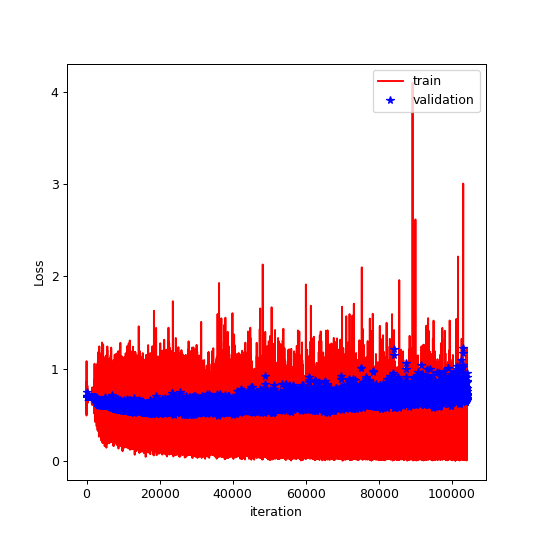

In [26]:
# Plot training and test loss
%matplotlib notebook
t = np.arange(iteration-1)
t2 = t[t % 10 == 0]
if len(t2) > len(validation_loss):
    # remove 0 as first element
    t2 = t2[1:]

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t2, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# 7. Plot Training-Validation Accuracy

<IPython.core.display.Javascript object>


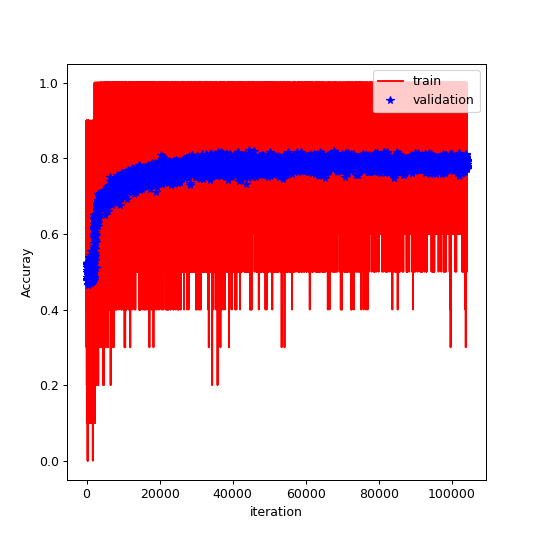

In [27]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t2, validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# 8. Evaluate on test set

In [12]:
with graph.as_default():
    tf.random.set_random_seed(1234)
    saver = tf.train.Saver()

In [60]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [61]:
def save_results(pred_1, pred_0, acc, names, lbls, run_name, path):
    d = {'Name': names, 'Label':lbls, 'Acc':acc, 'pr(abnormal)': pred_1, 'pr(normal)': pred_0}
    df = pd.DataFrame(data=d)
    model_name = (run_name.rsplit("/", 1)[-1]).rsplit(".", 1)[0]
    f_name = model_name + '_testresults.csv'
    
    save_path = path + "/Results/Test_results/" + f_name
    export_csv = df.to_csv(save_path, header=True, index=False)
    print("Saved to path ")
    print(save_path)

In [62]:
test_acc = []
cm = np.zeros((2,2))

pr_1 = []
pr_0 = []
acc_list = []
names = []
lbls = []

with tf.Session(graph=graph) as sess:
    tf.random.set_random_seed(1234)
    # Restore
    #restore_point = tf.train.latest_checkpoint('checkpoints-cnn')
    restore_point = runID
    saver.restore(sess, restore_point)
    counter = 0
    
    for x_t, y_t in get_batches(x_test, y_test, batch_size=1):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc, class_logits = sess.run([accuracy, logits], feed_dict=feed)
        test_acc.append(batch_acc)
        class_probs = softmax(class_logits)
        
        if batch_acc == 0:
            print('Label: ', np.argmax(y_t), 
                      ' Class probabilities: ', class_probs[0], 
                      ' Accuracy: ', batch_acc,
                      ' Name: ', sample_names_test[counter])
           
            
        pr_1.append(class_probs[0][1])
        pr_0.append(class_probs[0][0])
        acc_list.append(batch_acc)
        names.append(sample_names_test[counter][0])
        lbls.append(np.argmax(y_t))
        cm[int(np.argmax(y_t)), int(batch_acc)] += 1
        counter += 1
    print("\nTest accuracy: {:.6f}".format(np.mean(test_acc)))
     # Confusion matrix
    confusion = np.zeros((2,2))
    confusion[0, 0] = cm[1, 1]
    confusion[1, 0] = cm[1, 0]
    confusion[0, 1] = cm[0, 0]
    confusion[1, 1] = cm[0, 1]
        
    print('\nCONFUSION MATRIX')
    print(confusion)
    


INFO:tensorflow:Restoring parameters from checkpoints-cnn/COPD_filters58.ckpt
Label:  1  Class probabilities:  [0.5502239  0.44977614]  Accuracy:  0.0  Name:  ['./heldout/COPD-01F_slice37.csv']
Label:  1  Class probabilities:  [1.0000000e+00 5.8583725e-15]  Accuracy:  0.0  Name:  ['./heldout/COPD-01F_slice38.csv']
Label:  1  Class probabilities:  [0.6061318  0.39386824]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_slice4.csv']
Label:  1  Class probabilities:  [0.9637617  0.03623825]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_slice25.csv']
Label:  1  Class probabilities:  [0.6482136  0.35178635]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_slice30.csv']
Label:  1  Class probabilities:  [0.9983559  0.00164404]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_slice31.csv']
Label:  1  Class probabilities:  [0.8853228  0.11467719]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_slice32.csv']
Label:  1  Class probabilities:  [0.5076417  0.49235836]  Accuracy:  0.0  Name:  ['./heldout/COPD-03M_sli

Label:  1  Class probabilities:  [0.60653865 0.39346135]  Accuracy:  0.0  Name:  ['./heldout/COPD-09M_slice40.csv']
Label:  1  Class probabilities:  [0.9746504 0.0253497]  Accuracy:  0.0  Name:  ['./heldout/COPD-10F_slice4.csv']
Label:  1  Class probabilities:  [0.67773587 0.32226413]  Accuracy:  0.0  Name:  ['./heldout/COPD-10F_slice31.csv']
Label:  1  Class probabilities:  [1.000000e+00 5.598996e-08]  Accuracy:  0.0  Name:  ['./heldout/COPD-10F_slice38.csv']
Label:  1  Class probabilities:  [0.99851876 0.00148119]  Accuracy:  0.0  Name:  ['./heldout/COPD-10F_slice39.csv']
Label:  0  Class probabilities:  [0.32697684 0.67302316]  Accuracy:  0.0  Name:  ['./heldout/EMB 0003_slice5.csv']
Label:  0  Class probabilities:  [0.38072857 0.61927146]  Accuracy:  0.0  Name:  ['./heldout/EMB 0003_slice7.csv']
Label:  0  Class probabilities:  [0.41192535 0.5880746 ]  Accuracy:  0.0  Name:  ['./heldout/EMB 0003_slice8.csv']
Label:  0  Class probabilities:  [0.3454291  0.65457094]  Accuracy:  0.0  

Label:  0  Class probabilities:  [0.35393855 0.6460615 ]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice5.csv']
Label:  0  Class probabilities:  [0.04765303 0.9523469 ]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice7.csv']
Label:  0  Class probabilities:  [0.23431052 0.7656895 ]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice11.csv']
Label:  0  Class probabilities:  [0.2935499 0.7064501]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice12.csv']
Label:  0  Class probabilities:  [0.30011675 0.6998833 ]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice13.csv']
Label:  0  Class probabilities:  [0.3448847  0.65511525]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice14.csv']
Label:  0  Class probabilities:  [0.25200194 0.74799806]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice17.csv']
Label:  0  Class probabilities:  [0.23574743 0.76425254]  Accuracy:  0.0  Name:  ['./heldout/EMB 0083_slice18.csv']
Label:  0  Class probabilities:  [0.3105691 0.6894309]  Accuracy:  0.0  Name

In [ ]:
save_results(pr_1, pr_0, acc_list, names, lbls, runID, path)

# Examine Filters

CH1 = R CHEST

CH2 = L CHEST

CH3 = R ABDOMEN

CH4 = L ABDOMEN

In [13]:
def weights_reshape(w):
    w_reshaped = np.zeros((w.shape[1], w.shape[0], w.shape[2]))
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w_reshaped[j, i, :] = w[i][j]
            
    return w_reshaped

In [14]:
with tf.Session(graph=graph) as sess:
    restore_point = runID
    #restore_point = tf.train.latest_checkpoint('checkpoints-cnn')

    saver.restore(sess, restore_point)
    w1 = sess.run(weights['wc1'])
    w2 = sess.run(weights['wc2'])
    w3 = sess.run(weights['wc3'])
    w_reshaped = weights_reshape(w1)
    w_reshaped2 = weights_reshape(w2)
    w_reshaped3 = weights_reshape(w3)

INFO:tensorflow:Restoring parameters from checkpoints-cnn/COPD_filters58.ckpt


In [15]:
from scipy import signal
def smooth_volume(v_list, smooth=True):
    if smooth:
        smoothed = signal.savgol_filter(v_list, 5, 3)
        return smoothed
    else:
        return v_list

In [16]:
def plot_smoothed_filter(ax, filter_num, kernel_size, weights):
    line1, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[0, :, filter_num]), label='R Chest', 
                     c='gold')
    line2, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[1, :, filter_num]), label='L Chest', 
                     c='red')
    line3, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[2, :, filter_num]), label='R Abdomen',
                    c='green')
    line4, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[3, :, filter_num]), label='L Abdomen',
                        c='blue')
    ax.set_ylabel('Value')


<IPython.core.display.Javascript object>


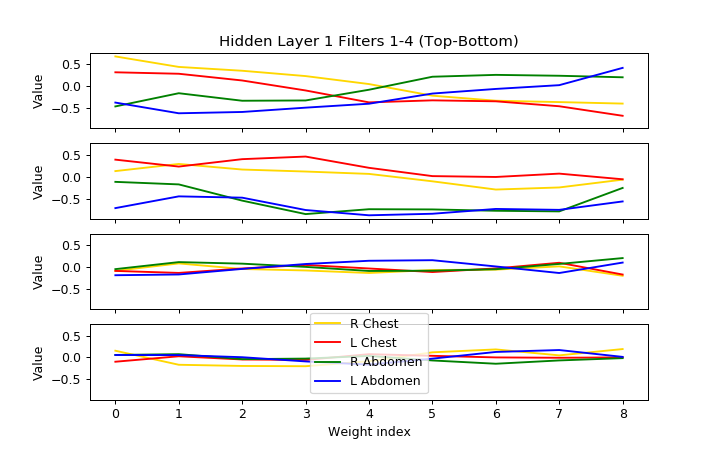

C:\Users\Dell\Anaconda3\envs\4thYearProject\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [17]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped)

ax1.set_title('Hidden Layer 1 Filters 1-4 (Top-Bottom)')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


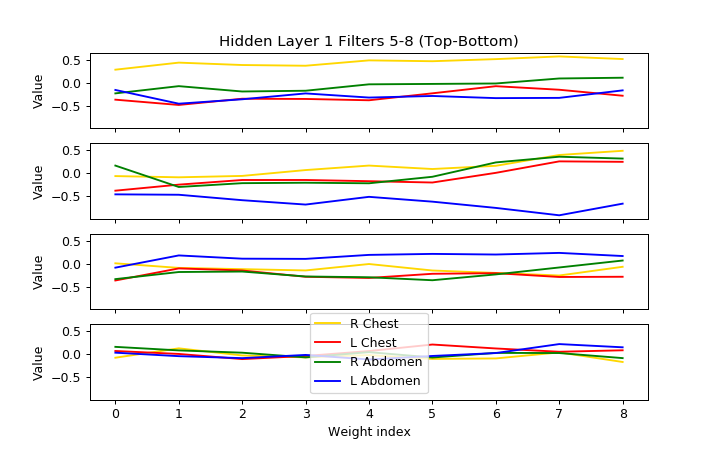

In [18]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped)

ax1.set_title('Hidden Layer 1 Filters 5-8 (Top-Bottom)')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


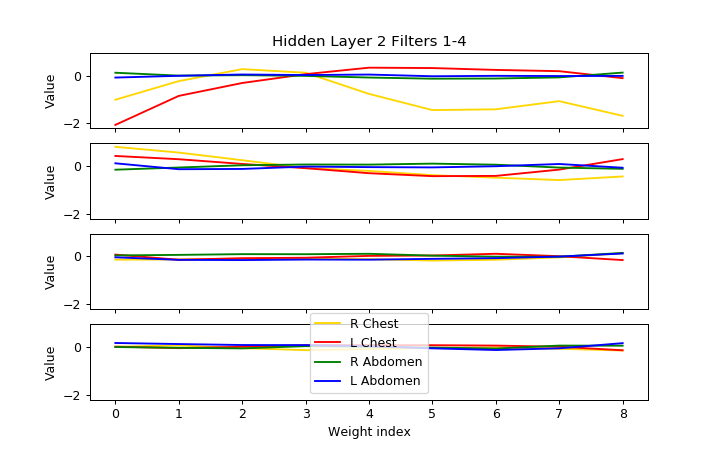

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 1-4')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


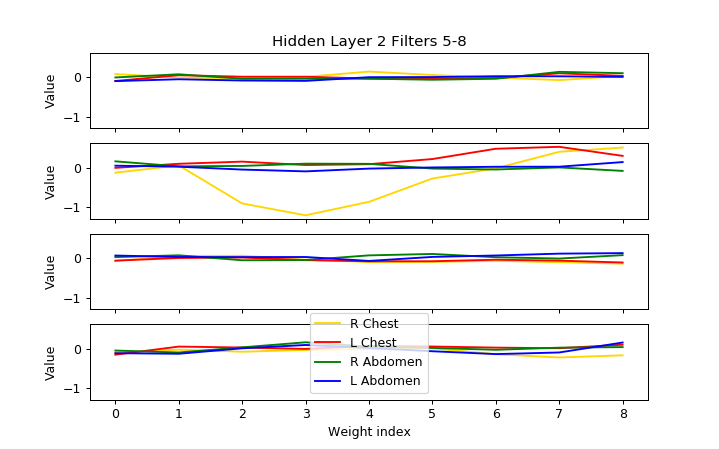

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 5-8')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


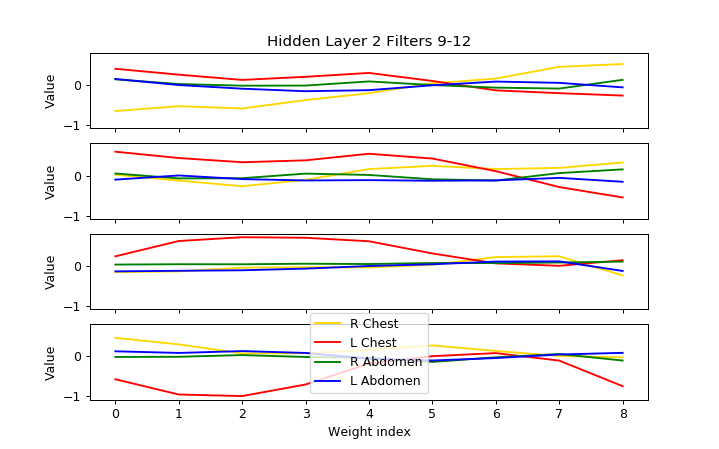

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+8, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 9-12')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


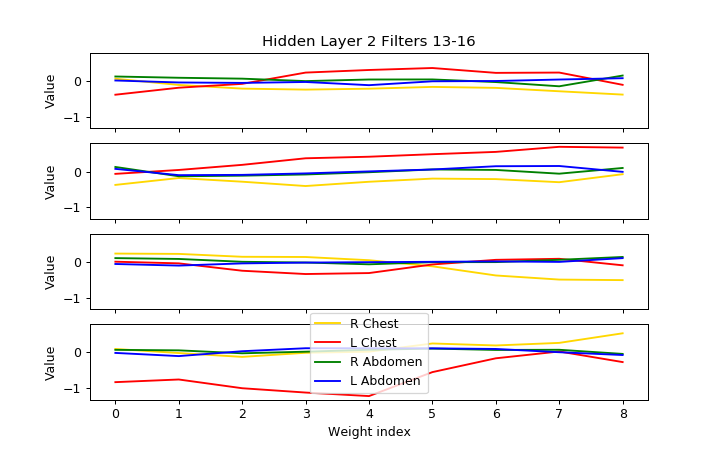

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+12, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 13-16')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


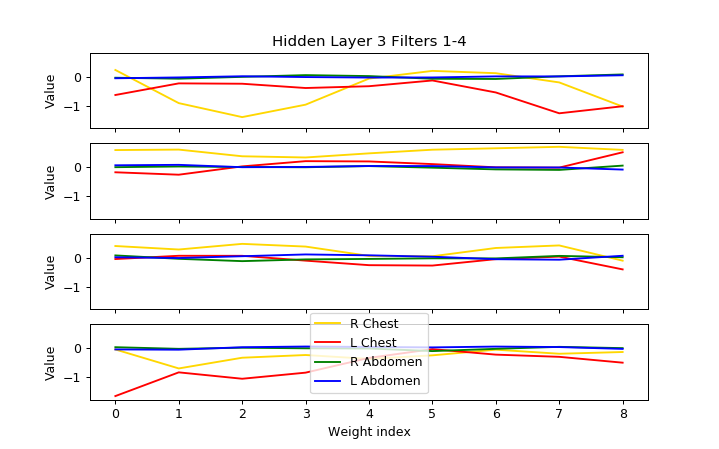

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 1-4')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


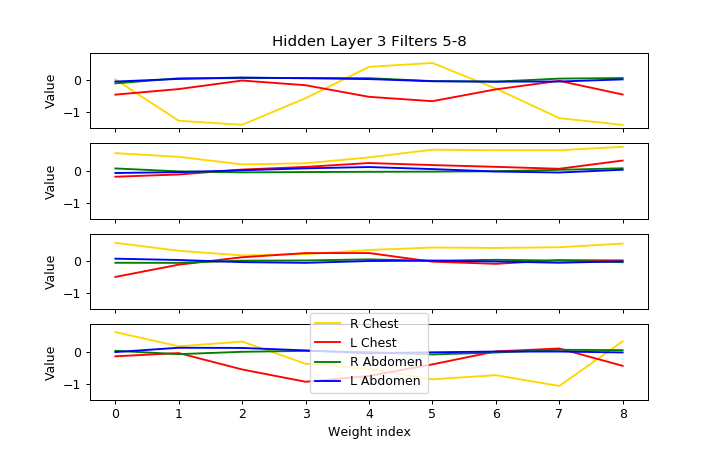

In [92]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 5-8')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


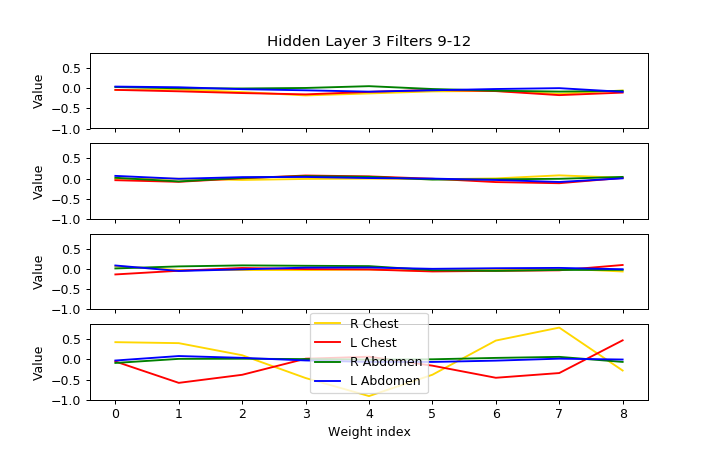

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+8, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 9-12')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


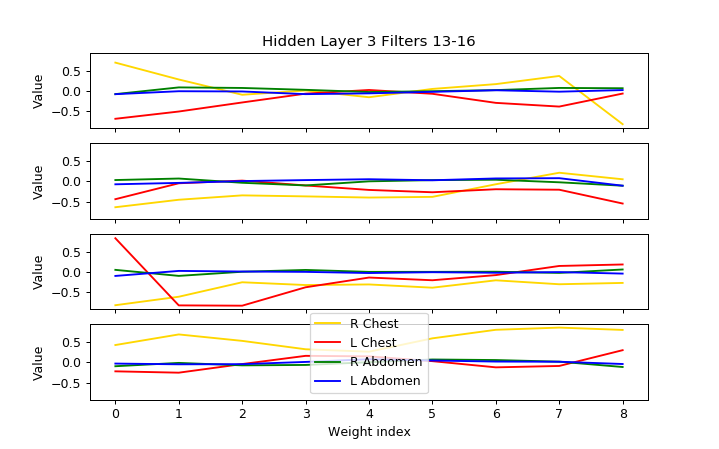

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+12, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 13-16')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


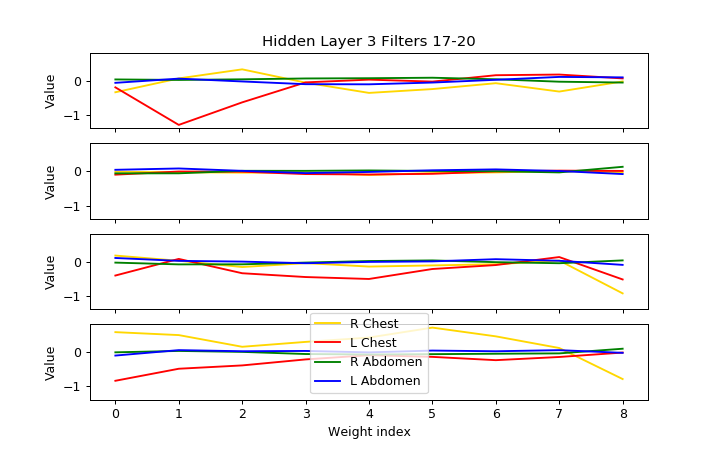

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+16, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 17-20')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


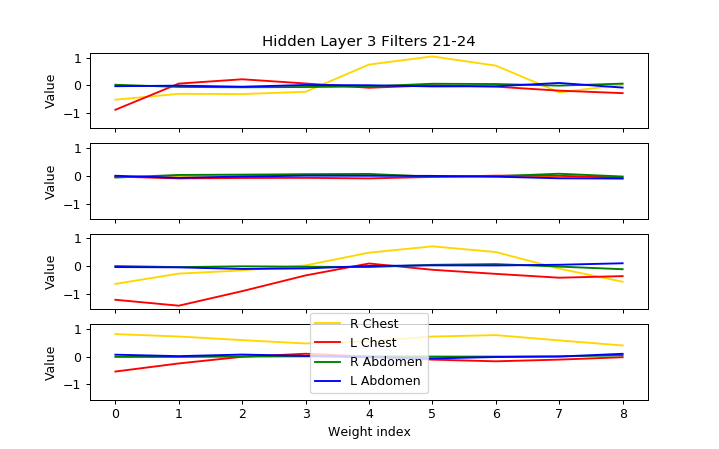

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+20, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 21-24')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


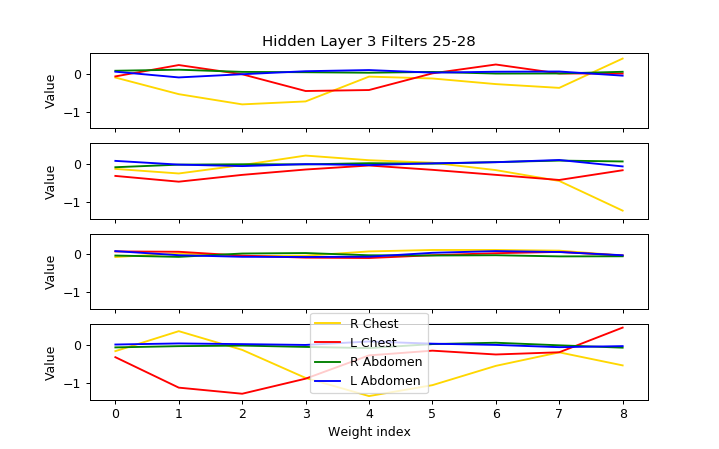

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+24, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 25-28')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


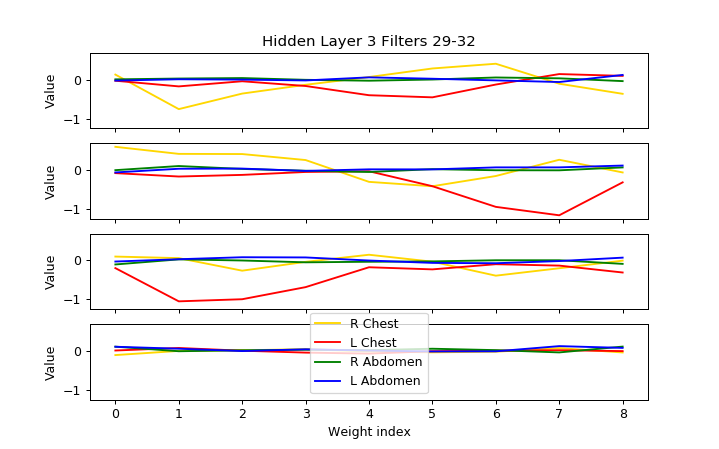

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+28, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 29-32')
plt.xlabel('Weight index')
plt.legend()
plt.show()